In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=int(os.getenv("FOLD"))

In [3]:
print FOLD

3


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

In [9]:
#show_data(data,columns, 1,480, None)

In [10]:
#show_data2(data,columns)

# cv

In [11]:
n_reg_lookback=28

In [12]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'geo2_visitors_mean', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 'day_of_week_visitors_mean', 'station_count_y2', 'all_count_y5'])
len(lag_cols)

26

In [13]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [14]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [15]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [16]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [17]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
print K.floatx()

Using TensorFlow backend.


float32


In [18]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [19]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [20]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['nb_error'],
            "patience":[5],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'nb_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 5})

In [21]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
def predict_test(self,test_gen):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X
def g(a,test_gen):
    result=predict_test(a,test_gen)
    df=pd.DataFrame({'y':result[2][:,0]})
    df['pred']=result[0][:,0]
    df['dayidx']=result[1][:,1]
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    display(df2)
    print  df2['error2'].mean()
    return  df2['error2'].mean()

PRED_DATE=478

def h(self,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, Xdict)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), 
    return yy_pred, dataidx


In [24]:
EXCLUDE_HARD=False

import rrvf_model as rrvf
import rrvf_data
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,# 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,                      
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    lag_input_dim=lag_train_test.shape[-1]
    ondate_input_dim=ondate_train_test.shape[-1]
    print lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)
    backend.clear_session()
    set_session(tf.Session(config=config))   
    a=rrvf.KerasModel("testconv", n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                      ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim, n_offset=n_offset,
                      max_epoch=100, use_output_exp=False,use_dropout=False,model_type='conv',
                      params=parameter)
    a._make_model()
    print a.params
    print a.model.count_params()
    a.fit(train_gen,valid_gen)
    if a.model.abnormal_stop:
        return np.inf,None,None
    valid_loss,validy,validpred,valididx=a.eval_valid()
    print valid_loss
    g(a,test_gen)
    pred478=h(a,train_gen)
    return valid_loss,(validy,valididx,validpred),pred478



def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    while 1:
        ret=_run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)
        if ret[0]<1:
            return ret
        else:
            print "bad init,try again."
        

In [25]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [26]:
reload (rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [27]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)    
    _,validpred,pred478=run_once(columns,data,rawy,indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds,   open('3003nb_conv_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE) ,'wb'))



1


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(26,) 0.00244472 2.97218


(829, 517, 26)


train/valid # (297687, 2) (74534, 2)


train/valid # (197177, 2) (48115, 2)
train/valid # (197177, 2) (48115, 2)


rand split across time
train has 197177 records out of 372221 records
valid has 48115 records out of 372221 records
train has 5803 records out of 5803 records
no valid set
1540
0
26 18 (1, 18)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)


{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
374273


Epoch 1/100


   1/1540 [..............................] - ETA: 45:45 - loss: 45.4586 - total_loss: 45.4586 - reg_loss: 8.6481

   5/1540 [..............................] - ETA: 9:24 - loss: 14.2395 - total_loss: 14.2395 - reg_loss: 4.3653 

   9/1540 [..............................] - ETA: 5:21 - loss: 8.9224 - total_loss: 8.9224 - reg_loss: 7.0893  

  13/1540 [..............................] - ETA: 3:48 - loss: 6.8953 - total_loss: 6.8953 - reg_loss: 9.3400

  17/1540 [..............................] - ETA: 2:59 - loss: 5.7857 - total_loss: 5.7857 - reg_loss: 8.4471

  21/1540 [..............................] - ETA: 2:28 - loss: 5.0739 - total_loss: 5.0739 - reg_loss: 7.0023

  26/1540 [..............................] - ETA: 2:02 - loss: 4.4983 - total_loss: 4.4983 - reg_loss: 5.8043

  30/1540 [..............................] - ETA: 1:48 - loss: 4.1720 - total_loss: 4.1720 - reg_loss: 5.1645

  34/1540 [..............................] - ETA: 1:38 - loss: 3.9218 - total_loss: 3.9218 - reg_loss: 4.6665

  38/1540 [..............................] - ETA: 1:29 - loss: 3.7241 - total_loss: 3.7241 - reg_loss: 4.2395

  42/1540 [..............................] - ETA: 1:23 - loss: 3.5652 - total_loss: 3.5652 - reg_loss: 3.8968

  46/1540 [..............................] - ETA: 1:17 - loss: 3.4320 - total_loss: 3.4320 - reg_loss: 3.6004

  50/1540 [..............................] - ETA: 1:12 - loss: 3.3212 - total_loss: 3.3212 - reg_loss: 3.3527

  54/1540 [>.............................] - ETA: 1:08 - loss: 3.2265 - total_loss: 3.2265 - reg_loss: 3.1439

  58/1540 [>.............................] - ETA: 1:05 - loss: 3.1458 - total_loss: 3.1458 - reg_loss: 2.9608

  62/1540 [>.............................] - ETA: 1:02 - loss: 3.0749 - total_loss: 3.0749 - reg_loss: 2.7994

  66/1540 [>.............................] - ETA: 59s - loss: 3.0111 - total_loss: 3.0111 - reg_loss: 2.6625 

  70/1540 [>.............................] - ETA: 57s - loss: 2.9563 - total_loss: 2.9563 - reg_loss: 2.5361

  74/1540 [>.............................] - ETA: 55s - loss: 2.9073 - total_loss: 2.9073 - reg_loss: 2.4252

  78/1540 [>.............................] - ETA: 53s - loss: 2.8624 - total_loss: 2.8624 - reg_loss: 2.3237

  82/1540 [>.............................] - ETA: 51s - loss: 2.8221 - total_loss: 2.8221 - reg_loss: 2.2318

  86/1540 [>.............................] - ETA: 49s - loss: 2.7860 - total_loss: 2.7860 - reg_loss: 2.1479

  90/1540 [>.............................] - ETA: 48s - loss: 2.7525 - total_loss: 2.7525 - reg_loss: 2.0722

  94/1540 [>.............................] - ETA: 46s - loss: 2.7219 - total_loss: 2.7219 - reg_loss: 2.0035

  98/1540 [>.............................] - ETA: 45s - loss: 2.6938 - total_loss: 2.6938 - reg_loss: 1.9378

 102/1540 [>.............................] - ETA: 44s - loss: 2.6686 - total_loss: 2.6686 - reg_loss: 1.8769

 106/1540 [=>............................] - ETA: 43s - loss: 2.6448 - total_loss: 2.6448 - reg_loss: 1.8236

 110/1540 [=>............................] - ETA: 42s - loss: 2.6230 - total_loss: 2.6230 - reg_loss: 1.7704

 114/1540 [=>............................] - ETA: 41s - loss: 2.6026 - total_loss: 2.6026 - reg_loss: 1.7226

 118/1540 [=>............................] - ETA: 40s - loss: 2.5838 - total_loss: 2.5838 - reg_loss: 1.6772

 122/1540 [=>............................] - ETA: 39s - loss: 2.5659 - total_loss: 2.5659 - reg_loss: 1.6343

 126/1540 [=>............................] - ETA: 39s - loss: 2.5494 - total_loss: 2.5494 - reg_loss: 1.5929

 130/1540 [=>............................] - ETA: 38s - loss: 2.5341 - total_loss: 2.5341 - reg_loss: 1.5542

 134/1540 [=>............................] - ETA: 37s - loss: 2.5193 - total_loss: 2.5193 - reg_loss: 1.5183

 138/1540 [=>............................] - ETA: 37s - loss: 2.5054 - total_loss: 2.5054 - reg_loss: 1.4851

 142/1540 [=>............................] - ETA: 36s - loss: 2.4918 - total_loss: 2.4918 - reg_loss: 1.4525

 146/1540 [=>............................] - ETA: 35s - loss: 2.4789 - total_loss: 2.4789 - reg_loss: 1.4213

 150/1540 [=>............................] - ETA: 35s - loss: 2.4670 - total_loss: 2.4670 - reg_loss: 1.3947

 154/1540 [==>...........................] - ETA: 34s - loss: 2.4561 - total_loss: 2.4561 - reg_loss: 1.3679

 158/1540 [==>...........................] - ETA: 34s - loss: 2.4458 - total_loss: 2.4458 - reg_loss: 1.3434

 162/1540 [==>...........................] - ETA: 33s - loss: 2.4357 - total_loss: 2.4357 - reg_loss: 1.3190

 166/1540 [==>...........................] - ETA: 33s - loss: 2.4261 - total_loss: 2.4261 - reg_loss: 1.2944

 170/1540 [==>...........................] - ETA: 33s - loss: 2.4165 - total_loss: 2.4165 - reg_loss: 1.2722

 174/1540 [==>...........................] - ETA: 32s - loss: 2.4079 - total_loss: 2.4079 - reg_loss: 1.2509

 178/1540 [==>...........................] - ETA: 32s - loss: 2.3993 - total_loss: 2.3993 - reg_loss: 1.2302

 182/1540 [==>...........................] - ETA: 31s - loss: 2.3916 - total_loss: 2.3916 - reg_loss: 1.2107

 186/1540 [==>...........................] - ETA: 31s - loss: 2.3840 - total_loss: 2.3840 - reg_loss: 1.1919

 190/1540 [==>...........................] - ETA: 31s - loss: 2.3768 - total_loss: 2.3768 - reg_loss: 1.1738

 194/1540 [==>...........................] - ETA: 30s - loss: 2.3697 - total_loss: 2.3697 - reg_loss: 1.1572

 198/1540 [==>...........................] - ETA: 30s - loss: 2.3625 - total_loss: 2.3625 - reg_loss: 1.1417

 202/1540 [==>...........................] - ETA: 30s - loss: 2.3558 - total_loss: 2.3558 - reg_loss: 1.1263

 206/1540 [===>..........................] - ETA: 29s - loss: 2.3499 - total_loss: 2.3499 - reg_loss: 1.1118

 210/1540 [===>..........................] - ETA: 29s - loss: 2.3436 - total_loss: 2.3436 - reg_loss: 1.0971

 214/1540 [===>..........................] - ETA: 29s - loss: 2.3380 - total_loss: 2.3380 - reg_loss: 1.0829

 218/1540 [===>..........................] - ETA: 28s - loss: 2.3323 - total_loss: 2.3323 - reg_loss: 1.0687

 222/1540 [===>..........................] - ETA: 28s - loss: 2.3269 - total_loss: 2.3269 - reg_loss: 1.0551

 226/1540 [===>..........................] - ETA: 28s - loss: 2.3215 - total_loss: 2.3215 - reg_loss: 1.0419

 230/1540 [===>..........................] - ETA: 28s - loss: 2.3165 - total_loss: 2.3165 - reg_loss: 1.0294

 234/1540 [===>..........................] - ETA: 27s - loss: 2.3114 - total_loss: 2.3114 - reg_loss: 1.0178

 238/1540 [===>..........................] - ETA: 27s - loss: 2.3067 - total_loss: 2.3067 - reg_loss: 1.0067

 242/1540 [===>..........................] - ETA: 27s - loss: 2.3019 - total_loss: 2.3019 - reg_loss: 0.9951

 246/1540 [===>..........................] - ETA: 27s - loss: 2.2975 - total_loss: 2.2975 - reg_loss: 0.9840

 250/1540 [===>..........................] - ETA: 26s - loss: 2.2932 - total_loss: 2.2932 - reg_loss: 0.9744

 254/1540 [===>..........................] - ETA: 26s - loss: 2.2889 - total_loss: 2.2889 - reg_loss: 0.9642

 258/1540 [====>.........................] - ETA: 26s - loss: 2.2850 - total_loss: 2.2850 - reg_loss: 0.9544

 262/1540 [====>.........................] - ETA: 26s - loss: 2.2810 - total_loss: 2.2810 - reg_loss: 0.9455

 266/1540 [====>.........................] - ETA: 25s - loss: 2.2774 - total_loss: 2.2774 - reg_loss: 0.9361

 270/1540 [====>.........................] - ETA: 25s - loss: 2.2739 - total_loss: 2.2739 - reg_loss: 0.9269

 274/1540 [====>.........................] - ETA: 25s - loss: 2.2708 - total_loss: 2.2708 - reg_loss: 0.9181

 278/1540 [====>.........................] - ETA: 25s - loss: 2.2676 - total_loss: 2.2676 - reg_loss: 0.9094

 282/1540 [====>.........................] - ETA: 25s - loss: 2.2644 - total_loss: 2.2644 - reg_loss: 0.9008

 286/1540 [====>.........................] - ETA: 25s - loss: 2.2614 - total_loss: 2.2614 - reg_loss: 0.8923

 290/1540 [====>.........................] - ETA: 24s - loss: 2.2579 - total_loss: 2.2579 - reg_loss: 0.8844

 294/1540 [====>.........................] - ETA: 24s - loss: 2.2547 - total_loss: 2.2547 - reg_loss: 0.8769

 298/1540 [====>.........................] - ETA: 24s - loss: 2.2519 - total_loss: 2.2519 - reg_loss: 0.8693

 302/1540 [====>.........................] - ETA: 24s - loss: 2.2488 - total_loss: 2.2488 - reg_loss: 0.8621

 306/1540 [====>.........................] - ETA: 24s - loss: 2.2461 - total_loss: 2.2461 - reg_loss: 0.8549

 310/1540 [=====>........................] - ETA: 23s - loss: 2.2434 - total_loss: 2.2434 - reg_loss: 0.8481

 314/1540 [=====>........................] - ETA: 23s - loss: 2.2406 - total_loss: 2.2406 - reg_loss: 0.8413

 318/1540 [=====>........................] - ETA: 23s - loss: 2.2379 - total_loss: 2.2379 - reg_loss: 0.8349

 322/1540 [=====>........................] - ETA: 23s - loss: 2.2352 - total_loss: 2.2352 - reg_loss: 0.8291

 326/1540 [=====>........................] - ETA: 23s - loss: 2.2325 - total_loss: 2.2325 - reg_loss: 0.8223

 330/1540 [=====>........................] - ETA: 23s - loss: 2.2303 - total_loss: 2.2303 - reg_loss: 0.8165

 334/1540 [=====>........................] - ETA: 22s - loss: 2.2279 - total_loss: 2.2279 - reg_loss: 0.8107

 338/1540 [=====>........................] - ETA: 22s - loss: 2.2257 - total_loss: 2.2257 - reg_loss: 0.8057

 342/1540 [=====>........................] - ETA: 22s - loss: 2.2233 - total_loss: 2.2233 - reg_loss: 0.7998

 346/1540 [=====>........................] - ETA: 22s - loss: 2.2211 - total_loss: 2.2211 - reg_loss: 0.7945

 350/1540 [=====>........................] - ETA: 22s - loss: 2.2190 - total_loss: 2.2190 - reg_loss: 0.7897

 354/1540 [=====>........................] - ETA: 22s - loss: 2.2170 - total_loss: 2.2170 - reg_loss: 0.7845

 358/1540 [=====>........................] - ETA: 22s - loss: 2.2151 - total_loss: 2.2151 - reg_loss: 0.7793

 362/1540 [======>.......................] - ETA: 21s - loss: 2.2132 - total_loss: 2.2132 - reg_loss: 0.7744

 366/1540 [======>.......................] - ETA: 21s - loss: 2.2112 - total_loss: 2.2112 - reg_loss: 0.7693

 370/1540 [======>.......................] - ETA: 21s - loss: 2.2093 - total_loss: 2.2093 - reg_loss: 0.7641

 374/1540 [======>.......................] - ETA: 21s - loss: 2.2075 - total_loss: 2.2075 - reg_loss: 0.7601

 378/1540 [======>.......................] - ETA: 21s - loss: 2.2057 - total_loss: 2.2057 - reg_loss: 0.7552

 382/1540 [======>.......................] - ETA: 21s - loss: 2.2038 - total_loss: 2.2038 - reg_loss: 0.7510

 386/1540 [======>.......................] - ETA: 21s - loss: 2.2021 - total_loss: 2.2021 - reg_loss: 0.7469

 390/1540 [======>.......................] - ETA: 21s - loss: 2.2003 - total_loss: 2.2003 - reg_loss: 0.7426

 394/1540 [======>.......................] - ETA: 20s - loss: 2.1987 - total_loss: 2.1987 - reg_loss: 0.7386

 398/1540 [======>.......................] - ETA: 20s - loss: 2.1969 - total_loss: 2.1969 - reg_loss: 0.7347

 402/1540 [======>.......................] - ETA: 20s - loss: 2.1953 - total_loss: 2.1953 - reg_loss: 0.7306

 406/1540 [======>.......................] - ETA: 20s - loss: 2.1938 - total_loss: 2.1938 - reg_loss: 0.7273

 410/1540 [======>.......................] - ETA: 20s - loss: 2.1923 - total_loss: 2.1923 - reg_loss: 0.7233

 414/1540 [=======>......................] - ETA: 20s - loss: 2.1907 - total_loss: 2.1907 - reg_loss: 0.7195

 418/1540 [=======>......................] - ETA: 20s - loss: 2.1891 - total_loss: 2.1891 - reg_loss: 0.7155

 422/1540 [=======>......................] - ETA: 20s - loss: 2.1875 - total_loss: 2.1875 - reg_loss: 0.7118

 426/1540 [=======>......................] - ETA: 19s - loss: 2.1860 - total_loss: 2.1860 - reg_loss: 0.7079

 430/1540 [=======>......................] - ETA: 19s - loss: 2.1847 - total_loss: 2.1847 - reg_loss: 0.7047

 434/1540 [=======>......................] - ETA: 19s - loss: 2.1833 - total_loss: 2.1833 - reg_loss: 0.7013

 438/1540 [=======>......................] - ETA: 19s - loss: 2.1818 - total_loss: 2.1818 - reg_loss: 0.6977

 442/1540 [=======>......................] - ETA: 19s - loss: 2.1805 - total_loss: 2.1805 - reg_loss: 0.6941

 446/1540 [=======>......................] - ETA: 19s - loss: 2.1791 - total_loss: 2.1791 - reg_loss: 0.6906

 450/1540 [=======>......................] - ETA: 19s - loss: 2.1778 - total_loss: 2.1778 - reg_loss: 0.6871

 454/1540 [=======>......................] - ETA: 19s - loss: 2.1765 - total_loss: 2.1765 - reg_loss: 0.6836

 458/1540 [=======>......................] - ETA: 19s - loss: 2.1755 - total_loss: 2.1755 - reg_loss: 0.6805

 462/1540 [========>.....................] - ETA: 18s - loss: 2.1744 - total_loss: 2.1744 - reg_loss: 0.6780

 466/1540 [========>.....................] - ETA: 18s - loss: 2.1731 - total_loss: 2.1731 - reg_loss: 0.6754

 470/1540 [========>.....................] - ETA: 18s - loss: 2.1721 - total_loss: 2.1721 - reg_loss: 0.6723

 474/1540 [========>.....................] - ETA: 18s - loss: 2.1708 - total_loss: 2.1708 - reg_loss: 0.6692

 478/1540 [========>.....................] - ETA: 18s - loss: 2.1695 - total_loss: 2.1695 - reg_loss: 0.6666

 482/1540 [========>.....................] - ETA: 18s - loss: 2.1684 - total_loss: 2.1684 - reg_loss: 0.6636

 486/1540 [========>.....................] - ETA: 18s - loss: 2.1671 - total_loss: 2.1671 - reg_loss: 0.6604

 490/1540 [========>.....................] - ETA: 18s - loss: 2.1659 - total_loss: 2.1659 - reg_loss: 0.6576

 494/1540 [========>.....................] - ETA: 18s - loss: 2.1650 - total_loss: 2.1650 - reg_loss: 0.6547

 498/1540 [========>.....................] - ETA: 18s - loss: 2.1639 - total_loss: 2.1639 - reg_loss: 0.6520

 502/1540 [========>.....................] - ETA: 17s - loss: 2.1629 - total_loss: 2.1629 - reg_loss: 0.6496

 506/1540 [========>.....................] - ETA: 17s - loss: 2.1618 - total_loss: 2.1618 - reg_loss: 0.6472

 510/1540 [========>.....................] - ETA: 17s - loss: 2.1609 - total_loss: 2.1609 - reg_loss: 0.6445

 514/1540 [=========>....................] - ETA: 17s - loss: 2.1599 - total_loss: 2.1599 - reg_loss: 0.6419

 518/1540 [=========>....................] - ETA: 17s - loss: 2.1588 - total_loss: 2.1588 - reg_loss: 0.6394

 522/1540 [=========>....................] - ETA: 17s - loss: 2.1580 - total_loss: 2.1580 - reg_loss: 0.6367

 526/1540 [=========>....................] - ETA: 17s - loss: 2.1569 - total_loss: 2.1569 - reg_loss: 0.6342

 530/1540 [=========>....................] - ETA: 17s - loss: 2.1559 - total_loss: 2.1559 - reg_loss: 0.6321

 534/1540 [=========>....................] - ETA: 17s - loss: 2.1550 - total_loss: 2.1550 - reg_loss: 0.6300

 538/1540 [=========>....................] - ETA: 17s - loss: 2.1541 - total_loss: 2.1541 - reg_loss: 0.6273

 542/1540 [=========>....................] - ETA: 16s - loss: 2.1531 - total_loss: 2.1531 - reg_loss: 0.6248

 546/1540 [=========>....................] - ETA: 16s - loss: 2.1521 - total_loss: 2.1521 - reg_loss: 0.6224

 550/1540 [=========>....................] - ETA: 16s - loss: 2.1512 - total_loss: 2.1512 - reg_loss: 0.6202

 554/1540 [=========>....................] - ETA: 16s - loss: 2.1504 - total_loss: 2.1504 - reg_loss: 0.6180

 558/1540 [=========>....................] - ETA: 16s - loss: 2.1498 - total_loss: 2.1498 - reg_loss: 0.6157

 562/1540 [=========>....................] - ETA: 16s - loss: 2.1489 - total_loss: 2.1489 - reg_loss: 0.6137

 567/1540 [==========>...................] - ETA: 16s - loss: 2.1477 - total_loss: 2.1477 - reg_loss: 0.6114

 571/1540 [==========>...................] - ETA: 16s - loss: 2.1468 - total_loss: 2.1468 - reg_loss: 0.6092

 575/1540 [==========>...................] - ETA: 16s - loss: 2.1461 - total_loss: 2.1461 - reg_loss: 0.6071

 579/1540 [==========>...................] - ETA: 16s - loss: 2.1454 - total_loss: 2.1454 - reg_loss: 0.6050

 583/1540 [==========>...................] - ETA: 16s - loss: 2.1446 - total_loss: 2.1446 - reg_loss: 0.6030

 587/1540 [==========>...................] - ETA: 15s - loss: 2.1440 - total_loss: 2.1440 - reg_loss: 0.6009

 591/1540 [==========>...................] - ETA: 15s - loss: 2.1432 - total_loss: 2.1432 - reg_loss: 0.5987

 595/1540 [==========>...................] - ETA: 15s - loss: 2.1425 - total_loss: 2.1425 - reg_loss: 0.5969

 599/1540 [==========>...................] - ETA: 15s - loss: 2.1418 - total_loss: 2.1418 - reg_loss: 0.5948

 603/1540 [==========>...................] - ETA: 15s - loss: 2.1409 - total_loss: 2.1409 - reg_loss: 0.5928

 607/1540 [==========>...................] - ETA: 15s - loss: 2.1401 - total_loss: 2.1401 - reg_loss: 0.5908

 611/1540 [==========>...................] - ETA: 15s - loss: 2.1396 - total_loss: 2.1396 - reg_loss: 0.5891

 615/1540 [==========>...................] - ETA: 15s - loss: 2.1389 - total_loss: 2.1389 - reg_loss: 0.5871

 619/1540 [===========>..................] - ETA: 15s - loss: 2.1382 - total_loss: 2.1382 - reg_loss: 0.5853

 623/1540 [===========>..................] - ETA: 15s - loss: 2.1375 - total_loss: 2.1375 - reg_loss: 0.5838

 627/1540 [===========>..................] - ETA: 15s - loss: 2.1368 - total_loss: 2.1368 - reg_loss: 0.5822

 631/1540 [===========>..................] - ETA: 15s - loss: 2.1362 - total_loss: 2.1362 - reg_loss: 0.5805

 635/1540 [===========>..................] - ETA: 14s - loss: 2.1355 - total_loss: 2.1355 - reg_loss: 0.5788

 639/1540 [===========>..................] - ETA: 14s - loss: 2.1348 - total_loss: 2.1348 - reg_loss: 0.5771

 643/1540 [===========>..................] - ETA: 14s - loss: 2.1342 - total_loss: 2.1342 - reg_loss: 0.5755

 647/1540 [===========>..................] - ETA: 14s - loss: 2.1337 - total_loss: 2.1337 - reg_loss: 0.5736

 651/1540 [===========>..................] - ETA: 14s - loss: 2.1330 - total_loss: 2.1330 - reg_loss: 0.5719

 655/1540 [===========>..................] - ETA: 14s - loss: 2.1323 - total_loss: 2.1323 - reg_loss: 0.5704

 659/1540 [===========>..................] - ETA: 14s - loss: 2.1317 - total_loss: 2.1317 - reg_loss: 0.5686

 663/1540 [===========>..................] - ETA: 14s - loss: 2.1311 - total_loss: 2.1311 - reg_loss: 0.5670

 667/1540 [===========>..................] - ETA: 14s - loss: 2.1305 - total_loss: 2.1305 - reg_loss: 0.5653

 671/1540 [============>.................] - ETA: 14s - loss: 2.1300 - total_loss: 2.1300 - reg_loss: 0.5637

 675/1540 [============>.................] - ETA: 14s - loss: 2.1294 - total_loss: 2.1294 - reg_loss: 0.5621

 679/1540 [============>.................] - ETA: 14s - loss: 2.1287 - total_loss: 2.1287 - reg_loss: 0.5606

 683/1540 [============>.................] - ETA: 13s - loss: 2.1282 - total_loss: 2.1282 - reg_loss: 0.5590

 687/1540 [============>.................] - ETA: 13s - loss: 2.1277 - total_loss: 2.1277 - reg_loss: 0.5573

 691/1540 [============>.................] - ETA: 13s - loss: 2.1271 - total_loss: 2.1271 - reg_loss: 0.5560

 695/1540 [============>.................] - ETA: 13s - loss: 2.1265 - total_loss: 2.1265 - reg_loss: 0.5545

 700/1540 [============>.................] - ETA: 13s - loss: 2.1258 - total_loss: 2.1258 - reg_loss: 0.5525

 704/1540 [============>.................] - ETA: 13s - loss: 2.1253 - total_loss: 2.1253 - reg_loss: 0.5509

 708/1540 [============>.................] - ETA: 13s - loss: 2.1248 - total_loss: 2.1248 - reg_loss: 0.5496

 712/1540 [============>.................] - ETA: 13s - loss: 2.1243 - total_loss: 2.1243 - reg_loss: 0.5484

 716/1540 [============>.................] - ETA: 13s - loss: 2.1238 - total_loss: 2.1238 - reg_loss: 0.5473

 720/1540 [=============>................] - ETA: 13s - loss: 2.1232 - total_loss: 2.1232 - reg_loss: 0.5458

 724/1540 [=============>................] - ETA: 13s - loss: 2.1228 - total_loss: 2.1228 - reg_loss: 0.5443

 728/1540 [=============>................] - ETA: 13s - loss: 2.1224 - total_loss: 2.1224 - reg_loss: 0.5429

 732/1540 [=============>................] - ETA: 13s - loss: 2.1218 - total_loss: 2.1218 - reg_loss: 0.5415

 736/1540 [=============>................] - ETA: 12s - loss: 2.1213 - total_loss: 2.1213 - reg_loss: 0.5403

 740/1540 [=============>................] - ETA: 12s - loss: 2.1208 - total_loss: 2.1208 - reg_loss: 0.5389

 744/1540 [=============>................] - ETA: 12s - loss: 2.1204 - total_loss: 2.1204 - reg_loss: 0.5373

 748/1540 [=============>................] - ETA: 12s - loss: 2.1198 - total_loss: 2.1198 - reg_loss: 0.5360

 752/1540 [=============>................] - ETA: 12s - loss: 2.1193 - total_loss: 2.1193 - reg_loss: 0.5347

 756/1540 [=============>................] - ETA: 12s - loss: 2.1189 - total_loss: 2.1189 - reg_loss: 0.5334

 760/1540 [=============>................] - ETA: 12s - loss: 2.1184 - total_loss: 2.1184 - reg_loss: 0.5325

 764/1540 [=============>................] - ETA: 12s - loss: 2.1179 - total_loss: 2.1179 - reg_loss: 0.5312

 768/1540 [=============>................] - ETA: 12s - loss: 2.1174 - total_loss: 2.1174 - reg_loss: 0.5300

 772/1540 [==============>...............] - ETA: 12s - loss: 2.1170 - total_loss: 2.1170 - reg_loss: 0.5286

 776/1540 [==============>...............] - ETA: 12s - loss: 2.1166 - total_loss: 2.1166 - reg_loss: 0.5272

 780/1540 [==============>...............] - ETA: 12s - loss: 2.1162 - total_loss: 2.1162 - reg_loss: 0.5261

 784/1540 [==============>...............] - ETA: 12s - loss: 2.1158 - total_loss: 2.1158 - reg_loss: 0.5250

 788/1540 [==============>...............] - ETA: 11s - loss: 2.1154 - total_loss: 2.1154 - reg_loss: 0.5238

 792/1540 [==============>...............] - ETA: 11s - loss: 2.1149 - total_loss: 2.1149 - reg_loss: 0.5226

 796/1540 [==============>...............] - ETA: 11s - loss: 2.1144 - total_loss: 2.1144 - reg_loss: 0.5218

 800/1540 [==============>...............] - ETA: 11s - loss: 2.1139 - total_loss: 2.1139 - reg_loss: 0.5203

 804/1540 [==============>...............] - ETA: 11s - loss: 2.1135 - total_loss: 2.1135 - reg_loss: 0.5190

 808/1540 [==============>...............] - ETA: 11s - loss: 2.1130 - total_loss: 2.1130 - reg_loss: 0.5179

 812/1540 [==============>...............] - ETA: 11s - loss: 2.1127 - total_loss: 2.1127 - reg_loss: 0.5169

 816/1540 [==============>...............] - ETA: 11s - loss: 2.1122 - total_loss: 2.1122 - reg_loss: 0.5158

 820/1540 [==============>...............] - ETA: 11s - loss: 2.1118 - total_loss: 2.1118 - reg_loss: 0.5149

 824/1540 [===============>..............] - ETA: 11s - loss: 2.1114 - total_loss: 2.1114 - reg_loss: 0.5137

 828/1540 [===============>..............] - ETA: 11s - loss: 2.1110 - total_loss: 2.1110 - reg_loss: 0.5128

 832/1540 [===============>..............] - ETA: 11s - loss: 2.1107 - total_loss: 2.1107 - reg_loss: 0.5119

 836/1540 [===============>..............] - ETA: 11s - loss: 2.1102 - total_loss: 2.1102 - reg_loss: 0.5109

 840/1540 [===============>..............] - ETA: 11s - loss: 2.1097 - total_loss: 2.1097 - reg_loss: 0.5099

 844/1540 [===============>..............] - ETA: 11s - loss: 2.1092 - total_loss: 2.1092 - reg_loss: 0.5088

 848/1540 [===============>..............] - ETA: 10s - loss: 2.1089 - total_loss: 2.1089 - reg_loss: 0.5080

 852/1540 [===============>..............] - ETA: 10s - loss: 2.1085 - total_loss: 2.1085 - reg_loss: 0.5071

 856/1540 [===============>..............] - ETA: 10s - loss: 2.1082 - total_loss: 2.1082 - reg_loss: 0.5060

 860/1540 [===============>..............] - ETA: 10s - loss: 2.1079 - total_loss: 2.1079 - reg_loss: 0.5052

 864/1540 [===============>..............] - ETA: 10s - loss: 2.1075 - total_loss: 2.1075 - reg_loss: 0.5044

 868/1540 [===============>..............] - ETA: 10s - loss: 2.1072 - total_loss: 2.1072 - reg_loss: 0.5032

 872/1540 [===============>..............] - ETA: 10s - loss: 2.1068 - total_loss: 2.1068 - reg_loss: 0.5023

 876/1540 [================>.............] - ETA: 10s - loss: 2.1065 - total_loss: 2.1065 - reg_loss: 0.5016

 880/1540 [================>.............] - ETA: 10s - loss: 2.1061 - total_loss: 2.1061 - reg_loss: 0.5007

 884/1540 [================>.............] - ETA: 10s - loss: 2.1057 - total_loss: 2.1057 - reg_loss: 0.4998

 888/1540 [================>.............] - ETA: 10s - loss: 2.1053 - total_loss: 2.1053 - reg_loss: 0.4989

 892/1540 [================>.............] - ETA: 10s - loss: 2.1050 - total_loss: 2.1050 - reg_loss: 0.4980

 896/1540 [================>.............] - ETA: 10s - loss: 2.1046 - total_loss: 2.1046 - reg_loss: 0.4971

 900/1540 [================>.............] - ETA: 10s - loss: 2.1043 - total_loss: 2.1043 - reg_loss: 0.4960

 904/1540 [================>.............] - ETA: 9s - loss: 2.1040 - total_loss: 2.1040 - reg_loss: 0.4952 

 908/1540 [================>.............] - ETA: 9s - loss: 2.1037 - total_loss: 2.1037 - reg_loss: 0.4944

 912/1540 [================>.............] - ETA: 9s - loss: 2.1034 - total_loss: 2.1034 - reg_loss: 0.4935

 916/1540 [================>.............] - ETA: 9s - loss: 2.1031 - total_loss: 2.1031 - reg_loss: 0.4926

 921/1540 [================>.............] - ETA: 9s - loss: 2.1026 - total_loss: 2.1026 - reg_loss: 0.4916

 925/1540 [=================>............] - ETA: 9s - loss: 2.1024 - total_loss: 2.1024 - reg_loss: 0.4907

 929/1540 [=================>............] - ETA: 9s - loss: 2.1020 - total_loss: 2.1020 - reg_loss: 0.4897

 933/1540 [=================>............] - ETA: 9s - loss: 2.1017 - total_loss: 2.1017 - reg_loss: 0.4889

 937/1540 [=================>............] - ETA: 9s - loss: 2.1013 - total_loss: 2.1013 - reg_loss: 0.4881

 941/1540 [=================>............] - ETA: 9s - loss: 2.1010 - total_loss: 2.1010 - reg_loss: 0.4872

 945/1540 [=================>............] - ETA: 9s - loss: 2.1007 - total_loss: 2.1007 - reg_loss: 0.4866

 949/1540 [=================>............] - ETA: 9s - loss: 2.1004 - total_loss: 2.1004 - reg_loss: 0.4857

 953/1540 [=================>............] - ETA: 9s - loss: 2.1001 - total_loss: 2.1001 - reg_loss: 0.4850

 957/1540 [=================>............] - ETA: 9s - loss: 2.0998 - total_loss: 2.0998 - reg_loss: 0.4842

 961/1540 [=================>............] - ETA: 9s - loss: 2.0995 - total_loss: 2.0995 - reg_loss: 0.4835

 965/1540 [=================>............] - ETA: 8s - loss: 2.0992 - total_loss: 2.0992 - reg_loss: 0.4828

 970/1540 [=================>............] - ETA: 8s - loss: 2.0989 - total_loss: 2.0989 - reg_loss: 0.4816

 974/1540 [=================>............] - ETA: 8s - loss: 2.0986 - total_loss: 2.0986 - reg_loss: 0.4808

 978/1540 [==================>...........] - ETA: 8s - loss: 2.0984 - total_loss: 2.0984 - reg_loss: 0.4801

 982/1540 [==================>...........] - ETA: 8s - loss: 2.0981 - total_loss: 2.0981 - reg_loss: 0.4793

 986/1540 [==================>...........] - ETA: 8s - loss: 2.0978 - total_loss: 2.0978 - reg_loss: 0.4786

 990/1540 [==================>...........] - ETA: 8s - loss: 2.0975 - total_loss: 2.0975 - reg_loss: 0.4779

 995/1540 [==================>...........] - ETA: 8s - loss: 2.0971 - total_loss: 2.0971 - reg_loss: 0.4769

 999/1540 [==================>...........] - ETA: 8s - loss: 2.0969 - total_loss: 2.0969 - reg_loss: 0.4761

1004/1540 [==================>...........] - ETA: 8s - loss: 2.0965 - total_loss: 2.0965 - reg_loss: 0.4752

1008/1540 [==================>...........] - ETA: 8s - loss: 2.0962 - total_loss: 2.0962 - reg_loss: 0.4744

1012/1540 [==================>...........] - ETA: 8s - loss: 2.0959 - total_loss: 2.0959 - reg_loss: 0.4737

1016/1540 [==================>...........] - ETA: 8s - loss: 2.0957 - total_loss: 2.0957 - reg_loss: 0.4728

1020/1540 [==================>...........] - ETA: 8s - loss: 2.0955 - total_loss: 2.0955 - reg_loss: 0.4720

1024/1540 [==================>...........] - ETA: 7s - loss: 2.0951 - total_loss: 2.0951 - reg_loss: 0.4714

1028/1540 [===================>..........] - ETA: 7s - loss: 2.0949 - total_loss: 2.0949 - reg_loss: 0.4706

1032/1540 [===================>..........] - ETA: 7s - loss: 2.0947 - total_loss: 2.0947 - reg_loss: 0.4700

1036/1540 [===================>..........] - ETA: 7s - loss: 2.0944 - total_loss: 2.0944 - reg_loss: 0.4692

1040/1540 [===================>..........] - ETA: 7s - loss: 2.0943 - total_loss: 2.0943 - reg_loss: 0.4686

1044/1540 [===================>..........] - ETA: 7s - loss: 2.0940 - total_loss: 2.0940 - reg_loss: 0.4677

1048/1540 [===================>..........] - ETA: 7s - loss: 2.0938 - total_loss: 2.0938 - reg_loss: 0.4669

1052/1540 [===================>..........] - ETA: 7s - loss: 2.0937 - total_loss: 2.0937 - reg_loss: 0.4662

1056/1540 [===================>..........] - ETA: 7s - loss: 2.0934 - total_loss: 2.0934 - reg_loss: 0.4655

1060/1540 [===================>..........] - ETA: 7s - loss: 2.0932 - total_loss: 2.0932 - reg_loss: 0.4648

1064/1540 [===================>..........] - ETA: 7s - loss: 2.0930 - total_loss: 2.0930 - reg_loss: 0.4644

1068/1540 [===================>..........] - ETA: 7s - loss: 2.0928 - total_loss: 2.0928 - reg_loss: 0.4637

1072/1540 [===================>..........] - ETA: 7s - loss: 2.0926 - total_loss: 2.0926 - reg_loss: 0.4631

1076/1540 [===================>..........] - ETA: 7s - loss: 2.0924 - total_loss: 2.0924 - reg_loss: 0.4625

1080/1540 [====================>.........] - ETA: 7s - loss: 2.0921 - total_loss: 2.0921 - reg_loss: 0.4621

1084/1540 [====================>.........] - ETA: 7s - loss: 2.0919 - total_loss: 2.0919 - reg_loss: 0.4616

1088/1540 [====================>.........] - ETA: 6s - loss: 2.0916 - total_loss: 2.0916 - reg_loss: 0.4612

1092/1540 [====================>.........] - ETA: 6s - loss: 2.0914 - total_loss: 2.0914 - reg_loss: 0.4606

1096/1540 [====================>.........] - ETA: 6s - loss: 2.0912 - total_loss: 2.0912 - reg_loss: 0.4600

1100/1540 [====================>.........] - ETA: 6s - loss: 2.0910 - total_loss: 2.0910 - reg_loss: 0.4594

1104/1540 [====================>.........] - ETA: 6s - loss: 2.0908 - total_loss: 2.0908 - reg_loss: 0.4588

1108/1540 [====================>.........] - ETA: 6s - loss: 2.0906 - total_loss: 2.0906 - reg_loss: 0.4582

1112/1540 [====================>.........] - ETA: 6s - loss: 2.0903 - total_loss: 2.0903 - reg_loss: 0.4577

1116/1540 [====================>.........] - ETA: 6s - loss: 2.0901 - total_loss: 2.0901 - reg_loss: 0.4570

1120/1540 [====================>.........] - ETA: 6s - loss: 2.0899 - total_loss: 2.0899 - reg_loss: 0.4565

1124/1540 [====================>.........] - ETA: 6s - loss: 2.0896 - total_loss: 2.0896 - reg_loss: 0.4559

1128/1540 [====================>.........] - ETA: 6s - loss: 2.0894 - total_loss: 2.0894 - reg_loss: 0.4557

1132/1540 [=====================>........] - ETA: 6s - loss: 2.0893 - total_loss: 2.0893 - reg_loss: 0.4551

1136/1540 [=====================>........] - ETA: 6s - loss: 2.0891 - total_loss: 2.0891 - reg_loss: 0.4548

1140/1540 [=====================>........] - ETA: 6s - loss: 2.0889 - total_loss: 2.0889 - reg_loss: 0.4542

1144/1540 [=====================>........] - ETA: 6s - loss: 2.0886 - total_loss: 2.0886 - reg_loss: 0.4536

1148/1540 [=====================>........] - ETA: 5s - loss: 2.0884 - total_loss: 2.0884 - reg_loss: 0.4530

1152/1540 [=====================>........] - ETA: 5s - loss: 2.0882 - total_loss: 2.0882 - reg_loss: 0.4525

1156/1540 [=====================>........] - ETA: 5s - loss: 2.0880 - total_loss: 2.0880 - reg_loss: 0.4521

1160/1540 [=====================>........] - ETA: 5s - loss: 2.0879 - total_loss: 2.0879 - reg_loss: 0.4515

1164/1540 [=====================>........] - ETA: 5s - loss: 2.0876 - total_loss: 2.0876 - reg_loss: 0.4511

1168/1540 [=====================>........] - ETA: 5s - loss: 2.0874 - total_loss: 2.0874 - reg_loss: 0.4505

1172/1540 [=====================>........] - ETA: 5s - loss: 2.0872 - total_loss: 2.0872 - reg_loss: 0.4499

1176/1540 [=====================>........] - ETA: 5s - loss: 2.0871 - total_loss: 2.0871 - reg_loss: 0.4493

1180/1540 [=====================>........] - ETA: 5s - loss: 2.0869 - total_loss: 2.0869 - reg_loss: 0.4487

1184/1540 [======================>.......] - ETA: 5s - loss: 2.0867 - total_loss: 2.0867 - reg_loss: 0.4482

1188/1540 [======================>.......] - ETA: 5s - loss: 2.0865 - total_loss: 2.0865 - reg_loss: 0.4477

1192/1540 [======================>.......] - ETA: 5s - loss: 2.0863 - total_loss: 2.0863 - reg_loss: 0.4472

1196/1540 [======================>.......] - ETA: 5s - loss: 2.0861 - total_loss: 2.0861 - reg_loss: 0.4466

1200/1540 [======================>.......] - ETA: 5s - loss: 2.0860 - total_loss: 2.0860 - reg_loss: 0.4461

1204/1540 [======================>.......] - ETA: 5s - loss: 2.0858 - total_loss: 2.0858 - reg_loss: 0.4456

1208/1540 [======================>.......] - ETA: 5s - loss: 2.0856 - total_loss: 2.0856 - reg_loss: 0.4450

1212/1540 [======================>.......] - ETA: 4s - loss: 2.0854 - total_loss: 2.0854 - reg_loss: 0.4447

1216/1540 [======================>.......] - ETA: 4s - loss: 2.0852 - total_loss: 2.0852 - reg_loss: 0.4442

1220/1540 [======================>.......] - ETA: 4s - loss: 2.0850 - total_loss: 2.0850 - reg_loss: 0.4437

1224/1540 [======================>.......] - ETA: 4s - loss: 2.0848 - total_loss: 2.0848 - reg_loss: 0.4432

1228/1540 [======================>.......] - ETA: 4s - loss: 2.0846 - total_loss: 2.0846 - reg_loss: 0.4425

1232/1540 [=======================>......] - ETA: 4s - loss: 2.0844 - total_loss: 2.0844 - reg_loss: 0.4420

1236/1540 [=======================>......] - ETA: 4s - loss: 2.0842 - total_loss: 2.0842 - reg_loss: 0.4417

1240/1540 [=======================>......] - ETA: 4s - loss: 2.0840 - total_loss: 2.0840 - reg_loss: 0.4412

1244/1540 [=======================>......] - ETA: 4s - loss: 2.0839 - total_loss: 2.0839 - reg_loss: 0.4408

1248/1540 [=======================>......] - ETA: 4s - loss: 2.0837 - total_loss: 2.0837 - reg_loss: 0.4403

1252/1540 [=======================>......] - ETA: 4s - loss: 2.0835 - total_loss: 2.0835 - reg_loss: 0.4399

1256/1540 [=======================>......] - ETA: 4s - loss: 2.0834 - total_loss: 2.0834 - reg_loss: 0.4393

1260/1540 [=======================>......] - ETA: 4s - loss: 2.0832 - total_loss: 2.0832 - reg_loss: 0.4388

1264/1540 [=======================>......] - ETA: 4s - loss: 2.0830 - total_loss: 2.0830 - reg_loss: 0.4383

1268/1540 [=======================>......] - ETA: 4s - loss: 2.0829 - total_loss: 2.0829 - reg_loss: 0.4378

1272/1540 [=======================>......] - ETA: 4s - loss: 2.0827 - total_loss: 2.0827 - reg_loss: 0.4373

1276/1540 [=======================>......] - ETA: 3s - loss: 2.0825 - total_loss: 2.0825 - reg_loss: 0.4368

1280/1540 [=======================>......] - ETA: 3s - loss: 2.0823 - total_loss: 2.0823 - reg_loss: 0.4362

1284/1540 [========================>.....] - ETA: 3s - loss: 2.0821 - total_loss: 2.0821 - reg_loss: 0.4357

1288/1540 [========================>.....] - ETA: 3s - loss: 2.0820 - total_loss: 2.0820 - reg_loss: 0.4354

1292/1540 [========================>.....] - ETA: 3s - loss: 2.0818 - total_loss: 2.0818 - reg_loss: 0.4350

1296/1540 [========================>.....] - ETA: 3s - loss: 2.0817 - total_loss: 2.0817 - reg_loss: 0.4346

1300/1540 [========================>.....] - ETA: 3s - loss: 2.0815 - total_loss: 2.0815 - reg_loss: 0.4342

1304/1540 [========================>.....] - ETA: 3s - loss: 2.0813 - total_loss: 2.0813 - reg_loss: 0.4338

1308/1540 [========================>.....] - ETA: 3s - loss: 2.0811 - total_loss: 2.0811 - reg_loss: 0.4332

1313/1540 [========================>.....] - ETA: 3s - loss: 2.0809 - total_loss: 2.0809 - reg_loss: 0.4327

1317/1540 [========================>.....] - ETA: 3s - loss: 2.0808 - total_loss: 2.0808 - reg_loss: 0.4323

1321/1540 [========================>.....] - ETA: 3s - loss: 2.0806 - total_loss: 2.0806 - reg_loss: 0.4317

1325/1540 [========================>.....] - ETA: 3s - loss: 2.0805 - total_loss: 2.0805 - reg_loss: 0.4313

1329/1540 [========================>.....] - ETA: 3s - loss: 2.0803 - total_loss: 2.0803 - reg_loss: 0.4309

1333/1540 [========================>.....] - ETA: 3s - loss: 2.0802 - total_loss: 2.0802 - reg_loss: 0.4303

1337/1540 [=========================>....] - ETA: 3s - loss: 2.0799 - total_loss: 2.0799 - reg_loss: 0.4299

1341/1540 [=========================>....] - ETA: 2s - loss: 2.0797 - total_loss: 2.0797 - reg_loss: 0.4295

1345/1540 [=========================>....] - ETA: 2s - loss: 2.0796 - total_loss: 2.0796 - reg_loss: 0.4290

1349/1540 [=========================>....] - ETA: 2s - loss: 2.0794 - total_loss: 2.0794 - reg_loss: 0.4286

1353/1540 [=========================>....] - ETA: 2s - loss: 2.0793 - total_loss: 2.0793 - reg_loss: 0.4282

1357/1540 [=========================>....] - ETA: 2s - loss: 2.0792 - total_loss: 2.0792 - reg_loss: 0.4277

1361/1540 [=========================>....] - ETA: 2s - loss: 2.0790 - total_loss: 2.0790 - reg_loss: 0.4272

1365/1540 [=========================>....] - ETA: 2s - loss: 2.0789 - total_loss: 2.0789 - reg_loss: 0.4268

1369/1540 [=========================>....] - ETA: 2s - loss: 2.0787 - total_loss: 2.0787 - reg_loss: 0.4264

1373/1540 [=========================>....] - ETA: 2s - loss: 2.0786 - total_loss: 2.0786 - reg_loss: 0.4260

1377/1540 [=========================>....] - ETA: 2s - loss: 2.0784 - total_loss: 2.0784 - reg_loss: 0.4255

1381/1540 [=========================>....] - ETA: 2s - loss: 2.0783 - total_loss: 2.0783 - reg_loss: 0.4251

1385/1540 [=========================>....] - ETA: 2s - loss: 2.0782 - total_loss: 2.0782 - reg_loss: 0.4247

1389/1540 [==========================>...] - ETA: 2s - loss: 2.0781 - total_loss: 2.0781 - reg_loss: 0.4242

1393/1540 [==========================>...] - ETA: 2s - loss: 2.0780 - total_loss: 2.0780 - reg_loss: 0.4239

1397/1540 [==========================>...] - ETA: 2s - loss: 2.0779 - total_loss: 2.0779 - reg_loss: 0.4236

1401/1540 [==========================>...] - ETA: 2s - loss: 2.0778 - total_loss: 2.0778 - reg_loss: 0.4231

1405/1540 [==========================>...] - ETA: 2s - loss: 2.0776 - total_loss: 2.0776 - reg_loss: 0.4227

1409/1540 [==========================>...] - ETA: 1s - loss: 2.0774 - total_loss: 2.0774 - reg_loss: 0.4223

1413/1540 [==========================>...] - ETA: 1s - loss: 2.0773 - total_loss: 2.0773 - reg_loss: 0.4219

1417/1540 [==========================>...] - ETA: 1s - loss: 2.0771 - total_loss: 2.0771 - reg_loss: 0.4215

1421/1540 [==========================>...] - ETA: 1s - loss: 2.0770 - total_loss: 2.0770 - reg_loss: 0.4211

1425/1540 [==========================>...] - ETA: 1s - loss: 2.0769 - total_loss: 2.0769 - reg_loss: 0.4208

1429/1540 [==========================>...] - ETA: 1s - loss: 2.0768 - total_loss: 2.0768 - reg_loss: 0.4204

1433/1540 [==========================>...] - ETA: 1s - loss: 2.0767 - total_loss: 2.0767 - reg_loss: 0.4201

1437/1540 [==========================>...] - ETA: 1s - loss: 2.0765 - total_loss: 2.0765 - reg_loss: 0.4197

1441/1540 [===========================>..] - ETA: 1s - loss: 2.0764 - total_loss: 2.0764 - reg_loss: 0.4193

1445/1540 [===========================>..] - ETA: 1s - loss: 2.0763 - total_loss: 2.0763 - reg_loss: 0.4189

1449/1540 [===========================>..] - ETA: 1s - loss: 2.0762 - total_loss: 2.0762 - reg_loss: 0.4185

1453/1540 [===========================>..] - ETA: 1s - loss: 2.0760 - total_loss: 2.0760 - reg_loss: 0.4182

1457/1540 [===========================>..] - ETA: 1s - loss: 2.0759 - total_loss: 2.0759 - reg_loss: 0.4178

1461/1540 [===========================>..] - ETA: 1s - loss: 2.0758 - total_loss: 2.0758 - reg_loss: 0.4173

1465/1540 [===========================>..] - ETA: 1s - loss: 2.0757 - total_loss: 2.0757 - reg_loss: 0.4170

1469/1540 [===========================>..] - ETA: 1s - loss: 2.0755 - total_loss: 2.0755 - reg_loss: 0.4166

1473/1540 [===========================>..] - ETA: 1s - loss: 2.0754 - total_loss: 2.0754 - reg_loss: 0.4162

1477/1540 [===========================>..] - ETA: 0s - loss: 2.0752 - total_loss: 2.0752 - reg_loss: 0.4159

1481/1540 [===========================>..] - ETA: 0s - loss: 2.0751 - total_loss: 2.0751 - reg_loss: 0.4155

1485/1540 [===========================>..] - ETA: 0s - loss: 2.0750 - total_loss: 2.0750 - reg_loss: 0.4153

1489/1540 [============================>.] - ETA: 0s - loss: 2.0749 - total_loss: 2.0749 - reg_loss: 0.4148

1493/1540 [============================>.] - ETA: 0s - loss: 2.0748 - total_loss: 2.0748 - reg_loss: 0.4145

1497/1540 [============================>.] - ETA: 0s - loss: 2.0746 - total_loss: 2.0746 - reg_loss: 0.4142

1501/1540 [============================>.] - ETA: 0s - loss: 2.0745 - total_loss: 2.0745 - reg_loss: 0.4139

1505/1540 [============================>.] - ETA: 0s - loss: 2.0744 - total_loss: 2.0744 - reg_loss: 0.4135

1509/1540 [============================>.] - ETA: 0s - loss: 2.0742 - total_loss: 2.0742 - reg_loss: 0.4133

1513/1540 [============================>.] - ETA: 0s - loss: 2.0741 - total_loss: 2.0741 - reg_loss: 0.4130

1517/1540 [============================>.] - ETA: 0s - loss: 2.0740 - total_loss: 2.0740 - reg_loss: 0.4127

1521/1540 [============================>.] - ETA: 0s - loss: 2.0739 - total_loss: 2.0739 - reg_loss: 0.4125

1525/1540 [============================>.] - ETA: 0s - loss: 2.0737 - total_loss: 2.0737 - reg_loss: 0.4122

1529/1540 [============================>.] - ETA: 0s - loss: 2.0736 - total_loss: 2.0736 - reg_loss: 0.4119

1533/1540 [============================>.] - ETA: 0s - loss: 2.0734 - total_loss: 2.0734 - reg_loss: 0.4116

1537/1540 [============================>.] - ETA: 0s - loss: 2.0733 - total_loss: 2.0733 - reg_loss: 0.4113

Epoch 00001: saving model to testconv/model_adam.001.h5
1540/1540 [==============================] - 25s 16ms/step - loss: 2.0732 - total_loss: 2.0732 - reg_loss: 0.4110 - val_loss: 2.0396 - val_total_loss: 2.0396 - val_reg_loss: 0.3495


Epoch 2/100
   1/1540 [..............................] - ETA: 19s - loss: 2.0042 - total_loss: 2.0042 - reg_loss: 0.3546

   5/1540 [..............................] - ETA: 21s - loss: 2.0232 - total_loss: 2.0232 - reg_loss: 0.3146

   9/1540 [..............................] - ETA: 20s - loss: 2.0228 - total_loss: 2.0228 - reg_loss: 0.3043

  14/1540 [..............................] - ETA: 20s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2918

  18/1540 [..............................] - ETA: 20s - loss: 2.0240 - total_loss: 2.0240 - reg_loss: 0.2989

  22/1540 [..............................] - ETA: 20s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2972

  26/1540 [..............................] - ETA: 20s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2971

  30/1540 [..............................] - ETA: 20s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2927

  34/1540 [..............................] - ETA: 20s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2966

  38/1540 [..............................] - ETA: 20s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2950

  42/1540 [..............................] - ETA: 20s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2913

  46/1540 [..............................] - ETA: 20s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2906

  50/1540 [..............................] - ETA: 20s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2898

  55/1540 [>.............................] - ETA: 20s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2884

  59/1540 [>.............................] - ETA: 20s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2889

  63/1540 [>.............................] - ETA: 20s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2919

  68/1540 [>.............................] - ETA: 20s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2921

  72/1540 [>.............................] - ETA: 19s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2919

  76/1540 [>.............................] - ETA: 20s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2916

  80/1540 [>.............................] - ETA: 20s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2915

  84/1540 [>.............................] - ETA: 19s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2927

  88/1540 [>.............................] - ETA: 19s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2908

  92/1540 [>.............................] - ETA: 19s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2889

  96/1540 [>.............................] - ETA: 19s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2895

 100/1540 [>.............................] - ETA: 19s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2883

 104/1540 [=>............................] - ETA: 19s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2872

 109/1540 [=>............................] - ETA: 19s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2853

 113/1540 [=>............................] - ETA: 19s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2848

 118/1540 [=>............................] - ETA: 19s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2838

 122/1540 [=>............................] - ETA: 19s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2834

 126/1540 [=>............................] - ETA: 19s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2823

 130/1540 [=>............................] - ETA: 19s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2825

 134/1540 [=>............................] - ETA: 19s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2822

 139/1540 [=>............................] - ETA: 18s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2823

 143/1540 [=>............................] - ETA: 18s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2831

 147/1540 [=>............................] - ETA: 18s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2825

 152/1540 [=>............................] - ETA: 18s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2825

 156/1540 [==>...........................] - ETA: 18s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2831

 160/1540 [==>...........................] - ETA: 18s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2831

 164/1540 [==>...........................] - ETA: 18s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2833

 168/1540 [==>...........................] - ETA: 18s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2836

 172/1540 [==>...........................] - ETA: 18s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2836

 176/1540 [==>...........................] - ETA: 18s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2827

 180/1540 [==>...........................] - ETA: 18s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2825

 184/1540 [==>...........................] - ETA: 18s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2820

 188/1540 [==>...........................] - ETA: 18s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2816

 192/1540 [==>...........................] - ETA: 18s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2812

 196/1540 [==>...........................] - ETA: 18s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2815

 200/1540 [==>...........................] - ETA: 18s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2810

 204/1540 [==>...........................] - ETA: 18s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2812

 208/1540 [===>..........................] - ETA: 18s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2809

 212/1540 [===>..........................] - ETA: 18s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2806

 216/1540 [===>..........................] - ETA: 17s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2807

 220/1540 [===>..........................] - ETA: 17s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2807

 225/1540 [===>..........................] - ETA: 17s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2807

 229/1540 [===>..........................] - ETA: 17s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2807

 233/1540 [===>..........................] - ETA: 17s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2817

 237/1540 [===>..........................] - ETA: 17s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2811

 241/1540 [===>..........................] - ETA: 17s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2811

 245/1540 [===>..........................] - ETA: 17s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2807

 249/1540 [===>..........................] - ETA: 17s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2813

 253/1540 [===>..........................] - ETA: 17s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2811

 257/1540 [====>.........................] - ETA: 17s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2818

 261/1540 [====>.........................] - ETA: 17s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2821

 265/1540 [====>.........................] - ETA: 17s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2817

 269/1540 [====>.........................] - ETA: 17s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2822

 273/1540 [====>.........................] - ETA: 17s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2814

 277/1540 [====>.........................] - ETA: 17s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2807

 281/1540 [====>.........................] - ETA: 17s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2808

 285/1540 [====>.........................] - ETA: 17s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2807

 289/1540 [====>.........................] - ETA: 16s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2809

 293/1540 [====>.........................] - ETA: 16s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2816

 297/1540 [====>.........................] - ETA: 16s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2821

 301/1540 [====>.........................] - ETA: 16s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2823

 305/1540 [====>.........................] - ETA: 16s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2827

 309/1540 [=====>........................] - ETA: 16s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2821

 313/1540 [=====>........................] - ETA: 16s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2820

 317/1540 [=====>........................] - ETA: 16s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2815

 321/1540 [=====>........................] - ETA: 16s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2816

 325/1540 [=====>........................] - ETA: 16s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2814

 329/1540 [=====>........................] - ETA: 16s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2818

 333/1540 [=====>........................] - ETA: 16s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2825

 337/1540 [=====>........................] - ETA: 16s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2823

 341/1540 [=====>........................] - ETA: 16s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2825

 345/1540 [=====>........................] - ETA: 16s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2822

 349/1540 [=====>........................] - ETA: 16s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2824

 353/1540 [=====>........................] - ETA: 16s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2825

 357/1540 [=====>........................] - ETA: 16s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2827

 361/1540 [======>.......................] - ETA: 16s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2821

 366/1540 [======>.......................] - ETA: 15s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2819

 370/1540 [======>.......................] - ETA: 15s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2817

 374/1540 [======>.......................] - ETA: 15s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2819

 378/1540 [======>.......................] - ETA: 15s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2821

 383/1540 [======>.......................] - ETA: 15s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2826

 387/1540 [======>.......................] - ETA: 15s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2827

 391/1540 [======>.......................] - ETA: 15s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2823

 395/1540 [======>.......................] - ETA: 15s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2823

 399/1540 [======>.......................] - ETA: 15s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2824

 403/1540 [======>.......................] - ETA: 15s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2823

 407/1540 [======>.......................] - ETA: 15s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2827

 411/1540 [=======>......................] - ETA: 15s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2829

 415/1540 [=======>......................] - ETA: 15s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2832

 419/1540 [=======>......................] - ETA: 15s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2830

 423/1540 [=======>......................] - ETA: 15s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2831

 427/1540 [=======>......................] - ETA: 15s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2830

 431/1540 [=======>......................] - ETA: 15s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2828

 435/1540 [=======>......................] - ETA: 15s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2835

 439/1540 [=======>......................] - ETA: 14s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2831

 443/1540 [=======>......................] - ETA: 14s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2829

 447/1540 [=======>......................] - ETA: 14s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2830

 451/1540 [=======>......................] - ETA: 14s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2832

 455/1540 [=======>......................] - ETA: 14s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2832

 459/1540 [=======>......................] - ETA: 14s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2833

 463/1540 [========>.....................] - ETA: 14s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2833

 467/1540 [========>.....................] - ETA: 14s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2832

 471/1540 [========>.....................] - ETA: 14s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2832

 475/1540 [========>.....................] - ETA: 14s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2833

 479/1540 [========>.....................] - ETA: 14s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2832

 483/1540 [========>.....................] - ETA: 14s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2832

 487/1540 [========>.....................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2831

 491/1540 [========>.....................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2831

 495/1540 [========>.....................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2831

 499/1540 [========>.....................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2832

 503/1540 [========>.....................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2831

 508/1540 [========>.....................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2833

 512/1540 [========>.....................] - ETA: 14s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2831

 516/1540 [=========>....................] - ETA: 13s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2829

 520/1540 [=========>....................] - ETA: 13s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2829

 524/1540 [=========>....................] - ETA: 13s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2826

 528/1540 [=========>....................] - ETA: 13s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2824

 532/1540 [=========>....................] - ETA: 13s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2822

 536/1540 [=========>....................] - ETA: 13s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2821

 540/1540 [=========>....................] - ETA: 13s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2824

 544/1540 [=========>....................] - ETA: 13s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2822

 548/1540 [=========>....................] - ETA: 13s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2820

 552/1540 [=========>....................] - ETA: 13s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2820

 556/1540 [=========>....................] - ETA: 13s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2820

 560/1540 [=========>....................] - ETA: 13s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2820

 564/1540 [=========>....................] - ETA: 13s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2820

 568/1540 [==========>...................] - ETA: 13s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2821

 572/1540 [==========>...................] - ETA: 13s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2820

 576/1540 [==========>...................] - ETA: 13s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2821

 580/1540 [==========>...................] - ETA: 13s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2821

 584/1540 [==========>...................] - ETA: 13s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2819

 588/1540 [==========>...................] - ETA: 13s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2819

 592/1540 [==========>...................] - ETA: 12s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2822

 596/1540 [==========>...................] - ETA: 12s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2822

 600/1540 [==========>...................] - ETA: 12s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2820

 604/1540 [==========>...................] - ETA: 12s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2818

 608/1540 [==========>...................] - ETA: 12s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2817

 612/1540 [==========>...................] - ETA: 12s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2817

 616/1540 [===========>..................] - ETA: 12s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2816

 620/1540 [===========>..................] - ETA: 12s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2817

 624/1540 [===========>..................] - ETA: 12s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2818

 629/1540 [===========>..................] - ETA: 12s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2819

 634/1540 [===========>..................] - ETA: 12s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2818

 638/1540 [===========>..................] - ETA: 12s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2817

 642/1540 [===========>..................] - ETA: 12s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2817

 646/1540 [===========>..................] - ETA: 12s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2813

 650/1540 [===========>..................] - ETA: 12s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2813

 654/1540 [===========>..................] - ETA: 12s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2811

 658/1540 [===========>..................] - ETA: 12s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2810

 662/1540 [===========>..................] - ETA: 11s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2808

 666/1540 [===========>..................] - ETA: 11s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2805

 670/1540 [============>.................] - ETA: 11s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2805

 674/1540 [============>.................] - ETA: 11s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2804

 678/1540 [============>.................] - ETA: 11s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2803

 682/1540 [============>.................] - ETA: 11s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2802

 687/1540 [============>.................] - ETA: 11s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2802

 692/1540 [============>.................] - ETA: 11s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2802

 696/1540 [============>.................] - ETA: 11s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2801

 700/1540 [============>.................] - ETA: 11s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2802

 705/1540 [============>.................] - ETA: 11s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2801

 710/1540 [============>.................] - ETA: 11s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2800

 714/1540 [============>.................] - ETA: 11s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2802

 718/1540 [============>.................] - ETA: 11s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2804

 722/1540 [=============>................] - ETA: 11s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2804

 726/1540 [=============>................] - ETA: 11s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2807

 730/1540 [=============>................] - ETA: 11s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2807

 735/1540 [=============>................] - ETA: 10s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2807

 739/1540 [=============>................] - ETA: 10s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2811

 743/1540 [=============>................] - ETA: 10s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2813

 748/1540 [=============>................] - ETA: 10s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2812

 752/1540 [=============>................] - ETA: 10s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2814

 756/1540 [=============>................] - ETA: 10s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2814

 760/1540 [=============>................] - ETA: 10s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2815

 764/1540 [=============>................] - ETA: 10s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2817

 768/1540 [=============>................] - ETA: 10s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2817

 773/1540 [==============>...............] - ETA: 10s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2817

 778/1540 [==============>...............] - ETA: 10s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2815

 782/1540 [==============>...............] - ETA: 10s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2815

 786/1540 [==============>...............] - ETA: 10s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2814

 790/1540 [==============>...............] - ETA: 10s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2814

 794/1540 [==============>...............] - ETA: 10s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2814

 798/1540 [==============>...............] - ETA: 10s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2815

 802/1540 [==============>...............] - ETA: 9s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2812 

 806/1540 [==============>...............] - ETA: 9s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2813

 810/1540 [==============>...............] - ETA: 9s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2812

 814/1540 [==============>...............] - ETA: 9s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2810

 818/1540 [==============>...............] - ETA: 9s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2809

 822/1540 [===============>..............] - ETA: 9s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2806

 826/1540 [===============>..............] - ETA: 9s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2806

 830/1540 [===============>..............] - ETA: 9s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2805

 834/1540 [===============>..............] - ETA: 9s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2806

 838/1540 [===============>..............] - ETA: 9s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2804

 843/1540 [===============>..............] - ETA: 9s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2805

 847/1540 [===============>..............] - ETA: 9s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2807

 851/1540 [===============>..............] - ETA: 9s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2807

 855/1540 [===============>..............] - ETA: 9s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2806

 859/1540 [===============>..............] - ETA: 9s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2806

 864/1540 [===============>..............] - ETA: 9s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2806

 868/1540 [===============>..............] - ETA: 9s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2806

 873/1540 [================>.............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2804

 878/1540 [================>.............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2803

 883/1540 [================>.............] - ETA: 8s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2804

 887/1540 [================>.............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2804

 891/1540 [================>.............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2805

 895/1540 [================>.............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2805

 899/1540 [================>.............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2804

 903/1540 [================>.............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2804

 907/1540 [================>.............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2804

 911/1540 [================>.............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2802

 915/1540 [================>.............] - ETA: 8s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2801

 919/1540 [================>.............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2803

 923/1540 [================>.............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2803

 927/1540 [=================>............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2801

 931/1540 [=================>............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2801

 935/1540 [=================>............] - ETA: 8s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2803

 939/1540 [=================>............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2803

 943/1540 [=================>............] - ETA: 8s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2803

 947/1540 [=================>............] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2804

 951/1540 [=================>............] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2804

 955/1540 [=================>............] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2804

 959/1540 [=================>............] - ETA: 7s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2803

 963/1540 [=================>............] - ETA: 7s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2802

 967/1540 [=================>............] - ETA: 7s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2802

 971/1540 [=================>............] - ETA: 7s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2801

 975/1540 [=================>............] - ETA: 7s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2802

 979/1540 [==================>...........] - ETA: 7s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2802

 983/1540 [==================>...........] - ETA: 7s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2801

 987/1540 [==================>...........] - ETA: 7s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2802

 991/1540 [==================>...........] - ETA: 7s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2802

 995/1540 [==================>...........] - ETA: 7s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2803

 999/1540 [==================>...........] - ETA: 7s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2802

1003/1540 [==================>...........] - ETA: 7s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2800

1007/1540 [==================>...........] - ETA: 7s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2798

1011/1540 [==================>...........] - ETA: 7s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2798

1015/1540 [==================>...........] - ETA: 7s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2798

1019/1540 [==================>...........] - ETA: 7s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2798

1023/1540 [==================>...........] - ETA: 6s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2797

1027/1540 [===================>..........] - ETA: 6s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2797

1031/1540 [===================>..........] - ETA: 6s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2796

1035/1540 [===================>..........] - ETA: 6s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2797

1039/1540 [===================>..........] - ETA: 6s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2798

1043/1540 [===================>..........] - ETA: 6s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2797

1047/1540 [===================>..........] - ETA: 6s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2796

1051/1540 [===================>..........] - ETA: 6s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2797

1055/1540 [===================>..........] - ETA: 6s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2797

1059/1540 [===================>..........] - ETA: 6s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2799

1063/1540 [===================>..........] - ETA: 6s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2798

1068/1540 [===================>..........] - ETA: 6s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2799

1072/1540 [===================>..........] - ETA: 6s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2799

1076/1540 [===================>..........] - ETA: 6s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2799

1080/1540 [====================>.........] - ETA: 6s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2798

1084/1540 [====================>.........] - ETA: 6s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2796

1088/1540 [====================>.........] - ETA: 6s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2796

1092/1540 [====================>.........] - ETA: 6s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2795

1096/1540 [====================>.........] - ETA: 6s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2794

1100/1540 [====================>.........] - ETA: 5s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2796

1104/1540 [====================>.........] - ETA: 5s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2795

1108/1540 [====================>.........] - ETA: 5s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2796

1112/1540 [====================>.........] - ETA: 5s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2798

1116/1540 [====================>.........] - ETA: 5s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2799

1120/1540 [====================>.........] - ETA: 5s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2798

1124/1540 [====================>.........] - ETA: 5s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2797

1128/1540 [====================>.........] - ETA: 5s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2798

1132/1540 [=====================>........] - ETA: 5s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2799

1136/1540 [=====================>........] - ETA: 5s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2800

1140/1540 [=====================>........] - ETA: 5s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2798

1144/1540 [=====================>........] - ETA: 5s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2797

1148/1540 [=====================>........] - ETA: 5s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2797

1152/1540 [=====================>........] - ETA: 5s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2797

1156/1540 [=====================>........] - ETA: 5s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2796

1160/1540 [=====================>........] - ETA: 5s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2794

1164/1540 [=====================>........] - ETA: 5s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2793

1168/1540 [=====================>........] - ETA: 5s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2794

1172/1540 [=====================>........] - ETA: 4s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2793

1176/1540 [=====================>........] - ETA: 4s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2793

1180/1540 [=====================>........] - ETA: 4s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2792

1184/1540 [======================>.......] - ETA: 4s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2792

1188/1540 [======================>.......] - ETA: 4s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2790

1192/1540 [======================>.......] - ETA: 4s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2791

1196/1540 [======================>.......] - ETA: 4s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2790

1200/1540 [======================>.......] - ETA: 4s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2791

1204/1540 [======================>.......] - ETA: 4s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2790

1208/1540 [======================>.......] - ETA: 4s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2790

1212/1540 [======================>.......] - ETA: 4s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2791

1216/1540 [======================>.......] - ETA: 4s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2790

1220/1540 [======================>.......] - ETA: 4s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2790

1224/1540 [======================>.......] - ETA: 4s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2790

1228/1540 [======================>.......] - ETA: 4s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2790

1232/1540 [=======================>......] - ETA: 4s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2790

1236/1540 [=======================>......] - ETA: 4s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2789

1240/1540 [=======================>......] - ETA: 4s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2789

1244/1540 [=======================>......] - ETA: 4s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2789

1248/1540 [=======================>......] - ETA: 3s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2789

1252/1540 [=======================>......] - ETA: 3s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2790

1256/1540 [=======================>......] - ETA: 3s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2790

1260/1540 [=======================>......] - ETA: 3s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2791

1264/1540 [=======================>......] - ETA: 3s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2792

1268/1540 [=======================>......] - ETA: 3s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2792

1272/1540 [=======================>......] - ETA: 3s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2792

1276/1540 [=======================>......] - ETA: 3s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2791

1280/1540 [=======================>......] - ETA: 3s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2791

1284/1540 [========================>.....] - ETA: 3s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2791

1288/1540 [========================>.....] - ETA: 3s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2791

1292/1540 [========================>.....] - ETA: 3s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2791

1296/1540 [========================>.....] - ETA: 3s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2791

1300/1540 [========================>.....] - ETA: 3s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2791

1304/1540 [========================>.....] - ETA: 3s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2792

1308/1540 [========================>.....] - ETA: 3s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2793

1312/1540 [========================>.....] - ETA: 3s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2793

1316/1540 [========================>.....] - ETA: 3s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2793

1320/1540 [========================>.....] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2793

1324/1540 [========================>.....] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2793

1328/1540 [========================>.....] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2793

1332/1540 [========================>.....] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2793

1336/1540 [=========================>....] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2793

1340/1540 [=========================>....] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2793

1345/1540 [=========================>....] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2792

1349/1540 [=========================>....] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2793

1353/1540 [=========================>....] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2793

1357/1540 [=========================>....] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2794

1361/1540 [=========================>....] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2794

1365/1540 [=========================>....] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2795

1369/1540 [=========================>....] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2795

1373/1540 [=========================>....] - ETA: 2s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2795

1377/1540 [=========================>....] - ETA: 2s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2795

1381/1540 [=========================>....] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2796

1385/1540 [=========================>....] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2797

1389/1540 [==========================>...] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2798

1393/1540 [==========================>...] - ETA: 2s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2798

1397/1540 [==========================>...] - ETA: 1s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2800

1401/1540 [==========================>...] - ETA: 1s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2800

1405/1540 [==========================>...] - ETA: 1s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2801

1409/1540 [==========================>...] - ETA: 1s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2802

1413/1540 [==========================>...] - ETA: 1s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2802

1417/1540 [==========================>...] - ETA: 1s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2803

1421/1540 [==========================>...] - ETA: 1s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2805

1425/1540 [==========================>...] - ETA: 1s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2805

1429/1540 [==========================>...] - ETA: 1s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2804

1433/1540 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2804

1437/1540 [==========================>...] - ETA: 1s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2805

1441/1540 [===========================>..] - ETA: 1s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2806

1445/1540 [===========================>..] - ETA: 1s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2807

1449/1540 [===========================>..] - ETA: 1s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2807

1453/1540 [===========================>..] - ETA: 1s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2807

1457/1540 [===========================>..] - ETA: 1s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2807

1461/1540 [===========================>..] - ETA: 1s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2808

1466/1540 [===========================>..] - ETA: 1s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2807

1470/1540 [===========================>..] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2807

1474/1540 [===========================>..] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2807

1478/1540 [===========================>..] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2807

1482/1540 [===========================>..] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2807

1486/1540 [===========================>..] - ETA: 0s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2806

1490/1540 [============================>.] - ETA: 0s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2806

1494/1540 [============================>.] - ETA: 0s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2805

1498/1540 [============================>.] - ETA: 0s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2806

1502/1540 [============================>.] - ETA: 0s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2806

1506/1540 [============================>.] - ETA: 0s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2806

1510/1540 [============================>.] - ETA: 0s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2806

1514/1540 [============================>.] - ETA: 0s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2806

1518/1540 [============================>.] - ETA: 0s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2807

1522/1540 [============================>.] - ETA: 0s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2806

1526/1540 [============================>.] - ETA: 0s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2807

1530/1540 [============================>.] - ETA: 0s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2806

1534/1540 [============================>.] - ETA: 0s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2806

1538/1540 [============================>.] - ETA: 0s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2806

Epoch 00002: saving model to testconv/model_adam.002.h5
1540/1540 [==============================] - 23s 15ms/step - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2806 - val_loss: 2.0366 - val_total_loss: 2.0366 - val_reg_loss: 0.2906


Epoch 3/100
   1/1540 [..............................] - ETA: 19s - loss: 2.0072 - total_loss: 2.0072 - reg_loss: 0.2188

   5/1540 [..............................] - ETA: 20s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2747

   9/1540 [..............................] - ETA: 21s - loss: 2.0194 - total_loss: 2.0194 - reg_loss: 0.2935

  13/1540 [..............................] - ETA: 21s - loss: 2.0218 - total_loss: 2.0218 - reg_loss: 0.2885

  17/1540 [..............................] - ETA: 21s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2840

  21/1540 [..............................] - ETA: 21s - loss: 2.0220 - total_loss: 2.0220 - reg_loss: 0.2757

  25/1540 [..............................] - ETA: 21s - loss: 2.0214 - total_loss: 2.0214 - reg_loss: 0.2759

  29/1540 [..............................] - ETA: 21s - loss: 2.0230 - total_loss: 2.0230 - reg_loss: 0.2740

  33/1540 [..............................] - ETA: 21s - loss: 2.0223 - total_loss: 2.0223 - reg_loss: 0.2781

  37/1540 [..............................] - ETA: 20s - loss: 2.0220 - total_loss: 2.0220 - reg_loss: 0.2773

  41/1540 [..............................] - ETA: 20s - loss: 2.0221 - total_loss: 2.0221 - reg_loss: 0.2747

  45/1540 [..............................] - ETA: 20s - loss: 2.0213 - total_loss: 2.0213 - reg_loss: 0.2738

  49/1540 [..............................] - ETA: 20s - loss: 2.0242 - total_loss: 2.0242 - reg_loss: 0.2722

  53/1540 [>.............................] - ETA: 20s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2715

  57/1540 [>.............................] - ETA: 20s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2709

  61/1540 [>.............................] - ETA: 20s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2734

  65/1540 [>.............................] - ETA: 20s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2741

  69/1540 [>.............................] - ETA: 20s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2748

  73/1540 [>.............................] - ETA: 20s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2741

  78/1540 [>.............................] - ETA: 20s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2719

  82/1540 [>.............................] - ETA: 20s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2716

  86/1540 [>.............................] - ETA: 20s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2713

  90/1540 [>.............................] - ETA: 20s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2715

  95/1540 [>.............................] - ETA: 19s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2722

  99/1540 [>.............................] - ETA: 19s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2731

 104/1540 [=>............................] - ETA: 19s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2730

 108/1540 [=>............................] - ETA: 19s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2736

 112/1540 [=>............................] - ETA: 19s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2733

 116/1540 [=>............................] - ETA: 19s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2727

 120/1540 [=>............................] - ETA: 19s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2724

 124/1540 [=>............................] - ETA: 19s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2731

 128/1540 [=>............................] - ETA: 19s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2725

 132/1540 [=>............................] - ETA: 19s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2722

 136/1540 [=>............................] - ETA: 19s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2723

 140/1540 [=>............................] - ETA: 19s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2715

 144/1540 [=>............................] - ETA: 19s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2718

 148/1540 [=>............................] - ETA: 19s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2716

 152/1540 [=>............................] - ETA: 19s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2706

 156/1540 [==>...........................] - ETA: 18s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2707

 160/1540 [==>...........................] - ETA: 18s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2713

 164/1540 [==>...........................] - ETA: 18s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2700

 168/1540 [==>...........................] - ETA: 18s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2696

 172/1540 [==>...........................] - ETA: 18s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2688

 176/1540 [==>...........................] - ETA: 18s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2686

 180/1540 [==>...........................] - ETA: 18s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2687

 184/1540 [==>...........................] - ETA: 18s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2693

 188/1540 [==>...........................] - ETA: 18s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2695

 192/1540 [==>...........................] - ETA: 18s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2710

 196/1540 [==>...........................] - ETA: 18s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2715

 200/1540 [==>...........................] - ETA: 18s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2712

 204/1540 [==>...........................] - ETA: 18s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2712

 208/1540 [===>..........................] - ETA: 18s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2711

 212/1540 [===>..........................] - ETA: 18s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2710

 216/1540 [===>..........................] - ETA: 18s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2710

 220/1540 [===>..........................] - ETA: 18s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2702

 224/1540 [===>..........................] - ETA: 18s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2707

 228/1540 [===>..........................] - ETA: 18s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2707

 232/1540 [===>..........................] - ETA: 18s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2706

 236/1540 [===>..........................] - ETA: 18s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2701

 240/1540 [===>..........................] - ETA: 18s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2704

 244/1540 [===>..........................] - ETA: 17s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2702

 248/1540 [===>..........................] - ETA: 17s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2705

 252/1540 [===>..........................] - ETA: 17s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2706

 256/1540 [===>..........................] - ETA: 17s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2699

 260/1540 [====>.........................] - ETA: 17s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2699

 264/1540 [====>.........................] - ETA: 17s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2697

 268/1540 [====>.........................] - ETA: 17s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2701

 272/1540 [====>.........................] - ETA: 17s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2706

 276/1540 [====>.........................] - ETA: 17s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2718

 280/1540 [====>.........................] - ETA: 17s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2724

 284/1540 [====>.........................] - ETA: 17s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2729

 288/1540 [====>.........................] - ETA: 17s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2730

 292/1540 [====>.........................] - ETA: 17s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2728

 296/1540 [====>.........................] - ETA: 17s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2727

 300/1540 [====>.........................] - ETA: 17s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2730

 304/1540 [====>.........................] - ETA: 17s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2733

 308/1540 [=====>........................] - ETA: 17s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2730

 312/1540 [=====>........................] - ETA: 16s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2725

 316/1540 [=====>........................] - ETA: 16s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2722

 320/1540 [=====>........................] - ETA: 16s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2722

 324/1540 [=====>........................] - ETA: 16s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2721

 328/1540 [=====>........................] - ETA: 16s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2723

 332/1540 [=====>........................] - ETA: 16s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2721

 336/1540 [=====>........................] - ETA: 16s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2722

 340/1540 [=====>........................] - ETA: 16s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2723

 344/1540 [=====>........................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2721

 348/1540 [=====>........................] - ETA: 16s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2725

 352/1540 [=====>........................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2725

 356/1540 [=====>........................] - ETA: 16s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2724

 360/1540 [======>.......................] - ETA: 16s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2727

 364/1540 [======>.......................] - ETA: 16s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2722

 368/1540 [======>.......................] - ETA: 16s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2718

 372/1540 [======>.......................] - ETA: 16s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2717

 376/1540 [======>.......................] - ETA: 16s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2716

 380/1540 [======>.......................] - ETA: 16s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2713

 384/1540 [======>.......................] - ETA: 16s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2714

 388/1540 [======>.......................] - ETA: 15s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2718

 392/1540 [======>.......................] - ETA: 15s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2720

 396/1540 [======>.......................] - ETA: 15s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2718

 400/1540 [======>.......................] - ETA: 15s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2721

 404/1540 [======>.......................] - ETA: 15s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2722

 408/1540 [======>.......................] - ETA: 15s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2723

 412/1540 [=======>......................] - ETA: 15s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2716

 416/1540 [=======>......................] - ETA: 15s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2714

 420/1540 [=======>......................] - ETA: 15s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2709

 424/1540 [=======>......................] - ETA: 15s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2708

 428/1540 [=======>......................] - ETA: 15s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2707

 432/1540 [=======>......................] - ETA: 15s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2709

 436/1540 [=======>......................] - ETA: 15s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2715

 440/1540 [=======>......................] - ETA: 15s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2716

 444/1540 [=======>......................] - ETA: 15s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2713

 448/1540 [=======>......................] - ETA: 15s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2713

 452/1540 [=======>......................] - ETA: 15s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2712

 456/1540 [=======>......................] - ETA: 15s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2711

 460/1540 [=======>......................] - ETA: 14s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2714

 464/1540 [========>.....................] - ETA: 14s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2714

 468/1540 [========>.....................] - ETA: 14s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2716

 472/1540 [========>.....................] - ETA: 14s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2713

 476/1540 [========>.....................] - ETA: 14s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2717

 480/1540 [========>.....................] - ETA: 14s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2716

 484/1540 [========>.....................] - ETA: 14s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2714

 488/1540 [========>.....................] - ETA: 14s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2714

 492/1540 [========>.....................] - ETA: 14s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2713

 496/1540 [========>.....................] - ETA: 14s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2714

 500/1540 [========>.....................] - ETA: 14s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2718

 504/1540 [========>.....................] - ETA: 14s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2718

 508/1540 [========>.....................] - ETA: 14s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2715

 512/1540 [========>.....................] - ETA: 14s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2712

 516/1540 [=========>....................] - ETA: 14s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2714

 520/1540 [=========>....................] - ETA: 14s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2714

 524/1540 [=========>....................] - ETA: 14s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2714

 528/1540 [=========>....................] - ETA: 14s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2713

 532/1540 [=========>....................] - ETA: 13s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2712

 536/1540 [=========>....................] - ETA: 13s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2711

 540/1540 [=========>....................] - ETA: 13s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2707

 544/1540 [=========>....................] - ETA: 13s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2705

 548/1540 [=========>....................] - ETA: 13s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2705

 552/1540 [=========>....................] - ETA: 13s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2708

 556/1540 [=========>....................] - ETA: 13s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2706

 560/1540 [=========>....................] - ETA: 13s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2707

 564/1540 [=========>....................] - ETA: 13s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2707

 568/1540 [==========>...................] - ETA: 13s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2704

 572/1540 [==========>...................] - ETA: 13s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2702

 577/1540 [==========>...................] - ETA: 13s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2701

 581/1540 [==========>...................] - ETA: 13s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2704

 585/1540 [==========>...................] - ETA: 13s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2708

 589/1540 [==========>...................] - ETA: 13s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2706

 593/1540 [==========>...................] - ETA: 13s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2705

 597/1540 [==========>...................] - ETA: 13s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2704

 601/1540 [==========>...................] - ETA: 13s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2702

 605/1540 [==========>...................] - ETA: 12s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2703

 609/1540 [==========>...................] - ETA: 12s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2704

 613/1540 [==========>...................] - ETA: 12s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2705

 617/1540 [===========>..................] - ETA: 12s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2704

 621/1540 [===========>..................] - ETA: 12s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2704

 625/1540 [===========>..................] - ETA: 12s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2705

 629/1540 [===========>..................] - ETA: 12s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2704

 633/1540 [===========>..................] - ETA: 12s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2703

 637/1540 [===========>..................] - ETA: 12s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2703

 641/1540 [===========>..................] - ETA: 12s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2703

 645/1540 [===========>..................] - ETA: 12s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2703

 649/1540 [===========>..................] - ETA: 12s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2700

 653/1540 [===========>..................] - ETA: 12s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2699

 657/1540 [===========>..................] - ETA: 12s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2700

 661/1540 [===========>..................] - ETA: 12s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2700

 665/1540 [===========>..................] - ETA: 12s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2700

 669/1540 [============>.................] - ETA: 12s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2698

 673/1540 [============>.................] - ETA: 12s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2696

 677/1540 [============>.................] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2697

 681/1540 [============>.................] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2696

 685/1540 [============>.................] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2696

 689/1540 [============>.................] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2694

 693/1540 [============>.................] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2695

 697/1540 [============>.................] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2694

 701/1540 [============>.................] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2694

 705/1540 [============>.................] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2694

 709/1540 [============>.................] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2693

 713/1540 [============>.................] - ETA: 11s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2690

 717/1540 [============>.................] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2690

 721/1540 [=============>................] - ETA: 11s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2690

 725/1540 [=============>................] - ETA: 11s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2688

 729/1540 [=============>................] - ETA: 11s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2686

 733/1540 [=============>................] - ETA: 11s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2686

 737/1540 [=============>................] - ETA: 11s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2686

 741/1540 [=============>................] - ETA: 11s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2685

 745/1540 [=============>................] - ETA: 11s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2684

 749/1540 [=============>................] - ETA: 10s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2681

 753/1540 [=============>................] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2680

 757/1540 [=============>................] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2679

 761/1540 [=============>................] - ETA: 10s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2681

 765/1540 [=============>................] - ETA: 10s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2682

 769/1540 [=============>................] - ETA: 10s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2681

 773/1540 [==============>...............] - ETA: 10s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2682

 777/1540 [==============>...............] - ETA: 10s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2683

 781/1540 [==============>...............] - ETA: 10s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2683

 785/1540 [==============>...............] - ETA: 10s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2685

 789/1540 [==============>...............] - ETA: 10s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2686

 793/1540 [==============>...............] - ETA: 10s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2686

 797/1540 [==============>...............] - ETA: 10s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2686

 801/1540 [==============>...............] - ETA: 10s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2685

 805/1540 [==============>...............] - ETA: 10s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2686

 809/1540 [==============>...............] - ETA: 10s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2686

 813/1540 [==============>...............] - ETA: 10s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2687

 817/1540 [==============>...............] - ETA: 10s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2687

 821/1540 [==============>...............] - ETA: 9s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2685 

 825/1540 [===============>..............] - ETA: 9s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2687

 830/1540 [===============>..............] - ETA: 9s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2686

 834/1540 [===============>..............] - ETA: 9s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2688

 838/1540 [===============>..............] - ETA: 9s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2687

 842/1540 [===============>..............] - ETA: 9s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2689

 846/1540 [===============>..............] - ETA: 9s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2690

 850/1540 [===============>..............] - ETA: 9s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2689

 854/1540 [===============>..............] - ETA: 9s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2689

 858/1540 [===============>..............] - ETA: 9s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2690

 862/1540 [===============>..............] - ETA: 9s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2692

 866/1540 [===============>..............] - ETA: 9s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2692

 870/1540 [===============>..............] - ETA: 9s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2691

 874/1540 [================>.............] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2693

 878/1540 [================>.............] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2691

 882/1540 [================>.............] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2692

 886/1540 [================>.............] - ETA: 9s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2693

 890/1540 [================>.............] - ETA: 8s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2693

 894/1540 [================>.............] - ETA: 8s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2692

 898/1540 [================>.............] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2692

 902/1540 [================>.............] - ETA: 8s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2693

 906/1540 [================>.............] - ETA: 8s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2693

 910/1540 [================>.............] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2694

 914/1540 [================>.............] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2692

 918/1540 [================>.............] - ETA: 8s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2694

 922/1540 [================>.............] - ETA: 8s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2693

 926/1540 [=================>............] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2693

 930/1540 [=================>............] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2693

 934/1540 [=================>............] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2693

 938/1540 [=================>............] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2693

 942/1540 [=================>............] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2694

 946/1540 [=================>............] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2694

 950/1540 [=================>............] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2692

 954/1540 [=================>............] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2694

 958/1540 [=================>............] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2694

 962/1540 [=================>............] - ETA: 7s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2694

 966/1540 [=================>............] - ETA: 7s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2695

 970/1540 [=================>............] - ETA: 7s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2696

 974/1540 [=================>............] - ETA: 7s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2696

 978/1540 [==================>...........] - ETA: 7s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2697

 982/1540 [==================>...........] - ETA: 7s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2699

 986/1540 [==================>...........] - ETA: 7s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2700

 990/1540 [==================>...........] - ETA: 7s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2700

 994/1540 [==================>...........] - ETA: 7s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2701

 998/1540 [==================>...........] - ETA: 7s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2701

1002/1540 [==================>...........] - ETA: 7s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2702

1006/1540 [==================>...........] - ETA: 7s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2701

1010/1540 [==================>...........] - ETA: 7s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2702

1014/1540 [==================>...........] - ETA: 7s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2704

1018/1540 [==================>...........] - ETA: 7s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2704

1022/1540 [==================>...........] - ETA: 7s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2705

1026/1540 [==================>...........] - ETA: 7s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2707

1030/1540 [===================>..........] - ETA: 7s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2707

1034/1540 [===================>..........] - ETA: 7s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2708

1038/1540 [===================>..........] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2708

1042/1540 [===================>..........] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2709

1046/1540 [===================>..........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2711

1050/1540 [===================>..........] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2711

1054/1540 [===================>..........] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2711

1058/1540 [===================>..........] - ETA: 6s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2711

1062/1540 [===================>..........] - ETA: 6s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2712

1066/1540 [===================>..........] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2711

1070/1540 [===================>..........] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2711

1074/1540 [===================>..........] - ETA: 6s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2710

1078/1540 [====================>.........] - ETA: 6s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2710

1082/1540 [====================>.........] - ETA: 6s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2710

1086/1540 [====================>.........] - ETA: 6s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2712

1090/1540 [====================>.........] - ETA: 6s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2712

1094/1540 [====================>.........] - ETA: 6s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2713

1098/1540 [====================>.........] - ETA: 6s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2712

1102/1540 [====================>.........] - ETA: 6s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2714

1106/1540 [====================>.........] - ETA: 6s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2715

1110/1540 [====================>.........] - ETA: 5s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2714

1114/1540 [====================>.........] - ETA: 5s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2716

1118/1540 [====================>.........] - ETA: 5s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2716

1122/1540 [====================>.........] - ETA: 5s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2717

1126/1540 [====================>.........] - ETA: 5s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2716

1130/1540 [=====================>........] - ETA: 5s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2717

1134/1540 [=====================>........] - ETA: 5s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2717

1138/1540 [=====================>........] - ETA: 5s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2717

1142/1540 [=====================>........] - ETA: 5s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2719

1146/1540 [=====================>........] - ETA: 5s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2720

1150/1540 [=====================>........] - ETA: 5s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2720

1154/1540 [=====================>........] - ETA: 5s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2721

1158/1540 [=====================>........] - ETA: 5s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2720

1162/1540 [=====================>........] - ETA: 5s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2720

1166/1540 [=====================>........] - ETA: 5s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2719

1170/1540 [=====================>........] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2720

1174/1540 [=====================>........] - ETA: 5s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2719

1178/1540 [=====================>........] - ETA: 5s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2720

1182/1540 [======================>.......] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2719

1186/1540 [======================>.......] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2720

1190/1540 [======================>.......] - ETA: 4s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2720

1194/1540 [======================>.......] - ETA: 4s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2721

1198/1540 [======================>.......] - ETA: 4s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2721

1202/1540 [======================>.......] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2721

1206/1540 [======================>.......] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2722

1210/1540 [======================>.......] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2723

1214/1540 [======================>.......] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2723

1218/1540 [======================>.......] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2723

1222/1540 [======================>.......] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2723

1226/1540 [======================>.......] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2723

1231/1540 [======================>.......] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2723

1235/1540 [=======================>......] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2723

1239/1540 [=======================>......] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2723

1243/1540 [=======================>......] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2723

1247/1540 [=======================>......] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2724

1251/1540 [=======================>......] - ETA: 3s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2724

1255/1540 [=======================>......] - ETA: 3s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2724

1259/1540 [=======================>......] - ETA: 3s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2724

1263/1540 [=======================>......] - ETA: 3s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2723

1267/1540 [=======================>......] - ETA: 3s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2723

1272/1540 [=======================>......] - ETA: 3s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2726

1276/1540 [=======================>......] - ETA: 3s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2726

1280/1540 [=======================>......] - ETA: 3s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2728

1284/1540 [========================>.....] - ETA: 3s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2729

1288/1540 [========================>.....] - ETA: 3s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2729

1292/1540 [========================>.....] - ETA: 3s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2728

1296/1540 [========================>.....] - ETA: 3s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2728

1300/1540 [========================>.....] - ETA: 3s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2728

1304/1540 [========================>.....] - ETA: 3s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2728

1308/1540 [========================>.....] - ETA: 3s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2727

1312/1540 [========================>.....] - ETA: 3s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2726

1316/1540 [========================>.....] - ETA: 3s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2725

1320/1540 [========================>.....] - ETA: 3s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2725

1323/1540 [========================>.....] - ETA: 2s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2725

1327/1540 [========================>.....] - ETA: 2s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2725

1331/1540 [========================>.....] - ETA: 2s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2725

1335/1540 [=========================>....] - ETA: 2s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2726

1339/1540 [=========================>....] - ETA: 2s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2725

1343/1540 [=========================>....] - ETA: 2s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2724

1347/1540 [=========================>....] - ETA: 2s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2723

1351/1540 [=========================>....] - ETA: 2s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2724

1355/1540 [=========================>....] - ETA: 2s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2724

1359/1540 [=========================>....] - ETA: 2s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2724

1363/1540 [=========================>....] - ETA: 2s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2724

1367/1540 [=========================>....] - ETA: 2s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2723

1371/1540 [=========================>....] - ETA: 2s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2723

1375/1540 [=========================>....] - ETA: 2s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2737

1379/1540 [=========================>....] - ETA: 2s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2745

1383/1540 [=========================>....] - ETA: 2s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2752

1387/1540 [==========================>...] - ETA: 2s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2757

1391/1540 [==========================>...] - ETA: 2s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2762

1395/1540 [==========================>...] - ETA: 2s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2763

1399/1540 [==========================>...] - ETA: 1s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2767

1403/1540 [==========================>...] - ETA: 1s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2768

1407/1540 [==========================>...] - ETA: 1s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2769

1411/1540 [==========================>...] - ETA: 1s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2769

1415/1540 [==========================>...] - ETA: 1s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2770

1419/1540 [==========================>...] - ETA: 1s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2771

1423/1540 [==========================>...] - ETA: 1s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2772

1427/1540 [==========================>...] - ETA: 1s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2772

1431/1540 [==========================>...] - ETA: 1s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2772

1435/1540 [==========================>...] - ETA: 1s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2772

1439/1540 [===========================>..] - ETA: 1s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2772

1443/1540 [===========================>..] - ETA: 1s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2771

1447/1540 [===========================>..] - ETA: 1s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2772

1451/1540 [===========================>..] - ETA: 1s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2770

1455/1540 [===========================>..] - ETA: 1s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2770

1459/1540 [===========================>..] - ETA: 1s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2769

1463/1540 [===========================>..] - ETA: 1s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2769

1468/1540 [===========================>..] - ETA: 0s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2769

1472/1540 [===========================>..] - ETA: 0s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2770

1476/1540 [===========================>..] - ETA: 0s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2770

1480/1540 [===========================>..] - ETA: 0s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2769

1484/1540 [===========================>..] - ETA: 0s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2769

1488/1540 [===========================>..] - ETA: 0s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2770

1492/1540 [============================>.] - ETA: 0s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2769

1496/1540 [============================>.] - ETA: 0s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2769

1500/1540 [============================>.] - ETA: 0s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2769

1504/1540 [============================>.] - ETA: 0s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2769

1508/1540 [============================>.] - ETA: 0s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2769

1512/1540 [============================>.] - ETA: 0s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2768

1516/1540 [============================>.] - ETA: 0s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2768

1520/1540 [============================>.] - ETA: 0s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2769

1524/1540 [============================>.] - ETA: 0s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2769

1528/1540 [============================>.] - ETA: 0s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2770

1532/1540 [============================>.] - ETA: 0s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2770

1536/1540 [============================>.] - ETA: 0s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2770

Epoch 00003: saving model to testconv/model_adam.003.h5
1540/1540 [==============================] - 23s 15ms/step - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2770 - val_loss: 2.0363 - val_total_loss: 2.0363 - val_reg_loss: 0.2837


Epoch 4/100
   1/1540 [..............................] - ETA: 21s - loss: 2.0206 - total_loss: 2.0206 - reg_loss: 0.2535

   5/1540 [..............................] - ETA: 20s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2500

   9/1540 [..............................] - ETA: 20s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2447

  13/1540 [..............................] - ETA: 20s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2444

  17/1540 [..............................] - ETA: 20s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2540

  21/1540 [..............................] - ETA: 20s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2494

  25/1540 [..............................] - ETA: 19s - loss: 2.0331 - total_loss: 2.0331 - reg_loss: 0.2464

  29/1540 [..............................] - ETA: 19s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2442

  34/1540 [..............................] - ETA: 19s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2473

  39/1540 [..............................] - ETA: 19s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2500

  44/1540 [..............................] - ETA: 19s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2522

  49/1540 [..............................] - ETA: 18s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2516

  54/1540 [>.............................] - ETA: 18s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2519

  59/1540 [>.............................] - ETA: 18s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2552

  64/1540 [>.............................] - ETA: 18s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2697

  69/1540 [>.............................] - ETA: 18s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2694

  73/1540 [>.............................] - ETA: 18s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2686

  78/1540 [>.............................] - ETA: 18s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2676

  82/1540 [>.............................] - ETA: 18s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2658

  86/1540 [>.............................] - ETA: 18s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2663

  91/1540 [>.............................] - ETA: 18s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2637

  96/1540 [>.............................] - ETA: 18s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2621

 100/1540 [>.............................] - ETA: 18s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2616

 104/1540 [=>............................] - ETA: 18s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2613

 108/1540 [=>............................] - ETA: 18s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2602

 112/1540 [=>............................] - ETA: 17s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2607

 116/1540 [=>............................] - ETA: 17s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2607

 120/1540 [=>............................] - ETA: 17s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2607

 124/1540 [=>............................] - ETA: 17s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2614

 129/1540 [=>............................] - ETA: 17s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2618

 133/1540 [=>............................] - ETA: 17s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2623

 138/1540 [=>............................] - ETA: 17s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2632

 142/1540 [=>............................] - ETA: 17s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2638

 146/1540 [=>............................] - ETA: 17s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2636

 150/1540 [=>............................] - ETA: 17s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2634

 154/1540 [==>...........................] - ETA: 17s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2627

 158/1540 [==>...........................] - ETA: 17s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2638

 162/1540 [==>...........................] - ETA: 17s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2646

 167/1540 [==>...........................] - ETA: 17s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2649

 171/1540 [==>...........................] - ETA: 17s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2647

 175/1540 [==>...........................] - ETA: 17s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2652

 180/1540 [==>...........................] - ETA: 17s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2644

 185/1540 [==>...........................] - ETA: 17s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2653

 189/1540 [==>...........................] - ETA: 17s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2654

 193/1540 [==>...........................] - ETA: 17s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2654

 197/1540 [==>...........................] - ETA: 17s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2656

 201/1540 [==>...........................] - ETA: 17s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2661

 205/1540 [==>...........................] - ETA: 17s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2655

 209/1540 [===>..........................] - ETA: 17s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2664

 213/1540 [===>..........................] - ETA: 16s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2663

 217/1540 [===>..........................] - ETA: 16s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2667

 221/1540 [===>..........................] - ETA: 16s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2666

 225/1540 [===>..........................] - ETA: 16s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2659

 229/1540 [===>..........................] - ETA: 16s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2659

 233/1540 [===>..........................] - ETA: 16s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2655

 237/1540 [===>..........................] - ETA: 16s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2659

 241/1540 [===>..........................] - ETA: 16s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2659

 245/1540 [===>..........................] - ETA: 16s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2661

 249/1540 [===>..........................] - ETA: 16s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2661

 253/1540 [===>..........................] - ETA: 16s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2658

 257/1540 [====>.........................] - ETA: 16s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2656

 261/1540 [====>.........................] - ETA: 16s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2656

 265/1540 [====>.........................] - ETA: 16s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2653

 269/1540 [====>.........................] - ETA: 16s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2654

 273/1540 [====>.........................] - ETA: 16s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2651

 277/1540 [====>.........................] - ETA: 16s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2648

 281/1540 [====>.........................] - ETA: 16s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2648

 285/1540 [====>.........................] - ETA: 16s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2651

 289/1540 [====>.........................] - ETA: 16s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2656

 293/1540 [====>.........................] - ETA: 16s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2658

 297/1540 [====>.........................] - ETA: 16s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2656

 301/1540 [====>.........................] - ETA: 16s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2656

 305/1540 [====>.........................] - ETA: 16s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2656

 309/1540 [=====>........................] - ETA: 16s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2655

 313/1540 [=====>........................] - ETA: 16s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2651

 317/1540 [=====>........................] - ETA: 15s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2653

 321/1540 [=====>........................] - ETA: 15s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2656

 325/1540 [=====>........................] - ETA: 15s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2653

 329/1540 [=====>........................] - ETA: 15s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2658

 333/1540 [=====>........................] - ETA: 15s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2662

 337/1540 [=====>........................] - ETA: 15s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2664

 342/1540 [=====>........................] - ETA: 15s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2669

 346/1540 [=====>........................] - ETA: 15s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2668

 350/1540 [=====>........................] - ETA: 15s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2668

 354/1540 [=====>........................] - ETA: 15s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2666

 358/1540 [=====>........................] - ETA: 15s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2666

 362/1540 [======>.......................] - ETA: 15s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2669

 366/1540 [======>.......................] - ETA: 15s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2672

 370/1540 [======>.......................] - ETA: 15s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2672

 374/1540 [======>.......................] - ETA: 15s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2673

 378/1540 [======>.......................] - ETA: 15s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2675

 382/1540 [======>.......................] - ETA: 15s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2677

 386/1540 [======>.......................] - ETA: 15s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2674

 390/1540 [======>.......................] - ETA: 15s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2674

 394/1540 [======>.......................] - ETA: 15s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2676

 399/1540 [======>.......................] - ETA: 15s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2676

 403/1540 [======>.......................] - ETA: 15s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2677

 407/1540 [======>.......................] - ETA: 14s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2678

 411/1540 [=======>......................] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2676

 415/1540 [=======>......................] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2680

 419/1540 [=======>......................] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2678

 423/1540 [=======>......................] - ETA: 14s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2676

 427/1540 [=======>......................] - ETA: 14s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2675

 431/1540 [=======>......................] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2677

 435/1540 [=======>......................] - ETA: 14s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2676

 440/1540 [=======>......................] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2672

 444/1540 [=======>......................] - ETA: 14s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2671

 448/1540 [=======>......................] - ETA: 14s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2669

 452/1540 [=======>......................] - ETA: 14s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2669

 456/1540 [=======>......................] - ETA: 14s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2671

 460/1540 [=======>......................] - ETA: 14s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2675

 464/1540 [========>.....................] - ETA: 14s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2678

 468/1540 [========>.....................] - ETA: 14s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2677

 472/1540 [========>.....................] - ETA: 14s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2676

 477/1540 [========>.....................] - ETA: 14s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2679

 481/1540 [========>.....................] - ETA: 14s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2678

 485/1540 [========>.....................] - ETA: 14s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2673

 489/1540 [========>.....................] - ETA: 13s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2673

 493/1540 [========>.....................] - ETA: 13s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2676

 497/1540 [========>.....................] - ETA: 13s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2675

 501/1540 [========>.....................] - ETA: 13s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2673

 505/1540 [========>.....................] - ETA: 13s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2673

 509/1540 [========>.....................] - ETA: 13s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2673

 513/1540 [========>.....................] - ETA: 13s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2669

 517/1540 [=========>....................] - ETA: 13s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2669

 521/1540 [=========>....................] - ETA: 13s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2671

 526/1540 [=========>....................] - ETA: 13s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2670

 530/1540 [=========>....................] - ETA: 13s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2669

 534/1540 [=========>....................] - ETA: 13s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2666

 538/1540 [=========>....................] - ETA: 13s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2667

 542/1540 [=========>....................] - ETA: 13s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2668

 546/1540 [=========>....................] - ETA: 13s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2667

 550/1540 [=========>....................] - ETA: 13s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2669

 554/1540 [=========>....................] - ETA: 13s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2670

 558/1540 [=========>....................] - ETA: 13s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2670

 562/1540 [=========>....................] - ETA: 13s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2671

 566/1540 [==========>...................] - ETA: 12s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2674

 570/1540 [==========>...................] - ETA: 12s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2674

 574/1540 [==========>...................] - ETA: 12s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2670

 578/1540 [==========>...................] - ETA: 12s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2672

 582/1540 [==========>...................] - ETA: 12s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2672

 586/1540 [==========>...................] - ETA: 12s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2672

 590/1540 [==========>...................] - ETA: 12s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2674

 594/1540 [==========>...................] - ETA: 12s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2674

 598/1540 [==========>...................] - ETA: 12s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2672

 602/1540 [==========>...................] - ETA: 12s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2671

 606/1540 [==========>...................] - ETA: 12s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2672

 610/1540 [==========>...................] - ETA: 12s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2670

 614/1540 [==========>...................] - ETA: 12s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2670

 618/1540 [===========>..................] - ETA: 12s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2670

 622/1540 [===========>..................] - ETA: 12s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2670

 626/1540 [===========>..................] - ETA: 12s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2672

 630/1540 [===========>..................] - ETA: 12s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2671

 634/1540 [===========>..................] - ETA: 12s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2671

 638/1540 [===========>..................] - ETA: 12s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2671

 642/1540 [===========>..................] - ETA: 11s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2673

 646/1540 [===========>..................] - ETA: 11s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2671

 650/1540 [===========>..................] - ETA: 11s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2672

 654/1540 [===========>..................] - ETA: 11s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2673

 658/1540 [===========>..................] - ETA: 11s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2674

 662/1540 [===========>..................] - ETA: 11s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2676

 666/1540 [===========>..................] - ETA: 11s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2673

 670/1540 [============>.................] - ETA: 11s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2673

 674/1540 [============>.................] - ETA: 11s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2672

 678/1540 [============>.................] - ETA: 11s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2672

 682/1540 [============>.................] - ETA: 11s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2672

 686/1540 [============>.................] - ETA: 11s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2671

 690/1540 [============>.................] - ETA: 11s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2669

 694/1540 [============>.................] - ETA: 11s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2670

 698/1540 [============>.................] - ETA: 11s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2669

 702/1540 [============>.................] - ETA: 11s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2668

 706/1540 [============>.................] - ETA: 11s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2666

 710/1540 [============>.................] - ETA: 11s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2667

 714/1540 [============>.................] - ETA: 11s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2668

 718/1540 [============>.................] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2668

 722/1540 [=============>................] - ETA: 10s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2670

 726/1540 [=============>................] - ETA: 10s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2672

 730/1540 [=============>................] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2675

 734/1540 [=============>................] - ETA: 10s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2674

 738/1540 [=============>................] - ETA: 10s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2673

 742/1540 [=============>................] - ETA: 10s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2673

 746/1540 [=============>................] - ETA: 10s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2673

 750/1540 [=============>................] - ETA: 10s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2675

 754/1540 [=============>................] - ETA: 10s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2676

 758/1540 [=============>................] - ETA: 10s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2677

 762/1540 [=============>................] - ETA: 10s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2679

 766/1540 [=============>................] - ETA: 10s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2679

 770/1540 [==============>...............] - ETA: 10s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2678

 774/1540 [==============>...............] - ETA: 10s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2678

 778/1540 [==============>...............] - ETA: 10s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2678

 782/1540 [==============>...............] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2680

 786/1540 [==============>...............] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2678

 790/1540 [==============>...............] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2679

 794/1540 [==============>...............] - ETA: 10s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2678

 798/1540 [==============>...............] - ETA: 9s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2678 

 802/1540 [==============>...............] - ETA: 9s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2678

 806/1540 [==============>...............] - ETA: 9s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2679

 810/1540 [==============>...............] - ETA: 9s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2680

 814/1540 [==============>...............] - ETA: 9s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2679

 819/1540 [==============>...............] - ETA: 9s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2678

 823/1540 [===============>..............] - ETA: 9s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2678

 827/1540 [===============>..............] - ETA: 9s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2680

 831/1540 [===============>..............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2680

 835/1540 [===============>..............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2681

 839/1540 [===============>..............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2680

 843/1540 [===============>..............] - ETA: 9s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2679

 847/1540 [===============>..............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2678

 851/1540 [===============>..............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2677

 855/1540 [===============>..............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2676

 859/1540 [===============>..............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2676

 863/1540 [===============>..............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2677

 867/1540 [===============>..............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2677

 871/1540 [===============>..............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2677

 875/1540 [================>.............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2677

 879/1540 [================>.............] - ETA: 8s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2679

 883/1540 [================>.............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2681

 887/1540 [================>.............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2683

 891/1540 [================>.............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2685

 895/1540 [================>.............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2685

 899/1540 [================>.............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2686

 903/1540 [================>.............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2685

 907/1540 [================>.............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2686

 911/1540 [================>.............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2687

 915/1540 [================>.............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2688

 919/1540 [================>.............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2688

 923/1540 [================>.............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2689

 927/1540 [=================>............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2688

 931/1540 [=================>............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2689

 935/1540 [=================>............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2690

 939/1540 [=================>............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2690

 943/1540 [=================>............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2689

 947/1540 [=================>............] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2689

 951/1540 [=================>............] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2689

 955/1540 [=================>............] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2688

 959/1540 [=================>............] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2687

 963/1540 [=================>............] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2687

 967/1540 [=================>............] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2686

 971/1540 [=================>............] - ETA: 7s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2686

 975/1540 [=================>............] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2685

 979/1540 [==================>...........] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2684

 983/1540 [==================>...........] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2684

 987/1540 [==================>...........] - ETA: 7s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2685

 991/1540 [==================>...........] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2684

 995/1540 [==================>...........] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2684

 999/1540 [==================>...........] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2683

1003/1540 [==================>...........] - ETA: 7s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2683

1007/1540 [==================>...........] - ETA: 7s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2682

1011/1540 [==================>...........] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2683

1016/1540 [==================>...........] - ETA: 7s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2698

1020/1540 [==================>...........] - ETA: 7s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2697

1024/1540 [==================>...........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2696

1028/1540 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2696

1032/1540 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2696

1036/1540 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2697

1040/1540 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2697

1044/1540 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2697

1048/1540 [===================>..........] - ETA: 6s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2697

1052/1540 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2695

1056/1540 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2694

1060/1540 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2694

1064/1540 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2695

1068/1540 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2694

1072/1540 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2694

1076/1540 [===================>..........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2695

1080/1540 [====================>.........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2694

1084/1540 [====================>.........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2693

1088/1540 [====================>.........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2695

1093/1540 [====================>.........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2696

1097/1540 [====================>.........] - ETA: 5s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2695

1101/1540 [====================>.........] - ETA: 5s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2694

1105/1540 [====================>.........] - ETA: 5s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2696

1109/1540 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2696

1113/1540 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2695

1117/1540 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2696

1121/1540 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2695

1125/1540 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2694

1129/1540 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2695

1133/1540 [=====================>........] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2693

1137/1540 [=====================>........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2694

1141/1540 [=====================>........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2693

1145/1540 [=====================>........] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2693

1149/1540 [=====================>........] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2693

1153/1540 [=====================>........] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2692

1157/1540 [=====================>........] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2692

1161/1540 [=====================>........] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2692

1165/1540 [=====================>........] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2693

1169/1540 [=====================>........] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2692

1173/1540 [=====================>........] - ETA: 4s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2693

1177/1540 [=====================>........] - ETA: 4s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2693

1181/1540 [======================>.......] - ETA: 4s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2693

1185/1540 [======================>.......] - ETA: 4s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2691

1189/1540 [======================>.......] - ETA: 4s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2691

1193/1540 [======================>.......] - ETA: 4s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2693

1197/1540 [======================>.......] - ETA: 4s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2692

1201/1540 [======================>.......] - ETA: 4s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2692

1205/1540 [======================>.......] - ETA: 4s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2692

1209/1540 [======================>.......] - ETA: 4s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2692

1213/1540 [======================>.......] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2696

1217/1540 [======================>.......] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2696

1221/1540 [======================>.......] - ETA: 4s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2697

1225/1540 [======================>.......] - ETA: 4s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2697

1229/1540 [======================>.......] - ETA: 4s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2699

1233/1540 [=======================>......] - ETA: 4s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2700

1237/1540 [=======================>......] - ETA: 4s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2700

1241/1540 [=======================>......] - ETA: 4s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2699

1245/1540 [=======================>......] - ETA: 3s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2699

1249/1540 [=======================>......] - ETA: 3s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2699

1253/1540 [=======================>......] - ETA: 3s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2698

1257/1540 [=======================>......] - ETA: 3s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2697

1261/1540 [=======================>......] - ETA: 3s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2696

1265/1540 [=======================>......] - ETA: 3s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2696

1269/1540 [=======================>......] - ETA: 3s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2695

1273/1540 [=======================>......] - ETA: 3s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2694

1277/1540 [=======================>......] - ETA: 3s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2694

1281/1540 [=======================>......] - ETA: 3s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2695

1285/1540 [========================>.....] - ETA: 3s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2695

1289/1540 [========================>.....] - ETA: 3s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2695

1293/1540 [========================>.....] - ETA: 3s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2696

1297/1540 [========================>.....] - ETA: 3s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2697

1301/1540 [========================>.....] - ETA: 3s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2696

1305/1540 [========================>.....] - ETA: 3s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2696

1309/1540 [========================>.....] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2697

1313/1540 [========================>.....] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2697

1317/1540 [========================>.....] - ETA: 3s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2696

1321/1540 [========================>.....] - ETA: 2s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2696

1325/1540 [========================>.....] - ETA: 2s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2695

1329/1540 [========================>.....] - ETA: 2s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2694

1333/1540 [========================>.....] - ETA: 2s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2695

1337/1540 [=========================>....] - ETA: 2s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2696

1341/1540 [=========================>....] - ETA: 2s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2697

1345/1540 [=========================>....] - ETA: 2s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2699

1349/1540 [=========================>....] - ETA: 2s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2699

1353/1540 [=========================>....] - ETA: 2s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2699

1357/1540 [=========================>....] - ETA: 2s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2700

1361/1540 [=========================>....] - ETA: 2s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2700

1365/1540 [=========================>....] - ETA: 2s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2700

1369/1540 [=========================>....] - ETA: 2s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2700

1373/1540 [=========================>....] - ETA: 2s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2699

1377/1540 [=========================>....] - ETA: 2s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2699

1381/1540 [=========================>....] - ETA: 2s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2699

1385/1540 [=========================>....] - ETA: 2s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2699

1389/1540 [==========================>...] - ETA: 2s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2700

1393/1540 [==========================>...] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2701

1397/1540 [==========================>...] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2701

1401/1540 [==========================>...] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2700

1405/1540 [==========================>...] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2699

1409/1540 [==========================>...] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2699

1413/1540 [==========================>...] - ETA: 1s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2698

1417/1540 [==========================>...] - ETA: 1s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2697

1421/1540 [==========================>...] - ETA: 1s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2698

1425/1540 [==========================>...] - ETA: 1s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2698

1429/1540 [==========================>...] - ETA: 1s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2697

1433/1540 [==========================>...] - ETA: 1s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2697

1437/1540 [==========================>...] - ETA: 1s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2699

1441/1540 [===========================>..] - ETA: 1s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2699

1445/1540 [===========================>..] - ETA: 1s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2700

1449/1540 [===========================>..] - ETA: 1s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2699

1453/1540 [===========================>..] - ETA: 1s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2699

1457/1540 [===========================>..] - ETA: 1s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2699

1461/1540 [===========================>..] - ETA: 1s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2698

1465/1540 [===========================>..] - ETA: 1s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2699

1469/1540 [===========================>..] - ETA: 0s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2699

1473/1540 [===========================>..] - ETA: 0s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2700

1477/1540 [===========================>..] - ETA: 0s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2699

1481/1540 [===========================>..] - ETA: 0s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2698

1485/1540 [===========================>..] - ETA: 0s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2698

1489/1540 [============================>.] - ETA: 0s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2699

1493/1540 [============================>.] - ETA: 0s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2699

1497/1540 [============================>.] - ETA: 0s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2699

1501/1540 [============================>.] - ETA: 0s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2698

1505/1540 [============================>.] - ETA: 0s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2698

1509/1540 [============================>.] - ETA: 0s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2698

1513/1540 [============================>.] - ETA: 0s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2698

1517/1540 [============================>.] - ETA: 0s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2698

1521/1540 [============================>.] - ETA: 0s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2698

1525/1540 [============================>.] - ETA: 0s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2699

1529/1540 [============================>.] - ETA: 0s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2698

1533/1540 [============================>.] - ETA: 0s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2697

1537/1540 [============================>.] - ETA: 0s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2697

Epoch 00004: saving model to testconv/model_adam.004.h5
1540/1540 [==============================] - 23s 15ms/step - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2697 - val_loss: 2.0360 - val_total_loss: 2.0360 - val_reg_loss: 0.2816


Epoch 5/100
   1/1540 [..............................] - ETA: 20s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2411

   5/1540 [..............................] - ETA: 20s - loss: 2.0206 - total_loss: 2.0206 - reg_loss: 0.2561

   9/1540 [..............................] - ETA: 21s - loss: 2.0223 - total_loss: 2.0223 - reg_loss: 0.2501

  14/1540 [..............................] - ETA: 20s - loss: 2.0220 - total_loss: 2.0220 - reg_loss: 0.2577

  18/1540 [..............................] - ETA: 20s - loss: 2.0224 - total_loss: 2.0224 - reg_loss: 0.2533

  23/1540 [..............................] - ETA: 19s - loss: 2.0234 - total_loss: 2.0234 - reg_loss: 0.2530

  27/1540 [..............................] - ETA: 19s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2521

  31/1540 [..............................] - ETA: 20s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2550

  35/1540 [..............................] - ETA: 20s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2518

  39/1540 [..............................] - ETA: 20s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2569

  43/1540 [..............................] - ETA: 20s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2573

  47/1540 [..............................] - ETA: 20s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2598

  51/1540 [..............................] - ETA: 20s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2577

  55/1540 [>.............................] - ETA: 20s - loss: 2.0235 - total_loss: 2.0235 - reg_loss: 0.2593

  59/1540 [>.............................] - ETA: 20s - loss: 2.0234 - total_loss: 2.0234 - reg_loss: 0.2614

  63/1540 [>.............................] - ETA: 19s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2585

  67/1540 [>.............................] - ETA: 19s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2596

  71/1540 [>.............................] - ETA: 19s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2612

  75/1540 [>.............................] - ETA: 19s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2639

  79/1540 [>.............................] - ETA: 19s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2627

  83/1540 [>.............................] - ETA: 19s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2644

  87/1540 [>.............................] - ETA: 19s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2640

  91/1540 [>.............................] - ETA: 19s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2657

  95/1540 [>.............................] - ETA: 19s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2643

  99/1540 [>.............................] - ETA: 19s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2645

 103/1540 [=>............................] - ETA: 19s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2649

 107/1540 [=>............................] - ETA: 19s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2647

 111/1540 [=>............................] - ETA: 19s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2649

 115/1540 [=>............................] - ETA: 19s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2634

 119/1540 [=>............................] - ETA: 19s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2623

 123/1540 [=>............................] - ETA: 19s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2633

 127/1540 [=>............................] - ETA: 19s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2631

 131/1540 [=>............................] - ETA: 19s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2631

 135/1540 [=>............................] - ETA: 19s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2619

 139/1540 [=>............................] - ETA: 18s - loss: 2.0242 - total_loss: 2.0242 - reg_loss: 0.2635

 144/1540 [=>............................] - ETA: 18s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2642

 148/1540 [=>............................] - ETA: 18s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2640

 152/1540 [=>............................] - ETA: 18s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2639

 156/1540 [==>...........................] - ETA: 18s - loss: 2.0241 - total_loss: 2.0241 - reg_loss: 0.2640

 160/1540 [==>...........................] - ETA: 18s - loss: 2.0241 - total_loss: 2.0241 - reg_loss: 0.2653

 164/1540 [==>...........................] - ETA: 18s - loss: 2.0241 - total_loss: 2.0241 - reg_loss: 0.2665

 168/1540 [==>...........................] - ETA: 18s - loss: 2.0240 - total_loss: 2.0240 - reg_loss: 0.2666

 172/1540 [==>...........................] - ETA: 18s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2671

 176/1540 [==>...........................] - ETA: 18s - loss: 2.0239 - total_loss: 2.0239 - reg_loss: 0.2677

 180/1540 [==>...........................] - ETA: 18s - loss: 2.0241 - total_loss: 2.0241 - reg_loss: 0.2673

 184/1540 [==>...........................] - ETA: 18s - loss: 2.0242 - total_loss: 2.0242 - reg_loss: 0.2666

 188/1540 [==>...........................] - ETA: 18s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2669

 192/1540 [==>...........................] - ETA: 18s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2668

 196/1540 [==>...........................] - ETA: 18s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2664

 200/1540 [==>...........................] - ETA: 18s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2665

 204/1540 [==>...........................] - ETA: 18s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2655

 208/1540 [===>..........................] - ETA: 18s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2649

 212/1540 [===>..........................] - ETA: 18s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2646

 216/1540 [===>..........................] - ETA: 17s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2638

 220/1540 [===>..........................] - ETA: 17s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2639

 224/1540 [===>..........................] - ETA: 17s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2641

 228/1540 [===>..........................] - ETA: 17s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2645

 232/1540 [===>..........................] - ETA: 17s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2643

 236/1540 [===>..........................] - ETA: 17s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2649

 240/1540 [===>..........................] - ETA: 17s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2653

 244/1540 [===>..........................] - ETA: 17s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2651

 248/1540 [===>..........................] - ETA: 17s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2660

 252/1540 [===>..........................] - ETA: 17s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2663

 256/1540 [===>..........................] - ETA: 17s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2664

 260/1540 [====>.........................] - ETA: 17s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2670

 264/1540 [====>.........................] - ETA: 17s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2670

 268/1540 [====>.........................] - ETA: 17s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2671

 272/1540 [====>.........................] - ETA: 17s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2665

 276/1540 [====>.........................] - ETA: 17s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2661

 280/1540 [====>.........................] - ETA: 17s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2659

 284/1540 [====>.........................] - ETA: 17s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2657

 288/1540 [====>.........................] - ETA: 17s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2656

 292/1540 [====>.........................] - ETA: 17s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2660

 296/1540 [====>.........................] - ETA: 17s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2656

 300/1540 [====>.........................] - ETA: 16s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2653

 304/1540 [====>.........................] - ETA: 16s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2651

 308/1540 [=====>........................] - ETA: 16s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2649

 313/1540 [=====>........................] - ETA: 16s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2648

 317/1540 [=====>........................] - ETA: 16s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2649

 321/1540 [=====>........................] - ETA: 16s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2649

 325/1540 [=====>........................] - ETA: 16s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2650

 329/1540 [=====>........................] - ETA: 16s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2649

 333/1540 [=====>........................] - ETA: 16s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2646

 338/1540 [=====>........................] - ETA: 16s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2644

 342/1540 [=====>........................] - ETA: 16s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2649

 346/1540 [=====>........................] - ETA: 16s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2648

 350/1540 [=====>........................] - ETA: 16s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2650

 354/1540 [=====>........................] - ETA: 16s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2649

 358/1540 [=====>........................] - ETA: 16s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2648

 362/1540 [======>.......................] - ETA: 16s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2652

 366/1540 [======>.......................] - ETA: 16s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2652

 370/1540 [======>.......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2654

 374/1540 [======>.......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2652

 378/1540 [======>.......................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2649

 382/1540 [======>.......................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2649

 386/1540 [======>.......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2644

 390/1540 [======>.......................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2646

 394/1540 [======>.......................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2648

 398/1540 [======>.......................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2646

 402/1540 [======>.......................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2650

 406/1540 [======>.......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2650

 410/1540 [======>.......................] - ETA: 15s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2650

 414/1540 [=======>......................] - ETA: 15s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2650

 418/1540 [=======>......................] - ETA: 15s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2646

 422/1540 [=======>......................] - ETA: 15s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2645

 426/1540 [=======>......................] - ETA: 15s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2644

 430/1540 [=======>......................] - ETA: 15s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2643

 434/1540 [=======>......................] - ETA: 15s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2644

 438/1540 [=======>......................] - ETA: 15s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2645

 442/1540 [=======>......................] - ETA: 15s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2645

 446/1540 [=======>......................] - ETA: 14s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2646

 450/1540 [=======>......................] - ETA: 14s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2650

 454/1540 [=======>......................] - ETA: 14s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2649

 458/1540 [=======>......................] - ETA: 14s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2650

 462/1540 [========>.....................] - ETA: 14s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2650

 466/1540 [========>.....................] - ETA: 14s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2647

 470/1540 [========>.....................] - ETA: 14s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2649

 474/1540 [========>.....................] - ETA: 14s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2649

 478/1540 [========>.....................] - ETA: 14s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2645

 482/1540 [========>.....................] - ETA: 14s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2642

 486/1540 [========>.....................] - ETA: 14s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2642

 490/1540 [========>.....................] - ETA: 14s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2638

 494/1540 [========>.....................] - ETA: 14s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2639

 498/1540 [========>.....................] - ETA: 14s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2641

 502/1540 [========>.....................] - ETA: 14s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2639

 506/1540 [========>.....................] - ETA: 14s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2637

 510/1540 [========>.....................] - ETA: 14s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2635

 514/1540 [=========>....................] - ETA: 14s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2640

 518/1540 [=========>....................] - ETA: 13s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2643

 522/1540 [=========>....................] - ETA: 13s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2644

 526/1540 [=========>....................] - ETA: 13s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2643

 530/1540 [=========>....................] - ETA: 13s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2644

 534/1540 [=========>....................] - ETA: 13s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2644

 538/1540 [=========>....................] - ETA: 13s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2647

 542/1540 [=========>....................] - ETA: 13s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2647

 546/1540 [=========>....................] - ETA: 13s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2648

 550/1540 [=========>....................] - ETA: 13s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2647

 554/1540 [=========>....................] - ETA: 13s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2649

 558/1540 [=========>....................] - ETA: 13s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2652

 562/1540 [=========>....................] - ETA: 13s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2655

 566/1540 [==========>...................] - ETA: 13s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2654

 570/1540 [==========>...................] - ETA: 13s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2668

 574/1540 [==========>...................] - ETA: 13s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2667

 578/1540 [==========>...................] - ETA: 13s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2668

 582/1540 [==========>...................] - ETA: 13s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2670

 586/1540 [==========>...................] - ETA: 13s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2671

 590/1540 [==========>...................] - ETA: 13s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2671

 594/1540 [==========>...................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2672

 598/1540 [==========>...................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2672

 602/1540 [==========>...................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2672

 606/1540 [==========>...................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2670

 610/1540 [==========>...................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2670

 614/1540 [==========>...................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2668

 618/1540 [===========>..................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2669

 622/1540 [===========>..................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2670

 626/1540 [===========>..................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2668

 630/1540 [===========>..................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2666

 634/1540 [===========>..................] - ETA: 12s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2664

 638/1540 [===========>..................] - ETA: 12s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2664

 642/1540 [===========>..................] - ETA: 12s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2664

 646/1540 [===========>..................] - ETA: 12s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2664

 650/1540 [===========>..................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2663

 654/1540 [===========>..................] - ETA: 12s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2662

 658/1540 [===========>..................] - ETA: 12s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2663

 662/1540 [===========>..................] - ETA: 12s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2662

 666/1540 [===========>..................] - ETA: 11s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2660

 670/1540 [============>.................] - ETA: 11s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2659

 675/1540 [============>.................] - ETA: 11s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2659

 679/1540 [============>.................] - ETA: 11s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2658

 683/1540 [============>.................] - ETA: 11s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2656

 687/1540 [============>.................] - ETA: 11s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2656

 691/1540 [============>.................] - ETA: 11s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2655

 695/1540 [============>.................] - ETA: 11s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2657

 700/1540 [============>.................] - ETA: 11s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2658

 704/1540 [============>.................] - ETA: 11s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2661

 708/1540 [============>.................] - ETA: 11s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2662

 712/1540 [============>.................] - ETA: 11s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2663

 716/1540 [============>.................] - ETA: 11s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2664

 720/1540 [=============>................] - ETA: 11s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2663

 724/1540 [=============>................] - ETA: 11s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2662

 728/1540 [=============>................] - ETA: 11s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2664

 732/1540 [=============>................] - ETA: 11s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2664

 736/1540 [=============>................] - ETA: 11s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2663

 740/1540 [=============>................] - ETA: 10s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2661

 744/1540 [=============>................] - ETA: 10s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2660

 748/1540 [=============>................] - ETA: 10s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2658

 752/1540 [=============>................] - ETA: 10s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2657

 756/1540 [=============>................] - ETA: 10s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2659

 760/1540 [=============>................] - ETA: 10s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2658

 764/1540 [=============>................] - ETA: 10s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2660

 768/1540 [=============>................] - ETA: 10s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2661

 773/1540 [==============>...............] - ETA: 10s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2661

 777/1540 [==============>...............] - ETA: 10s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2661

 781/1540 [==============>...............] - ETA: 10s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2658

 785/1540 [==============>...............] - ETA: 10s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2658

 789/1540 [==============>...............] - ETA: 10s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2656

 793/1540 [==============>...............] - ETA: 10s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2655

 797/1540 [==============>...............] - ETA: 10s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2657

 801/1540 [==============>...............] - ETA: 10s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2657

 805/1540 [==============>...............] - ETA: 10s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2657

 809/1540 [==============>...............] - ETA: 10s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2655

 813/1540 [==============>...............] - ETA: 9s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2659 

 817/1540 [==============>...............] - ETA: 9s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2659

 821/1540 [==============>...............] - ETA: 9s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2659

 825/1540 [===============>..............] - ETA: 9s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2660

 829/1540 [===============>..............] - ETA: 9s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2660

 833/1540 [===============>..............] - ETA: 9s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2659

 837/1540 [===============>..............] - ETA: 9s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2660

 841/1540 [===============>..............] - ETA: 9s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2659

 845/1540 [===============>..............] - ETA: 9s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2661

 849/1540 [===============>..............] - ETA: 9s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2661

 853/1540 [===============>..............] - ETA: 9s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2661

 857/1540 [===============>..............] - ETA: 9s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2660

 861/1540 [===============>..............] - ETA: 9s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2660

 865/1540 [===============>..............] - ETA: 9s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2660

 869/1540 [===============>..............] - ETA: 9s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2660

 873/1540 [================>.............] - ETA: 9s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2660

 877/1540 [================>.............] - ETA: 9s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2660

 881/1540 [================>.............] - ETA: 9s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2659

 885/1540 [================>.............] - ETA: 8s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2659

 889/1540 [================>.............] - ETA: 8s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2658

 894/1540 [================>.............] - ETA: 8s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2658

 898/1540 [================>.............] - ETA: 8s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2658

 902/1540 [================>.............] - ETA: 8s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2658

 906/1540 [================>.............] - ETA: 8s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2659

 910/1540 [================>.............] - ETA: 8s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2658

 914/1540 [================>.............] - ETA: 8s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2657

 919/1540 [================>.............] - ETA: 8s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2656

 923/1540 [================>.............] - ETA: 8s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2655

 927/1540 [=================>............] - ETA: 8s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2654

 931/1540 [=================>............] - ETA: 8s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2654

 936/1540 [=================>............] - ETA: 8s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2652

 940/1540 [=================>............] - ETA: 8s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2652

 944/1540 [=================>............] - ETA: 8s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2651

 948/1540 [=================>............] - ETA: 8s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2650

 952/1540 [=================>............] - ETA: 8s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2650

 956/1540 [=================>............] - ETA: 7s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2651

 960/1540 [=================>............] - ETA: 7s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2651

 964/1540 [=================>............] - ETA: 7s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2652

 968/1540 [=================>............] - ETA: 7s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2651

 972/1540 [=================>............] - ETA: 7s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2652

 976/1540 [==================>...........] - ETA: 7s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2652

 981/1540 [==================>...........] - ETA: 7s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2652

 986/1540 [==================>...........] - ETA: 7s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2652

 990/1540 [==================>...........] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2653

 994/1540 [==================>...........] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2653

 998/1540 [==================>...........] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2653

1003/1540 [==================>...........] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2652

1008/1540 [==================>...........] - ETA: 7s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2653

1012/1540 [==================>...........] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2653

1016/1540 [==================>...........] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2652

1020/1540 [==================>...........] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2652

1024/1540 [==================>...........] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2652

1028/1540 [===================>..........] - ETA: 6s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2651

1032/1540 [===================>..........] - ETA: 6s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2652

1037/1540 [===================>..........] - ETA: 6s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2654

1041/1540 [===================>..........] - ETA: 6s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2653

1045/1540 [===================>..........] - ETA: 6s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2653

1049/1540 [===================>..........] - ETA: 6s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2653

1053/1540 [===================>..........] - ETA: 6s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2652

1057/1540 [===================>..........] - ETA: 6s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2654

1061/1540 [===================>..........] - ETA: 6s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2655

1066/1540 [===================>..........] - ETA: 6s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2656

1070/1540 [===================>..........] - ETA: 6s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2656

1074/1540 [===================>..........] - ETA: 6s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2655

1078/1540 [====================>.........] - ETA: 6s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2654

1082/1540 [====================>.........] - ETA: 6s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2653

1086/1540 [====================>.........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2653

1090/1540 [====================>.........] - ETA: 6s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2654

1094/1540 [====================>.........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2655

1098/1540 [====================>.........] - ETA: 6s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2655

1102/1540 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2655

1106/1540 [====================>.........] - ETA: 5s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2657

1110/1540 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2657

1114/1540 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2656

1118/1540 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2655

1123/1540 [====================>.........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2655

1128/1540 [====================>.........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2654

1132/1540 [=====================>........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2654

1136/1540 [=====================>........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2653

1140/1540 [=====================>........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2654

1144/1540 [=====================>........] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2653

1148/1540 [=====================>........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2653

1152/1540 [=====================>........] - ETA: 5s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2654

1156/1540 [=====================>........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2653

1160/1540 [=====================>........] - ETA: 5s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2652

1164/1540 [=====================>........] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2652

1168/1540 [=====================>........] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2651

1172/1540 [=====================>........] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2651

1176/1540 [=====================>........] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2652

1180/1540 [=====================>........] - ETA: 4s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2653

1184/1540 [======================>.......] - ETA: 4s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2653

1188/1540 [======================>.......] - ETA: 4s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2654

1192/1540 [======================>.......] - ETA: 4s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2654

1196/1540 [======================>.......] - ETA: 4s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2655

1200/1540 [======================>.......] - ETA: 4s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2656

1204/1540 [======================>.......] - ETA: 4s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2655

1208/1540 [======================>.......] - ETA: 4s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2655

1212/1540 [======================>.......] - ETA: 4s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2655

1216/1540 [======================>.......] - ETA: 4s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2656

1220/1540 [======================>.......] - ETA: 4s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2656

1224/1540 [======================>.......] - ETA: 4s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2657

1228/1540 [======================>.......] - ETA: 4s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2657

1232/1540 [=======================>......] - ETA: 4s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2657

1236/1540 [=======================>......] - ETA: 4s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2657

1240/1540 [=======================>......] - ETA: 4s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2656

1244/1540 [=======================>......] - ETA: 4s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2656

1248/1540 [=======================>......] - ETA: 3s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2656

1252/1540 [=======================>......] - ETA: 3s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2657

1256/1540 [=======================>......] - ETA: 3s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2657

1260/1540 [=======================>......] - ETA: 3s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2657

1265/1540 [=======================>......] - ETA: 3s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2657

1269/1540 [=======================>......] - ETA: 3s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2657

1273/1540 [=======================>......] - ETA: 3s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2656

1277/1540 [=======================>......] - ETA: 3s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2657

1281/1540 [=======================>......] - ETA: 3s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2657

1285/1540 [========================>.....] - ETA: 3s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2657

1289/1540 [========================>.....] - ETA: 3s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2657

1293/1540 [========================>.....] - ETA: 3s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2656

1297/1540 [========================>.....] - ETA: 3s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2657

1301/1540 [========================>.....] - ETA: 3s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2656

1305/1540 [========================>.....] - ETA: 3s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2656

1309/1540 [========================>.....] - ETA: 3s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2655

1313/1540 [========================>.....] - ETA: 3s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2655

1317/1540 [========================>.....] - ETA: 3s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2654

1321/1540 [========================>.....] - ETA: 2s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2652

1325/1540 [========================>.....] - ETA: 2s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2653

1329/1540 [========================>.....] - ETA: 2s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2652

1333/1540 [========================>.....] - ETA: 2s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2654

1337/1540 [=========================>....] - ETA: 2s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2656

1341/1540 [=========================>....] - ETA: 2s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2656

1345/1540 [=========================>....] - ETA: 2s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2655

1349/1540 [=========================>....] - ETA: 2s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2654

1353/1540 [=========================>....] - ETA: 2s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2653

1357/1540 [=========================>....] - ETA: 2s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2655

1361/1540 [=========================>....] - ETA: 2s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2654

1365/1540 [=========================>....] - ETA: 2s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2653

1369/1540 [=========================>....] - ETA: 2s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2653

1373/1540 [=========================>....] - ETA: 2s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2653

1377/1540 [=========================>....] - ETA: 2s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2652

1381/1540 [=========================>....] - ETA: 2s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2651

1385/1540 [=========================>....] - ETA: 2s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2652

1389/1540 [==========================>...] - ETA: 2s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2652

1393/1540 [==========================>...] - ETA: 2s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2652

1397/1540 [==========================>...] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2651

1401/1540 [==========================>...] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2651

1405/1540 [==========================>...] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2651

1409/1540 [==========================>...] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2651

1413/1540 [==========================>...] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2650

1417/1540 [==========================>...] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2649

1421/1540 [==========================>...] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2648

1425/1540 [==========================>...] - ETA: 1s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2648

1429/1540 [==========================>...] - ETA: 1s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2648

1433/1540 [==========================>...] - ETA: 1s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2647

1437/1540 [==========================>...] - ETA: 1s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2647

1441/1540 [===========================>..] - ETA: 1s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2647

1445/1540 [===========================>..] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2647

1449/1540 [===========================>..] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2647

1453/1540 [===========================>..] - ETA: 1s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2647

1457/1540 [===========================>..] - ETA: 1s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2648

1461/1540 [===========================>..] - ETA: 1s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2647

1466/1540 [===========================>..] - ETA: 1s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2647

1470/1540 [===========================>..] - ETA: 0s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2646

1474/1540 [===========================>..] - ETA: 0s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2647

1478/1540 [===========================>..] - ETA: 0s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2647

1482/1540 [===========================>..] - ETA: 0s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2647

1486/1540 [===========================>..] - ETA: 0s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2646

1490/1540 [============================>.] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2648

1494/1540 [============================>.] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2648

1498/1540 [============================>.] - ETA: 0s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2647

1502/1540 [============================>.] - ETA: 0s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2647

1506/1540 [============================>.] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2648

1510/1540 [============================>.] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2647

1514/1540 [============================>.] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2646

1518/1540 [============================>.] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2647

1523/1540 [============================>.] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2647

1527/1540 [============================>.] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2648

1531/1540 [============================>.] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2648

1535/1540 [============================>.] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2647

1539/1540 [============================>.] - ETA: 0s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2647

Epoch 00005: saving model to testconv/model_adam.005.h5
1540/1540 [==============================] - 23s 15ms/step - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2647 - val_loss: 2.0360 - val_total_loss: 2.0360 - val_reg_loss: 0.2779


Epoch 6/100
   1/1540 [..............................] - ETA: 18s - loss: 2.0121 - total_loss: 2.0121 - reg_loss: 0.2282

   5/1540 [..............................] - ETA: 20s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2340

   9/1540 [..............................] - ETA: 21s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2455

  13/1540 [..............................] - ETA: 20s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2551

  17/1540 [..............................] - ETA: 20s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2634

  21/1540 [..............................] - ETA: 20s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2669

  25/1540 [..............................] - ETA: 20s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2707

  29/1540 [..............................] - ETA: 20s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2688

  33/1540 [..............................] - ETA: 20s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2672

  37/1540 [..............................] - ETA: 20s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2675

  41/1540 [..............................] - ETA: 20s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2699

  45/1540 [..............................] - ETA: 20s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2707

  49/1540 [..............................] - ETA: 20s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2683

  53/1540 [>.............................] - ETA: 20s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2679

  57/1540 [>.............................] - ETA: 20s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2663

  61/1540 [>.............................] - ETA: 20s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2639

  65/1540 [>.............................] - ETA: 20s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2657

  69/1540 [>.............................] - ETA: 20s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2673

  73/1540 [>.............................] - ETA: 20s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2659

  77/1540 [>.............................] - ETA: 20s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2647

  81/1540 [>.............................] - ETA: 20s - loss: 2.0234 - total_loss: 2.0234 - reg_loss: 0.2645

  85/1540 [>.............................] - ETA: 20s - loss: 2.0225 - total_loss: 2.0225 - reg_loss: 0.2632

  89/1540 [>.............................] - ETA: 20s - loss: 2.0222 - total_loss: 2.0222 - reg_loss: 0.2618

  93/1540 [>.............................] - ETA: 20s - loss: 2.0221 - total_loss: 2.0221 - reg_loss: 0.2622

  97/1540 [>.............................] - ETA: 20s - loss: 2.0230 - total_loss: 2.0230 - reg_loss: 0.2608

 101/1540 [>.............................] - ETA: 20s - loss: 2.0230 - total_loss: 2.0230 - reg_loss: 0.2610

 105/1540 [=>............................] - ETA: 20s - loss: 2.0233 - total_loss: 2.0233 - reg_loss: 0.2616

 109/1540 [=>............................] - ETA: 19s - loss: 2.0234 - total_loss: 2.0234 - reg_loss: 0.2627

 113/1540 [=>............................] - ETA: 19s - loss: 2.0236 - total_loss: 2.0236 - reg_loss: 0.2623

 117/1540 [=>............................] - ETA: 19s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2605

 121/1540 [=>............................] - ETA: 19s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2608

 125/1540 [=>............................] - ETA: 19s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2612

 129/1540 [=>............................] - ETA: 19s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2615

 133/1540 [=>............................] - ETA: 19s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2600

 137/1540 [=>............................] - ETA: 19s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2612

 141/1540 [=>............................] - ETA: 19s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2612

 145/1540 [=>............................] - ETA: 19s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2617

 149/1540 [=>............................] - ETA: 19s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2615

 153/1540 [=>............................] - ETA: 19s - loss: 2.0240 - total_loss: 2.0240 - reg_loss: 0.2618

 157/1540 [==>...........................] - ETA: 19s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2620

 161/1540 [==>...........................] - ETA: 19s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2623

 165/1540 [==>...........................] - ETA: 19s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2619

 169/1540 [==>...........................] - ETA: 19s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2615

 173/1540 [==>...........................] - ETA: 19s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2612

 178/1540 [==>...........................] - ETA: 18s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2608

 182/1540 [==>...........................] - ETA: 18s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2604

 187/1540 [==>...........................] - ETA: 18s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2603

 191/1540 [==>...........................] - ETA: 18s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2596

 195/1540 [==>...........................] - ETA: 18s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2589

 199/1540 [==>...........................] - ETA: 18s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2583

 203/1540 [==>...........................] - ETA: 18s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2583

 207/1540 [===>..........................] - ETA: 18s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2581

 212/1540 [===>..........................] - ETA: 18s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2579

 216/1540 [===>..........................] - ETA: 18s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2576

 220/1540 [===>..........................] - ETA: 18s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2572

 224/1540 [===>..........................] - ETA: 18s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2566

 228/1540 [===>..........................] - ETA: 18s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2565

 232/1540 [===>..........................] - ETA: 18s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2564

 236/1540 [===>..........................] - ETA: 18s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2561

 240/1540 [===>..........................] - ETA: 17s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2563

 244/1540 [===>..........................] - ETA: 17s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2562

 248/1540 [===>..........................] - ETA: 17s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2563

 252/1540 [===>..........................] - ETA: 17s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2561

 256/1540 [===>..........................] - ETA: 17s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2559

 260/1540 [====>.........................] - ETA: 17s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2567

 264/1540 [====>.........................] - ETA: 17s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2569

 269/1540 [====>.........................] - ETA: 17s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2567

 273/1540 [====>.........................] - ETA: 17s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2568

 277/1540 [====>.........................] - ETA: 17s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2571

 281/1540 [====>.........................] - ETA: 17s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2573

 285/1540 [====>.........................] - ETA: 17s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2574

 289/1540 [====>.........................] - ETA: 17s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2575

 293/1540 [====>.........................] - ETA: 17s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2576

 297/1540 [====>.........................] - ETA: 17s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2578

 301/1540 [====>.........................] - ETA: 17s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2580

 305/1540 [====>.........................] - ETA: 17s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2583

 309/1540 [=====>........................] - ETA: 17s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2583

 313/1540 [=====>........................] - ETA: 16s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2581

 317/1540 [=====>........................] - ETA: 16s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2580

 321/1540 [=====>........................] - ETA: 16s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2579

 325/1540 [=====>........................] - ETA: 16s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2579

 329/1540 [=====>........................] - ETA: 16s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2582

 333/1540 [=====>........................] - ETA: 16s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2585

 337/1540 [=====>........................] - ETA: 16s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2587

 341/1540 [=====>........................] - ETA: 16s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2590

 345/1540 [=====>........................] - ETA: 16s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2593

 349/1540 [=====>........................] - ETA: 16s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2596

 353/1540 [=====>........................] - ETA: 16s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2599

 357/1540 [=====>........................] - ETA: 16s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2601

 361/1540 [======>.......................] - ETA: 16s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2598

 365/1540 [======>.......................] - ETA: 16s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2598

 369/1540 [======>.......................] - ETA: 16s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2597

 373/1540 [======>.......................] - ETA: 16s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2602

 377/1540 [======>.......................] - ETA: 16s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2598

 381/1540 [======>.......................] - ETA: 16s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2599

 385/1540 [======>.......................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2602

 389/1540 [======>.......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2604

 393/1540 [======>.......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2603

 397/1540 [======>.......................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2604

 401/1540 [======>.......................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2605

 405/1540 [======>.......................] - ETA: 15s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2606

 409/1540 [======>.......................] - ETA: 15s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2607

 413/1540 [=======>......................] - ETA: 15s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2609

 417/1540 [=======>......................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2609

 421/1540 [=======>......................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2608

 425/1540 [=======>......................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2605

 429/1540 [=======>......................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2602

 433/1540 [=======>......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2603

 437/1540 [=======>......................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2599

 441/1540 [=======>......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2598

 445/1540 [=======>......................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2597

 449/1540 [=======>......................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2592

 453/1540 [=======>......................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2591

 458/1540 [=======>......................] - ETA: 14s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2593

 462/1540 [========>.....................] - ETA: 14s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2595

 466/1540 [========>.....................] - ETA: 14s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2596

 470/1540 [========>.....................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2594

 474/1540 [========>.....................] - ETA: 14s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2594

 479/1540 [========>.....................] - ETA: 14s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2596

 483/1540 [========>.....................] - ETA: 14s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2596

 487/1540 [========>.....................] - ETA: 14s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2593

 491/1540 [========>.....................] - ETA: 14s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2594

 495/1540 [========>.....................] - ETA: 14s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2594

 499/1540 [========>.....................] - ETA: 14s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2596

 503/1540 [========>.....................] - ETA: 14s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2593

 507/1540 [========>.....................] - ETA: 14s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2594

 511/1540 [========>.....................] - ETA: 14s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2597

 515/1540 [=========>....................] - ETA: 14s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2592

 519/1540 [=========>....................] - ETA: 14s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2595

 523/1540 [=========>....................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2598

 527/1540 [=========>....................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2598

 531/1540 [=========>....................] - ETA: 13s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2598

 535/1540 [=========>....................] - ETA: 13s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2597

 539/1540 [=========>....................] - ETA: 13s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2593

 544/1540 [=========>....................] - ETA: 13s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2593

 548/1540 [=========>....................] - ETA: 13s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2593

 552/1540 [=========>....................] - ETA: 13s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2593

 556/1540 [=========>....................] - ETA: 13s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2590

 560/1540 [=========>....................] - ETA: 13s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2589

 564/1540 [=========>....................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2590

 568/1540 [==========>...................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2587

 572/1540 [==========>...................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2587

 576/1540 [==========>...................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2585

 580/1540 [==========>...................] - ETA: 13s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2587

 584/1540 [==========>...................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2588

 588/1540 [==========>...................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2586

 592/1540 [==========>...................] - ETA: 13s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2584

 596/1540 [==========>...................] - ETA: 13s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2585

 600/1540 [==========>...................] - ETA: 13s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2583

 604/1540 [==========>...................] - ETA: 12s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2584

 608/1540 [==========>...................] - ETA: 12s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2584

 612/1540 [==========>...................] - ETA: 12s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2585

 616/1540 [===========>..................] - ETA: 12s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2584

 620/1540 [===========>..................] - ETA: 12s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2585

 624/1540 [===========>..................] - ETA: 12s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2583

 628/1540 [===========>..................] - ETA: 12s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2584

 632/1540 [===========>..................] - ETA: 12s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2583

 636/1540 [===========>..................] - ETA: 12s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2582

 640/1540 [===========>..................] - ETA: 12s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2581

 644/1540 [===========>..................] - ETA: 12s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2585

 648/1540 [===========>..................] - ETA: 12s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2585

 652/1540 [===========>..................] - ETA: 12s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2585

 656/1540 [===========>..................] - ETA: 12s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2588

 660/1540 [===========>..................] - ETA: 12s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2590

 664/1540 [===========>..................] - ETA: 12s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2591

 668/1540 [============>.................] - ETA: 12s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2592

 672/1540 [============>.................] - ETA: 12s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2594

 676/1540 [============>.................] - ETA: 11s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2591

 680/1540 [============>.................] - ETA: 11s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2590

 684/1540 [============>.................] - ETA: 11s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2591

 688/1540 [============>.................] - ETA: 11s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2591

 692/1540 [============>.................] - ETA: 11s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2593

 696/1540 [============>.................] - ETA: 11s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2591

 700/1540 [============>.................] - ETA: 11s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2590

 704/1540 [============>.................] - ETA: 11s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2589

 708/1540 [============>.................] - ETA: 11s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2588

 712/1540 [============>.................] - ETA: 11s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2586

 716/1540 [============>.................] - ETA: 11s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2585

 720/1540 [=============>................] - ETA: 11s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2584

 724/1540 [=============>................] - ETA: 11s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2585

 728/1540 [=============>................] - ETA: 11s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2587

 732/1540 [=============>................] - ETA: 11s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2586

 736/1540 [=============>................] - ETA: 11s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2585

 740/1540 [=============>................] - ETA: 11s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2585

 744/1540 [=============>................] - ETA: 11s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2585

 748/1540 [=============>................] - ETA: 10s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2586

 752/1540 [=============>................] - ETA: 10s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2586

 756/1540 [=============>................] - ETA: 10s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2587

 760/1540 [=============>................] - ETA: 10s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2587

 764/1540 [=============>................] - ETA: 10s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2589

 768/1540 [=============>................] - ETA: 10s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2589

 772/1540 [==============>...............] - ETA: 10s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2588

 776/1540 [==============>...............] - ETA: 10s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2588

 780/1540 [==============>...............] - ETA: 10s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2589

 784/1540 [==============>...............] - ETA: 10s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2590

 788/1540 [==============>...............] - ETA: 10s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2590

 792/1540 [==============>...............] - ETA: 10s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2589

 796/1540 [==============>...............] - ETA: 10s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2590

 800/1540 [==============>...............] - ETA: 10s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2589

 804/1540 [==============>...............] - ETA: 10s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2587

 808/1540 [==============>...............] - ETA: 10s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2587

 812/1540 [==============>...............] - ETA: 10s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2587

 816/1540 [==============>...............] - ETA: 10s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2587

 820/1540 [==============>...............] - ETA: 9s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2586 

 824/1540 [===============>..............] - ETA: 9s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2587

 828/1540 [===============>..............] - ETA: 9s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2587

 832/1540 [===============>..............] - ETA: 9s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2588

 836/1540 [===============>..............] - ETA: 9s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2587

 840/1540 [===============>..............] - ETA: 9s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2587

 844/1540 [===============>..............] - ETA: 9s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2587

 848/1540 [===============>..............] - ETA: 9s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2588

 852/1540 [===============>..............] - ETA: 9s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2587

 856/1540 [===============>..............] - ETA: 9s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2586

 860/1540 [===============>..............] - ETA: 9s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2586

 864/1540 [===============>..............] - ETA: 9s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2588

 868/1540 [===============>..............] - ETA: 9s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2590

 872/1540 [===============>..............] - ETA: 9s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2588

 876/1540 [================>.............] - ETA: 9s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2585

 880/1540 [================>.............] - ETA: 9s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2585

 884/1540 [================>.............] - ETA: 9s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2585

 888/1540 [================>.............] - ETA: 9s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2584

 892/1540 [================>.............] - ETA: 8s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2585

 896/1540 [================>.............] - ETA: 8s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2584

 900/1540 [================>.............] - ETA: 8s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2584

 904/1540 [================>.............] - ETA: 8s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2584

 908/1540 [================>.............] - ETA: 8s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2584

 912/1540 [================>.............] - ETA: 8s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2583

 916/1540 [================>.............] - ETA: 8s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2584

 920/1540 [================>.............] - ETA: 8s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2585

 924/1540 [=================>............] - ETA: 8s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2583

 928/1540 [=================>............] - ETA: 8s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2583

 932/1540 [=================>............] - ETA: 8s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2582

 936/1540 [=================>............] - ETA: 8s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2583

 940/1540 [=================>............] - ETA: 8s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2586

 944/1540 [=================>............] - ETA: 8s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2587

 948/1540 [=================>............] - ETA: 8s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2587

 952/1540 [=================>............] - ETA: 8s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2586

 956/1540 [=================>............] - ETA: 8s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2587

 960/1540 [=================>............] - ETA: 8s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2588

 964/1540 [=================>............] - ETA: 7s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2591

 968/1540 [=================>............] - ETA: 7s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2591

 972/1540 [=================>............] - ETA: 7s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2590

 976/1540 [==================>...........] - ETA: 7s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2590

 980/1540 [==================>...........] - ETA: 7s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2590

 984/1540 [==================>...........] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2592

 988/1540 [==================>...........] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2592

 992/1540 [==================>...........] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2592

 996/1540 [==================>...........] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2593

1000/1540 [==================>...........] - ETA: 7s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2593

1004/1540 [==================>...........] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2594

1008/1540 [==================>...........] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2594

1012/1540 [==================>...........] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2594

1016/1540 [==================>...........] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2593

1020/1540 [==================>...........] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2592

1024/1540 [==================>...........] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2594

1028/1540 [===================>..........] - ETA: 7s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2594

1032/1540 [===================>..........] - ETA: 7s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2593

1036/1540 [===================>..........] - ETA: 6s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2593

1040/1540 [===================>..........] - ETA: 6s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2593

1044/1540 [===================>..........] - ETA: 6s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2593

1048/1540 [===================>..........] - ETA: 6s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2594

1052/1540 [===================>..........] - ETA: 6s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2594

1056/1540 [===================>..........] - ETA: 6s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2593

1060/1540 [===================>..........] - ETA: 6s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2592

1064/1540 [===================>..........] - ETA: 6s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2590

1068/1540 [===================>..........] - ETA: 6s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2591

1072/1540 [===================>..........] - ETA: 6s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2591

1076/1540 [===================>..........] - ETA: 6s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2591

1080/1540 [====================>.........] - ETA: 6s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2593

1084/1540 [====================>.........] - ETA: 6s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2593

1088/1540 [====================>.........] - ETA: 6s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2594

1092/1540 [====================>.........] - ETA: 6s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2594

1096/1540 [====================>.........] - ETA: 6s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2593

1100/1540 [====================>.........] - ETA: 6s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2593

1104/1540 [====================>.........] - ETA: 6s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2593

1108/1540 [====================>.........] - ETA: 5s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2593

1112/1540 [====================>.........] - ETA: 5s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2593

1116/1540 [====================>.........] - ETA: 5s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2593

1121/1540 [====================>.........] - ETA: 5s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2594

1125/1540 [====================>.........] - ETA: 5s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2593

1129/1540 [====================>.........] - ETA: 5s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2594

1133/1540 [=====================>........] - ETA: 5s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2594

1137/1540 [=====================>........] - ETA: 5s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2594

1141/1540 [=====================>........] - ETA: 5s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2593

1145/1540 [=====================>........] - ETA: 5s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2592

1149/1540 [=====================>........] - ETA: 5s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2592

1153/1540 [=====================>........] - ETA: 5s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2592

1157/1540 [=====================>........] - ETA: 5s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2592

1161/1540 [=====================>........] - ETA: 5s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2593

1165/1540 [=====================>........] - ETA: 5s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2592

1169/1540 [=====================>........] - ETA: 5s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2591

1173/1540 [=====================>........] - ETA: 5s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2591

1177/1540 [=====================>........] - ETA: 5s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2591

1181/1540 [======================>.......] - ETA: 4s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2590

1185/1540 [======================>.......] - ETA: 4s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2589

1189/1540 [======================>.......] - ETA: 4s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2589

1193/1540 [======================>.......] - ETA: 4s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2588

1197/1540 [======================>.......] - ETA: 4s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2587

1201/1540 [======================>.......] - ETA: 4s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2588

1205/1540 [======================>.......] - ETA: 4s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2588

1209/1540 [======================>.......] - ETA: 4s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2590

1213/1540 [======================>.......] - ETA: 4s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2589

1217/1540 [======================>.......] - ETA: 4s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2589

1222/1540 [======================>.......] - ETA: 4s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2589

1226/1540 [======================>.......] - ETA: 4s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2590

1230/1540 [======================>.......] - ETA: 4s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2590

1234/1540 [=======================>......] - ETA: 4s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2591

1238/1540 [=======================>......] - ETA: 4s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2590

1242/1540 [=======================>......] - ETA: 4s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2590

1246/1540 [=======================>......] - ETA: 4s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2590

1250/1540 [=======================>......] - ETA: 3s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2589

1254/1540 [=======================>......] - ETA: 3s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2589

1258/1540 [=======================>......] - ETA: 3s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2589

1262/1540 [=======================>......] - ETA: 3s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2590

1266/1540 [=======================>......] - ETA: 3s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2589

1270/1540 [=======================>......] - ETA: 3s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2589

1274/1540 [=======================>......] - ETA: 3s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2588

1278/1540 [=======================>......] - ETA: 3s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2588

1282/1540 [=======================>......] - ETA: 3s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2588

1286/1540 [========================>.....] - ETA: 3s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2589

1290/1540 [========================>.....] - ETA: 3s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2588

1294/1540 [========================>.....] - ETA: 3s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2590

1298/1540 [========================>.....] - ETA: 3s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2591

1302/1540 [========================>.....] - ETA: 3s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2591

1306/1540 [========================>.....] - ETA: 3s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2591

1310/1540 [========================>.....] - ETA: 3s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2591

1314/1540 [========================>.....] - ETA: 3s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2592

1318/1540 [========================>.....] - ETA: 3s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2592

1322/1540 [========================>.....] - ETA: 3s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2593

1326/1540 [========================>.....] - ETA: 2s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2593

1330/1540 [========================>.....] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2592

1334/1540 [========================>.....] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2593

1338/1540 [=========================>....] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2593

1342/1540 [=========================>....] - ETA: 2s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2593

1346/1540 [=========================>....] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2593

1350/1540 [=========================>....] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2593

1354/1540 [=========================>....] - ETA: 2s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2592

1358/1540 [=========================>....] - ETA: 2s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2592

1362/1540 [=========================>....] - ETA: 2s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2593

1366/1540 [=========================>....] - ETA: 2s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2594

1370/1540 [=========================>....] - ETA: 2s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2595

1374/1540 [=========================>....] - ETA: 2s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2595

1378/1540 [=========================>....] - ETA: 2s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2595

1382/1540 [=========================>....] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2596

1386/1540 [==========================>...] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2595

1390/1540 [==========================>...] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2596

1394/1540 [==========================>...] - ETA: 2s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2595

1398/1540 [==========================>...] - ETA: 1s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2595

1402/1540 [==========================>...] - ETA: 1s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2595

1406/1540 [==========================>...] - ETA: 1s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2595

1410/1540 [==========================>...] - ETA: 1s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2594

1414/1540 [==========================>...] - ETA: 1s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2594

1418/1540 [==========================>...] - ETA: 1s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2594

1422/1540 [==========================>...] - ETA: 1s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2593

1426/1540 [==========================>...] - ETA: 1s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2594

1430/1540 [==========================>...] - ETA: 1s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2595

1434/1540 [==========================>...] - ETA: 1s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2595

1438/1540 [===========================>..] - ETA: 1s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2596

1442/1540 [===========================>..] - ETA: 1s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2596

1446/1540 [===========================>..] - ETA: 1s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2595

1450/1540 [===========================>..] - ETA: 1s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2596

1454/1540 [===========================>..] - ETA: 1s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2596

1458/1540 [===========================>..] - ETA: 1s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2596

1462/1540 [===========================>..] - ETA: 1s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2596

1466/1540 [===========================>..] - ETA: 1s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2596

1470/1540 [===========================>..] - ETA: 0s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2596

1474/1540 [===========================>..] - ETA: 0s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2596

1478/1540 [===========================>..] - ETA: 0s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2596

1482/1540 [===========================>..] - ETA: 0s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2596

1486/1540 [===========================>..] - ETA: 0s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2595

1490/1540 [============================>.] - ETA: 0s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2595

1494/1540 [============================>.] - ETA: 0s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2595

1498/1540 [============================>.] - ETA: 0s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2596

1502/1540 [============================>.] - ETA: 0s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2596

1506/1540 [============================>.] - ETA: 0s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2595

1510/1540 [============================>.] - ETA: 0s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2596

1514/1540 [============================>.] - ETA: 0s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2597

1518/1540 [============================>.] - ETA: 0s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2597

1522/1540 [============================>.] - ETA: 0s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2598

1526/1540 [============================>.] - ETA: 0s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2598

1530/1540 [============================>.] - ETA: 0s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2598

1534/1540 [============================>.] - ETA: 0s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2598

1538/1540 [============================>.] - ETA: 0s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2597

Epoch 00006: saving model to testconv/model_adam.006.h5
1540/1540 [==============================] - 24s 15ms/step - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2597 - val_loss: 2.0356 - val_total_loss: 2.0356 - val_reg_loss: 0.2746


Epoch 7/100
   1/1540 [..............................] - ETA: 18s - loss: 2.0204 - total_loss: 2.0204 - reg_loss: 0.2220

   5/1540 [..............................] - ETA: 20s - loss: 2.0195 - total_loss: 2.0195 - reg_loss: 0.2744

   9/1540 [..............................] - ETA: 21s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2541

  13/1540 [..............................] - ETA: 21s - loss: 2.0343 - total_loss: 2.0343 - reg_loss: 0.2654

  17/1540 [..............................] - ETA: 21s - loss: 2.0336 - total_loss: 2.0336 - reg_loss: 0.2594

  21/1540 [..............................] - ETA: 21s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2640

  25/1540 [..............................] - ETA: 21s - loss: 2.0339 - total_loss: 2.0339 - reg_loss: 0.2588

  29/1540 [..............................] - ETA: 21s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2573

  33/1540 [..............................] - ETA: 20s - loss: 2.0348 - total_loss: 2.0348 - reg_loss: 0.2567

  37/1540 [..............................] - ETA: 20s - loss: 2.0340 - total_loss: 2.0340 - reg_loss: 0.2525

  41/1540 [..............................] - ETA: 20s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2511

  45/1540 [..............................] - ETA: 20s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2533

  49/1540 [..............................] - ETA: 20s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2523

  53/1540 [>.............................] - ETA: 20s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2542

  57/1540 [>.............................] - ETA: 20s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2550

  61/1540 [>.............................] - ETA: 20s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2556

  65/1540 [>.............................] - ETA: 20s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2553

  69/1540 [>.............................] - ETA: 20s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2538

  73/1540 [>.............................] - ETA: 20s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2548

  77/1540 [>.............................] - ETA: 20s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2552

  81/1540 [>.............................] - ETA: 20s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2547

  85/1540 [>.............................] - ETA: 20s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2535

  89/1540 [>.............................] - ETA: 20s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2536

  94/1540 [>.............................] - ETA: 19s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2539

  98/1540 [>.............................] - ETA: 19s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2550

 102/1540 [>.............................] - ETA: 19s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2562

 106/1540 [=>............................] - ETA: 19s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2574

 110/1540 [=>............................] - ETA: 19s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2565

 114/1540 [=>............................] - ETA: 19s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2563

 119/1540 [=>............................] - ETA: 19s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2566

 123/1540 [=>............................] - ETA: 19s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2557

 127/1540 [=>............................] - ETA: 19s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2560

 131/1540 [=>............................] - ETA: 19s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2559

 135/1540 [=>............................] - ETA: 19s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2563

 139/1540 [=>............................] - ETA: 19s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2557

 143/1540 [=>............................] - ETA: 19s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2556

 147/1540 [=>............................] - ETA: 18s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2543

 151/1540 [=>............................] - ETA: 18s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2549

 155/1540 [==>...........................] - ETA: 18s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2557

 159/1540 [==>...........................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2567

 163/1540 [==>...........................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2571

 167/1540 [==>...........................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2573

 171/1540 [==>...........................] - ETA: 18s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2575

 175/1540 [==>...........................] - ETA: 18s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2579

 179/1540 [==>...........................] - ETA: 18s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2579

 183/1540 [==>...........................] - ETA: 18s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2577

 187/1540 [==>...........................] - ETA: 18s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2574

 191/1540 [==>...........................] - ETA: 18s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2575

 195/1540 [==>...........................] - ETA: 18s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2577

 199/1540 [==>...........................] - ETA: 18s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2576

 204/1540 [==>...........................] - ETA: 17s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2578

 208/1540 [===>..........................] - ETA: 17s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2573

 213/1540 [===>..........................] - ETA: 17s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2572

 217/1540 [===>..........................] - ETA: 17s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2567

 221/1540 [===>..........................] - ETA: 17s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2567

 225/1540 [===>..........................] - ETA: 17s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2569

 229/1540 [===>..........................] - ETA: 17s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2575

 233/1540 [===>..........................] - ETA: 17s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2571

 237/1540 [===>..........................] - ETA: 17s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2577

 241/1540 [===>..........................] - ETA: 17s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2577

 245/1540 [===>..........................] - ETA: 17s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2578

 249/1540 [===>..........................] - ETA: 17s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2576

 253/1540 [===>..........................] - ETA: 17s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2579

 258/1540 [====>.........................] - ETA: 17s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2578

 262/1540 [====>.........................] - ETA: 17s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2579

 266/1540 [====>.........................] - ETA: 17s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2580

 270/1540 [====>.........................] - ETA: 17s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2583

 274/1540 [====>.........................] - ETA: 16s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2585

 278/1540 [====>.........................] - ETA: 16s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2584

 282/1540 [====>.........................] - ETA: 16s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2583

 287/1540 [====>.........................] - ETA: 16s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2581

 291/1540 [====>.........................] - ETA: 16s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2578

 296/1540 [====>.........................] - ETA: 16s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2577

 300/1540 [====>.........................] - ETA: 16s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2580

 304/1540 [====>.........................] - ETA: 16s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2572

 308/1540 [=====>........................] - ETA: 16s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2569

 312/1540 [=====>........................] - ETA: 16s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2566

 316/1540 [=====>........................] - ETA: 16s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2569

 320/1540 [=====>........................] - ETA: 16s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2568

 324/1540 [=====>........................] - ETA: 16s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2566

 328/1540 [=====>........................] - ETA: 16s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2570

 332/1540 [=====>........................] - ETA: 16s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2570

 337/1540 [=====>........................] - ETA: 16s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2568

 341/1540 [=====>........................] - ETA: 15s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2566

 345/1540 [=====>........................] - ETA: 15s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2562

 349/1540 [=====>........................] - ETA: 15s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2561

 353/1540 [=====>........................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2561

 357/1540 [=====>........................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2561

 361/1540 [======>.......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2559

 365/1540 [======>.......................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2561

 370/1540 [======>.......................] - ETA: 15s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2560

 374/1540 [======>.......................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2559

 379/1540 [======>.......................] - ETA: 15s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2557

 383/1540 [======>.......................] - ETA: 15s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2555

 387/1540 [======>.......................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2551

 391/1540 [======>.......................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2551

 395/1540 [======>.......................] - ETA: 15s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2549

 399/1540 [======>.......................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2548

 403/1540 [======>.......................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2549

 407/1540 [======>.......................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2549

 411/1540 [=======>......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2552

 415/1540 [=======>......................] - ETA: 15s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2551

 419/1540 [=======>......................] - ETA: 14s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2557

 423/1540 [=======>......................] - ETA: 14s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2551

 427/1540 [=======>......................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2549

 431/1540 [=======>......................] - ETA: 14s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2545

 435/1540 [=======>......................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2542

 439/1540 [=======>......................] - ETA: 14s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2539

 443/1540 [=======>......................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2539

 447/1540 [=======>......................] - ETA: 14s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2542

 451/1540 [=======>......................] - ETA: 14s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2539

 455/1540 [=======>......................] - ETA: 14s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2541

 459/1540 [=======>......................] - ETA: 14s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2539

 463/1540 [========>.....................] - ETA: 14s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2545

 467/1540 [========>.....................] - ETA: 14s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2546

 471/1540 [========>.....................] - ETA: 14s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2546

 475/1540 [========>.....................] - ETA: 14s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2547

 479/1540 [========>.....................] - ETA: 14s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2549

 483/1540 [========>.....................] - ETA: 14s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2551

 487/1540 [========>.....................] - ETA: 14s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2552

 491/1540 [========>.....................] - ETA: 14s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2553

 495/1540 [========>.....................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2555

 499/1540 [========>.....................] - ETA: 14s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2556

 503/1540 [========>.....................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2554

 507/1540 [========>.....................] - ETA: 13s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2553

 512/1540 [========>.....................] - ETA: 13s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2553

 516/1540 [=========>....................] - ETA: 13s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2553

 520/1540 [=========>....................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2554

 524/1540 [=========>....................] - ETA: 13s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2554

 528/1540 [=========>....................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2551

 532/1540 [=========>....................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2550

 536/1540 [=========>....................] - ETA: 13s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2550

 540/1540 [=========>....................] - ETA: 13s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2551

 544/1540 [=========>....................] - ETA: 13s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2550

 548/1540 [=========>....................] - ETA: 13s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2549

 552/1540 [=========>....................] - ETA: 13s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2549

 556/1540 [=========>....................] - ETA: 13s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2550

 561/1540 [=========>....................] - ETA: 13s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2548

 565/1540 [==========>...................] - ETA: 13s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2551

 569/1540 [==========>...................] - ETA: 13s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2552

 573/1540 [==========>...................] - ETA: 12s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2552

 577/1540 [==========>...................] - ETA: 12s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2552

 581/1540 [==========>...................] - ETA: 12s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2553

 585/1540 [==========>...................] - ETA: 12s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2554

 589/1540 [==========>...................] - ETA: 12s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2553

 593/1540 [==========>...................] - ETA: 12s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2555

 597/1540 [==========>...................] - ETA: 12s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2556

 601/1540 [==========>...................] - ETA: 12s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2556

 605/1540 [==========>...................] - ETA: 12s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2558

 609/1540 [==========>...................] - ETA: 12s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2556

 613/1540 [==========>...................] - ETA: 12s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2557

 617/1540 [===========>..................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2557

 621/1540 [===========>..................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2556

 625/1540 [===========>..................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2555

 629/1540 [===========>..................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2556

 633/1540 [===========>..................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2556

 637/1540 [===========>..................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2555

 641/1540 [===========>..................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2556

 645/1540 [===========>..................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2555

 649/1540 [===========>..................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2555

 653/1540 [===========>..................] - ETA: 11s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2554

 657/1540 [===========>..................] - ETA: 11s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2554

 661/1540 [===========>..................] - ETA: 11s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2557

 665/1540 [===========>..................] - ETA: 11s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2559

 669/1540 [============>.................] - ETA: 11s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2562

 673/1540 [============>.................] - ETA: 11s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2562

 677/1540 [============>.................] - ETA: 11s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2561

 681/1540 [============>.................] - ETA: 11s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2562

 685/1540 [============>.................] - ETA: 11s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2563

 689/1540 [============>.................] - ETA: 11s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2564

 693/1540 [============>.................] - ETA: 11s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2564

 697/1540 [============>.................] - ETA: 11s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2564

 701/1540 [============>.................] - ETA: 11s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2564

 705/1540 [============>.................] - ETA: 11s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2564

 709/1540 [============>.................] - ETA: 11s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2565

 713/1540 [============>.................] - ETA: 11s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2566

 717/1540 [============>.................] - ETA: 11s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2567

 721/1540 [=============>................] - ETA: 11s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2568

 725/1540 [=============>................] - ETA: 11s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2567

 729/1540 [=============>................] - ETA: 10s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2568

 733/1540 [=============>................] - ETA: 10s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2567

 737/1540 [=============>................] - ETA: 10s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2566

 741/1540 [=============>................] - ETA: 10s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2566

 745/1540 [=============>................] - ETA: 10s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2567

 749/1540 [=============>................] - ETA: 10s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2566

 753/1540 [=============>................] - ETA: 10s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2568

 757/1540 [=============>................] - ETA: 10s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2570

 761/1540 [=============>................] - ETA: 10s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2569

 765/1540 [=============>................] - ETA: 10s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2569

 769/1540 [=============>................] - ETA: 10s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2569

 773/1540 [==============>...............] - ETA: 10s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2569

 777/1540 [==============>...............] - ETA: 10s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2569

 781/1540 [==============>...............] - ETA: 10s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2569

 785/1540 [==============>...............] - ETA: 10s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2569

 789/1540 [==============>...............] - ETA: 10s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2569

 793/1540 [==============>...............] - ETA: 10s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2572

 797/1540 [==============>...............] - ETA: 10s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2572

 801/1540 [==============>...............] - ETA: 10s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2572

 805/1540 [==============>...............] - ETA: 9s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2574 

 809/1540 [==============>...............] - ETA: 9s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2573

 813/1540 [==============>...............] - ETA: 9s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2573

 817/1540 [==============>...............] - ETA: 9s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2571

 821/1540 [==============>...............] - ETA: 9s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2570

 825/1540 [===============>..............] - ETA: 9s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2570

 829/1540 [===============>..............] - ETA: 9s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2571

 833/1540 [===============>..............] - ETA: 9s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2570

 837/1540 [===============>..............] - ETA: 9s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2572

 841/1540 [===============>..............] - ETA: 9s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2571

 846/1540 [===============>..............] - ETA: 9s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2572

 850/1540 [===============>..............] - ETA: 9s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2572

 854/1540 [===============>..............] - ETA: 9s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2572

 858/1540 [===============>..............] - ETA: 9s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2571

 862/1540 [===============>..............] - ETA: 9s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2570

 866/1540 [===============>..............] - ETA: 9s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2572

 870/1540 [===============>..............] - ETA: 9s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2571

 874/1540 [================>.............] - ETA: 9s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2573

 878/1540 [================>.............] - ETA: 8s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2572

 882/1540 [================>.............] - ETA: 8s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2572

 886/1540 [================>.............] - ETA: 8s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2571

 890/1540 [================>.............] - ETA: 8s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2571

 894/1540 [================>.............] - ETA: 8s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2570

 898/1540 [================>.............] - ETA: 8s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2571

 902/1540 [================>.............] - ETA: 8s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2571

 907/1540 [================>.............] - ETA: 8s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2571

 911/1540 [================>.............] - ETA: 8s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2571

 915/1540 [================>.............] - ETA: 8s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2571

 919/1540 [================>.............] - ETA: 8s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2570

 923/1540 [================>.............] - ETA: 8s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2568

 927/1540 [=================>............] - ETA: 8s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2568

 931/1540 [=================>............] - ETA: 8s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2568

 935/1540 [=================>............] - ETA: 8s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2568

 939/1540 [=================>............] - ETA: 8s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2570

 943/1540 [=================>............] - ETA: 8s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2570

 947/1540 [=================>............] - ETA: 8s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2570

 951/1540 [=================>............] - ETA: 7s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2570

 955/1540 [=================>............] - ETA: 7s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2570

 959/1540 [=================>............] - ETA: 7s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2572

 963/1540 [=================>............] - ETA: 7s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2573

 967/1540 [=================>............] - ETA: 7s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2572

 971/1540 [=================>............] - ETA: 7s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2573

 975/1540 [=================>............] - ETA: 7s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2573

 979/1540 [==================>...........] - ETA: 7s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2574

 983/1540 [==================>...........] - ETA: 7s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2574

 987/1540 [==================>...........] - ETA: 7s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2575

 991/1540 [==================>...........] - ETA: 7s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2575

 995/1540 [==================>...........] - ETA: 7s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2576

 999/1540 [==================>...........] - ETA: 7s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2577

1003/1540 [==================>...........] - ETA: 7s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2578

1007/1540 [==================>...........] - ETA: 7s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2578

1011/1540 [==================>...........] - ETA: 7s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2579

1015/1540 [==================>...........] - ETA: 7s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2579

1019/1540 [==================>...........] - ETA: 7s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2579

1023/1540 [==================>...........] - ETA: 7s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2579

1027/1540 [===================>..........] - ETA: 6s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2579

1031/1540 [===================>..........] - ETA: 6s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2580

1035/1540 [===================>..........] - ETA: 6s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2580

1039/1540 [===================>..........] - ETA: 6s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2581

1044/1540 [===================>..........] - ETA: 6s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2582

1048/1540 [===================>..........] - ETA: 6s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2582

1052/1540 [===================>..........] - ETA: 6s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2581

1056/1540 [===================>..........] - ETA: 6s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2581

1060/1540 [===================>..........] - ETA: 6s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2582

1064/1540 [===================>..........] - ETA: 6s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2582

1068/1540 [===================>..........] - ETA: 6s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2581

1072/1540 [===================>..........] - ETA: 6s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2581

1076/1540 [===================>..........] - ETA: 6s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2581

1080/1540 [====================>.........] - ETA: 6s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2582

1084/1540 [====================>.........] - ETA: 6s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2581

1088/1540 [====================>.........] - ETA: 6s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2582

1092/1540 [====================>.........] - ETA: 6s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2583

1096/1540 [====================>.........] - ETA: 6s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2583

1100/1540 [====================>.........] - ETA: 5s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2583

1104/1540 [====================>.........] - ETA: 5s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2582

1109/1540 [====================>.........] - ETA: 5s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2582

1113/1540 [====================>.........] - ETA: 5s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2582

1117/1540 [====================>.........] - ETA: 5s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2581

1121/1540 [====================>.........] - ETA: 5s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2581

1125/1540 [====================>.........] - ETA: 5s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2582

1129/1540 [====================>.........] - ETA: 5s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2582

1133/1540 [=====================>........] - ETA: 5s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2581

1137/1540 [=====================>........] - ETA: 5s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2580

1141/1540 [=====================>........] - ETA: 5s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2579

1145/1540 [=====================>........] - ETA: 5s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2579

1149/1540 [=====================>........] - ETA: 5s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2579

1153/1540 [=====================>........] - ETA: 5s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2579

1157/1540 [=====================>........] - ETA: 5s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2578

1161/1540 [=====================>........] - ETA: 5s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2577

1165/1540 [=====================>........] - ETA: 5s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2577

1169/1540 [=====================>........] - ETA: 5s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2577

1173/1540 [=====================>........] - ETA: 4s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2576

1177/1540 [=====================>........] - ETA: 4s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2577

1181/1540 [======================>.......] - ETA: 4s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2576

1185/1540 [======================>.......] - ETA: 4s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2575

1189/1540 [======================>.......] - ETA: 4s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2575

1193/1540 [======================>.......] - ETA: 4s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2575

1197/1540 [======================>.......] - ETA: 4s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2574

1201/1540 [======================>.......] - ETA: 4s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2575

1205/1540 [======================>.......] - ETA: 4s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2573

1209/1540 [======================>.......] - ETA: 4s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2574

1213/1540 [======================>.......] - ETA: 4s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2574

1217/1540 [======================>.......] - ETA: 4s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2573

1221/1540 [======================>.......] - ETA: 4s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2572

1225/1540 [======================>.......] - ETA: 4s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2573

1229/1540 [======================>.......] - ETA: 4s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2574

1233/1540 [=======================>......] - ETA: 4s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2573

1237/1540 [=======================>......] - ETA: 4s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2572

1241/1540 [=======================>......] - ETA: 4s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2572

1245/1540 [=======================>......] - ETA: 4s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2572

1249/1540 [=======================>......] - ETA: 3s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2571

1253/1540 [=======================>......] - ETA: 3s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2571

1257/1540 [=======================>......] - ETA: 3s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2571

1261/1540 [=======================>......] - ETA: 3s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2571

1265/1540 [=======================>......] - ETA: 3s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2570

1269/1540 [=======================>......] - ETA: 3s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2571

1273/1540 [=======================>......] - ETA: 3s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2571

1277/1540 [=======================>......] - ETA: 3s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2571

1281/1540 [=======================>......] - ETA: 3s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2571

1285/1540 [========================>.....] - ETA: 3s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2570

1289/1540 [========================>.....] - ETA: 3s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2569

1293/1540 [========================>.....] - ETA: 3s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2569

1297/1540 [========================>.....] - ETA: 3s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2569

1301/1540 [========================>.....] - ETA: 3s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2568

1305/1540 [========================>.....] - ETA: 3s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2568

1309/1540 [========================>.....] - ETA: 3s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2569

1313/1540 [========================>.....] - ETA: 3s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2570

1317/1540 [========================>.....] - ETA: 3s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2569

1321/1540 [========================>.....] - ETA: 2s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2567

1325/1540 [========================>.....] - ETA: 2s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2567

1329/1540 [========================>.....] - ETA: 2s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2567

1333/1540 [========================>.....] - ETA: 2s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2566

1337/1540 [=========================>....] - ETA: 2s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2566

1341/1540 [=========================>....] - ETA: 2s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2566

1345/1540 [=========================>....] - ETA: 2s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2567

1349/1540 [=========================>....] - ETA: 2s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2566

1353/1540 [=========================>....] - ETA: 2s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2566

1357/1540 [=========================>....] - ETA: 2s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2566

1361/1540 [=========================>....] - ETA: 2s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2566

1365/1540 [=========================>....] - ETA: 2s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2565

1369/1540 [=========================>....] - ETA: 2s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2565

1373/1540 [=========================>....] - ETA: 2s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2565

1377/1540 [=========================>....] - ETA: 2s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2566

1381/1540 [=========================>....] - ETA: 2s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2566

1385/1540 [=========================>....] - ETA: 2s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2570

1389/1540 [==========================>...] - ETA: 2s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2571

1393/1540 [==========================>...] - ETA: 2s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2571

1397/1540 [==========================>...] - ETA: 1s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2570

1401/1540 [==========================>...] - ETA: 1s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2570

1405/1540 [==========================>...] - ETA: 1s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2570

1409/1540 [==========================>...] - ETA: 1s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2570

1413/1540 [==========================>...] - ETA: 1s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2570

1417/1540 [==========================>...] - ETA: 1s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2570

1421/1540 [==========================>...] - ETA: 1s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2570

1425/1540 [==========================>...] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2569

1429/1540 [==========================>...] - ETA: 1s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2569

1433/1540 [==========================>...] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2569

1437/1540 [==========================>...] - ETA: 1s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2569

1441/1540 [===========================>..] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2569

1445/1540 [===========================>..] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2568

1449/1540 [===========================>..] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2568

1453/1540 [===========================>..] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2569

1457/1540 [===========================>..] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2568

1461/1540 [===========================>..] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2568

1465/1540 [===========================>..] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2568

1469/1540 [===========================>..] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2568

1473/1540 [===========================>..] - ETA: 0s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2568

1477/1540 [===========================>..] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2567

1481/1540 [===========================>..] - ETA: 0s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2568

1485/1540 [===========================>..] - ETA: 0s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2568

1489/1540 [============================>.] - ETA: 0s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2568

1493/1540 [============================>.] - ETA: 0s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2569

1497/1540 [============================>.] - ETA: 0s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2569

1502/1540 [============================>.] - ETA: 0s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2569

1506/1540 [============================>.] - ETA: 0s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2569

1510/1540 [============================>.] - ETA: 0s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2568

1514/1540 [============================>.] - ETA: 0s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2570

1518/1540 [============================>.] - ETA: 0s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2570

1522/1540 [============================>.] - ETA: 0s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2570

1526/1540 [============================>.] - ETA: 0s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2571

1530/1540 [============================>.] - ETA: 0s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2570

1534/1540 [============================>.] - ETA: 0s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2569

1538/1540 [============================>.] - ETA: 0s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2569

Epoch 00007: saving model to testconv/model_adam.007.h5
1540/1540 [==============================] - 23s 15ms/step - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2568 - val_loss: 2.0356 - val_total_loss: 2.0356 - val_reg_loss: 0.2733


Epoch 8/100
   1/1540 [..............................] - ETA: 21s - loss: 2.0184 - total_loss: 2.0184 - reg_loss: 0.3177

   5/1540 [..............................] - ETA: 21s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2724

   9/1540 [..............................] - ETA: 21s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2694

  13/1540 [..............................] - ETA: 21s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2771

  17/1540 [..............................] - ETA: 21s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2619

  21/1540 [..............................] - ETA: 21s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2654

  25/1540 [..............................] - ETA: 21s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2681

  29/1540 [..............................] - ETA: 20s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2618

  33/1540 [..............................] - ETA: 20s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2583

  37/1540 [..............................] - ETA: 20s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2565

  41/1540 [..............................] - ETA: 20s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2569

  45/1540 [..............................] - ETA: 20s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2586

  49/1540 [..............................] - ETA: 20s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2579

  53/1540 [>.............................] - ETA: 20s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2580

  57/1540 [>.............................] - ETA: 20s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2576

  61/1540 [>.............................] - ETA: 20s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2530

  65/1540 [>.............................] - ETA: 20s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2515

  69/1540 [>.............................] - ETA: 20s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2501

  73/1540 [>.............................] - ETA: 20s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2491

  77/1540 [>.............................] - ETA: 20s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2479

  81/1540 [>.............................] - ETA: 20s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2487

  85/1540 [>.............................] - ETA: 20s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2487

  89/1540 [>.............................] - ETA: 19s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2488

  93/1540 [>.............................] - ETA: 19s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2492

  97/1540 [>.............................] - ETA: 19s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2496

 101/1540 [>.............................] - ETA: 19s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2487

 106/1540 [=>............................] - ETA: 19s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2481

 110/1540 [=>............................] - ETA: 19s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2469

 114/1540 [=>............................] - ETA: 19s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2468

 118/1540 [=>............................] - ETA: 19s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2464

 122/1540 [=>............................] - ETA: 19s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2454

 126/1540 [=>............................] - ETA: 19s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2479

 130/1540 [=>............................] - ETA: 19s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2479

 134/1540 [=>............................] - ETA: 19s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2484

 138/1540 [=>............................] - ETA: 19s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2478

 142/1540 [=>............................] - ETA: 19s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2488

 146/1540 [=>............................] - ETA: 19s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2484

 150/1540 [=>............................] - ETA: 19s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2485

 155/1540 [==>...........................] - ETA: 18s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2500

 159/1540 [==>...........................] - ETA: 18s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2502

 163/1540 [==>...........................] - ETA: 18s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2510

 167/1540 [==>...........................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2511

 171/1540 [==>...........................] - ETA: 18s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2522

 175/1540 [==>...........................] - ETA: 18s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2530

 180/1540 [==>...........................] - ETA: 18s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2533

 184/1540 [==>...........................] - ETA: 18s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2532

 188/1540 [==>...........................] - ETA: 18s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2534

 192/1540 [==>...........................] - ETA: 18s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2529

 196/1540 [==>...........................] - ETA: 18s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2535

 201/1540 [==>...........................] - ETA: 18s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2542

 205/1540 [==>...........................] - ETA: 18s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2540

 209/1540 [===>..........................] - ETA: 18s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2534

 214/1540 [===>..........................] - ETA: 17s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2532

 218/1540 [===>..........................] - ETA: 17s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2530

 222/1540 [===>..........................] - ETA: 17s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2535

 226/1540 [===>..........................] - ETA: 17s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2532

 230/1540 [===>..........................] - ETA: 17s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2533

 234/1540 [===>..........................] - ETA: 17s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2527

 238/1540 [===>..........................] - ETA: 17s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2520

 242/1540 [===>..........................] - ETA: 17s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2522

 246/1540 [===>..........................] - ETA: 17s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2522

 250/1540 [===>..........................] - ETA: 17s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2521

 254/1540 [===>..........................] - ETA: 17s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2524

 258/1540 [====>.........................] - ETA: 17s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2521

 262/1540 [====>.........................] - ETA: 17s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2540

 266/1540 [====>.........................] - ETA: 17s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2541

 270/1540 [====>.........................] - ETA: 17s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2546

 274/1540 [====>.........................] - ETA: 17s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2543

 278/1540 [====>.........................] - ETA: 17s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2547

 282/1540 [====>.........................] - ETA: 17s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2545

 286/1540 [====>.........................] - ETA: 16s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2543

 290/1540 [====>.........................] - ETA: 16s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2545

 295/1540 [====>.........................] - ETA: 16s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2544

 299/1540 [====>.........................] - ETA: 16s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2541

 303/1540 [====>.........................] - ETA: 16s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2540

 307/1540 [====>.........................] - ETA: 16s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2536

 311/1540 [=====>........................] - ETA: 16s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2537

 315/1540 [=====>........................] - ETA: 16s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2537

 319/1540 [=====>........................] - ETA: 16s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2539

 323/1540 [=====>........................] - ETA: 16s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2542

 327/1540 [=====>........................] - ETA: 16s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2543

 331/1540 [=====>........................] - ETA: 16s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2542

 335/1540 [=====>........................] - ETA: 16s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2542

 339/1540 [=====>........................] - ETA: 16s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2542

 343/1540 [=====>........................] - ETA: 16s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2539

 347/1540 [=====>........................] - ETA: 16s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2538

 351/1540 [=====>........................] - ETA: 16s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2536

 355/1540 [=====>........................] - ETA: 16s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2535

 359/1540 [=====>........................] - ETA: 16s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2535

 363/1540 [======>.......................] - ETA: 15s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2535

 367/1540 [======>.......................] - ETA: 15s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2535

 371/1540 [======>.......................] - ETA: 15s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2535

 376/1540 [======>.......................] - ETA: 15s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2534

 380/1540 [======>.......................] - ETA: 15s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2535

 384/1540 [======>.......................] - ETA: 15s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2535

 388/1540 [======>.......................] - ETA: 15s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2535

 392/1540 [======>.......................] - ETA: 15s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2534

 396/1540 [======>.......................] - ETA: 15s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2534

 400/1540 [======>.......................] - ETA: 15s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2533

 404/1540 [======>.......................] - ETA: 15s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2531

 408/1540 [======>.......................] - ETA: 15s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2533

 412/1540 [=======>......................] - ETA: 15s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2534

 416/1540 [=======>......................] - ETA: 15s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2534

 420/1540 [=======>......................] - ETA: 15s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2536

 424/1540 [=======>......................] - ETA: 15s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2538

 428/1540 [=======>......................] - ETA: 15s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2541

 432/1540 [=======>......................] - ETA: 15s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2540

 436/1540 [=======>......................] - ETA: 14s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2541

 440/1540 [=======>......................] - ETA: 14s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2542

 444/1540 [=======>......................] - ETA: 14s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2541

 448/1540 [=======>......................] - ETA: 14s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2542

 452/1540 [=======>......................] - ETA: 14s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2543

 456/1540 [=======>......................] - ETA: 14s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2543

 460/1540 [=======>......................] - ETA: 14s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2542

 464/1540 [========>.....................] - ETA: 14s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2540

 468/1540 [========>.....................] - ETA: 14s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2541

 472/1540 [========>.....................] - ETA: 14s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2540

 476/1540 [========>.....................] - ETA: 14s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2540

 480/1540 [========>.....................] - ETA: 14s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2541

 484/1540 [========>.....................] - ETA: 14s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2541

 488/1540 [========>.....................] - ETA: 14s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2538

 492/1540 [========>.....................] - ETA: 14s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2537

 496/1540 [========>.....................] - ETA: 14s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2538

 500/1540 [========>.....................] - ETA: 14s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2533

 504/1540 [========>.....................] - ETA: 14s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2533

 508/1540 [========>.....................] - ETA: 14s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2531

 512/1540 [========>.....................] - ETA: 13s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2534

 517/1540 [=========>....................] - ETA: 13s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2532

 521/1540 [=========>....................] - ETA: 13s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2530

 525/1540 [=========>....................] - ETA: 13s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2530

 529/1540 [=========>....................] - ETA: 13s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2530

 533/1540 [=========>....................] - ETA: 13s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2529

 537/1540 [=========>....................] - ETA: 13s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2528

 541/1540 [=========>....................] - ETA: 13s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2527

 545/1540 [=========>....................] - ETA: 13s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2528

 549/1540 [=========>....................] - ETA: 13s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2528

 553/1540 [=========>....................] - ETA: 13s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2528

 557/1540 [=========>....................] - ETA: 13s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2527

 561/1540 [=========>....................] - ETA: 13s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2527

 565/1540 [==========>...................] - ETA: 13s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2527

 569/1540 [==========>...................] - ETA: 13s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2527

 573/1540 [==========>...................] - ETA: 13s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2527

 577/1540 [==========>...................] - ETA: 13s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2526

 581/1540 [==========>...................] - ETA: 13s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2523

 585/1540 [==========>...................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2523

 589/1540 [==========>...................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2523

 593/1540 [==========>...................] - ETA: 12s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2522

 597/1540 [==========>...................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2520

 601/1540 [==========>...................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2520

 605/1540 [==========>...................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2520

 609/1540 [==========>...................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2522

 613/1540 [==========>...................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2523

 617/1540 [===========>..................] - ETA: 12s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2524

 621/1540 [===========>..................] - ETA: 12s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2525

 625/1540 [===========>..................] - ETA: 12s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2524

 629/1540 [===========>..................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2524

 633/1540 [===========>..................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2523

 637/1540 [===========>..................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2520

 641/1540 [===========>..................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2518

 645/1540 [===========>..................] - ETA: 12s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2521

 649/1540 [===========>..................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2519

 653/1540 [===========>..................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2516

 657/1540 [===========>..................] - ETA: 12s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2518

 661/1540 [===========>..................] - ETA: 11s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2517

 665/1540 [===========>..................] - ETA: 11s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2517

 669/1540 [============>.................] - ETA: 11s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2516

 673/1540 [============>.................] - ETA: 11s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2516

 677/1540 [============>.................] - ETA: 11s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2517

 681/1540 [============>.................] - ETA: 11s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2514

 685/1540 [============>.................] - ETA: 11s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2512

 689/1540 [============>.................] - ETA: 11s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2513

 693/1540 [============>.................] - ETA: 11s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2512

 697/1540 [============>.................] - ETA: 11s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2509

 701/1540 [============>.................] - ETA: 11s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2509

 705/1540 [============>.................] - ETA: 11s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2510

 709/1540 [============>.................] - ETA: 11s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2512

 713/1540 [============>.................] - ETA: 11s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2512

 717/1540 [============>.................] - ETA: 11s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2512

 721/1540 [=============>................] - ETA: 11s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2512

 725/1540 [=============>................] - ETA: 11s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2511

 729/1540 [=============>................] - ETA: 11s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2513

 733/1540 [=============>................] - ETA: 11s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2512

 737/1540 [=============>................] - ETA: 10s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2512

 741/1540 [=============>................] - ETA: 10s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2514

 745/1540 [=============>................] - ETA: 10s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2514

 749/1540 [=============>................] - ETA: 10s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2513

 753/1540 [=============>................] - ETA: 10s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2513

 757/1540 [=============>................] - ETA: 10s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2513

 761/1540 [=============>................] - ETA: 10s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2511

 765/1540 [=============>................] - ETA: 10s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2509

 769/1540 [=============>................] - ETA: 10s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2510

 773/1540 [==============>...............] - ETA: 10s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2511

 777/1540 [==============>...............] - ETA: 10s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2512

 781/1540 [==============>...............] - ETA: 10s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2513

 785/1540 [==============>...............] - ETA: 10s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2512

 789/1540 [==============>...............] - ETA: 10s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2513

 793/1540 [==============>...............] - ETA: 10s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2516

 797/1540 [==============>...............] - ETA: 10s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2517

 801/1540 [==============>...............] - ETA: 10s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2517

 805/1540 [==============>...............] - ETA: 10s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2516

 809/1540 [==============>...............] - ETA: 9s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2515 

 813/1540 [==============>...............] - ETA: 9s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2515

 817/1540 [==============>...............] - ETA: 9s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2516

 821/1540 [==============>...............] - ETA: 9s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2515

 825/1540 [===============>..............] - ETA: 9s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2515

 829/1540 [===============>..............] - ETA: 9s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2513

 833/1540 [===============>..............] - ETA: 9s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2513

 837/1540 [===============>..............] - ETA: 9s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2513

 841/1540 [===============>..............] - ETA: 9s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2513

 845/1540 [===============>..............] - ETA: 9s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2513

 849/1540 [===============>..............] - ETA: 9s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2513

 853/1540 [===============>..............] - ETA: 9s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2513

 857/1540 [===============>..............] - ETA: 9s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2513

 861/1540 [===============>..............] - ETA: 9s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2513

 865/1540 [===============>..............] - ETA: 9s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2513

 869/1540 [===============>..............] - ETA: 9s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2511

 873/1540 [================>.............] - ETA: 9s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2510

 877/1540 [================>.............] - ETA: 9s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2510

 881/1540 [================>.............] - ETA: 9s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2509

 885/1540 [================>.............] - ETA: 8s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2509

 889/1540 [================>.............] - ETA: 8s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2509

 893/1540 [================>.............] - ETA: 8s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2510

 897/1540 [================>.............] - ETA: 8s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2511

 901/1540 [================>.............] - ETA: 8s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2510

 905/1540 [================>.............] - ETA: 8s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2509

 909/1540 [================>.............] - ETA: 8s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2509

 913/1540 [================>.............] - ETA: 8s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2508

 917/1540 [================>.............] - ETA: 8s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2508

 921/1540 [================>.............] - ETA: 8s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2508

 925/1540 [=================>............] - ETA: 8s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2506

 929/1540 [=================>............] - ETA: 8s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2506

 933/1540 [=================>............] - ETA: 8s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2506

 937/1540 [=================>............] - ETA: 8s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2508

 941/1540 [=================>............] - ETA: 8s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2508

 945/1540 [=================>............] - ETA: 8s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2507

 949/1540 [=================>............] - ETA: 8s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2508

 953/1540 [=================>............] - ETA: 8s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2508

 957/1540 [=================>............] - ETA: 7s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2509

 961/1540 [=================>............] - ETA: 7s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2509

 965/1540 [=================>............] - ETA: 7s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2510

 969/1540 [=================>............] - ETA: 7s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2512

 973/1540 [=================>............] - ETA: 7s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2511

 977/1540 [==================>...........] - ETA: 7s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2512

 981/1540 [==================>...........] - ETA: 7s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2512

 985/1540 [==================>...........] - ETA: 7s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2513

 989/1540 [==================>...........] - ETA: 7s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2513

 993/1540 [==================>...........] - ETA: 7s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2513

 997/1540 [==================>...........] - ETA: 7s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2513

1001/1540 [==================>...........] - ETA: 7s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2513

1005/1540 [==================>...........] - ETA: 7s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2513

1009/1540 [==================>...........] - ETA: 7s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2513

1013/1540 [==================>...........] - ETA: 7s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2513

1017/1540 [==================>...........] - ETA: 7s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2512

1021/1540 [==================>...........] - ETA: 7s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2514

1025/1540 [==================>...........] - ETA: 7s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2513

1029/1540 [===================>..........] - ETA: 6s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2513

1033/1540 [===================>..........] - ETA: 6s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2512

1037/1540 [===================>..........] - ETA: 6s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2512

1041/1540 [===================>..........] - ETA: 6s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2512

1045/1540 [===================>..........] - ETA: 6s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2512

1049/1540 [===================>..........] - ETA: 6s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2512

1053/1540 [===================>..........] - ETA: 6s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2513

1057/1540 [===================>..........] - ETA: 6s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2513

1061/1540 [===================>..........] - ETA: 6s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2512

1065/1540 [===================>..........] - ETA: 6s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2512

1069/1540 [===================>..........] - ETA: 6s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2512

1073/1540 [===================>..........] - ETA: 6s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2512

1077/1540 [===================>..........] - ETA: 6s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2512

1081/1540 [====================>.........] - ETA: 6s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2512

1085/1540 [====================>.........] - ETA: 6s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2511

1089/1540 [====================>.........] - ETA: 6s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2512

1093/1540 [====================>.........] - ETA: 6s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2511

1097/1540 [====================>.........] - ETA: 6s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2512

1101/1540 [====================>.........] - ETA: 6s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2511

1105/1540 [====================>.........] - ETA: 5s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2512

1109/1540 [====================>.........] - ETA: 5s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2512

1113/1540 [====================>.........] - ETA: 5s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2512

1117/1540 [====================>.........] - ETA: 5s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2511

1121/1540 [====================>.........] - ETA: 5s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2510

1125/1540 [====================>.........] - ETA: 5s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2511

1129/1540 [====================>.........] - ETA: 5s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2512

1133/1540 [=====================>........] - ETA: 5s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2513

1137/1540 [=====================>........] - ETA: 5s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2513

1141/1540 [=====================>........] - ETA: 5s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2514

1145/1540 [=====================>........] - ETA: 5s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2514

1149/1540 [=====================>........] - ETA: 5s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2514

1153/1540 [=====================>........] - ETA: 5s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2513

1157/1540 [=====================>........] - ETA: 5s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2513

1161/1540 [=====================>........] - ETA: 5s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2513

1165/1540 [=====================>........] - ETA: 5s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2514

1169/1540 [=====================>........] - ETA: 5s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2514

1173/1540 [=====================>........] - ETA: 5s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2514

1177/1540 [=====================>........] - ETA: 4s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2514

1181/1540 [======================>.......] - ETA: 4s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2515

1185/1540 [======================>.......] - ETA: 4s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2515

1189/1540 [======================>.......] - ETA: 4s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2515

1193/1540 [======================>.......] - ETA: 4s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2515

1197/1540 [======================>.......] - ETA: 4s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2515

1201/1540 [======================>.......] - ETA: 4s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2515

1206/1540 [======================>.......] - ETA: 4s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2513

1211/1540 [======================>.......] - ETA: 4s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2514

1215/1540 [======================>.......] - ETA: 4s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2514

1219/1540 [======================>.......] - ETA: 4s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2514

1223/1540 [======================>.......] - ETA: 4s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2512

1227/1540 [======================>.......] - ETA: 4s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2513

1231/1540 [======================>.......] - ETA: 4s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2512

1235/1540 [=======================>......] - ETA: 4s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2511

1239/1540 [=======================>......] - ETA: 4s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2511

1243/1540 [=======================>......] - ETA: 4s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2512

1247/1540 [=======================>......] - ETA: 4s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2510

1251/1540 [=======================>......] - ETA: 3s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2509

1255/1540 [=======================>......] - ETA: 3s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2511

1259/1540 [=======================>......] - ETA: 3s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2511

1263/1540 [=======================>......] - ETA: 3s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2512

1267/1540 [=======================>......] - ETA: 3s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2512

1271/1540 [=======================>......] - ETA: 3s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2511

1275/1540 [=======================>......] - ETA: 3s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2512

1280/1540 [=======================>......] - ETA: 3s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2513

1284/1540 [========================>.....] - ETA: 3s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2513

1288/1540 [========================>.....] - ETA: 3s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2514

1292/1540 [========================>.....] - ETA: 3s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2515

1296/1540 [========================>.....] - ETA: 3s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2515

1300/1540 [========================>.....] - ETA: 3s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2514

1304/1540 [========================>.....] - ETA: 3s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2514

1308/1540 [========================>.....] - ETA: 3s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2514

1312/1540 [========================>.....] - ETA: 3s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2513

1316/1540 [========================>.....] - ETA: 3s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2513

1320/1540 [========================>.....] - ETA: 3s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2513

1324/1540 [========================>.....] - ETA: 2s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2513

1328/1540 [========================>.....] - ETA: 2s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2513

1332/1540 [========================>.....] - ETA: 2s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2513

1336/1540 [=========================>....] - ETA: 2s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2513

1340/1540 [=========================>....] - ETA: 2s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2512

1344/1540 [=========================>....] - ETA: 2s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2512

1348/1540 [=========================>....] - ETA: 2s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2514

1353/1540 [=========================>....] - ETA: 2s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2513

1357/1540 [=========================>....] - ETA: 2s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2514

1361/1540 [=========================>....] - ETA: 2s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2514

1366/1540 [=========================>....] - ETA: 2s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2513

1370/1540 [=========================>....] - ETA: 2s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2513

1374/1540 [=========================>....] - ETA: 2s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2515

1378/1540 [=========================>....] - ETA: 2s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2515

1382/1540 [=========================>....] - ETA: 2s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2515

1386/1540 [==========================>...] - ETA: 2s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2516

1390/1540 [==========================>...] - ETA: 2s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2516

1394/1540 [==========================>...] - ETA: 1s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2516

1398/1540 [==========================>...] - ETA: 1s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2517

1402/1540 [==========================>...] - ETA: 1s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2519

1406/1540 [==========================>...] - ETA: 1s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2519

1410/1540 [==========================>...] - ETA: 1s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2519

1414/1540 [==========================>...] - ETA: 1s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2519

1418/1540 [==========================>...] - ETA: 1s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2518

1422/1540 [==========================>...] - ETA: 1s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2519

1426/1540 [==========================>...] - ETA: 1s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2518

1430/1540 [==========================>...] - ETA: 1s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2519

1434/1540 [==========================>...] - ETA: 1s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2517

1438/1540 [===========================>..] - ETA: 1s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2518

1442/1540 [===========================>..] - ETA: 1s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2519

1446/1540 [===========================>..] - ETA: 1s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2518

1450/1540 [===========================>..] - ETA: 1s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2518

1455/1540 [===========================>..] - ETA: 1s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2519

1459/1540 [===========================>..] - ETA: 1s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2519

1463/1540 [===========================>..] - ETA: 1s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2518

1467/1540 [===========================>..] - ETA: 0s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2519

1471/1540 [===========================>..] - ETA: 0s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2518

1475/1540 [===========================>..] - ETA: 0s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2519

1479/1540 [===========================>..] - ETA: 0s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2519

1483/1540 [===========================>..] - ETA: 0s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2519

1487/1540 [===========================>..] - ETA: 0s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2519

1491/1540 [============================>.] - ETA: 0s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2520

1495/1540 [============================>.] - ETA: 0s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2522

1499/1540 [============================>.] - ETA: 0s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2521

1503/1540 [============================>.] - ETA: 0s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2521

1507/1540 [============================>.] - ETA: 0s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2521

1512/1540 [============================>.] - ETA: 0s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2522

1517/1540 [============================>.] - ETA: 0s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2523

1521/1540 [============================>.] - ETA: 0s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2523

1525/1540 [============================>.] - ETA: 0s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2524

1529/1540 [============================>.] - ETA: 0s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2524

1533/1540 [============================>.] - ETA: 0s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2524

1537/1540 [============================>.] - ETA: 0s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2522

Epoch 00008: saving model to testconv/model_adam.008.h5
1540/1540 [==============================] - 23s 15ms/step - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2522 - val_loss: 2.0357 - val_total_loss: 2.0357 - val_reg_loss: 0.2749


Epoch 9/100
   1/1540 [..............................] - ETA: 19s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.1435

   5/1540 [..............................] - ETA: 21s - loss: 2.0116 - total_loss: 2.0116 - reg_loss: 0.2477

   9/1540 [..............................] - ETA: 21s - loss: 2.0154 - total_loss: 2.0154 - reg_loss: 0.2458

  13/1540 [..............................] - ETA: 20s - loss: 2.0239 - total_loss: 2.0239 - reg_loss: 0.2296

  17/1540 [..............................] - ETA: 21s - loss: 2.0194 - total_loss: 2.0194 - reg_loss: 0.2376

  21/1540 [..............................] - ETA: 20s - loss: 2.0198 - total_loss: 2.0198 - reg_loss: 0.2456

  25/1540 [..............................] - ETA: 21s - loss: 2.0221 - total_loss: 2.0221 - reg_loss: 0.2443

  29/1540 [..............................] - ETA: 21s - loss: 2.0241 - total_loss: 2.0241 - reg_loss: 0.2432

  33/1540 [..............................] - ETA: 21s - loss: 2.0227 - total_loss: 2.0227 - reg_loss: 0.2417

  37/1540 [..............................] - ETA: 20s - loss: 2.0222 - total_loss: 2.0222 - reg_loss: 0.2394

  41/1540 [..............................] - ETA: 20s - loss: 2.0230 - total_loss: 2.0230 - reg_loss: 0.2395

  45/1540 [..............................] - ETA: 20s - loss: 2.0228 - total_loss: 2.0228 - reg_loss: 0.2394

  49/1540 [..............................] - ETA: 20s - loss: 2.0242 - total_loss: 2.0242 - reg_loss: 0.2390

  53/1540 [>.............................] - ETA: 20s - loss: 2.0232 - total_loss: 2.0232 - reg_loss: 0.2381

  57/1540 [>.............................] - ETA: 20s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2373

  61/1540 [>.............................] - ETA: 20s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2379

  65/1540 [>.............................] - ETA: 20s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2416

  69/1540 [>.............................] - ETA: 20s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2416

  73/1540 [>.............................] - ETA: 20s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2421

  77/1540 [>.............................] - ETA: 19s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2426

  82/1540 [>.............................] - ETA: 19s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2430

  86/1540 [>.............................] - ETA: 19s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2427

  90/1540 [>.............................] - ETA: 19s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2423

  94/1540 [>.............................] - ETA: 19s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2422

  98/1540 [>.............................] - ETA: 19s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2405

 102/1540 [>.............................] - ETA: 19s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2403

 106/1540 [=>............................] - ETA: 19s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2392

 110/1540 [=>............................] - ETA: 19s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2394

 114/1540 [=>............................] - ETA: 19s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2402

 118/1540 [=>............................] - ETA: 19s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2397

 122/1540 [=>............................] - ETA: 19s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2409

 126/1540 [=>............................] - ETA: 19s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2409

 130/1540 [=>............................] - ETA: 19s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2414

 134/1540 [=>............................] - ETA: 19s - loss: 2.0241 - total_loss: 2.0241 - reg_loss: 0.2414

 138/1540 [=>............................] - ETA: 19s - loss: 2.0239 - total_loss: 2.0239 - reg_loss: 0.2414

 142/1540 [=>............................] - ETA: 19s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2410

 146/1540 [=>............................] - ETA: 19s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2409

 150/1540 [=>............................] - ETA: 18s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2403

 154/1540 [==>...........................] - ETA: 18s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2405

 158/1540 [==>...........................] - ETA: 18s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2410

 162/1540 [==>...........................] - ETA: 18s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2418

 166/1540 [==>...........................] - ETA: 18s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2423

 171/1540 [==>...........................] - ETA: 18s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2423

 175/1540 [==>...........................] - ETA: 18s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2420

 179/1540 [==>...........................] - ETA: 18s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2419

 183/1540 [==>...........................] - ETA: 18s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2420

 187/1540 [==>...........................] - ETA: 18s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2718

 191/1540 [==>...........................] - ETA: 18s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.3273

 195/1540 [==>...........................] - ETA: 18s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.3331

 199/1540 [==>...........................] - ETA: 18s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.3406

 203/1540 [==>...........................] - ETA: 18s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.3407

 207/1540 [===>..........................] - ETA: 18s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.3403

 211/1540 [===>..........................] - ETA: 18s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.3394

 215/1540 [===>..........................] - ETA: 18s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.3381

 219/1540 [===>..........................] - ETA: 18s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.3383

 223/1540 [===>..........................] - ETA: 17s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.3377

 227/1540 [===>..........................] - ETA: 17s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.3369

 232/1540 [===>..........................] - ETA: 17s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.3357

 236/1540 [===>..........................] - ETA: 17s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.3346

 240/1540 [===>..........................] - ETA: 17s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.3338

 244/1540 [===>..........................] - ETA: 17s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.3327

 248/1540 [===>..........................] - ETA: 17s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.3328

 252/1540 [===>..........................] - ETA: 17s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.3322

 256/1540 [===>..........................] - ETA: 17s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.3314

 260/1540 [====>.........................] - ETA: 17s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.3306

 264/1540 [====>.........................] - ETA: 17s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.3295

 268/1540 [====>.........................] - ETA: 17s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.3293

 272/1540 [====>.........................] - ETA: 17s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.3284

 276/1540 [====>.........................] - ETA: 17s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.3284

 280/1540 [====>.........................] - ETA: 17s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.3267

 284/1540 [====>.........................] - ETA: 17s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.3261

 288/1540 [====>.........................] - ETA: 17s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.3252

 292/1540 [====>.........................] - ETA: 17s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.3239

 296/1540 [====>.........................] - ETA: 16s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.3229

 300/1540 [====>.........................] - ETA: 16s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.3221

 304/1540 [====>.........................] - ETA: 16s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.3213

 308/1540 [=====>........................] - ETA: 16s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.3207

 312/1540 [=====>........................] - ETA: 16s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.3207

 316/1540 [=====>........................] - ETA: 16s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.3200

 320/1540 [=====>........................] - ETA: 16s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.3195

 324/1540 [=====>........................] - ETA: 16s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.3183

 328/1540 [=====>........................] - ETA: 16s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.3176

 332/1540 [=====>........................] - ETA: 16s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.3172

 336/1540 [=====>........................] - ETA: 16s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.3160

 340/1540 [=====>........................] - ETA: 16s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.3156

 344/1540 [=====>........................] - ETA: 16s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.3148

 348/1540 [=====>........................] - ETA: 16s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.3148

 352/1540 [=====>........................] - ETA: 16s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.3144

 356/1540 [=====>........................] - ETA: 16s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.3144

 360/1540 [======>.......................] - ETA: 16s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.3138

 364/1540 [======>.......................] - ETA: 16s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.3135

 368/1540 [======>.......................] - ETA: 16s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.3132

 372/1540 [======>.......................] - ETA: 15s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.3130

 376/1540 [======>.......................] - ETA: 15s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.3126

 380/1540 [======>.......................] - ETA: 15s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.3120

 384/1540 [======>.......................] - ETA: 15s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.3114

 388/1540 [======>.......................] - ETA: 15s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.3111

 392/1540 [======>.......................] - ETA: 15s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.3111

 396/1540 [======>.......................] - ETA: 15s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.3104

 401/1540 [======>.......................] - ETA: 15s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.3098

 405/1540 [======>.......................] - ETA: 15s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.3096

 409/1540 [======>.......................] - ETA: 15s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.3091

 413/1540 [=======>......................] - ETA: 15s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.3087

 417/1540 [=======>......................] - ETA: 15s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.3084

 421/1540 [=======>......................] - ETA: 15s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.3077

 425/1540 [=======>......................] - ETA: 15s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.3075

 429/1540 [=======>......................] - ETA: 15s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.3073

 433/1540 [=======>......................] - ETA: 15s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.3070

 437/1540 [=======>......................] - ETA: 15s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.3063

 441/1540 [=======>......................] - ETA: 15s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.3058

 445/1540 [=======>......................] - ETA: 15s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.3056

 449/1540 [=======>......................] - ETA: 14s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.3054

 453/1540 [=======>......................] - ETA: 14s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.3048

 457/1540 [=======>......................] - ETA: 14s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.3045

 461/1540 [=======>......................] - ETA: 14s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.3040

 465/1540 [========>.....................] - ETA: 14s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.3037

 469/1540 [========>.....................] - ETA: 14s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.3033

 473/1540 [========>.....................] - ETA: 14s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.3029

 477/1540 [========>.....................] - ETA: 14s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.3027

 481/1540 [========>.....................] - ETA: 14s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.3025

 485/1540 [========>.....................] - ETA: 14s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.3026

 489/1540 [========>.....................] - ETA: 14s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.3018

 493/1540 [========>.....................] - ETA: 14s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.3013

 497/1540 [========>.....................] - ETA: 14s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.3010

 501/1540 [========>.....................] - ETA: 14s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.3006

 505/1540 [========>.....................] - ETA: 14s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.3001

 509/1540 [========>.....................] - ETA: 14s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2997

 513/1540 [========>.....................] - ETA: 14s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2994

 517/1540 [=========>....................] - ETA: 14s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2991

 521/1540 [=========>....................] - ETA: 13s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2987

 525/1540 [=========>....................] - ETA: 13s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2987

 529/1540 [=========>....................] - ETA: 13s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2982

 533/1540 [=========>....................] - ETA: 13s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2982

 537/1540 [=========>....................] - ETA: 13s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2979

 541/1540 [=========>....................] - ETA: 13s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2976

 545/1540 [=========>....................] - ETA: 13s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2976

 549/1540 [=========>....................] - ETA: 13s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2972

 553/1540 [=========>....................] - ETA: 13s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2967

 557/1540 [=========>....................] - ETA: 13s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2968

 561/1540 [=========>....................] - ETA: 13s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2965

 565/1540 [==========>...................] - ETA: 13s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2964

 569/1540 [==========>...................] - ETA: 13s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2960

 574/1540 [==========>...................] - ETA: 13s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2953

 578/1540 [==========>...................] - ETA: 13s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2949

 582/1540 [==========>...................] - ETA: 13s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2949

 586/1540 [==========>...................] - ETA: 13s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2948

 590/1540 [==========>...................] - ETA: 13s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2947

 594/1540 [==========>...................] - ETA: 12s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2946

 598/1540 [==========>...................] - ETA: 12s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2940

 602/1540 [==========>...................] - ETA: 12s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2936

 606/1540 [==========>...................] - ETA: 12s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2932

 610/1540 [==========>...................] - ETA: 12s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2928

 614/1540 [==========>...................] - ETA: 12s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2925

 618/1540 [===========>..................] - ETA: 12s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2922

 622/1540 [===========>..................] - ETA: 12s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2921

 626/1540 [===========>..................] - ETA: 12s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2921

 630/1540 [===========>..................] - ETA: 12s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2919

 635/1540 [===========>..................] - ETA: 12s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2916

 639/1540 [===========>..................] - ETA: 12s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2911

 643/1540 [===========>..................] - ETA: 12s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2909

 647/1540 [===========>..................] - ETA: 12s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2907

 651/1540 [===========>..................] - ETA: 12s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2905

 655/1540 [===========>..................] - ETA: 12s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2903

 659/1540 [===========>..................] - ETA: 12s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2900

 663/1540 [===========>..................] - ETA: 12s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2896

 667/1540 [===========>..................] - ETA: 11s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2895

 671/1540 [============>.................] - ETA: 11s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2893

 675/1540 [============>.................] - ETA: 11s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2889

 679/1540 [============>.................] - ETA: 11s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2887

 683/1540 [============>.................] - ETA: 11s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2884

 687/1540 [============>.................] - ETA: 11s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2880

 691/1540 [============>.................] - ETA: 11s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2877

 695/1540 [============>.................] - ETA: 11s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2875

 699/1540 [============>.................] - ETA: 11s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2872

 703/1540 [============>.................] - ETA: 11s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2871

 707/1540 [============>.................] - ETA: 11s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2868

 711/1540 [============>.................] - ETA: 11s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2866

 715/1540 [============>.................] - ETA: 11s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2864

 719/1540 [=============>................] - ETA: 11s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2863

 723/1540 [=============>................] - ETA: 11s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2861

 727/1540 [=============>................] - ETA: 11s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2858

 731/1540 [=============>................] - ETA: 11s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2872

 735/1540 [=============>................] - ETA: 11s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2870

 739/1540 [=============>................] - ETA: 10s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2868

 743/1540 [=============>................] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2867

 747/1540 [=============>................] - ETA: 10s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2865

 751/1540 [=============>................] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2862

 755/1540 [=============>................] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2861

 759/1540 [=============>................] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2861

 763/1540 [=============>................] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2859

 767/1540 [=============>................] - ETA: 10s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2859

 771/1540 [==============>...............] - ETA: 10s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2859

 775/1540 [==============>...............] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2856

 779/1540 [==============>...............] - ETA: 10s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2854

 783/1540 [==============>...............] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2854

 787/1540 [==============>...............] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2852

 791/1540 [==============>...............] - ETA: 10s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2849

 795/1540 [==============>...............] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2848

 799/1540 [==============>...............] - ETA: 10s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2847

 803/1540 [==============>...............] - ETA: 10s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2847

 807/1540 [==============>...............] - ETA: 10s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2846

 811/1540 [==============>...............] - ETA: 9s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2845 

 815/1540 [==============>...............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2844

 819/1540 [==============>...............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2842

 823/1540 [===============>..............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2841

 827/1540 [===============>..............] - ETA: 9s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2841

 831/1540 [===============>..............] - ETA: 9s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2838

 835/1540 [===============>..............] - ETA: 9s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2837

 839/1540 [===============>..............] - ETA: 9s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2837

 843/1540 [===============>..............] - ETA: 9s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2835

 847/1540 [===============>..............] - ETA: 9s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2833

 851/1540 [===============>..............] - ETA: 9s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2832

 855/1540 [===============>..............] - ETA: 9s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2830

 859/1540 [===============>..............] - ETA: 9s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2829

 863/1540 [===============>..............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2828

 867/1540 [===============>..............] - ETA: 9s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2829

 871/1540 [===============>..............] - ETA: 9s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2829

 875/1540 [================>.............] - ETA: 9s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2828

 879/1540 [================>.............] - ETA: 9s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2826

 883/1540 [================>.............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2825

 887/1540 [================>.............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2824

 891/1540 [================>.............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2822

 895/1540 [================>.............] - ETA: 8s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2823

 899/1540 [================>.............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2823

 903/1540 [================>.............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2821

 907/1540 [================>.............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2822

 911/1540 [================>.............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2824

 915/1540 [================>.............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2823

 919/1540 [================>.............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2821

 923/1540 [================>.............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2819

 927/1540 [=================>............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2817

 931/1540 [=================>............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2816

 935/1540 [=================>............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2814

 939/1540 [=================>............] - ETA: 8s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2813

 943/1540 [=================>............] - ETA: 8s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2812

 947/1540 [=================>............] - ETA: 8s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2811

 951/1540 [=================>............] - ETA: 8s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2810

 955/1540 [=================>............] - ETA: 8s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2809

 959/1540 [=================>............] - ETA: 7s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2808

 963/1540 [=================>............] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2809

 967/1540 [=================>............] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2807

 971/1540 [=================>............] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2806

 975/1540 [=================>............] - ETA: 7s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2806

 979/1540 [==================>...........] - ETA: 7s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2804

 983/1540 [==================>...........] - ETA: 7s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2803

 987/1540 [==================>...........] - ETA: 7s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2803

 991/1540 [==================>...........] - ETA: 7s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2804

 995/1540 [==================>...........] - ETA: 7s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2803

 999/1540 [==================>...........] - ETA: 7s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2801

1003/1540 [==================>...........] - ETA: 7s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2800

1007/1540 [==================>...........] - ETA: 7s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2799

1011/1540 [==================>...........] - ETA: 7s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2799

1015/1540 [==================>...........] - ETA: 7s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2800

1019/1540 [==================>...........] - ETA: 7s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2799

1023/1540 [==================>...........] - ETA: 7s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2797

1027/1540 [===================>..........] - ETA: 7s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2795

1031/1540 [===================>..........] - ETA: 6s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2794

1035/1540 [===================>..........] - ETA: 6s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2793

1039/1540 [===================>..........] - ETA: 6s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2793

1043/1540 [===================>..........] - ETA: 6s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2792

1047/1540 [===================>..........] - ETA: 6s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2791

1051/1540 [===================>..........] - ETA: 6s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2790

1055/1540 [===================>..........] - ETA: 6s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2789

1059/1540 [===================>..........] - ETA: 6s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2789

1063/1540 [===================>..........] - ETA: 6s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2788

1067/1540 [===================>..........] - ETA: 6s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2787

1071/1540 [===================>..........] - ETA: 6s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2787

1075/1540 [===================>..........] - ETA: 6s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2786

1079/1540 [====================>.........] - ETA: 6s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2786

1083/1540 [====================>.........] - ETA: 6s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2786

1087/1540 [====================>.........] - ETA: 6s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2786

1091/1540 [====================>.........] - ETA: 6s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2786

1095/1540 [====================>.........] - ETA: 6s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2784

1099/1540 [====================>.........] - ETA: 6s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2783

1103/1540 [====================>.........] - ETA: 5s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2783

1107/1540 [====================>.........] - ETA: 5s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2782

1111/1540 [====================>.........] - ETA: 5s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2780

1115/1540 [====================>.........] - ETA: 5s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2778

1119/1540 [====================>.........] - ETA: 5s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2777

1123/1540 [====================>.........] - ETA: 5s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2777

1127/1540 [====================>.........] - ETA: 5s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2775

1131/1540 [=====================>........] - ETA: 5s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2774

1135/1540 [=====================>........] - ETA: 5s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2774

1139/1540 [=====================>........] - ETA: 5s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2774

1143/1540 [=====================>........] - ETA: 5s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2772

1147/1540 [=====================>........] - ETA: 5s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2774

1151/1540 [=====================>........] - ETA: 5s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2773

1155/1540 [=====================>........] - ETA: 5s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2773

1159/1540 [=====================>........] - ETA: 5s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2772

1163/1540 [=====================>........] - ETA: 5s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2771

1167/1540 [=====================>........] - ETA: 5s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2769

1171/1540 [=====================>........] - ETA: 5s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2767

1175/1540 [=====================>........] - ETA: 5s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2766

1179/1540 [=====================>........] - ETA: 4s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2765

1183/1540 [======================>.......] - ETA: 4s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2763

1187/1540 [======================>.......] - ETA: 4s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2762

1191/1540 [======================>.......] - ETA: 4s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2761

1195/1540 [======================>.......] - ETA: 4s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2762

1199/1540 [======================>.......] - ETA: 4s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2761

1203/1540 [======================>.......] - ETA: 4s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2761

1207/1540 [======================>.......] - ETA: 4s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2760

1211/1540 [======================>.......] - ETA: 4s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2760

1215/1540 [======================>.......] - ETA: 4s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2760

1219/1540 [======================>.......] - ETA: 4s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2759

1223/1540 [======================>.......] - ETA: 4s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2758

1227/1540 [======================>.......] - ETA: 4s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2757

1231/1540 [======================>.......] - ETA: 4s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2756

1235/1540 [=======================>......] - ETA: 4s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2754

1239/1540 [=======================>......] - ETA: 4s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2752

1243/1540 [=======================>......] - ETA: 4s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2752

1247/1540 [=======================>......] - ETA: 4s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2750

1251/1540 [=======================>......] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2750

1255/1540 [=======================>......] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2750

1259/1540 [=======================>......] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2749

1263/1540 [=======================>......] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2749

1267/1540 [=======================>......] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2749

1271/1540 [=======================>......] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2748

1275/1540 [=======================>......] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2749

1279/1540 [=======================>......] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2748

1283/1540 [=======================>......] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2748

1287/1540 [========================>.....] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2748

1291/1540 [========================>.....] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2747

1295/1540 [========================>.....] - ETA: 3s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2747

1299/1540 [========================>.....] - ETA: 3s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2747

1303/1540 [========================>.....] - ETA: 3s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2748

1307/1540 [========================>.....] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2746

1311/1540 [========================>.....] - ETA: 3s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2745

1315/1540 [========================>.....] - ETA: 3s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2745

1320/1540 [========================>.....] - ETA: 3s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2746

1324/1540 [========================>.....] - ETA: 2s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2745

1328/1540 [========================>.....] - ETA: 2s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2744

1332/1540 [========================>.....] - ETA: 2s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2744

1336/1540 [=========================>....] - ETA: 2s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2744

1340/1540 [=========================>....] - ETA: 2s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2742

1344/1540 [=========================>....] - ETA: 2s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2741

1348/1540 [=========================>....] - ETA: 2s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2741

1352/1540 [=========================>....] - ETA: 2s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2740

1356/1540 [=========================>....] - ETA: 2s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2739

1360/1540 [=========================>....] - ETA: 2s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2739

1364/1540 [=========================>....] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2739

1368/1540 [=========================>....] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2738

1372/1540 [=========================>....] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2738

1376/1540 [=========================>....] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2737

1380/1540 [=========================>....] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2736

1384/1540 [=========================>....] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2736

1388/1540 [==========================>...] - ETA: 2s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2735

1392/1540 [==========================>...] - ETA: 2s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2733

1396/1540 [==========================>...] - ETA: 1s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2732

1400/1540 [==========================>...] - ETA: 1s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2731

1404/1540 [==========================>...] - ETA: 1s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2730

1408/1540 [==========================>...] - ETA: 1s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2728

1412/1540 [==========================>...] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2728

1416/1540 [==========================>...] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2727

1420/1540 [==========================>...] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2727

1424/1540 [==========================>...] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2726

1428/1540 [==========================>...] - ETA: 1s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2725

1432/1540 [==========================>...] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2723

1436/1540 [==========================>...] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2724

1440/1540 [===========================>..] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2723

1444/1540 [===========================>..] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2722

1448/1540 [===========================>..] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2722

1452/1540 [===========================>..] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2722

1456/1540 [===========================>..] - ETA: 1s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2723

1460/1540 [===========================>..] - ETA: 1s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2722

1464/1540 [===========================>..] - ETA: 1s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2721

1468/1540 [===========================>..] - ETA: 0s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2720

1472/1540 [===========================>..] - ETA: 0s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2720

1476/1540 [===========================>..] - ETA: 0s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2720

1481/1540 [===========================>..] - ETA: 0s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2719

1485/1540 [===========================>..] - ETA: 0s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2720

1489/1540 [============================>.] - ETA: 0s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2720

1493/1540 [============================>.] - ETA: 0s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2720

1497/1540 [============================>.] - ETA: 0s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2720

1501/1540 [============================>.] - ETA: 0s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2719

1505/1540 [============================>.] - ETA: 0s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2720

1509/1540 [============================>.] - ETA: 0s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2720

1513/1540 [============================>.] - ETA: 0s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2718

1517/1540 [============================>.] - ETA: 0s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2718

1521/1540 [============================>.] - ETA: 0s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2718

1525/1540 [============================>.] - ETA: 0s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2718

1529/1540 [============================>.] - ETA: 0s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2717

1533/1540 [============================>.] - ETA: 0s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2717

1537/1540 [============================>.] - ETA: 0s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2715

Epoch 00009: saving model to testconv/model_adam.009.h5
1540/1540 [==============================] - 23s 15ms/step - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2715 - val_loss: 2.0358 - val_total_loss: 2.0358 - val_reg_loss: 0.2744


Epoch 10/100
   1/1540 [..............................] - ETA: 18s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2941

   5/1540 [..............................] - ETA: 21s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2485

   9/1540 [..............................] - ETA: 21s - loss: 2.0194 - total_loss: 2.0194 - reg_loss: 0.2368

  13/1540 [..............................] - ETA: 21s - loss: 2.0183 - total_loss: 2.0183 - reg_loss: 0.2430

  17/1540 [..............................] - ETA: 21s - loss: 2.0202 - total_loss: 2.0202 - reg_loss: 0.2408

  21/1540 [..............................] - ETA: 21s - loss: 2.0196 - total_loss: 2.0196 - reg_loss: 0.2380

  25/1540 [..............................] - ETA: 21s - loss: 2.0201 - total_loss: 2.0201 - reg_loss: 0.2425

  29/1540 [..............................] - ETA: 20s - loss: 2.0224 - total_loss: 2.0224 - reg_loss: 0.2454

  33/1540 [..............................] - ETA: 20s - loss: 2.0222 - total_loss: 2.0222 - reg_loss: 0.2471

  37/1540 [..............................] - ETA: 20s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2480

  41/1540 [..............................] - ETA: 20s - loss: 2.0242 - total_loss: 2.0242 - reg_loss: 0.2477

  45/1540 [..............................] - ETA: 20s - loss: 2.0229 - total_loss: 2.0229 - reg_loss: 0.2473

  49/1540 [..............................] - ETA: 20s - loss: 2.0230 - total_loss: 2.0230 - reg_loss: 0.2486

  53/1540 [>.............................] - ETA: 20s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2489

  57/1540 [>.............................] - ETA: 20s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2497

  61/1540 [>.............................] - ETA: 20s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2513

  65/1540 [>.............................] - ETA: 20s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2493

  69/1540 [>.............................] - ETA: 20s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2490

  73/1540 [>.............................] - ETA: 20s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2475

  77/1540 [>.............................] - ETA: 20s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2476

  81/1540 [>.............................] - ETA: 19s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2470

  85/1540 [>.............................] - ETA: 19s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2481

  89/1540 [>.............................] - ETA: 19s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2482

  93/1540 [>.............................] - ETA: 19s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2479

  97/1540 [>.............................] - ETA: 19s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2474

 101/1540 [>.............................] - ETA: 19s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2472

 105/1540 [=>............................] - ETA: 19s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2474

 109/1540 [=>............................] - ETA: 19s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2484

 113/1540 [=>............................] - ETA: 19s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2485

 117/1540 [=>............................] - ETA: 19s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2481

 121/1540 [=>............................] - ETA: 19s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2487

 125/1540 [=>............................] - ETA: 19s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2480

 129/1540 [=>............................] - ETA: 19s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2487

 133/1540 [=>............................] - ETA: 19s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2545

 137/1540 [=>............................] - ETA: 19s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2561

 141/1540 [=>............................] - ETA: 19s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2558

 145/1540 [=>............................] - ETA: 19s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2555

 149/1540 [=>............................] - ETA: 19s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2554

 153/1540 [=>............................] - ETA: 19s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2551

 157/1540 [==>...........................] - ETA: 19s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2552

 161/1540 [==>...........................] - ETA: 18s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2553

 165/1540 [==>...........................] - ETA: 18s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2539

 169/1540 [==>...........................] - ETA: 18s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2537

 173/1540 [==>...........................] - ETA: 18s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2533

 177/1540 [==>...........................] - ETA: 18s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2540

 181/1540 [==>...........................] - ETA: 18s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2537

 185/1540 [==>...........................] - ETA: 18s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2536

 189/1540 [==>...........................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2535

 193/1540 [==>...........................] - ETA: 18s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2534

 197/1540 [==>...........................] - ETA: 18s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2530

 201/1540 [==>...........................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2529

 205/1540 [==>...........................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2524

 209/1540 [===>..........................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2516

 213/1540 [===>..........................] - ETA: 18s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2508

 217/1540 [===>..........................] - ETA: 18s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2511

 221/1540 [===>..........................] - ETA: 18s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2507

 225/1540 [===>..........................] - ETA: 18s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2505

 229/1540 [===>..........................] - ETA: 18s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2505

 233/1540 [===>..........................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2501

 237/1540 [===>..........................] - ETA: 17s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2495

 241/1540 [===>..........................] - ETA: 17s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2493

 245/1540 [===>..........................] - ETA: 17s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2498

 249/1540 [===>..........................] - ETA: 17s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2493

 253/1540 [===>..........................] - ETA: 17s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2494

 257/1540 [====>.........................] - ETA: 17s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2492

 261/1540 [====>.........................] - ETA: 17s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2487

 265/1540 [====>.........................] - ETA: 17s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2487

 269/1540 [====>.........................] - ETA: 17s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2491

 273/1540 [====>.........................] - ETA: 17s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2488

 277/1540 [====>.........................] - ETA: 17s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2487

 281/1540 [====>.........................] - ETA: 17s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2488

 285/1540 [====>.........................] - ETA: 17s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2492

 289/1540 [====>.........................] - ETA: 17s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2498

 293/1540 [====>.........................] - ETA: 17s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2498

 297/1540 [====>.........................] - ETA: 17s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2494

 301/1540 [====>.........................] - ETA: 17s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2499

 305/1540 [====>.........................] - ETA: 17s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2501

 309/1540 [=====>........................] - ETA: 17s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2499

 313/1540 [=====>........................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2496

 317/1540 [=====>........................] - ETA: 16s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2489

 321/1540 [=====>........................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2487

 325/1540 [=====>........................] - ETA: 16s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2486

 329/1540 [=====>........................] - ETA: 16s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2486

 333/1540 [=====>........................] - ETA: 16s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2485

 337/1540 [=====>........................] - ETA: 16s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2487

 341/1540 [=====>........................] - ETA: 16s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2494

 345/1540 [=====>........................] - ETA: 16s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2494

 349/1540 [=====>........................] - ETA: 16s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2491

 353/1540 [=====>........................] - ETA: 16s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2497

 357/1540 [=====>........................] - ETA: 16s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2499

 361/1540 [======>.......................] - ETA: 16s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2497

 365/1540 [======>.......................] - ETA: 16s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2496

 369/1540 [======>.......................] - ETA: 16s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2495

 373/1540 [======>.......................] - ETA: 16s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2494

 377/1540 [======>.......................] - ETA: 16s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2495

 381/1540 [======>.......................] - ETA: 15s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2492

 385/1540 [======>.......................] - ETA: 15s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2490

 389/1540 [======>.......................] - ETA: 15s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2489

 393/1540 [======>.......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2491

 397/1540 [======>.......................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2492

 401/1540 [======>.......................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2493

 405/1540 [======>.......................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2490

 409/1540 [======>.......................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2495

 413/1540 [=======>......................] - ETA: 15s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2491

 417/1540 [=======>......................] - ETA: 15s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2489

 422/1540 [=======>......................] - ETA: 15s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2485

 426/1540 [=======>......................] - ETA: 15s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2486

 430/1540 [=======>......................] - ETA: 15s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2485

 434/1540 [=======>......................] - ETA: 15s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2484

 438/1540 [=======>......................] - ETA: 15s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2487

 442/1540 [=======>......................] - ETA: 15s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2487

 446/1540 [=======>......................] - ETA: 15s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2488

 450/1540 [=======>......................] - ETA: 14s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2487

 455/1540 [=======>......................] - ETA: 14s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2489

 459/1540 [=======>......................] - ETA: 14s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2487

 463/1540 [========>.....................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2486

 468/1540 [========>.....................] - ETA: 14s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2485

 472/1540 [========>.....................] - ETA: 14s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2484

 476/1540 [========>.....................] - ETA: 14s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2480

 480/1540 [========>.....................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2478

 484/1540 [========>.....................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2478

 489/1540 [========>.....................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2475

 493/1540 [========>.....................] - ETA: 14s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2473

 497/1540 [========>.....................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2471

 501/1540 [========>.....................] - ETA: 14s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2471

 505/1540 [========>.....................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2467

 509/1540 [========>.....................] - ETA: 14s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2468

 514/1540 [=========>....................] - ETA: 13s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2467

 518/1540 [=========>....................] - ETA: 13s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2467

 523/1540 [=========>....................] - ETA: 13s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2468

 527/1540 [=========>....................] - ETA: 13s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2468

 531/1540 [=========>....................] - ETA: 13s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2467

 535/1540 [=========>....................] - ETA: 13s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2465

 539/1540 [=========>....................] - ETA: 13s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2464

 543/1540 [=========>....................] - ETA: 13s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2463

 547/1540 [=========>....................] - ETA: 13s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2467

 551/1540 [=========>....................] - ETA: 13s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2467

 555/1540 [=========>....................] - ETA: 13s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2468

 559/1540 [=========>....................] - ETA: 13s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2471

 563/1540 [=========>....................] - ETA: 13s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2470

 567/1540 [==========>...................] - ETA: 13s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2471

 571/1540 [==========>...................] - ETA: 13s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2471

 575/1540 [==========>...................] - ETA: 13s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2470

 579/1540 [==========>...................] - ETA: 13s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2467

 584/1540 [==========>...................] - ETA: 12s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2469

 588/1540 [==========>...................] - ETA: 12s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2471

 593/1540 [==========>...................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2471

 597/1540 [==========>...................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2470

 601/1540 [==========>...................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2472

 605/1540 [==========>...................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2474

 610/1540 [==========>...................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2474

 614/1540 [==========>...................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2474

 618/1540 [===========>..................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2473

 622/1540 [===========>..................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2473

 626/1540 [===========>..................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2474

 630/1540 [===========>..................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2473

 634/1540 [===========>..................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2474

 638/1540 [===========>..................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2473

 642/1540 [===========>..................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2471

 646/1540 [===========>..................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2470

 650/1540 [===========>..................] - ETA: 12s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2470

 654/1540 [===========>..................] - ETA: 12s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2469

 658/1540 [===========>..................] - ETA: 11s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2469

 662/1540 [===========>..................] - ETA: 11s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2469

 666/1540 [===========>..................] - ETA: 11s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2471

 670/1540 [============>.................] - ETA: 11s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2470

 674/1540 [============>.................] - ETA: 11s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2471

 678/1540 [============>.................] - ETA: 11s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2471

 682/1540 [============>.................] - ETA: 11s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2469

 686/1540 [============>.................] - ETA: 11s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2467

 690/1540 [============>.................] - ETA: 11s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2467

 694/1540 [============>.................] - ETA: 11s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2465

 698/1540 [============>.................] - ETA: 11s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2466

 702/1540 [============>.................] - ETA: 11s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2465

 706/1540 [============>.................] - ETA: 11s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2465

 710/1540 [============>.................] - ETA: 11s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2466

 714/1540 [============>.................] - ETA: 11s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2464

 718/1540 [============>.................] - ETA: 11s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2465

 722/1540 [=============>................] - ETA: 11s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2464

 726/1540 [=============>................] - ETA: 11s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2464

 730/1540 [=============>................] - ETA: 11s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2466

 734/1540 [=============>................] - ETA: 10s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2465

 738/1540 [=============>................] - ETA: 10s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2466

 742/1540 [=============>................] - ETA: 10s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2464

 746/1540 [=============>................] - ETA: 10s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2463

 750/1540 [=============>................] - ETA: 10s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2463

 754/1540 [=============>................] - ETA: 10s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2464

 758/1540 [=============>................] - ETA: 10s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2465

 762/1540 [=============>................] - ETA: 10s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2465

 766/1540 [=============>................] - ETA: 10s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2465

 770/1540 [==============>...............] - ETA: 10s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2466

 774/1540 [==============>...............] - ETA: 10s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2467

 778/1540 [==============>...............] - ETA: 10s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2468

 782/1540 [==============>...............] - ETA: 10s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2469

 786/1540 [==============>...............] - ETA: 10s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2467

 790/1540 [==============>...............] - ETA: 10s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2467

 794/1540 [==============>...............] - ETA: 10s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2466

 798/1540 [==============>...............] - ETA: 10s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2466

 802/1540 [==============>...............] - ETA: 10s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2467

 806/1540 [==============>...............] - ETA: 9s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2468 

 810/1540 [==============>...............] - ETA: 9s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2465

 814/1540 [==============>...............] - ETA: 9s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2464

 818/1540 [==============>...............] - ETA: 9s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2465

 822/1540 [===============>..............] - ETA: 9s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2465

 826/1540 [===============>..............] - ETA: 9s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2465

 830/1540 [===============>..............] - ETA: 9s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2465

 834/1540 [===============>..............] - ETA: 9s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2464

 838/1540 [===============>..............] - ETA: 9s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2464

 842/1540 [===============>..............] - ETA: 9s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2463

 846/1540 [===============>..............] - ETA: 9s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2462

 850/1540 [===============>..............] - ETA: 9s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2461

 854/1540 [===============>..............] - ETA: 9s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2463

 858/1540 [===============>..............] - ETA: 9s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2464

 862/1540 [===============>..............] - ETA: 9s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2463

 866/1540 [===============>..............] - ETA: 9s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2464

 870/1540 [===============>..............] - ETA: 9s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2464

 874/1540 [================>.............] - ETA: 9s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2464

 878/1540 [================>.............] - ETA: 9s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2463

 882/1540 [================>.............] - ETA: 8s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2464

 886/1540 [================>.............] - ETA: 8s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2464

 890/1540 [================>.............] - ETA: 8s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2464

 894/1540 [================>.............] - ETA: 8s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2465

 898/1540 [================>.............] - ETA: 8s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2465

 902/1540 [================>.............] - ETA: 8s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2466

 906/1540 [================>.............] - ETA: 8s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2465

 910/1540 [================>.............] - ETA: 8s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2466

 914/1540 [================>.............] - ETA: 8s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2466

 918/1540 [================>.............] - ETA: 8s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2467

 922/1540 [================>.............] - ETA: 8s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2471

 926/1540 [=================>............] - ETA: 8s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2471

 930/1540 [=================>............] - ETA: 8s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2471

 934/1540 [=================>............] - ETA: 8s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2471

 938/1540 [=================>............] - ETA: 8s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2472

 942/1540 [=================>............] - ETA: 8s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2473

 946/1540 [=================>............] - ETA: 8s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2475

 950/1540 [=================>............] - ETA: 8s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2474

 954/1540 [=================>............] - ETA: 8s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2475

 958/1540 [=================>............] - ETA: 7s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2476

 962/1540 [=================>............] - ETA: 7s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2476

 966/1540 [=================>............] - ETA: 7s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2474

 970/1540 [=================>............] - ETA: 7s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2474

 974/1540 [=================>............] - ETA: 7s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2473

 978/1540 [==================>...........] - ETA: 7s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2474

 982/1540 [==================>...........] - ETA: 7s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2475

 986/1540 [==================>...........] - ETA: 7s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2476

 990/1540 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2477

 994/1540 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2477

 998/1540 [==================>...........] - ETA: 7s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2476

1002/1540 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2477

1006/1540 [==================>...........] - ETA: 7s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2477

1010/1540 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2477

1014/1540 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2476

1018/1540 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2476

1022/1540 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2476

1026/1540 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2475

1030/1540 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2474

1034/1540 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2474

1038/1540 [===================>..........] - ETA: 6s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2474

1042/1540 [===================>..........] - ETA: 6s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2474

1046/1540 [===================>..........] - ETA: 6s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2474

1050/1540 [===================>..........] - ETA: 6s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2472

1054/1540 [===================>..........] - ETA: 6s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2475

1058/1540 [===================>..........] - ETA: 6s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2475

1062/1540 [===================>..........] - ETA: 6s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2475

1066/1540 [===================>..........] - ETA: 6s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2475

1070/1540 [===================>..........] - ETA: 6s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2475

1075/1540 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2474

1079/1540 [====================>.........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2475

1083/1540 [====================>.........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2474

1087/1540 [====================>.........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2474

1091/1540 [====================>.........] - ETA: 6s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2474

1095/1540 [====================>.........] - ETA: 6s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2474

1099/1540 [====================>.........] - ETA: 6s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2474

1103/1540 [====================>.........] - ETA: 5s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2474

1107/1540 [====================>.........] - ETA: 5s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2474

1111/1540 [====================>.........] - ETA: 5s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2476

1115/1540 [====================>.........] - ETA: 5s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2476

1119/1540 [====================>.........] - ETA: 5s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2475

1123/1540 [====================>.........] - ETA: 5s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2476

1127/1540 [====================>.........] - ETA: 5s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2475

1131/1540 [=====================>........] - ETA: 5s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2475

1135/1540 [=====================>........] - ETA: 5s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2474

1139/1540 [=====================>........] - ETA: 5s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2474

1143/1540 [=====================>........] - ETA: 5s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2474

1147/1540 [=====================>........] - ETA: 5s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2473

1151/1540 [=====================>........] - ETA: 5s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2473

1155/1540 [=====================>........] - ETA: 5s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2473

1159/1540 [=====================>........] - ETA: 5s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2473

1163/1540 [=====================>........] - ETA: 5s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2472

1167/1540 [=====================>........] - ETA: 5s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2471

1171/1540 [=====================>........] - ETA: 5s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2472

1175/1540 [=====================>........] - ETA: 5s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2471

1179/1540 [=====================>........] - ETA: 4s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2470

1183/1540 [======================>.......] - ETA: 4s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2470

1187/1540 [======================>.......] - ETA: 4s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2470

1191/1540 [======================>.......] - ETA: 4s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2476

1195/1540 [======================>.......] - ETA: 4s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2476

1199/1540 [======================>.......] - ETA: 4s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2476

1203/1540 [======================>.......] - ETA: 4s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2476

1207/1540 [======================>.......] - ETA: 4s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2477

1211/1540 [======================>.......] - ETA: 4s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2477

1215/1540 [======================>.......] - ETA: 4s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2477

1219/1540 [======================>.......] - ETA: 4s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2478

1223/1540 [======================>.......] - ETA: 4s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2479

1227/1540 [======================>.......] - ETA: 4s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2479

1231/1540 [======================>.......] - ETA: 4s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2479

1235/1540 [=======================>......] - ETA: 4s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2479

1239/1540 [=======================>......] - ETA: 4s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2480

1244/1540 [=======================>......] - ETA: 4s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2479

1248/1540 [=======================>......] - ETA: 4s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2479

1252/1540 [=======================>......] - ETA: 3s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2479

1256/1540 [=======================>......] - ETA: 3s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2478

1260/1540 [=======================>......] - ETA: 3s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2479

1264/1540 [=======================>......] - ETA: 3s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2479

1268/1540 [=======================>......] - ETA: 3s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2480

1272/1540 [=======================>......] - ETA: 3s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2479

1276/1540 [=======================>......] - ETA: 3s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2479

1280/1540 [=======================>......] - ETA: 3s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2479

1284/1540 [========================>.....] - ETA: 3s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2480

1288/1540 [========================>.....] - ETA: 3s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2480

1292/1540 [========================>.....] - ETA: 3s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2480

1296/1540 [========================>.....] - ETA: 3s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2481

1300/1540 [========================>.....] - ETA: 3s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2482

1304/1540 [========================>.....] - ETA: 3s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2482

1308/1540 [========================>.....] - ETA: 3s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2482

1312/1540 [========================>.....] - ETA: 3s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2483

1316/1540 [========================>.....] - ETA: 3s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2484

1320/1540 [========================>.....] - ETA: 3s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2482

1324/1540 [========================>.....] - ETA: 2s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2482

1328/1540 [========================>.....] - ETA: 2s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2482

1332/1540 [========================>.....] - ETA: 2s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2482

1336/1540 [=========================>....] - ETA: 2s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2483

1340/1540 [=========================>....] - ETA: 2s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2483

1344/1540 [=========================>....] - ETA: 2s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2483

1348/1540 [=========================>....] - ETA: 2s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2483

1352/1540 [=========================>....] - ETA: 2s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2482

1356/1540 [=========================>....] - ETA: 2s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2483

1360/1540 [=========================>....] - ETA: 2s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2483

1364/1540 [=========================>....] - ETA: 2s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2482

1368/1540 [=========================>....] - ETA: 2s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2482

1372/1540 [=========================>....] - ETA: 2s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2481

1376/1540 [=========================>....] - ETA: 2s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2480

1380/1540 [=========================>....] - ETA: 2s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2480

1385/1540 [=========================>....] - ETA: 2s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2479

1389/1540 [==========================>...] - ETA: 2s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2479

1393/1540 [==========================>...] - ETA: 2s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2480

1397/1540 [==========================>...] - ETA: 1s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2480

1401/1540 [==========================>...] - ETA: 1s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2480

1405/1540 [==========================>...] - ETA: 1s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2481

1409/1540 [==========================>...] - ETA: 1s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2482

1413/1540 [==========================>...] - ETA: 1s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2482

1417/1540 [==========================>...] - ETA: 1s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2482

1421/1540 [==========================>...] - ETA: 1s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2482

1425/1540 [==========================>...] - ETA: 1s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2481

1429/1540 [==========================>...] - ETA: 1s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2481

1433/1540 [==========================>...] - ETA: 1s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2482

1437/1540 [==========================>...] - ETA: 1s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2482

1441/1540 [===========================>..] - ETA: 1s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2483

1445/1540 [===========================>..] - ETA: 1s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2483

1449/1540 [===========================>..] - ETA: 1s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2484

1453/1540 [===========================>..] - ETA: 1s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2483

1457/1540 [===========================>..] - ETA: 1s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2482

1461/1540 [===========================>..] - ETA: 1s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2482

1465/1540 [===========================>..] - ETA: 1s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2481

1469/1540 [===========================>..] - ETA: 0s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2481

1473/1540 [===========================>..] - ETA: 0s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2482

1477/1540 [===========================>..] - ETA: 0s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2482

1481/1540 [===========================>..] - ETA: 0s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2481

1485/1540 [===========================>..] - ETA: 0s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2482

1489/1540 [============================>.] - ETA: 0s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2481

1493/1540 [============================>.] - ETA: 0s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2480

1497/1540 [============================>.] - ETA: 0s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2482

1501/1540 [============================>.] - ETA: 0s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2482

1505/1540 [============================>.] - ETA: 0s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2483

1509/1540 [============================>.] - ETA: 0s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2483

1513/1540 [============================>.] - ETA: 0s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2484

1517/1540 [============================>.] - ETA: 0s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2485

1521/1540 [============================>.] - ETA: 0s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2485

1525/1540 [============================>.] - ETA: 0s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2485

1529/1540 [============================>.] - ETA: 0s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2485

1533/1540 [============================>.] - ETA: 0s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2485

1537/1540 [============================>.] - ETA: 0s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2486

Epoch 00010: saving model to testconv/model_adam.010.h5
1540/1540 [==============================] - 23s 15ms/step - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2486 - val_loss: 2.0359 - val_total_loss: 2.0359 - val_reg_loss: 0.2746


Epoch 11/100
   1/1540 [..............................] - ETA: 25s - loss: 2.0176 - total_loss: 2.0176 - reg_loss: 0.2867

   5/1540 [..............................] - ETA: 20s - loss: 2.0137 - total_loss: 2.0137 - reg_loss: 0.2749

   9/1540 [..............................] - ETA: 20s - loss: 2.0207 - total_loss: 2.0207 - reg_loss: 0.2832

  13/1540 [..............................] - ETA: 20s - loss: 2.0241 - total_loss: 2.0241 - reg_loss: 0.2639

  17/1540 [..............................] - ETA: 20s - loss: 2.0184 - total_loss: 2.0184 - reg_loss: 0.2705

  21/1540 [..............................] - ETA: 20s - loss: 2.0216 - total_loss: 2.0216 - reg_loss: 0.2573

  25/1540 [..............................] - ETA: 20s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2563

  29/1540 [..............................] - ETA: 20s - loss: 2.0210 - total_loss: 2.0210 - reg_loss: 0.2574

  33/1540 [..............................] - ETA: 20s - loss: 2.0203 - total_loss: 2.0203 - reg_loss: 0.2549

  37/1540 [..............................] - ETA: 20s - loss: 2.0208 - total_loss: 2.0208 - reg_loss: 0.2533

  41/1540 [..............................] - ETA: 20s - loss: 2.0192 - total_loss: 2.0192 - reg_loss: 0.2494

  45/1540 [..............................] - ETA: 20s - loss: 2.0204 - total_loss: 2.0204 - reg_loss: 0.2519

  49/1540 [..............................] - ETA: 20s - loss: 2.0213 - total_loss: 2.0213 - reg_loss: 0.2504

  53/1540 [>.............................] - ETA: 20s - loss: 2.0220 - total_loss: 2.0220 - reg_loss: 0.2494

  57/1540 [>.............................] - ETA: 20s - loss: 2.0227 - total_loss: 2.0227 - reg_loss: 0.2467

  61/1540 [>.............................] - ETA: 20s - loss: 2.0228 - total_loss: 2.0228 - reg_loss: 0.2459

  65/1540 [>.............................] - ETA: 20s - loss: 2.0227 - total_loss: 2.0227 - reg_loss: 0.2463

  69/1540 [>.............................] - ETA: 20s - loss: 2.0232 - total_loss: 2.0232 - reg_loss: 0.2445

  73/1540 [>.............................] - ETA: 20s - loss: 2.0227 - total_loss: 2.0227 - reg_loss: 0.2424

  77/1540 [>.............................] - ETA: 20s - loss: 2.0224 - total_loss: 2.0224 - reg_loss: 0.2422

  81/1540 [>.............................] - ETA: 20s - loss: 2.0222 - total_loss: 2.0222 - reg_loss: 0.2408

  85/1540 [>.............................] - ETA: 20s - loss: 2.0228 - total_loss: 2.0228 - reg_loss: 0.2388

  90/1540 [>.............................] - ETA: 19s - loss: 2.0229 - total_loss: 2.0229 - reg_loss: 0.2387

  94/1540 [>.............................] - ETA: 19s - loss: 2.0226 - total_loss: 2.0226 - reg_loss: 0.2389

  98/1540 [>.............................] - ETA: 19s - loss: 2.0228 - total_loss: 2.0228 - reg_loss: 0.2386

 102/1540 [>.............................] - ETA: 19s - loss: 2.0233 - total_loss: 2.0233 - reg_loss: 0.2391

 106/1540 [=>............................] - ETA: 19s - loss: 2.0233 - total_loss: 2.0233 - reg_loss: 0.2387

 110/1540 [=>............................] - ETA: 19s - loss: 2.0230 - total_loss: 2.0230 - reg_loss: 0.2393

 115/1540 [=>............................] - ETA: 19s - loss: 2.0225 - total_loss: 2.0225 - reg_loss: 0.2410

 119/1540 [=>............................] - ETA: 19s - loss: 2.0228 - total_loss: 2.0228 - reg_loss: 0.2415

 123/1540 [=>............................] - ETA: 19s - loss: 2.0230 - total_loss: 2.0230 - reg_loss: 0.2423

 127/1540 [=>............................] - ETA: 19s - loss: 2.0233 - total_loss: 2.0233 - reg_loss: 0.2419

 131/1540 [=>............................] - ETA: 19s - loss: 2.0231 - total_loss: 2.0231 - reg_loss: 0.2417

 135/1540 [=>............................] - ETA: 19s - loss: 2.0233 - total_loss: 2.0233 - reg_loss: 0.2425

 139/1540 [=>............................] - ETA: 19s - loss: 2.0231 - total_loss: 2.0231 - reg_loss: 0.2421

 143/1540 [=>............................] - ETA: 18s - loss: 2.0236 - total_loss: 2.0236 - reg_loss: 0.2418

 147/1540 [=>............................] - ETA: 18s - loss: 2.0237 - total_loss: 2.0237 - reg_loss: 0.2419

 151/1540 [=>............................] - ETA: 18s - loss: 2.0231 - total_loss: 2.0231 - reg_loss: 0.2422

 156/1540 [==>...........................] - ETA: 18s - loss: 2.0235 - total_loss: 2.0235 - reg_loss: 0.2419

 160/1540 [==>...........................] - ETA: 18s - loss: 2.0240 - total_loss: 2.0240 - reg_loss: 0.2411

 164/1540 [==>...........................] - ETA: 18s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2411

 168/1540 [==>...........................] - ETA: 18s - loss: 2.0242 - total_loss: 2.0242 - reg_loss: 0.2402

 172/1540 [==>...........................] - ETA: 18s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2402

 176/1540 [==>...........................] - ETA: 18s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2394

 181/1540 [==>...........................] - ETA: 18s - loss: 2.0242 - total_loss: 2.0242 - reg_loss: 0.2398

 185/1540 [==>...........................] - ETA: 18s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2399

 189/1540 [==>...........................] - ETA: 18s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2393

 193/1540 [==>...........................] - ETA: 18s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2394

 197/1540 [==>...........................] - ETA: 18s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2405

 201/1540 [==>...........................] - ETA: 18s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2403

 205/1540 [==>...........................] - ETA: 18s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2400

 209/1540 [===>..........................] - ETA: 17s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2406

 213/1540 [===>..........................] - ETA: 17s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2410

 217/1540 [===>..........................] - ETA: 17s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2416

 221/1540 [===>..........................] - ETA: 17s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2412

 225/1540 [===>..........................] - ETA: 17s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2417

 229/1540 [===>..........................] - ETA: 17s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2417

 233/1540 [===>..........................] - ETA: 17s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2412

 237/1540 [===>..........................] - ETA: 17s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2408

 241/1540 [===>..........................] - ETA: 17s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2408

 245/1540 [===>..........................] - ETA: 17s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2409

 249/1540 [===>..........................] - ETA: 17s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2410

 253/1540 [===>..........................] - ETA: 17s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2412

 257/1540 [====>.........................] - ETA: 17s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2417

 261/1540 [====>.........................] - ETA: 17s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2415

 265/1540 [====>.........................] - ETA: 17s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2419

 269/1540 [====>.........................] - ETA: 17s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2418

 273/1540 [====>.........................] - ETA: 17s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2417

 278/1540 [====>.........................] - ETA: 17s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2415

 282/1540 [====>.........................] - ETA: 16s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2415

 286/1540 [====>.........................] - ETA: 16s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2417

 290/1540 [====>.........................] - ETA: 16s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2416

 294/1540 [====>.........................] - ETA: 16s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2416

 298/1540 [====>.........................] - ETA: 16s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2419

 302/1540 [====>.........................] - ETA: 16s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2419

 306/1540 [====>.........................] - ETA: 16s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2420

 310/1540 [=====>........................] - ETA: 16s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2417

 314/1540 [=====>........................] - ETA: 16s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2420

 318/1540 [=====>........................] - ETA: 16s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2418

 322/1540 [=====>........................] - ETA: 16s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2416

 326/1540 [=====>........................] - ETA: 16s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2421

 330/1540 [=====>........................] - ETA: 16s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2425

 334/1540 [=====>........................] - ETA: 16s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2423

 338/1540 [=====>........................] - ETA: 16s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2427

 342/1540 [=====>........................] - ETA: 16s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2427

 346/1540 [=====>........................] - ETA: 16s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2425

 350/1540 [=====>........................] - ETA: 16s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2425

 354/1540 [=====>........................] - ETA: 16s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2423

 358/1540 [=====>........................] - ETA: 15s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2422

 362/1540 [======>.......................] - ETA: 15s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2419

 366/1540 [======>.......................] - ETA: 15s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2417

 370/1540 [======>.......................] - ETA: 15s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2419

 374/1540 [======>.......................] - ETA: 15s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2418

 378/1540 [======>.......................] - ETA: 15s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2417

 382/1540 [======>.......................] - ETA: 15s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2418

 386/1540 [======>.......................] - ETA: 15s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2415

 390/1540 [======>.......................] - ETA: 15s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2416

 394/1540 [======>.......................] - ETA: 15s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2417

 398/1540 [======>.......................] - ETA: 15s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2418

 402/1540 [======>.......................] - ETA: 15s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2413

 406/1540 [======>.......................] - ETA: 15s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2415

 410/1540 [======>.......................] - ETA: 15s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2415

 414/1540 [=======>......................] - ETA: 15s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2419

 418/1540 [=======>......................] - ETA: 15s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2419

 422/1540 [=======>......................] - ETA: 15s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2420

 426/1540 [=======>......................] - ETA: 15s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2421

 430/1540 [=======>......................] - ETA: 15s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2419

 434/1540 [=======>......................] - ETA: 15s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2420

 438/1540 [=======>......................] - ETA: 14s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2420

 442/1540 [=======>......................] - ETA: 14s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2422

 446/1540 [=======>......................] - ETA: 14s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2420

 450/1540 [=======>......................] - ETA: 14s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2420

 454/1540 [=======>......................] - ETA: 14s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2418

 458/1540 [=======>......................] - ETA: 14s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2417

 462/1540 [========>.....................] - ETA: 14s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2415

 466/1540 [========>.....................] - ETA: 14s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2416

 470/1540 [========>.....................] - ETA: 14s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2419

 474/1540 [========>.....................] - ETA: 14s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2419

 478/1540 [========>.....................] - ETA: 14s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2422

 482/1540 [========>.....................] - ETA: 14s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2422

 486/1540 [========>.....................] - ETA: 14s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2425

 490/1540 [========>.....................] - ETA: 14s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2424

 494/1540 [========>.....................] - ETA: 14s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2426

 498/1540 [========>.....................] - ETA: 14s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2423

 502/1540 [========>.....................] - ETA: 14s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2422

 506/1540 [========>.....................] - ETA: 14s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2423

 510/1540 [========>.....................] - ETA: 14s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2421

 514/1540 [=========>....................] - ETA: 13s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2421

 518/1540 [=========>....................] - ETA: 13s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2419

 522/1540 [=========>....................] - ETA: 13s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2418

 526/1540 [=========>....................] - ETA: 13s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2421

 530/1540 [=========>....................] - ETA: 13s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2419

 534/1540 [=========>....................] - ETA: 13s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2418

 538/1540 [=========>....................] - ETA: 13s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2420

 542/1540 [=========>....................] - ETA: 13s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2419

 546/1540 [=========>....................] - ETA: 13s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2417

 550/1540 [=========>....................] - ETA: 13s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2416

 554/1540 [=========>....................] - ETA: 13s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2412

 558/1540 [=========>....................] - ETA: 13s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2412

 562/1540 [=========>....................] - ETA: 13s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2411

 566/1540 [==========>...................] - ETA: 13s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2409

 570/1540 [==========>...................] - ETA: 13s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2407

 574/1540 [==========>...................] - ETA: 13s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2408

 578/1540 [==========>...................] - ETA: 13s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2407

 582/1540 [==========>...................] - ETA: 13s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2406

 586/1540 [==========>...................] - ETA: 12s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2406

 590/1540 [==========>...................] - ETA: 12s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2406

 594/1540 [==========>...................] - ETA: 12s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2405

 598/1540 [==========>...................] - ETA: 12s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2405

 602/1540 [==========>...................] - ETA: 12s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2405

 606/1540 [==========>...................] - ETA: 12s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2406

 610/1540 [==========>...................] - ETA: 12s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2404

 615/1540 [==========>...................] - ETA: 12s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2403

 619/1540 [===========>..................] - ETA: 12s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2404

 623/1540 [===========>..................] - ETA: 12s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2403

 628/1540 [===========>..................] - ETA: 12s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2404

 632/1540 [===========>..................] - ETA: 12s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2403

 636/1540 [===========>..................] - ETA: 12s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2402

 640/1540 [===========>..................] - ETA: 12s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2403

 644/1540 [===========>..................] - ETA: 12s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2401

 648/1540 [===========>..................] - ETA: 12s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2401

 652/1540 [===========>..................] - ETA: 12s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2401

 656/1540 [===========>..................] - ETA: 12s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2401

 660/1540 [===========>..................] - ETA: 12s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2399

 664/1540 [===========>..................] - ETA: 11s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2401

 668/1540 [============>.................] - ETA: 11s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2399

 672/1540 [============>.................] - ETA: 11s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2400

 676/1540 [============>.................] - ETA: 11s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2397

 680/1540 [============>.................] - ETA: 11s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2397

 684/1540 [============>.................] - ETA: 11s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2394

 688/1540 [============>.................] - ETA: 11s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2395

 692/1540 [============>.................] - ETA: 11s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2399

 696/1540 [============>.................] - ETA: 11s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2398

 700/1540 [============>.................] - ETA: 11s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2398

 704/1540 [============>.................] - ETA: 11s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2399

 708/1540 [============>.................] - ETA: 11s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2398

 712/1540 [============>.................] - ETA: 11s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2400

 716/1540 [============>.................] - ETA: 11s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2399

 720/1540 [=============>................] - ETA: 11s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2399

 724/1540 [=============>................] - ETA: 11s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2398

 728/1540 [=============>................] - ETA: 11s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2397

 732/1540 [=============>................] - ETA: 11s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2397

 736/1540 [=============>................] - ETA: 10s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2400

 740/1540 [=============>................] - ETA: 10s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2399

 744/1540 [=============>................] - ETA: 10s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2401

 748/1540 [=============>................] - ETA: 10s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2400

 752/1540 [=============>................] - ETA: 10s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2400

 756/1540 [=============>................] - ETA: 10s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2399

 760/1540 [=============>................] - ETA: 10s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2398

 764/1540 [=============>................] - ETA: 10s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2399

 768/1540 [=============>................] - ETA: 10s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2398

 772/1540 [==============>...............] - ETA: 10s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2399

 776/1540 [==============>...............] - ETA: 10s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2399

 780/1540 [==============>...............] - ETA: 10s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2399

 784/1540 [==============>...............] - ETA: 10s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2400

 788/1540 [==============>...............] - ETA: 10s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2400

 792/1540 [==============>...............] - ETA: 10s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2402

 796/1540 [==============>...............] - ETA: 10s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2401

 800/1540 [==============>...............] - ETA: 10s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2401

 804/1540 [==============>...............] - ETA: 10s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2402

 808/1540 [==============>...............] - ETA: 9s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2401 

 812/1540 [==============>...............] - ETA: 9s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2403

 816/1540 [==============>...............] - ETA: 9s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2405

 820/1540 [==============>...............] - ETA: 9s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2405

 824/1540 [===============>..............] - ETA: 9s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2406

 828/1540 [===============>..............] - ETA: 9s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2406

 832/1540 [===============>..............] - ETA: 9s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2407

 836/1540 [===============>..............] - ETA: 9s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2410

 840/1540 [===============>..............] - ETA: 9s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2410

 844/1540 [===============>..............] - ETA: 9s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2412

 848/1540 [===============>..............] - ETA: 9s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2413

 852/1540 [===============>..............] - ETA: 9s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2413

 856/1540 [===============>..............] - ETA: 9s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2413

 860/1540 [===============>..............] - ETA: 9s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2414

 864/1540 [===============>..............] - ETA: 9s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2414

 868/1540 [===============>..............] - ETA: 9s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2413

 872/1540 [===============>..............] - ETA: 9s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2414

 876/1540 [================>.............] - ETA: 9s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2414

 880/1540 [================>.............] - ETA: 9s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2414

 884/1540 [================>.............] - ETA: 8s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2413

 888/1540 [================>.............] - ETA: 8s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2414

 892/1540 [================>.............] - ETA: 8s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2414

 896/1540 [================>.............] - ETA: 8s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2415

 900/1540 [================>.............] - ETA: 8s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2415

 904/1540 [================>.............] - ETA: 8s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2415

 908/1540 [================>.............] - ETA: 8s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2416

 912/1540 [================>.............] - ETA: 8s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2416

 916/1540 [================>.............] - ETA: 8s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2416

 920/1540 [================>.............] - ETA: 8s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2417

 924/1540 [=================>............] - ETA: 8s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2417

 928/1540 [=================>............] - ETA: 8s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2416

 932/1540 [=================>............] - ETA: 8s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2414

 936/1540 [=================>............] - ETA: 8s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2414

 940/1540 [=================>............] - ETA: 8s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2414

 944/1540 [=================>............] - ETA: 8s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2413

 948/1540 [=================>............] - ETA: 8s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2412

 952/1540 [=================>............] - ETA: 8s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2412

 956/1540 [=================>............] - ETA: 7s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2412

 960/1540 [=================>............] - ETA: 7s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2412

 964/1540 [=================>............] - ETA: 7s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2411

 968/1540 [=================>............] - ETA: 7s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2411

 972/1540 [=================>............] - ETA: 7s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2410

 976/1540 [==================>...........] - ETA: 7s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2411

 980/1540 [==================>...........] - ETA: 7s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2413

 984/1540 [==================>...........] - ETA: 7s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2414

 988/1540 [==================>...........] - ETA: 7s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2413

 992/1540 [==================>...........] - ETA: 7s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2414

 996/1540 [==================>...........] - ETA: 7s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2413

1000/1540 [==================>...........] - ETA: 7s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2414

1004/1540 [==================>...........] - ETA: 7s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2414

1008/1540 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2414

1012/1540 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2414

1016/1540 [==================>...........] - ETA: 7s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2415

1020/1540 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2415

1024/1540 [==================>...........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2417

1028/1540 [===================>..........] - ETA: 7s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2418

1032/1540 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2417

1036/1540 [===================>..........] - ETA: 6s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2417

1040/1540 [===================>..........] - ETA: 6s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2417

1044/1540 [===================>..........] - ETA: 6s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2418

1048/1540 [===================>..........] - ETA: 6s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2418

1052/1540 [===================>..........] - ETA: 6s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2420

1056/1540 [===================>..........] - ETA: 6s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2420

1060/1540 [===================>..........] - ETA: 6s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2418

1064/1540 [===================>..........] - ETA: 6s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2419

1068/1540 [===================>..........] - ETA: 6s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2418

1072/1540 [===================>..........] - ETA: 6s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2419

1076/1540 [===================>..........] - ETA: 6s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2419

1080/1540 [====================>.........] - ETA: 6s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2420

1084/1540 [====================>.........] - ETA: 6s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2419

1088/1540 [====================>.........] - ETA: 6s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2421

1092/1540 [====================>.........] - ETA: 6s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2420

1096/1540 [====================>.........] - ETA: 6s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2419

1101/1540 [====================>.........] - ETA: 6s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2419

1106/1540 [====================>.........] - ETA: 5s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2419

1110/1540 [====================>.........] - ETA: 5s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2419

1114/1540 [====================>.........] - ETA: 5s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2419

1118/1540 [====================>.........] - ETA: 5s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2420

1122/1540 [====================>.........] - ETA: 5s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2419

1126/1540 [====================>.........] - ETA: 5s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2420

1130/1540 [=====================>........] - ETA: 5s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2420

1134/1540 [=====================>........] - ETA: 5s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2419

1138/1540 [=====================>........] - ETA: 5s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2420

1142/1540 [=====================>........] - ETA: 5s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2421

1146/1540 [=====================>........] - ETA: 5s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2420

1150/1540 [=====================>........] - ETA: 5s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2420

1154/1540 [=====================>........] - ETA: 5s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2419

1158/1540 [=====================>........] - ETA: 5s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2420

1162/1540 [=====================>........] - ETA: 5s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2419

1166/1540 [=====================>........] - ETA: 5s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2419

1170/1540 [=====================>........] - ETA: 5s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2419

1174/1540 [=====================>........] - ETA: 5s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2419

1178/1540 [=====================>........] - ETA: 4s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2419

1182/1540 [======================>.......] - ETA: 4s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2419

1186/1540 [======================>.......] - ETA: 4s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2420

1190/1540 [======================>.......] - ETA: 4s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2419

1194/1540 [======================>.......] - ETA: 4s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2419

1199/1540 [======================>.......] - ETA: 4s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2420

1203/1540 [======================>.......] - ETA: 4s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2418

1207/1540 [======================>.......] - ETA: 4s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2419

1211/1540 [======================>.......] - ETA: 4s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2421

1216/1540 [======================>.......] - ETA: 4s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2421

1220/1540 [======================>.......] - ETA: 4s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2420

1224/1540 [======================>.......] - ETA: 4s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2420

1228/1540 [======================>.......] - ETA: 4s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2420

1232/1540 [=======================>......] - ETA: 4s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2421

1236/1540 [=======================>......] - ETA: 4s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2422

1240/1540 [=======================>......] - ETA: 4s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2422

1244/1540 [=======================>......] - ETA: 4s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2422

1248/1540 [=======================>......] - ETA: 3s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2422

1252/1540 [=======================>......] - ETA: 3s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2421

1256/1540 [=======================>......] - ETA: 3s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2422

1260/1540 [=======================>......] - ETA: 3s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2422

1264/1540 [=======================>......] - ETA: 3s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2421

1268/1540 [=======================>......] - ETA: 3s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2422

1272/1540 [=======================>......] - ETA: 3s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2421

1276/1540 [=======================>......] - ETA: 3s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2422

1280/1540 [=======================>......] - ETA: 3s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2421

1284/1540 [========================>.....] - ETA: 3s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2421

1288/1540 [========================>.....] - ETA: 3s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2420

1292/1540 [========================>.....] - ETA: 3s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2421

1296/1540 [========================>.....] - ETA: 3s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2420

1300/1540 [========================>.....] - ETA: 3s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2420

1304/1540 [========================>.....] - ETA: 3s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2420

1308/1540 [========================>.....] - ETA: 3s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2421

1312/1540 [========================>.....] - ETA: 3s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2420

1316/1540 [========================>.....] - ETA: 3s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2420

1320/1540 [========================>.....] - ETA: 3s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2420

1324/1540 [========================>.....] - ETA: 2s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2420

1328/1540 [========================>.....] - ETA: 2s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2420

1332/1540 [========================>.....] - ETA: 2s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2420

1336/1540 [=========================>....] - ETA: 2s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2420

1340/1540 [=========================>....] - ETA: 2s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2420

1344/1540 [=========================>....] - ETA: 2s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2421

1348/1540 [=========================>....] - ETA: 2s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2420

1352/1540 [=========================>....] - ETA: 2s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2421

1356/1540 [=========================>....] - ETA: 2s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2420

1360/1540 [=========================>....] - ETA: 2s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2426

1364/1540 [=========================>....] - ETA: 2s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2428

1368/1540 [=========================>....] - ETA: 2s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2427

1373/1540 [=========================>....] - ETA: 2s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2427

1377/1540 [=========================>....] - ETA: 2s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2427

1381/1540 [=========================>....] - ETA: 2s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2427

1385/1540 [=========================>....] - ETA: 2s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2427

1389/1540 [==========================>...] - ETA: 2s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2427

1393/1540 [==========================>...] - ETA: 2s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2428

1397/1540 [==========================>...] - ETA: 1s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2428

1401/1540 [==========================>...] - ETA: 1s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2428

1405/1540 [==========================>...] - ETA: 1s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2428

1410/1540 [==========================>...] - ETA: 1s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2429

1414/1540 [==========================>...] - ETA: 1s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2427

1418/1540 [==========================>...] - ETA: 1s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2428

1422/1540 [==========================>...] - ETA: 1s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2427

1427/1540 [==========================>...] - ETA: 1s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2429

1431/1540 [==========================>...] - ETA: 1s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2428

1435/1540 [==========================>...] - ETA: 1s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2428

1439/1540 [===========================>..] - ETA: 1s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2427

1443/1540 [===========================>..] - ETA: 1s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2428

1447/1540 [===========================>..] - ETA: 1s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2428

1451/1540 [===========================>..] - ETA: 1s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2428

1455/1540 [===========================>..] - ETA: 1s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2429

1460/1540 [===========================>..] - ETA: 1s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2429

1464/1540 [===========================>..] - ETA: 1s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2429

1468/1540 [===========================>..] - ETA: 0s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2429

1472/1540 [===========================>..] - ETA: 0s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2429

1476/1540 [===========================>..] - ETA: 0s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2428

1480/1540 [===========================>..] - ETA: 0s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2430

1484/1540 [===========================>..] - ETA: 0s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2430

1488/1540 [===========================>..] - ETA: 0s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2429

1492/1540 [============================>.] - ETA: 0s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2429

1497/1540 [============================>.] - ETA: 0s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2428

1501/1540 [============================>.] - ETA: 0s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2428

1505/1540 [============================>.] - ETA: 0s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2428

1510/1540 [============================>.] - ETA: 0s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2429

1514/1540 [============================>.] - ETA: 0s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2430

1518/1540 [============================>.] - ETA: 0s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2428

1522/1540 [============================>.] - ETA: 0s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2429

1526/1540 [============================>.] - ETA: 0s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2429

1530/1540 [============================>.] - ETA: 0s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2430

1535/1540 [============================>.] - ETA: 0s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2430

1539/1540 [============================>.] - ETA: 0s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2430

Epoch 00011: saving model to testconv/model_adam.011.h5
1540/1540 [==============================] - 23s 15ms/step - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2430 - val_loss: 2.0362 - val_total_loss: 2.0362 - val_reg_loss: 0.2758


Epoch 12/100
   1/1540 [..............................] - ETA: 17s - loss: 1.9750 - total_loss: 1.9750 - reg_loss: 0.2602

   5/1540 [..............................] - ETA: 19s - loss: 2.0105 - total_loss: 2.0105 - reg_loss: 0.2566

   9/1540 [..............................] - ETA: 19s - loss: 2.0122 - total_loss: 2.0122 - reg_loss: 0.2500

  13/1540 [..............................] - ETA: 20s - loss: 2.0127 - total_loss: 2.0127 - reg_loss: 0.2519

  17/1540 [..............................] - ETA: 20s - loss: 2.0145 - total_loss: 2.0145 - reg_loss: 0.2464

  21/1540 [..............................] - ETA: 20s - loss: 2.0174 - total_loss: 2.0174 - reg_loss: 0.2422

  25/1540 [..............................] - ETA: 20s - loss: 2.0182 - total_loss: 2.0182 - reg_loss: 0.2416

  29/1540 [..............................] - ETA: 20s - loss: 2.0171 - total_loss: 2.0171 - reg_loss: 0.2427

  33/1540 [..............................] - ETA: 20s - loss: 2.0187 - total_loss: 2.0187 - reg_loss: 0.2423

  37/1540 [..............................] - ETA: 20s - loss: 2.0173 - total_loss: 2.0173 - reg_loss: 0.2414

  41/1540 [..............................] - ETA: 20s - loss: 2.0183 - total_loss: 2.0183 - reg_loss: 0.2397

  45/1540 [..............................] - ETA: 20s - loss: 2.0184 - total_loss: 2.0184 - reg_loss: 0.2382

  49/1540 [..............................] - ETA: 20s - loss: 2.0190 - total_loss: 2.0190 - reg_loss: 0.2392

  53/1540 [>.............................] - ETA: 20s - loss: 2.0207 - total_loss: 2.0207 - reg_loss: 0.2374

  57/1540 [>.............................] - ETA: 20s - loss: 2.0210 - total_loss: 2.0210 - reg_loss: 0.2374

  61/1540 [>.............................] - ETA: 20s - loss: 2.0221 - total_loss: 2.0221 - reg_loss: 0.2369

  65/1540 [>.............................] - ETA: 20s - loss: 2.0223 - total_loss: 2.0223 - reg_loss: 0.2375

  69/1540 [>.............................] - ETA: 20s - loss: 2.0241 - total_loss: 2.0241 - reg_loss: 0.2369

  73/1540 [>.............................] - ETA: 20s - loss: 2.0236 - total_loss: 2.0236 - reg_loss: 0.2375

  77/1540 [>.............................] - ETA: 20s - loss: 2.0242 - total_loss: 2.0242 - reg_loss: 0.2361

  81/1540 [>.............................] - ETA: 20s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.2366

  85/1540 [>.............................] - ETA: 20s - loss: 2.0238 - total_loss: 2.0238 - reg_loss: 0.2344

  89/1540 [>.............................] - ETA: 19s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2345

  93/1540 [>.............................] - ETA: 19s - loss: 2.0239 - total_loss: 2.0239 - reg_loss: 0.2355

  97/1540 [>.............................] - ETA: 19s - loss: 2.0235 - total_loss: 2.0235 - reg_loss: 0.2369

 101/1540 [>.............................] - ETA: 19s - loss: 2.0232 - total_loss: 2.0232 - reg_loss: 0.2370

 105/1540 [=>............................] - ETA: 19s - loss: 2.0231 - total_loss: 2.0231 - reg_loss: 0.2362

 109/1540 [=>............................] - ETA: 19s - loss: 2.0233 - total_loss: 2.0233 - reg_loss: 0.2360

 113/1540 [=>............................] - ETA: 19s - loss: 2.0237 - total_loss: 2.0237 - reg_loss: 0.2364

 117/1540 [=>............................] - ETA: 19s - loss: 2.0239 - total_loss: 2.0239 - reg_loss: 0.2357

 121/1540 [=>............................] - ETA: 19s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2355

 125/1540 [=>............................] - ETA: 19s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2351

 129/1540 [=>............................] - ETA: 19s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2352

 133/1540 [=>............................] - ETA: 19s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2361

 137/1540 [=>............................] - ETA: 19s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2369

 141/1540 [=>............................] - ETA: 19s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2367

 145/1540 [=>............................] - ETA: 18s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2365

 150/1540 [=>............................] - ETA: 18s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2362

 154/1540 [==>...........................] - ETA: 18s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2354

 158/1540 [==>...........................] - ETA: 18s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2363

 162/1540 [==>...........................] - ETA: 18s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2367

 167/1540 [==>...........................] - ETA: 18s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2371

 172/1540 [==>...........................] - ETA: 18s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2369

 176/1540 [==>...........................] - ETA: 18s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2371

 180/1540 [==>...........................] - ETA: 18s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2370

 184/1540 [==>...........................] - ETA: 18s - loss: 2.0240 - total_loss: 2.0240 - reg_loss: 0.2369

 188/1540 [==>...........................] - ETA: 18s - loss: 2.0240 - total_loss: 2.0240 - reg_loss: 0.2375

 192/1540 [==>...........................] - ETA: 18s - loss: 2.0238 - total_loss: 2.0238 - reg_loss: 0.2378

 196/1540 [==>...........................] - ETA: 18s - loss: 2.0237 - total_loss: 2.0237 - reg_loss: 0.2377

 200/1540 [==>...........................] - ETA: 18s - loss: 2.0240 - total_loss: 2.0240 - reg_loss: 0.2380

 204/1540 [==>...........................] - ETA: 18s - loss: 2.0240 - total_loss: 2.0240 - reg_loss: 0.2375

 208/1540 [===>..........................] - ETA: 18s - loss: 2.0237 - total_loss: 2.0237 - reg_loss: 0.2378

 212/1540 [===>..........................] - ETA: 17s - loss: 2.0238 - total_loss: 2.0238 - reg_loss: 0.2379

 216/1540 [===>..........................] - ETA: 17s - loss: 2.0234 - total_loss: 2.0234 - reg_loss: 0.2378

 220/1540 [===>..........................] - ETA: 17s - loss: 2.0234 - total_loss: 2.0234 - reg_loss: 0.2378

 224/1540 [===>..........................] - ETA: 17s - loss: 2.0236 - total_loss: 2.0236 - reg_loss: 0.2378

 228/1540 [===>..........................] - ETA: 17s - loss: 2.0237 - total_loss: 2.0237 - reg_loss: 0.2378

 232/1540 [===>..........................] - ETA: 17s - loss: 2.0233 - total_loss: 2.0233 - reg_loss: 0.2377

 236/1540 [===>..........................] - ETA: 17s - loss: 2.0234 - total_loss: 2.0234 - reg_loss: 0.2381

 240/1540 [===>..........................] - ETA: 17s - loss: 2.0237 - total_loss: 2.0237 - reg_loss: 0.2381

 245/1540 [===>..........................] - ETA: 17s - loss: 2.0236 - total_loss: 2.0236 - reg_loss: 0.2378

 249/1540 [===>..........................] - ETA: 17s - loss: 2.0235 - total_loss: 2.0235 - reg_loss: 0.2375

 253/1540 [===>..........................] - ETA: 17s - loss: 2.0234 - total_loss: 2.0234 - reg_loss: 0.2373

 257/1540 [====>.........................] - ETA: 17s - loss: 2.0233 - total_loss: 2.0233 - reg_loss: 0.2375

 261/1540 [====>.........................] - ETA: 17s - loss: 2.0234 - total_loss: 2.0234 - reg_loss: 0.2376

 265/1540 [====>.........................] - ETA: 17s - loss: 2.0234 - total_loss: 2.0234 - reg_loss: 0.2375

 269/1540 [====>.........................] - ETA: 17s - loss: 2.0236 - total_loss: 2.0236 - reg_loss: 0.2372

 273/1540 [====>.........................] - ETA: 17s - loss: 2.0237 - total_loss: 2.0237 - reg_loss: 0.2369

 277/1540 [====>.........................] - ETA: 17s - loss: 2.0236 - total_loss: 2.0236 - reg_loss: 0.2369

 281/1540 [====>.........................] - ETA: 17s - loss: 2.0236 - total_loss: 2.0236 - reg_loss: 0.2365

 285/1540 [====>.........................] - ETA: 17s - loss: 2.0238 - total_loss: 2.0238 - reg_loss: 0.2359

 289/1540 [====>.........................] - ETA: 16s - loss: 2.0239 - total_loss: 2.0239 - reg_loss: 0.2358

 293/1540 [====>.........................] - ETA: 16s - loss: 2.0240 - total_loss: 2.0240 - reg_loss: 0.2354

 297/1540 [====>.........................] - ETA: 16s - loss: 2.0238 - total_loss: 2.0238 - reg_loss: 0.2351

 301/1540 [====>.........................] - ETA: 16s - loss: 2.0238 - total_loss: 2.0238 - reg_loss: 0.2349

 305/1540 [====>.........................] - ETA: 16s - loss: 2.0239 - total_loss: 2.0239 - reg_loss: 0.2346

 309/1540 [=====>........................] - ETA: 16s - loss: 2.0238 - total_loss: 2.0238 - reg_loss: 0.2347

 313/1540 [=====>........................] - ETA: 16s - loss: 2.0239 - total_loss: 2.0239 - reg_loss: 0.2341

 317/1540 [=====>........................] - ETA: 16s - loss: 2.0238 - total_loss: 2.0238 - reg_loss: 0.2346

 321/1540 [=====>........................] - ETA: 16s - loss: 2.0238 - total_loss: 2.0238 - reg_loss: 0.2345

 325/1540 [=====>........................] - ETA: 16s - loss: 2.0239 - total_loss: 2.0239 - reg_loss: 0.2341

 329/1540 [=====>........................] - ETA: 16s - loss: 2.0240 - total_loss: 2.0240 - reg_loss: 0.2340

 333/1540 [=====>........................] - ETA: 16s - loss: 2.0238 - total_loss: 2.0238 - reg_loss: 0.2339

 337/1540 [=====>........................] - ETA: 16s - loss: 2.0238 - total_loss: 2.0238 - reg_loss: 0.2340

 341/1540 [=====>........................] - ETA: 16s - loss: 2.0238 - total_loss: 2.0238 - reg_loss: 0.2341

 345/1540 [=====>........................] - ETA: 16s - loss: 2.0239 - total_loss: 2.0239 - reg_loss: 0.2340

 349/1540 [=====>........................] - ETA: 16s - loss: 2.0239 - total_loss: 2.0239 - reg_loss: 0.2340

 353/1540 [=====>........................] - ETA: 16s - loss: 2.0240 - total_loss: 2.0240 - reg_loss: 0.2339

 357/1540 [=====>........................] - ETA: 16s - loss: 2.0242 - total_loss: 2.0242 - reg_loss: 0.2339

 361/1540 [======>.......................] - ETA: 16s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2340

 365/1540 [======>.......................] - ETA: 15s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2341

 369/1540 [======>.......................] - ETA: 15s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2340

 373/1540 [======>.......................] - ETA: 15s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2338

 377/1540 [======>.......................] - ETA: 15s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2336

 381/1540 [======>.......................] - ETA: 15s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2338

 385/1540 [======>.......................] - ETA: 15s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2342

 389/1540 [======>.......................] - ETA: 15s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2340

 393/1540 [======>.......................] - ETA: 15s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2343

 397/1540 [======>.......................] - ETA: 15s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2340

 401/1540 [======>.......................] - ETA: 15s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2341

 405/1540 [======>.......................] - ETA: 15s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2342

 409/1540 [======>.......................] - ETA: 15s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2344

 413/1540 [=======>......................] - ETA: 15s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2345

 417/1540 [=======>......................] - ETA: 15s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2348

 421/1540 [=======>......................] - ETA: 15s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2350

 425/1540 [=======>......................] - ETA: 15s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2348

 429/1540 [=======>......................] - ETA: 15s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2354

 433/1540 [=======>......................] - ETA: 15s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2355

 437/1540 [=======>......................] - ETA: 14s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2356

 441/1540 [=======>......................] - ETA: 14s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2356

 445/1540 [=======>......................] - ETA: 14s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2354

 449/1540 [=======>......................] - ETA: 14s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2351

 454/1540 [=======>......................] - ETA: 14s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2350

 458/1540 [=======>......................] - ETA: 14s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2354

 462/1540 [========>.....................] - ETA: 14s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2359

 466/1540 [========>.....................] - ETA: 14s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2360

 470/1540 [========>.....................] - ETA: 14s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2360

 474/1540 [========>.....................] - ETA: 14s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2359

 478/1540 [========>.....................] - ETA: 14s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2358

 482/1540 [========>.....................] - ETA: 14s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2358

 486/1540 [========>.....................] - ETA: 14s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2357

 490/1540 [========>.....................] - ETA: 14s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2356

 494/1540 [========>.....................] - ETA: 14s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2355

 498/1540 [========>.....................] - ETA: 14s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2354

 502/1540 [========>.....................] - ETA: 14s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2356

 506/1540 [========>.....................] - ETA: 14s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2358

 510/1540 [========>.....................] - ETA: 14s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2357

 514/1540 [=========>....................] - ETA: 13s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2357

 518/1540 [=========>....................] - ETA: 13s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2357

 522/1540 [=========>....................] - ETA: 13s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2357

 526/1540 [=========>....................] - ETA: 13s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2356

 530/1540 [=========>....................] - ETA: 13s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2359

 534/1540 [=========>....................] - ETA: 13s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2358

 538/1540 [=========>....................] - ETA: 13s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2357

 542/1540 [=========>....................] - ETA: 13s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2357

 546/1540 [=========>....................] - ETA: 13s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2354

 550/1540 [=========>....................] - ETA: 13s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2354

 554/1540 [=========>....................] - ETA: 13s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2352

 558/1540 [=========>....................] - ETA: 13s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2354

 562/1540 [=========>....................] - ETA: 13s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2353

 566/1540 [==========>...................] - ETA: 13s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2352

 570/1540 [==========>...................] - ETA: 13s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2352

 574/1540 [==========>...................] - ETA: 13s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2353

 578/1540 [==========>...................] - ETA: 13s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2353

 582/1540 [==========>...................] - ETA: 13s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2354

 586/1540 [==========>...................] - ETA: 12s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2351

 590/1540 [==========>...................] - ETA: 12s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2352

 594/1540 [==========>...................] - ETA: 12s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2355

 598/1540 [==========>...................] - ETA: 12s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2354

 602/1540 [==========>...................] - ETA: 12s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2354

 606/1540 [==========>...................] - ETA: 12s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2356

 610/1540 [==========>...................] - ETA: 12s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2358

 614/1540 [==========>...................] - ETA: 12s - loss: 2.0249 - total_loss: 2.0249 - reg_loss: 0.2358

 618/1540 [===========>..................] - ETA: 12s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2358

 622/1540 [===========>..................] - ETA: 12s - loss: 2.0250 - total_loss: 2.0250 - reg_loss: 0.2360

 626/1540 [===========>..................] - ETA: 12s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2359

 630/1540 [===========>..................] - ETA: 12s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2358

 634/1540 [===========>..................] - ETA: 12s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2357

 638/1540 [===========>..................] - ETA: 12s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2355

 642/1540 [===========>..................] - ETA: 12s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2354

 646/1540 [===========>..................] - ETA: 12s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2353

 650/1540 [===========>..................] - ETA: 12s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2354

 654/1540 [===========>..................] - ETA: 12s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2353

 658/1540 [===========>..................] - ETA: 12s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2355

 662/1540 [===========>..................] - ETA: 11s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2356

 666/1540 [===========>..................] - ETA: 11s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2356

 670/1540 [============>.................] - ETA: 11s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2358

 674/1540 [============>.................] - ETA: 11s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2359

 678/1540 [============>.................] - ETA: 11s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2358

 682/1540 [============>.................] - ETA: 11s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2358

 686/1540 [============>.................] - ETA: 11s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2356

 690/1540 [============>.................] - ETA: 11s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2356

 694/1540 [============>.................] - ETA: 11s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2355

 698/1540 [============>.................] - ETA: 11s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2356

 702/1540 [============>.................] - ETA: 11s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2357

 706/1540 [============>.................] - ETA: 11s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2357

 710/1540 [============>.................] - ETA: 11s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2356

 714/1540 [============>.................] - ETA: 11s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2356

 718/1540 [============>.................] - ETA: 11s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2356

 722/1540 [=============>................] - ETA: 11s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2357

 726/1540 [=============>................] - ETA: 11s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2356

 730/1540 [=============>................] - ETA: 11s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2357

 734/1540 [=============>................] - ETA: 10s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2358

 738/1540 [=============>................] - ETA: 10s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2357

 742/1540 [=============>................] - ETA: 10s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2357

 746/1540 [=============>................] - ETA: 10s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2356

 750/1540 [=============>................] - ETA: 10s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2358

 754/1540 [=============>................] - ETA: 10s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2358

 758/1540 [=============>................] - ETA: 10s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2357

 762/1540 [=============>................] - ETA: 10s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2357

 766/1540 [=============>................] - ETA: 10s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2357

 770/1540 [==============>...............] - ETA: 10s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2357

 774/1540 [==============>...............] - ETA: 10s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2357

 778/1540 [==============>...............] - ETA: 10s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2359

 782/1540 [==============>...............] - ETA: 10s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2360

 786/1540 [==============>...............] - ETA: 10s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2361

 790/1540 [==============>...............] - ETA: 10s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2360

 794/1540 [==============>...............] - ETA: 10s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2359

 798/1540 [==============>...............] - ETA: 10s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2360

 802/1540 [==============>...............] - ETA: 10s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2362

 806/1540 [==============>...............] - ETA: 10s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2365

 810/1540 [==============>...............] - ETA: 10s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2367

 814/1540 [==============>...............] - ETA: 9s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2366 

 818/1540 [==============>...............] - ETA: 9s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2365

 822/1540 [===============>..............] - ETA: 9s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2363

 826/1540 [===============>..............] - ETA: 9s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2363

 830/1540 [===============>..............] - ETA: 9s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2364

 834/1540 [===============>..............] - ETA: 9s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2364

 838/1540 [===============>..............] - ETA: 9s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2363

 842/1540 [===============>..............] - ETA: 9s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2365

 846/1540 [===============>..............] - ETA: 9s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2365

 850/1540 [===============>..............] - ETA: 9s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2364

 854/1540 [===============>..............] - ETA: 9s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2365

 858/1540 [===============>..............] - ETA: 9s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2365

 862/1540 [===============>..............] - ETA: 9s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2364

 866/1540 [===============>..............] - ETA: 9s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2365

 870/1540 [===============>..............] - ETA: 9s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2364

 874/1540 [================>.............] - ETA: 9s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2363

 878/1540 [================>.............] - ETA: 9s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2364

 882/1540 [================>.............] - ETA: 9s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2365

 886/1540 [================>.............] - ETA: 8s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2365

 890/1540 [================>.............] - ETA: 8s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2365

 894/1540 [================>.............] - ETA: 8s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2364

 898/1540 [================>.............] - ETA: 8s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2364

 902/1540 [================>.............] - ETA: 8s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2363

 906/1540 [================>.............] - ETA: 8s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2363

 910/1540 [================>.............] - ETA: 8s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2364

 914/1540 [================>.............] - ETA: 8s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2365

 918/1540 [================>.............] - ETA: 8s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2364

 922/1540 [================>.............] - ETA: 8s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2365

 927/1540 [=================>............] - ETA: 8s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2366

 931/1540 [=================>............] - ETA: 8s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2366

 935/1540 [=================>............] - ETA: 8s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2366

 939/1540 [=================>............] - ETA: 8s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2368

 944/1540 [=================>............] - ETA: 8s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2369

 948/1540 [=================>............] - ETA: 8s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2368

 952/1540 [=================>............] - ETA: 8s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2369

 956/1540 [=================>............] - ETA: 8s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2368

 960/1540 [=================>............] - ETA: 7s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2368

 964/1540 [=================>............] - ETA: 7s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2368

 968/1540 [=================>............] - ETA: 7s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2368

 972/1540 [=================>............] - ETA: 7s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2368

 976/1540 [==================>...........] - ETA: 7s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2367

 980/1540 [==================>...........] - ETA: 7s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2368

 984/1540 [==================>...........] - ETA: 7s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2368

 988/1540 [==================>...........] - ETA: 7s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2368

 992/1540 [==================>...........] - ETA: 7s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2368

 996/1540 [==================>...........] - ETA: 7s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2367

1000/1540 [==================>...........] - ETA: 7s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2367

1004/1540 [==================>...........] - ETA: 7s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2365

1008/1540 [==================>...........] - ETA: 7s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2368

1012/1540 [==================>...........] - ETA: 7s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2369

1016/1540 [==================>...........] - ETA: 7s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2368

1020/1540 [==================>...........] - ETA: 7s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2369

1024/1540 [==================>...........] - ETA: 7s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2368

1028/1540 [===================>..........] - ETA: 7s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2369

1032/1540 [===================>..........] - ETA: 6s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2369

1036/1540 [===================>..........] - ETA: 6s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2370

1040/1540 [===================>..........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2371

1044/1540 [===================>..........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2373

1048/1540 [===================>..........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2374

1052/1540 [===================>..........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2375

1056/1540 [===================>..........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2375

1060/1540 [===================>..........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2374

1064/1540 [===================>..........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2374

1068/1540 [===================>..........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2376

1072/1540 [===================>..........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2374

1076/1540 [===================>..........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2373

1080/1540 [====================>.........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2374

1085/1540 [====================>.........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2375

1089/1540 [====================>.........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2376

1093/1540 [====================>.........] - ETA: 6s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2375

1097/1540 [====================>.........] - ETA: 6s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2377

1101/1540 [====================>.........] - ETA: 6s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2377

1105/1540 [====================>.........] - ETA: 5s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2377

1109/1540 [====================>.........] - ETA: 5s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2376

1113/1540 [====================>.........] - ETA: 5s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2376

1117/1540 [====================>.........] - ETA: 5s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2376

1121/1540 [====================>.........] - ETA: 5s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2377

1125/1540 [====================>.........] - ETA: 5s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2375

1129/1540 [====================>.........] - ETA: 5s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2375

1133/1540 [=====================>........] - ETA: 5s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2376

1137/1540 [=====================>........] - ETA: 5s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2376

1141/1540 [=====================>........] - ETA: 5s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2377

1145/1540 [=====================>........] - ETA: 5s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2379

1149/1540 [=====================>........] - ETA: 5s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2379

1153/1540 [=====================>........] - ETA: 5s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2379

1157/1540 [=====================>........] - ETA: 5s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2379

1161/1540 [=====================>........] - ETA: 5s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2380

1165/1540 [=====================>........] - ETA: 5s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2379

1169/1540 [=====================>........] - ETA: 5s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2378

1173/1540 [=====================>........] - ETA: 5s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2378

1177/1540 [=====================>........] - ETA: 4s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2379

1181/1540 [======================>.......] - ETA: 4s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2380

1185/1540 [======================>.......] - ETA: 4s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2380

1189/1540 [======================>.......] - ETA: 4s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2380

1193/1540 [======================>.......] - ETA: 4s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2380

1197/1540 [======================>.......] - ETA: 4s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2381

1201/1540 [======================>.......] - ETA: 4s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2381

1205/1540 [======================>.......] - ETA: 4s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2381

1210/1540 [======================>.......] - ETA: 4s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2380

1215/1540 [======================>.......] - ETA: 4s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2381

1219/1540 [======================>.......] - ETA: 4s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2383

1223/1540 [======================>.......] - ETA: 4s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2382

1227/1540 [======================>.......] - ETA: 4s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2382

1232/1540 [=======================>......] - ETA: 4s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2382

1236/1540 [=======================>......] - ETA: 4s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2383

1241/1540 [=======================>......] - ETA: 4s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2385

1245/1540 [=======================>......] - ETA: 4s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2385

1250/1540 [=======================>......] - ETA: 3s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2385

1254/1540 [=======================>......] - ETA: 3s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2385

1258/1540 [=======================>......] - ETA: 3s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2386

1262/1540 [=======================>......] - ETA: 3s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2386

1266/1540 [=======================>......] - ETA: 3s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2386

1270/1540 [=======================>......] - ETA: 3s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2386

1274/1540 [=======================>......] - ETA: 3s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2388

1278/1540 [=======================>......] - ETA: 3s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2388

1283/1540 [=======================>......] - ETA: 3s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2388

1287/1540 [========================>.....] - ETA: 3s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2388

1291/1540 [========================>.....] - ETA: 3s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2388

1295/1540 [========================>.....] - ETA: 3s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2389

1299/1540 [========================>.....] - ETA: 3s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2388

1303/1540 [========================>.....] - ETA: 3s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2388

1307/1540 [========================>.....] - ETA: 3s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2387

1311/1540 [========================>.....] - ETA: 3s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2388

1315/1540 [========================>.....] - ETA: 3s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2387

1319/1540 [========================>.....] - ETA: 3s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2387

1323/1540 [========================>.....] - ETA: 2s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2389

1327/1540 [========================>.....] - ETA: 2s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2389

1331/1540 [========================>.....] - ETA: 2s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2390

1335/1540 [=========================>....] - ETA: 2s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2391

1339/1540 [=========================>....] - ETA: 2s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2391

1343/1540 [=========================>....] - ETA: 2s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2390

1347/1540 [=========================>....] - ETA: 2s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2391

1351/1540 [=========================>....] - ETA: 2s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2392

1355/1540 [=========================>....] - ETA: 2s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2393

1359/1540 [=========================>....] - ETA: 2s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2394

1363/1540 [=========================>....] - ETA: 2s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2393

1367/1540 [=========================>....] - ETA: 2s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2393

1371/1540 [=========================>....] - ETA: 2s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2393

1375/1540 [=========================>....] - ETA: 2s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2393

1379/1540 [=========================>....] - ETA: 2s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2393

1383/1540 [=========================>....] - ETA: 2s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2393

1387/1540 [==========================>...] - ETA: 2s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2395

1391/1540 [==========================>...] - ETA: 2s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2395

1395/1540 [==========================>...] - ETA: 1s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2394

1399/1540 [==========================>...] - ETA: 1s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2395

1403/1540 [==========================>...] - ETA: 1s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2395

1407/1540 [==========================>...] - ETA: 1s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2395

1411/1540 [==========================>...] - ETA: 1s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2396

1415/1540 [==========================>...] - ETA: 1s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2395

1419/1540 [==========================>...] - ETA: 1s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2395

1423/1540 [==========================>...] - ETA: 1s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2396

1427/1540 [==========================>...] - ETA: 1s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2396

1431/1540 [==========================>...] - ETA: 1s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2395

1435/1540 [==========================>...] - ETA: 1s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2395

1439/1540 [===========================>..] - ETA: 1s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2395

1443/1540 [===========================>..] - ETA: 1s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2395

1447/1540 [===========================>..] - ETA: 1s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2394

1451/1540 [===========================>..] - ETA: 1s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2394

1455/1540 [===========================>..] - ETA: 1s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2394

1459/1540 [===========================>..] - ETA: 1s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2394

1463/1540 [===========================>..] - ETA: 1s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2395

1467/1540 [===========================>..] - ETA: 1s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2393

1471/1540 [===========================>..] - ETA: 0s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2393

1475/1540 [===========================>..] - ETA: 0s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2393

1479/1540 [===========================>..] - ETA: 0s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2392

1483/1540 [===========================>..] - ETA: 0s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2392

1487/1540 [===========================>..] - ETA: 0s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2391

1491/1540 [============================>.] - ETA: 0s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2391

1495/1540 [============================>.] - ETA: 0s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2390

1499/1540 [============================>.] - ETA: 0s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2391

1503/1540 [============================>.] - ETA: 0s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2392

1507/1540 [============================>.] - ETA: 0s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2393

1511/1540 [============================>.] - ETA: 0s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2393

1515/1540 [============================>.] - ETA: 0s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2393

1519/1540 [============================>.] - ETA: 0s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2392

1523/1540 [============================>.] - ETA: 0s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2393

1527/1540 [============================>.] - ETA: 0s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2393

1531/1540 [============================>.] - ETA: 0s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2392

1535/1540 [============================>.] - ETA: 0s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2391

1539/1540 [============================>.] - ETA: 0s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2391

Epoch 00012: saving model to testconv/model_adam.012.h5
1540/1540 [==============================] - 23s 15ms/step - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2391 - val_loss: 2.0361 - val_total_loss: 2.0361 - val_reg_loss: 0.2782


best_epochs [7, 6, 8, 9, 10]


individual loss [ 0.27339452  0.27453105  0.2748231   0.27435341  0.27457062]
[ 0.22634366  0.21455912  0.2555228   0.16235532  0.1412191 ] 0.265369306351
best_epochs [7, 6, 8, 9, 10]


0.265369306345 0.265369306345
(1, 0.26536930634493611)
0.265369306345
best_epochs [7, 6, 8, 9, 10]


(5803, 1) 2.70672131411 (5803, 2)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.876699  0.052411  0.223873    7  2017-04-16
472     2.507290  2.516979 -0.009688  0.226059    1  2017-04-17
473     2.661330  2.656932  0.004398  0.254184    2  2017-04-18
474     2.754815  2.742417  0.012398  0.208873    3  2017-04-19
475     2.713762  2.723550 -0.009789  0.229526    4  2017-04-20
476     2.999000  2.987308  0.011692  0.155565    5  2017-04-21
477     3.075529  3.088833 -0.013304  0.188472    6  2017-04-22

0.21236463566
best_epochs [7, 6, 8, 9, 10]


(829, 1) 2.63415829035

 

2


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(26,) 0.00244472 2.97218


(829, 517, 26)


train/valid # (297687, 2) (74534, 2)


train/valid # (197177, 2) (48115, 2)
train/valid # (197177, 2) (48115, 2)


rand split across time
train has 197177 records out of 372221 records
valid has 48115 records out of 372221 records
train has 6632 records out of 6632 records
no valid set
1540
0
26 18 (2, 18)


input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)


{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
374273


Epoch 1/100


   1/1540 [..............................] - ETA: 12:08 - loss: 6.3412 - total_loss: 6.3412 - reg_loss: 7.2770

   5/1540 [..............................] - ETA: 2:42 - loss: 3.0186 - total_loss: 3.0186 - reg_loss: 5.5564 

   9/1540 [..............................] - ETA: 1:39 - loss: 2.7537 - total_loss: 2.7537 - reg_loss: 12.6155

  13/1540 [..............................] - ETA: 1:15 - loss: 2.6405 - total_loss: 2.6405 - reg_loss: 14.5845

  17/1540 [..............................] - ETA: 1:02 - loss: 2.5257 - total_loss: 2.5257 - reg_loss: 12.2239

  21/1540 [..............................] - ETA: 54s - loss: 2.4465 - total_loss: 2.4465 - reg_loss: 10.0789 

  25/1540 [..............................] - ETA: 48s - loss: 2.3882 - total_loss: 2.3882 - reg_loss: 8.5757 

  29/1540 [..............................] - ETA: 45s - loss: 2.3450 - total_loss: 2.3450 - reg_loss: 7.5440

  33/1540 [..............................] - ETA: 42s - loss: 2.3114 - total_loss: 2.3114 - reg_loss: 6.7710

  37/1540 [..............................] - ETA: 39s - loss: 2.2845 - total_loss: 2.2845 - reg_loss: 6.1021

  41/1540 [..............................] - ETA: 38s - loss: 2.2612 - total_loss: 2.2612 - reg_loss: 5.5630

  45/1540 [..............................] - ETA: 36s - loss: 2.2419 - total_loss: 2.2419 - reg_loss: 5.1154

  49/1540 [..............................] - ETA: 34s - loss: 2.2267 - total_loss: 2.2267 - reg_loss: 4.7405

  53/1540 [>.............................] - ETA: 33s - loss: 2.2134 - total_loss: 2.2134 - reg_loss: 4.4294

  57/1540 [>.............................] - ETA: 32s - loss: 2.2026 - total_loss: 2.2026 - reg_loss: 4.1591

  61/1540 [>.............................] - ETA: 31s - loss: 2.1921 - total_loss: 2.1921 - reg_loss: 3.9185

  65/1540 [>.............................] - ETA: 31s - loss: 2.1832 - total_loss: 2.1832 - reg_loss: 3.7038

  69/1540 [>.............................] - ETA: 30s - loss: 2.1753 - total_loss: 2.1753 - reg_loss: 3.5162

  73/1540 [>.............................] - ETA: 29s - loss: 2.1695 - total_loss: 2.1695 - reg_loss: 3.3513

  77/1540 [>.............................] - ETA: 29s - loss: 2.1625 - total_loss: 2.1625 - reg_loss: 3.1993

  81/1540 [>.............................] - ETA: 28s - loss: 2.1567 - total_loss: 2.1567 - reg_loss: 3.0645

  85/1540 [>.............................] - ETA: 28s - loss: 2.1515 - total_loss: 2.1515 - reg_loss: 2.9364

  89/1540 [>.............................] - ETA: 27s - loss: 2.1466 - total_loss: 2.1466 - reg_loss: 2.8262

  93/1540 [>.............................] - ETA: 27s - loss: 2.1424 - total_loss: 2.1424 - reg_loss: 2.7238

  97/1540 [>.............................] - ETA: 26s - loss: 2.1393 - total_loss: 2.1393 - reg_loss: 2.6286

 101/1540 [>.............................] - ETA: 26s - loss: 2.1359 - total_loss: 2.1359 - reg_loss: 2.5396

 105/1540 [=>............................] - ETA: 26s - loss: 2.1325 - total_loss: 2.1325 - reg_loss: 2.4581

 109/1540 [=>............................] - ETA: 25s - loss: 2.1302 - total_loss: 2.1302 - reg_loss: 2.3811

 113/1540 [=>............................] - ETA: 25s - loss: 2.1270 - total_loss: 2.1270 - reg_loss: 2.3110

 117/1540 [=>............................] - ETA: 25s - loss: 2.1243 - total_loss: 2.1243 - reg_loss: 2.2455

 121/1540 [=>............................] - ETA: 25s - loss: 2.1218 - total_loss: 2.1218 - reg_loss: 2.1833

 125/1540 [=>............................] - ETA: 24s - loss: 2.1191 - total_loss: 2.1191 - reg_loss: 2.1287

 129/1540 [=>............................] - ETA: 24s - loss: 2.1169 - total_loss: 2.1169 - reg_loss: 2.0738

 133/1540 [=>............................] - ETA: 24s - loss: 2.1142 - total_loss: 2.1142 - reg_loss: 2.0226

 137/1540 [=>............................] - ETA: 24s - loss: 2.1122 - total_loss: 2.1122 - reg_loss: 1.9727

 141/1540 [=>............................] - ETA: 23s - loss: 2.1100 - total_loss: 2.1100 - reg_loss: 1.9274

 145/1540 [=>............................] - ETA: 23s - loss: 2.1083 - total_loss: 2.1083 - reg_loss: 1.8850

 149/1540 [=>............................] - ETA: 23s - loss: 2.1061 - total_loss: 2.1061 - reg_loss: 1.8443

 153/1540 [=>............................] - ETA: 23s - loss: 2.1044 - total_loss: 2.1044 - reg_loss: 1.8063

 157/1540 [==>...........................] - ETA: 23s - loss: 2.1024 - total_loss: 2.1024 - reg_loss: 1.7696

 161/1540 [==>...........................] - ETA: 23s - loss: 2.1005 - total_loss: 2.1005 - reg_loss: 1.7343

 165/1540 [==>...........................] - ETA: 22s - loss: 2.0990 - total_loss: 2.0990 - reg_loss: 1.7012

 169/1540 [==>...........................] - ETA: 22s - loss: 2.0978 - total_loss: 2.0978 - reg_loss: 1.6689

 173/1540 [==>...........................] - ETA: 22s - loss: 2.0965 - total_loss: 2.0965 - reg_loss: 1.6383

 177/1540 [==>...........................] - ETA: 22s - loss: 2.0952 - total_loss: 2.0952 - reg_loss: 1.6102

 181/1540 [==>...........................] - ETA: 22s - loss: 2.0940 - total_loss: 2.0940 - reg_loss: 1.5820

 185/1540 [==>...........................] - ETA: 22s - loss: 2.0923 - total_loss: 2.0923 - reg_loss: 1.5563

 189/1540 [==>...........................] - ETA: 22s - loss: 2.0911 - total_loss: 2.0911 - reg_loss: 1.5300

 193/1540 [==>...........................] - ETA: 21s - loss: 2.0900 - total_loss: 2.0900 - reg_loss: 1.5050

 197/1540 [==>...........................] - ETA: 21s - loss: 2.0891 - total_loss: 2.0891 - reg_loss: 1.4808

 201/1540 [==>...........................] - ETA: 21s - loss: 2.0883 - total_loss: 2.0883 - reg_loss: 1.4577

 205/1540 [==>...........................] - ETA: 21s - loss: 2.0875 - total_loss: 2.0875 - reg_loss: 1.4348

 209/1540 [===>..........................] - ETA: 21s - loss: 2.0866 - total_loss: 2.0866 - reg_loss: 1.4142

 213/1540 [===>..........................] - ETA: 21s - loss: 2.0859 - total_loss: 2.0859 - reg_loss: 1.3941

 217/1540 [===>..........................] - ETA: 21s - loss: 2.0851 - total_loss: 2.0851 - reg_loss: 1.3743

 221/1540 [===>..........................] - ETA: 21s - loss: 2.0842 - total_loss: 2.0842 - reg_loss: 1.3554

 225/1540 [===>..........................] - ETA: 21s - loss: 2.0836 - total_loss: 2.0836 - reg_loss: 1.3375

 229/1540 [===>..........................] - ETA: 21s - loss: 2.0832 - total_loss: 2.0832 - reg_loss: 1.3201

 233/1540 [===>..........................] - ETA: 20s - loss: 2.0825 - total_loss: 2.0825 - reg_loss: 1.3027

 237/1540 [===>..........................] - ETA: 20s - loss: 2.0815 - total_loss: 2.0815 - reg_loss: 1.2863

 241/1540 [===>..........................] - ETA: 20s - loss: 2.0805 - total_loss: 2.0805 - reg_loss: 1.2708

 245/1540 [===>..........................] - ETA: 20s - loss: 2.0801 - total_loss: 2.0801 - reg_loss: 1.2558

 249/1540 [===>..........................] - ETA: 20s - loss: 2.0797 - total_loss: 2.0797 - reg_loss: 1.2411

 253/1540 [===>..........................] - ETA: 20s - loss: 2.0795 - total_loss: 2.0795 - reg_loss: 1.2261

 257/1540 [====>.........................] - ETA: 20s - loss: 2.0786 - total_loss: 2.0786 - reg_loss: 1.2118

 261/1540 [====>.........................] - ETA: 20s - loss: 2.0781 - total_loss: 2.0781 - reg_loss: 1.1985

 265/1540 [====>.........................] - ETA: 19s - loss: 2.0773 - total_loss: 2.0773 - reg_loss: 1.1863

 269/1540 [====>.........................] - ETA: 19s - loss: 2.0767 - total_loss: 2.0767 - reg_loss: 1.1735

 273/1540 [====>.........................] - ETA: 19s - loss: 2.0761 - total_loss: 2.0761 - reg_loss: 1.1606

 277/1540 [====>.........................] - ETA: 19s - loss: 2.0754 - total_loss: 2.0754 - reg_loss: 1.1487

 281/1540 [====>.........................] - ETA: 19s - loss: 2.0749 - total_loss: 2.0749 - reg_loss: 1.1365

 285/1540 [====>.........................] - ETA: 19s - loss: 2.0745 - total_loss: 2.0745 - reg_loss: 1.1244

 289/1540 [====>.........................] - ETA: 19s - loss: 2.0739 - total_loss: 2.0739 - reg_loss: 1.1139

 293/1540 [====>.........................] - ETA: 19s - loss: 2.0735 - total_loss: 2.0735 - reg_loss: 1.1036

 298/1540 [====>.........................] - ETA: 19s - loss: 2.0727 - total_loss: 2.0727 - reg_loss: 1.0908

 303/1540 [====>.........................] - ETA: 18s - loss: 2.0728 - total_loss: 2.0728 - reg_loss: 1.0782

 307/1540 [====>.........................] - ETA: 18s - loss: 2.0725 - total_loss: 2.0725 - reg_loss: 1.0690

 311/1540 [=====>........................] - ETA: 18s - loss: 2.0724 - total_loss: 2.0724 - reg_loss: 1.0590

 315/1540 [=====>........................] - ETA: 18s - loss: 2.0717 - total_loss: 2.0717 - reg_loss: 1.0498

 319/1540 [=====>........................] - ETA: 18s - loss: 2.0712 - total_loss: 2.0712 - reg_loss: 1.0406

 323/1540 [=====>........................] - ETA: 18s - loss: 2.0708 - total_loss: 2.0708 - reg_loss: 1.0321

 327/1540 [=====>........................] - ETA: 18s - loss: 2.0703 - total_loss: 2.0703 - reg_loss: 1.0239

 331/1540 [=====>........................] - ETA: 18s - loss: 2.0696 - total_loss: 2.0696 - reg_loss: 1.0156

 335/1540 [=====>........................] - ETA: 18s - loss: 2.0694 - total_loss: 2.0694 - reg_loss: 1.0066

 339/1540 [=====>........................] - ETA: 18s - loss: 2.0691 - total_loss: 2.0691 - reg_loss: 0.9981

 343/1540 [=====>........................] - ETA: 18s - loss: 2.0689 - total_loss: 2.0689 - reg_loss: 0.9895

 347/1540 [=====>........................] - ETA: 17s - loss: 2.0684 - total_loss: 2.0684 - reg_loss: 0.9813

 351/1540 [=====>........................] - ETA: 17s - loss: 2.0679 - total_loss: 2.0679 - reg_loss: 0.9742

 355/1540 [=====>........................] - ETA: 17s - loss: 2.0677 - total_loss: 2.0677 - reg_loss: 0.9668

 360/1540 [======>.......................] - ETA: 17s - loss: 2.0674 - total_loss: 2.0674 - reg_loss: 0.9571

 365/1540 [======>.......................] - ETA: 17s - loss: 2.0671 - total_loss: 2.0671 - reg_loss: 0.9488

 369/1540 [======>.......................] - ETA: 17s - loss: 2.0667 - total_loss: 2.0667 - reg_loss: 0.9422

 373/1540 [======>.......................] - ETA: 17s - loss: 2.0664 - total_loss: 2.0664 - reg_loss: 0.9356

 377/1540 [======>.......................] - ETA: 17s - loss: 2.0661 - total_loss: 2.0661 - reg_loss: 0.9287

 381/1540 [======>.......................] - ETA: 17s - loss: 2.0658 - total_loss: 2.0658 - reg_loss: 0.9222

 385/1540 [======>.......................] - ETA: 17s - loss: 2.0658 - total_loss: 2.0658 - reg_loss: 0.9158

 389/1540 [======>.......................] - ETA: 17s - loss: 2.0655 - total_loss: 2.0655 - reg_loss: 0.9094

 394/1540 [======>.......................] - ETA: 16s - loss: 2.0651 - total_loss: 2.0651 - reg_loss: 0.9019

 398/1540 [======>.......................] - ETA: 16s - loss: 2.0649 - total_loss: 2.0649 - reg_loss: 0.8955

 402/1540 [======>.......................] - ETA: 16s - loss: 2.0647 - total_loss: 2.0647 - reg_loss: 0.8900

 406/1540 [======>.......................] - ETA: 16s - loss: 2.0643 - total_loss: 2.0643 - reg_loss: 0.8846

 410/1540 [======>.......................] - ETA: 16s - loss: 2.0643 - total_loss: 2.0643 - reg_loss: 0.8787

 414/1540 [=======>......................] - ETA: 16s - loss: 2.0642 - total_loss: 2.0642 - reg_loss: 0.8738

 418/1540 [=======>......................] - ETA: 16s - loss: 2.0639 - total_loss: 2.0639 - reg_loss: 0.8692

 422/1540 [=======>......................] - ETA: 16s - loss: 2.0638 - total_loss: 2.0638 - reg_loss: 0.8647

 426/1540 [=======>......................] - ETA: 16s - loss: 2.0636 - total_loss: 2.0636 - reg_loss: 0.8593

 430/1540 [=======>......................] - ETA: 16s - loss: 2.0634 - total_loss: 2.0634 - reg_loss: 0.8544

 434/1540 [=======>......................] - ETA: 16s - loss: 2.0630 - total_loss: 2.0630 - reg_loss: 0.8493

 438/1540 [=======>......................] - ETA: 16s - loss: 2.0628 - total_loss: 2.0628 - reg_loss: 0.8441

 442/1540 [=======>......................] - ETA: 16s - loss: 2.0626 - total_loss: 2.0626 - reg_loss: 0.8395

 446/1540 [=======>......................] - ETA: 16s - loss: 2.0624 - total_loss: 2.0624 - reg_loss: 0.8346

 450/1540 [=======>......................] - ETA: 15s - loss: 2.0621 - total_loss: 2.0621 - reg_loss: 0.8295

 454/1540 [=======>......................] - ETA: 15s - loss: 2.0618 - total_loss: 2.0618 - reg_loss: 0.8252

 458/1540 [=======>......................] - ETA: 15s - loss: 2.0614 - total_loss: 2.0614 - reg_loss: 0.8204

 462/1540 [========>.....................] - ETA: 15s - loss: 2.0613 - total_loss: 2.0613 - reg_loss: 0.8163

 466/1540 [========>.....................] - ETA: 15s - loss: 2.0612 - total_loss: 2.0612 - reg_loss: 0.8121

 470/1540 [========>.....................] - ETA: 15s - loss: 2.0610 - total_loss: 2.0610 - reg_loss: 0.8080

 475/1540 [========>.....................] - ETA: 15s - loss: 2.0610 - total_loss: 2.0610 - reg_loss: 0.8026

 480/1540 [========>.....................] - ETA: 15s - loss: 2.0607 - total_loss: 2.0607 - reg_loss: 0.7976

 484/1540 [========>.....................] - ETA: 15s - loss: 2.0604 - total_loss: 2.0604 - reg_loss: 0.7934

 488/1540 [========>.....................] - ETA: 15s - loss: 2.0603 - total_loss: 2.0603 - reg_loss: 0.7895

 492/1540 [========>.....................] - ETA: 15s - loss: 2.0602 - total_loss: 2.0602 - reg_loss: 0.7857

 497/1540 [========>.....................] - ETA: 15s - loss: 2.0601 - total_loss: 2.0601 - reg_loss: 0.7805

 502/1540 [========>.....................] - ETA: 14s - loss: 2.0598 - total_loss: 2.0598 - reg_loss: 0.7758

 507/1540 [========>.....................] - ETA: 14s - loss: 2.0595 - total_loss: 2.0595 - reg_loss: 0.7716

 512/1540 [========>.....................] - ETA: 14s - loss: 2.0594 - total_loss: 2.0594 - reg_loss: 0.7668

 517/1540 [=========>....................] - ETA: 14s - loss: 2.0592 - total_loss: 2.0592 - reg_loss: 0.7622

 522/1540 [=========>....................] - ETA: 14s - loss: 2.0592 - total_loss: 2.0592 - reg_loss: 0.7580

 527/1540 [=========>....................] - ETA: 14s - loss: 2.0589 - total_loss: 2.0589 - reg_loss: 0.7538

 532/1540 [=========>....................] - ETA: 14s - loss: 2.0587 - total_loss: 2.0587 - reg_loss: 0.7495

 537/1540 [=========>....................] - ETA: 14s - loss: 2.0585 - total_loss: 2.0585 - reg_loss: 0.7453

 542/1540 [=========>....................] - ETA: 14s - loss: 2.0583 - total_loss: 2.0583 - reg_loss: 0.7415

 547/1540 [=========>....................] - ETA: 14s - loss: 2.0580 - total_loss: 2.0580 - reg_loss: 0.7372

 551/1540 [=========>....................] - ETA: 14s - loss: 2.0577 - total_loss: 2.0577 - reg_loss: 0.7343

 555/1540 [=========>....................] - ETA: 13s - loss: 2.0576 - total_loss: 2.0576 - reg_loss: 0.7313

 559/1540 [=========>....................] - ETA: 13s - loss: 2.0574 - total_loss: 2.0574 - reg_loss: 0.7281

 563/1540 [=========>....................] - ETA: 13s - loss: 2.0573 - total_loss: 2.0573 - reg_loss: 0.7251

 567/1540 [==========>...................] - ETA: 13s - loss: 2.0571 - total_loss: 2.0571 - reg_loss: 0.7222

 571/1540 [==========>...................] - ETA: 13s - loss: 2.0569 - total_loss: 2.0569 - reg_loss: 0.7191

 575/1540 [==========>...................] - ETA: 13s - loss: 2.0567 - total_loss: 2.0567 - reg_loss: 0.7162

 579/1540 [==========>...................] - ETA: 13s - loss: 2.0565 - total_loss: 2.0565 - reg_loss: 0.7133

 582/1540 [==========>...................] - ETA: 13s - loss: 2.0565 - total_loss: 2.0565 - reg_loss: 0.7112

 586/1540 [==========>...................] - ETA: 13s - loss: 2.0563 - total_loss: 2.0563 - reg_loss: 0.7084

 589/1540 [==========>...................] - ETA: 13s - loss: 2.0562 - total_loss: 2.0562 - reg_loss: 0.7061

 593/1540 [==========>...................] - ETA: 13s - loss: 2.0562 - total_loss: 2.0562 - reg_loss: 0.7030

 597/1540 [==========>...................] - ETA: 13s - loss: 2.0560 - total_loss: 2.0560 - reg_loss: 0.7003

 601/1540 [==========>...................] - ETA: 13s - loss: 2.0560 - total_loss: 2.0560 - reg_loss: 0.6974

 605/1540 [==========>...................] - ETA: 13s - loss: 2.0559 - total_loss: 2.0559 - reg_loss: 0.6949

 609/1540 [==========>...................] - ETA: 13s - loss: 2.0559 - total_loss: 2.0559 - reg_loss: 0.6920

 613/1540 [==========>...................] - ETA: 13s - loss: 2.0558 - total_loss: 2.0558 - reg_loss: 0.6894

 617/1540 [===========>..................] - ETA: 13s - loss: 2.0557 - total_loss: 2.0557 - reg_loss: 0.6868

 622/1540 [===========>..................] - ETA: 12s - loss: 2.0556 - total_loss: 2.0556 - reg_loss: 0.6835

 627/1540 [===========>..................] - ETA: 12s - loss: 2.0555 - total_loss: 2.0555 - reg_loss: 0.6803

 632/1540 [===========>..................] - ETA: 12s - loss: 2.0554 - total_loss: 2.0554 - reg_loss: 0.6773

 637/1540 [===========>..................] - ETA: 12s - loss: 2.0552 - total_loss: 2.0552 - reg_loss: 0.6743

 641/1540 [===========>..................] - ETA: 12s - loss: 2.0551 - total_loss: 2.0551 - reg_loss: 0.6720

 645/1540 [===========>..................] - ETA: 12s - loss: 2.0549 - total_loss: 2.0549 - reg_loss: 0.6697

 650/1540 [===========>..................] - ETA: 12s - loss: 2.0549 - total_loss: 2.0549 - reg_loss: 0.6665

 655/1540 [===========>..................] - ETA: 12s - loss: 2.0548 - total_loss: 2.0548 - reg_loss: 0.6637

 660/1540 [===========>..................] - ETA: 12s - loss: 2.0547 - total_loss: 2.0547 - reg_loss: 0.6608

 665/1540 [===========>..................] - ETA: 12s - loss: 2.0546 - total_loss: 2.0546 - reg_loss: 0.6579

 670/1540 [============>.................] - ETA: 12s - loss: 2.0543 - total_loss: 2.0543 - reg_loss: 0.6553

 674/1540 [============>.................] - ETA: 12s - loss: 2.0543 - total_loss: 2.0543 - reg_loss: 0.6533

 679/1540 [============>.................] - ETA: 12s - loss: 2.0543 - total_loss: 2.0543 - reg_loss: 0.6505

 684/1540 [============>.................] - ETA: 11s - loss: 2.0542 - total_loss: 2.0542 - reg_loss: 0.6481

 689/1540 [============>.................] - ETA: 11s - loss: 2.0541 - total_loss: 2.0541 - reg_loss: 0.6457

 694/1540 [============>.................] - ETA: 11s - loss: 2.0539 - total_loss: 2.0539 - reg_loss: 0.6431

 698/1540 [============>.................] - ETA: 11s - loss: 2.0539 - total_loss: 2.0539 - reg_loss: 0.6411

 702/1540 [============>.................] - ETA: 11s - loss: 2.0538 - total_loss: 2.0538 - reg_loss: 0.6392

 707/1540 [============>.................] - ETA: 11s - loss: 2.0536 - total_loss: 2.0536 - reg_loss: 0.6368

 712/1540 [============>.................] - ETA: 11s - loss: 2.0535 - total_loss: 2.0535 - reg_loss: 0.6345

 717/1540 [============>.................] - ETA: 11s - loss: 2.0535 - total_loss: 2.0535 - reg_loss: 0.6321

 721/1540 [=============>................] - ETA: 11s - loss: 2.0534 - total_loss: 2.0534 - reg_loss: 0.6302

 726/1540 [=============>................] - ETA: 11s - loss: 2.0534 - total_loss: 2.0534 - reg_loss: 0.6275

 731/1540 [=============>................] - ETA: 11s - loss: 2.0533 - total_loss: 2.0533 - reg_loss: 0.6251

 736/1540 [=============>................] - ETA: 11s - loss: 2.0533 - total_loss: 2.0533 - reg_loss: 0.6227

 741/1540 [=============>................] - ETA: 11s - loss: 2.0531 - total_loss: 2.0531 - reg_loss: 0.6208

 746/1540 [=============>................] - ETA: 10s - loss: 2.0529 - total_loss: 2.0529 - reg_loss: 0.6188

 750/1540 [=============>................] - ETA: 10s - loss: 2.0529 - total_loss: 2.0529 - reg_loss: 0.6169

 754/1540 [=============>................] - ETA: 10s - loss: 2.0528 - total_loss: 2.0528 - reg_loss: 0.6157

 758/1540 [=============>................] - ETA: 10s - loss: 2.0527 - total_loss: 2.0527 - reg_loss: 0.6143

 762/1540 [=============>................] - ETA: 10s - loss: 2.0526 - total_loss: 2.0526 - reg_loss: 0.6128

 766/1540 [=============>................] - ETA: 10s - loss: 2.0526 - total_loss: 2.0526 - reg_loss: 0.6111

 770/1540 [==============>...............] - ETA: 10s - loss: 2.0525 - total_loss: 2.0525 - reg_loss: 0.6095

 774/1540 [==============>...............] - ETA: 10s - loss: 2.0524 - total_loss: 2.0524 - reg_loss: 0.6079

 778/1540 [==============>...............] - ETA: 10s - loss: 2.0524 - total_loss: 2.0524 - reg_loss: 0.6064

 782/1540 [==============>...............] - ETA: 10s - loss: 2.0524 - total_loss: 2.0524 - reg_loss: 0.6046

 786/1540 [==============>...............] - ETA: 10s - loss: 2.0522 - total_loss: 2.0522 - reg_loss: 0.6030

 790/1540 [==============>...............] - ETA: 10s - loss: 2.0522 - total_loss: 2.0522 - reg_loss: 0.6014

 794/1540 [==============>...............] - ETA: 10s - loss: 2.0522 - total_loss: 2.0522 - reg_loss: 0.5997

 799/1540 [==============>...............] - ETA: 10s - loss: 2.0521 - total_loss: 2.0521 - reg_loss: 0.5979

 803/1540 [==============>...............] - ETA: 10s - loss: 2.0520 - total_loss: 2.0520 - reg_loss: 0.5964

 807/1540 [==============>...............] - ETA: 10s - loss: 2.0519 - total_loss: 2.0519 - reg_loss: 0.5948

 811/1540 [==============>...............] - ETA: 10s - loss: 2.0518 - total_loss: 2.0518 - reg_loss: 0.5936

 815/1540 [==============>...............] - ETA: 10s - loss: 2.0517 - total_loss: 2.0517 - reg_loss: 0.5921

 819/1540 [==============>...............] - ETA: 9s - loss: 2.0516 - total_loss: 2.0516 - reg_loss: 0.5907 

 823/1540 [===============>..............] - ETA: 9s - loss: 2.0514 - total_loss: 2.0514 - reg_loss: 0.5892

 827/1540 [===============>..............] - ETA: 9s - loss: 2.0513 - total_loss: 2.0513 - reg_loss: 0.5878

 831/1540 [===============>..............] - ETA: 9s - loss: 2.0513 - total_loss: 2.0513 - reg_loss: 0.5863

 836/1540 [===============>..............] - ETA: 9s - loss: 2.0513 - total_loss: 2.0513 - reg_loss: 0.5842

 841/1540 [===============>..............] - ETA: 9s - loss: 2.0513 - total_loss: 2.0513 - reg_loss: 0.5824

 846/1540 [===============>..............] - ETA: 9s - loss: 2.0512 - total_loss: 2.0512 - reg_loss: 0.5807

 851/1540 [===============>..............] - ETA: 9s - loss: 2.0511 - total_loss: 2.0511 - reg_loss: 0.5790

 855/1540 [===============>..............] - ETA: 9s - loss: 2.0511 - total_loss: 2.0511 - reg_loss: 0.5775

 859/1540 [===============>..............] - ETA: 9s - loss: 2.0510 - total_loss: 2.0510 - reg_loss: 0.5764

 863/1540 [===============>..............] - ETA: 9s - loss: 2.0510 - total_loss: 2.0510 - reg_loss: 0.5756

 868/1540 [===============>..............] - ETA: 9s - loss: 2.0509 - total_loss: 2.0509 - reg_loss: 0.5739

 873/1540 [================>.............] - ETA: 9s - loss: 2.0508 - total_loss: 2.0508 - reg_loss: 0.5725

 878/1540 [================>.............] - ETA: 9s - loss: 2.0509 - total_loss: 2.0509 - reg_loss: 0.5710

 883/1540 [================>.............] - ETA: 9s - loss: 2.0508 - total_loss: 2.0508 - reg_loss: 0.5695

 888/1540 [================>.............] - ETA: 8s - loss: 2.0507 - total_loss: 2.0507 - reg_loss: 0.5677

 893/1540 [================>.............] - ETA: 8s - loss: 2.0506 - total_loss: 2.0506 - reg_loss: 0.5660

 898/1540 [================>.............] - ETA: 8s - loss: 2.0506 - total_loss: 2.0506 - reg_loss: 0.5643

 903/1540 [================>.............] - ETA: 8s - loss: 2.0506 - total_loss: 2.0506 - reg_loss: 0.5628

 908/1540 [================>.............] - ETA: 8s - loss: 2.0505 - total_loss: 2.0505 - reg_loss: 0.5611

 912/1540 [================>.............] - ETA: 8s - loss: 2.0505 - total_loss: 2.0505 - reg_loss: 0.5598

 917/1540 [================>.............] - ETA: 8s - loss: 2.0504 - total_loss: 2.0504 - reg_loss: 0.5585

 922/1540 [================>.............] - ETA: 8s - loss: 2.0503 - total_loss: 2.0503 - reg_loss: 0.5571

 927/1540 [=================>............] - ETA: 8s - loss: 2.0502 - total_loss: 2.0502 - reg_loss: 0.5556

 931/1540 [=================>............] - ETA: 8s - loss: 2.0502 - total_loss: 2.0502 - reg_loss: 0.5544

 935/1540 [=================>............] - ETA: 8s - loss: 2.0502 - total_loss: 2.0502 - reg_loss: 0.5531

 939/1540 [=================>............] - ETA: 8s - loss: 2.0501 - total_loss: 2.0501 - reg_loss: 0.5521

 944/1540 [=================>............] - ETA: 8s - loss: 2.0500 - total_loss: 2.0500 - reg_loss: 0.5507

 948/1540 [=================>............] - ETA: 8s - loss: 2.0499 - total_loss: 2.0499 - reg_loss: 0.5496

 953/1540 [=================>............] - ETA: 8s - loss: 2.0498 - total_loss: 2.0498 - reg_loss: 0.5482

 958/1540 [=================>............] - ETA: 7s - loss: 2.0498 - total_loss: 2.0498 - reg_loss: 0.5468

 962/1540 [=================>............] - ETA: 7s - loss: 2.0497 - total_loss: 2.0497 - reg_loss: 0.5458

 966/1540 [=================>............] - ETA: 7s - loss: 2.0497 - total_loss: 2.0497 - reg_loss: 0.5448

 971/1540 [=================>............] - ETA: 7s - loss: 2.0496 - total_loss: 2.0496 - reg_loss: 0.5433

 975/1540 [=================>............] - ETA: 7s - loss: 2.0495 - total_loss: 2.0495 - reg_loss: 0.5423

 979/1540 [==================>...........] - ETA: 7s - loss: 2.0495 - total_loss: 2.0495 - reg_loss: 0.5411

 984/1540 [==================>...........] - ETA: 7s - loss: 2.0495 - total_loss: 2.0495 - reg_loss: 0.5397

 989/1540 [==================>...........] - ETA: 7s - loss: 2.0495 - total_loss: 2.0495 - reg_loss: 0.5384

 994/1540 [==================>...........] - ETA: 7s - loss: 2.0496 - total_loss: 2.0496 - reg_loss: 0.5372

 999/1540 [==================>...........] - ETA: 7s - loss: 2.0495 - total_loss: 2.0495 - reg_loss: 0.5359

1003/1540 [==================>...........] - ETA: 7s - loss: 2.0496 - total_loss: 2.0496 - reg_loss: 0.5348

1007/1540 [==================>...........] - ETA: 7s - loss: 2.0496 - total_loss: 2.0496 - reg_loss: 0.5340

1011/1540 [==================>...........] - ETA: 7s - loss: 2.0494 - total_loss: 2.0494 - reg_loss: 0.5333

1015/1540 [==================>...........] - ETA: 7s - loss: 2.0494 - total_loss: 2.0494 - reg_loss: 0.5323

1018/1540 [==================>...........] - ETA: 7s - loss: 2.0494 - total_loss: 2.0494 - reg_loss: 0.5316

1022/1540 [==================>...........] - ETA: 7s - loss: 2.0493 - total_loss: 2.0493 - reg_loss: 0.5306

1026/1540 [==================>...........] - ETA: 6s - loss: 2.0493 - total_loss: 2.0493 - reg_loss: 0.5297

1030/1540 [===================>..........] - ETA: 6s - loss: 2.0492 - total_loss: 2.0492 - reg_loss: 0.5287

1034/1540 [===================>..........] - ETA: 6s - loss: 2.0492 - total_loss: 2.0492 - reg_loss: 0.5276

1038/1540 [===================>..........] - ETA: 6s - loss: 2.0492 - total_loss: 2.0492 - reg_loss: 0.5267

1042/1540 [===================>..........] - ETA: 6s - loss: 2.0492 - total_loss: 2.0492 - reg_loss: 0.5257

1046/1540 [===================>..........] - ETA: 6s - loss: 2.0491 - total_loss: 2.0491 - reg_loss: 0.5249

1051/1540 [===================>..........] - ETA: 6s - loss: 2.0491 - total_loss: 2.0491 - reg_loss: 0.5237

1055/1540 [===================>..........] - ETA: 6s - loss: 2.0491 - total_loss: 2.0491 - reg_loss: 0.5227

1059/1540 [===================>..........] - ETA: 6s - loss: 2.0491 - total_loss: 2.0491 - reg_loss: 0.5220

1063/1540 [===================>..........] - ETA: 6s - loss: 2.0489 - total_loss: 2.0489 - reg_loss: 0.5213

1067/1540 [===================>..........] - ETA: 6s - loss: 2.0489 - total_loss: 2.0489 - reg_loss: 0.5203

1071/1540 [===================>..........] - ETA: 6s - loss: 2.0487 - total_loss: 2.0487 - reg_loss: 0.5194

1075/1540 [===================>..........] - ETA: 6s - loss: 2.0487 - total_loss: 2.0487 - reg_loss: 0.5184

1080/1540 [====================>.........] - ETA: 6s - loss: 2.0487 - total_loss: 2.0487 - reg_loss: 0.5171

1085/1540 [====================>.........] - ETA: 6s - loss: 2.0487 - total_loss: 2.0487 - reg_loss: 0.5163

1090/1540 [====================>.........] - ETA: 6s - loss: 2.0487 - total_loss: 2.0487 - reg_loss: 0.5152

1094/1540 [====================>.........] - ETA: 6s - loss: 2.0487 - total_loss: 2.0487 - reg_loss: 0.5143

1099/1540 [====================>.........] - ETA: 5s - loss: 2.0487 - total_loss: 2.0487 - reg_loss: 0.5132

1104/1540 [====================>.........] - ETA: 5s - loss: 2.0487 - total_loss: 2.0487 - reg_loss: 0.5122

1109/1540 [====================>.........] - ETA: 5s - loss: 2.0487 - total_loss: 2.0487 - reg_loss: 0.5112

1114/1540 [====================>.........] - ETA: 5s - loss: 2.0486 - total_loss: 2.0486 - reg_loss: 0.5100

1119/1540 [====================>.........] - ETA: 5s - loss: 2.0486 - total_loss: 2.0486 - reg_loss: 0.5089

1124/1540 [====================>.........] - ETA: 5s - loss: 2.0485 - total_loss: 2.0485 - reg_loss: 0.5080

1129/1540 [====================>.........] - ETA: 5s - loss: 2.0485 - total_loss: 2.0485 - reg_loss: 0.5070

1134/1540 [=====================>........] - ETA: 5s - loss: 2.0484 - total_loss: 2.0484 - reg_loss: 0.5062

1139/1540 [=====================>........] - ETA: 5s - loss: 2.0484 - total_loss: 2.0484 - reg_loss: 0.5050

1144/1540 [=====================>........] - ETA: 5s - loss: 2.0484 - total_loss: 2.0484 - reg_loss: 0.5041

1149/1540 [=====================>........] - ETA: 5s - loss: 2.0483 - total_loss: 2.0483 - reg_loss: 0.5033

1154/1540 [=====================>........] - ETA: 5s - loss: 2.0482 - total_loss: 2.0482 - reg_loss: 0.5023

1159/1540 [=====================>........] - ETA: 5s - loss: 2.0481 - total_loss: 2.0481 - reg_loss: 0.5013

1164/1540 [=====================>........] - ETA: 5s - loss: 2.0481 - total_loss: 2.0481 - reg_loss: 0.5006

1168/1540 [=====================>........] - ETA: 5s - loss: 2.0481 - total_loss: 2.0481 - reg_loss: 0.4999

1173/1540 [=====================>........] - ETA: 4s - loss: 2.0481 - total_loss: 2.0481 - reg_loss: 0.4990

1178/1540 [=====================>........] - ETA: 4s - loss: 2.0481 - total_loss: 2.0481 - reg_loss: 0.4982

1183/1540 [======================>.......] - ETA: 4s - loss: 2.0480 - total_loss: 2.0480 - reg_loss: 0.4974

1188/1540 [======================>.......] - ETA: 4s - loss: 2.0478 - total_loss: 2.0478 - reg_loss: 0.4966

1193/1540 [======================>.......] - ETA: 4s - loss: 2.0478 - total_loss: 2.0478 - reg_loss: 0.4957

1198/1540 [======================>.......] - ETA: 4s - loss: 2.0478 - total_loss: 2.0478 - reg_loss: 0.4948

1203/1540 [======================>.......] - ETA: 4s - loss: 2.0478 - total_loss: 2.0478 - reg_loss: 0.4940

1208/1540 [======================>.......] - ETA: 4s - loss: 2.0477 - total_loss: 2.0477 - reg_loss: 0.4930

1213/1540 [======================>.......] - ETA: 4s - loss: 2.0477 - total_loss: 2.0477 - reg_loss: 0.4922

1218/1540 [======================>.......] - ETA: 4s - loss: 2.0477 - total_loss: 2.0477 - reg_loss: 0.4913

1223/1540 [======================>.......] - ETA: 4s - loss: 2.0477 - total_loss: 2.0477 - reg_loss: 0.4906

1227/1540 [======================>.......] - ETA: 4s - loss: 2.0476 - total_loss: 2.0476 - reg_loss: 0.4901

1232/1540 [=======================>......] - ETA: 4s - loss: 2.0475 - total_loss: 2.0475 - reg_loss: 0.4892

1237/1540 [=======================>......] - ETA: 4s - loss: 2.0474 - total_loss: 2.0474 - reg_loss: 0.4884

1242/1540 [=======================>......] - ETA: 3s - loss: 2.0473 - total_loss: 2.0473 - reg_loss: 0.4876

1247/1540 [=======================>......] - ETA: 3s - loss: 2.0473 - total_loss: 2.0473 - reg_loss: 0.4868

1252/1540 [=======================>......] - ETA: 3s - loss: 2.0473 - total_loss: 2.0473 - reg_loss: 0.4860

1257/1540 [=======================>......] - ETA: 3s - loss: 2.0473 - total_loss: 2.0473 - reg_loss: 0.4852

1261/1540 [=======================>......] - ETA: 3s - loss: 2.0473 - total_loss: 2.0473 - reg_loss: 0.4845

1265/1540 [=======================>......] - ETA: 3s - loss: 2.0473 - total_loss: 2.0473 - reg_loss: 0.4838

1269/1540 [=======================>......] - ETA: 3s - loss: 2.0473 - total_loss: 2.0473 - reg_loss: 0.4833

1273/1540 [=======================>......] - ETA: 3s - loss: 2.0472 - total_loss: 2.0472 - reg_loss: 0.4826

1277/1540 [=======================>......] - ETA: 3s - loss: 2.0472 - total_loss: 2.0472 - reg_loss: 0.4819

1281/1540 [=======================>......] - ETA: 3s - loss: 2.0472 - total_loss: 2.0472 - reg_loss: 0.4811

1285/1540 [========================>.....] - ETA: 3s - loss: 2.0472 - total_loss: 2.0472 - reg_loss: 0.4805

1289/1540 [========================>.....] - ETA: 3s - loss: 2.0472 - total_loss: 2.0472 - reg_loss: 0.4799

1293/1540 [========================>.....] - ETA: 3s - loss: 2.0471 - total_loss: 2.0471 - reg_loss: 0.4793

1297/1540 [========================>.....] - ETA: 3s - loss: 2.0470 - total_loss: 2.0470 - reg_loss: 0.4787

1301/1540 [========================>.....] - ETA: 3s - loss: 2.0470 - total_loss: 2.0470 - reg_loss: 0.4782

1305/1540 [========================>.....] - ETA: 3s - loss: 2.0470 - total_loss: 2.0470 - reg_loss: 0.4776

1309/1540 [========================>.....] - ETA: 3s - loss: 2.0470 - total_loss: 2.0470 - reg_loss: 0.4769

1314/1540 [========================>.....] - ETA: 3s - loss: 2.0470 - total_loss: 2.0470 - reg_loss: 0.4761

1318/1540 [========================>.....] - ETA: 2s - loss: 2.0470 - total_loss: 2.0470 - reg_loss: 0.4755

1323/1540 [========================>.....] - ETA: 2s - loss: 2.0470 - total_loss: 2.0470 - reg_loss: 0.4747

1328/1540 [========================>.....] - ETA: 2s - loss: 2.0469 - total_loss: 2.0469 - reg_loss: 0.4741

1332/1540 [========================>.....] - ETA: 2s - loss: 2.0469 - total_loss: 2.0469 - reg_loss: 0.4735

1336/1540 [=========================>....] - ETA: 2s - loss: 2.0468 - total_loss: 2.0468 - reg_loss: 0.4729

1340/1540 [=========================>....] - ETA: 2s - loss: 2.0467 - total_loss: 2.0467 - reg_loss: 0.4724

1344/1540 [=========================>....] - ETA: 2s - loss: 2.0467 - total_loss: 2.0467 - reg_loss: 0.4716

1349/1540 [=========================>....] - ETA: 2s - loss: 2.0467 - total_loss: 2.0467 - reg_loss: 0.4709

1354/1540 [=========================>....] - ETA: 2s - loss: 2.0467 - total_loss: 2.0467 - reg_loss: 0.4702

1359/1540 [=========================>....] - ETA: 2s - loss: 2.0467 - total_loss: 2.0467 - reg_loss: 0.4695

1363/1540 [=========================>....] - ETA: 2s - loss: 2.0467 - total_loss: 2.0467 - reg_loss: 0.4689

1368/1540 [=========================>....] - ETA: 2s - loss: 2.0466 - total_loss: 2.0466 - reg_loss: 0.4683

1372/1540 [=========================>....] - ETA: 2s - loss: 2.0466 - total_loss: 2.0466 - reg_loss: 0.4678

1376/1540 [=========================>....] - ETA: 2s - loss: 2.0465 - total_loss: 2.0465 - reg_loss: 0.4672

1380/1540 [=========================>....] - ETA: 2s - loss: 2.0465 - total_loss: 2.0465 - reg_loss: 0.4667

1384/1540 [=========================>....] - ETA: 2s - loss: 2.0465 - total_loss: 2.0465 - reg_loss: 0.4661

1389/1540 [==========================>...] - ETA: 2s - loss: 2.0465 - total_loss: 2.0465 - reg_loss: 0.4654

1394/1540 [==========================>...] - ETA: 1s - loss: 2.0464 - total_loss: 2.0464 - reg_loss: 0.4648

1399/1540 [==========================>...] - ETA: 1s - loss: 2.0463 - total_loss: 2.0463 - reg_loss: 0.4640

1404/1540 [==========================>...] - ETA: 1s - loss: 2.0462 - total_loss: 2.0462 - reg_loss: 0.4634

1409/1540 [==========================>...] - ETA: 1s - loss: 2.0462 - total_loss: 2.0462 - reg_loss: 0.4628

1414/1540 [==========================>...] - ETA: 1s - loss: 2.0462 - total_loss: 2.0462 - reg_loss: 0.4621

1419/1540 [==========================>...] - ETA: 1s - loss: 2.0461 - total_loss: 2.0461 - reg_loss: 0.4614

1424/1540 [==========================>...] - ETA: 1s - loss: 2.0461 - total_loss: 2.0461 - reg_loss: 0.4607

1429/1540 [==========================>...] - ETA: 1s - loss: 2.0462 - total_loss: 2.0462 - reg_loss: 0.4601

1434/1540 [==========================>...] - ETA: 1s - loss: 2.0462 - total_loss: 2.0462 - reg_loss: 0.4596

1439/1540 [===========================>..] - ETA: 1s - loss: 2.0461 - total_loss: 2.0461 - reg_loss: 0.4591

1444/1540 [===========================>..] - ETA: 1s - loss: 2.0461 - total_loss: 2.0461 - reg_loss: 0.4585

1449/1540 [===========================>..] - ETA: 1s - loss: 2.0460 - total_loss: 2.0460 - reg_loss: 0.4580

1454/1540 [===========================>..] - ETA: 1s - loss: 2.0460 - total_loss: 2.0460 - reg_loss: 0.4575

1458/1540 [===========================>..] - ETA: 1s - loss: 2.0460 - total_loss: 2.0460 - reg_loss: 0.4571

1462/1540 [===========================>..] - ETA: 1s - loss: 2.0460 - total_loss: 2.0460 - reg_loss: 0.4567

1467/1540 [===========================>..] - ETA: 0s - loss: 2.0460 - total_loss: 2.0460 - reg_loss: 0.4559

1472/1540 [===========================>..] - ETA: 0s - loss: 2.0460 - total_loss: 2.0460 - reg_loss: 0.4554

1477/1540 [===========================>..] - ETA: 0s - loss: 2.0459 - total_loss: 2.0459 - reg_loss: 0.4549

1481/1540 [===========================>..] - ETA: 0s - loss: 2.0459 - total_loss: 2.0459 - reg_loss: 0.4543

1486/1540 [===========================>..] - ETA: 0s - loss: 2.0459 - total_loss: 2.0459 - reg_loss: 0.4538

1491/1540 [============================>.] - ETA: 0s - loss: 2.0459 - total_loss: 2.0459 - reg_loss: 0.4534

1496/1540 [============================>.] - ETA: 0s - loss: 2.0458 - total_loss: 2.0458 - reg_loss: 0.4529

1501/1540 [============================>.] - ETA: 0s - loss: 2.0457 - total_loss: 2.0457 - reg_loss: 0.4523

1506/1540 [============================>.] - ETA: 0s - loss: 2.0457 - total_loss: 2.0457 - reg_loss: 0.4518

1511/1540 [============================>.] - ETA: 0s - loss: 2.0457 - total_loss: 2.0457 - reg_loss: 0.4512

1516/1540 [============================>.] - ETA: 0s - loss: 2.0456 - total_loss: 2.0456 - reg_loss: 0.4507

1520/1540 [============================>.] - ETA: 0s - loss: 2.0456 - total_loss: 2.0456 - reg_loss: 0.4503

1524/1540 [============================>.] - ETA: 0s - loss: 2.0456 - total_loss: 2.0456 - reg_loss: 0.4498

1529/1540 [============================>.] - ETA: 0s - loss: 2.0457 - total_loss: 2.0457 - reg_loss: 0.4492

1533/1540 [============================>.] - ETA: 0s - loss: 2.0457 - total_loss: 2.0457 - reg_loss: 0.4486

1538/1540 [============================>.] - ETA: 0s - loss: 2.0457 - total_loss: 2.0457 - reg_loss: 0.4481

Epoch 00001: saving model to testconv/model_adam.001.h5
1540/1540 [==============================] - 23s 15ms/step - loss: 2.0457 - total_loss: 2.0457 - reg_loss: 0.4478 - val_loss: 2.0458 - val_total_loss: 2.0458 - val_reg_loss: 0.2970


Epoch 2/100


   1/1540 [..............................] - ETA: 18s - loss: 2.0066 - total_loss: 2.0066 - reg_loss: 0.3345

   5/1540 [..............................] - ETA: 19s - loss: 2.0183 - total_loss: 2.0183 - reg_loss: 0.3326

   9/1540 [..............................] - ETA: 19s - loss: 2.0329 - total_loss: 2.0329 - reg_loss: 0.2924

  14/1540 [..............................] - ETA: 19s - loss: 2.0416 - total_loss: 2.0416 - reg_loss: 0.2757

  18/1540 [..............................] - ETA: 19s - loss: 2.0424 - total_loss: 2.0424 - reg_loss: 0.2764

  22/1540 [..............................] - ETA: 19s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2756

  26/1540 [..............................] - ETA: 19s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2691

  31/1540 [..............................] - ETA: 18s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2707

  35/1540 [..............................] - ETA: 18s - loss: 2.0418 - total_loss: 2.0418 - reg_loss: 0.2662

  39/1540 [..............................] - ETA: 19s - loss: 2.0413 - total_loss: 2.0413 - reg_loss: 0.2702

  44/1540 [..............................] - ETA: 18s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2705

  49/1540 [..............................] - ETA: 18s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2667

  54/1540 [>.............................] - ETA: 18s - loss: 2.0392 - total_loss: 2.0392 - reg_loss: 0.2665

  59/1540 [>.............................] - ETA: 18s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2676

  63/1540 [>.............................] - ETA: 18s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2684

  67/1540 [>.............................] - ETA: 18s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2702

  71/1540 [>.............................] - ETA: 18s - loss: 2.0358 - total_loss: 2.0358 - reg_loss: 0.2695

  76/1540 [>.............................] - ETA: 18s - loss: 2.0353 - total_loss: 2.0353 - reg_loss: 0.2695

  81/1540 [>.............................] - ETA: 18s - loss: 2.0350 - total_loss: 2.0350 - reg_loss: 0.2679

  86/1540 [>.............................] - ETA: 18s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2670

  90/1540 [>.............................] - ETA: 18s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2675

  95/1540 [>.............................] - ETA: 18s - loss: 2.0349 - total_loss: 2.0349 - reg_loss: 0.2701

  99/1540 [>.............................] - ETA: 18s - loss: 2.0353 - total_loss: 2.0353 - reg_loss: 0.2699

 104/1540 [=>............................] - ETA: 17s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2691

 109/1540 [=>............................] - ETA: 17s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2704

 114/1540 [=>............................] - ETA: 17s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2701

 119/1540 [=>............................] - ETA: 17s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2698

 124/1540 [=>............................] - ETA: 17s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2708

 129/1540 [=>............................] - ETA: 17s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2725

 134/1540 [=>............................] - ETA: 17s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2722

 139/1540 [=>............................] - ETA: 17s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2715

 144/1540 [=>............................] - ETA: 17s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2716

 148/1540 [=>............................] - ETA: 17s - loss: 2.0359 - total_loss: 2.0359 - reg_loss: 0.2730

 153/1540 [=>............................] - ETA: 17s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.2725

 157/1540 [==>...........................] - ETA: 17s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.2735

 162/1540 [==>...........................] - ETA: 17s - loss: 2.0358 - total_loss: 2.0358 - reg_loss: 0.2735

 167/1540 [==>...........................] - ETA: 16s - loss: 2.0358 - total_loss: 2.0358 - reg_loss: 0.2735

 172/1540 [==>...........................] - ETA: 16s - loss: 2.0359 - total_loss: 2.0359 - reg_loss: 0.2727

 177/1540 [==>...........................] - ETA: 16s - loss: 2.0359 - total_loss: 2.0359 - reg_loss: 0.2723

 181/1540 [==>...........................] - ETA: 16s - loss: 2.0358 - total_loss: 2.0358 - reg_loss: 0.2722

 186/1540 [==>...........................] - ETA: 16s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.2715

 190/1540 [==>...........................] - ETA: 16s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2719

 194/1540 [==>...........................] - ETA: 16s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2723

 199/1540 [==>...........................] - ETA: 16s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2731

 204/1540 [==>...........................] - ETA: 16s - loss: 2.0359 - total_loss: 2.0359 - reg_loss: 0.2737

 208/1540 [===>..........................] - ETA: 16s - loss: 2.0358 - total_loss: 2.0358 - reg_loss: 0.2735

 213/1540 [===>..........................] - ETA: 16s - loss: 2.0353 - total_loss: 2.0353 - reg_loss: 0.2743

 218/1540 [===>..........................] - ETA: 16s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2750

 223/1540 [===>..........................] - ETA: 16s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2756

 228/1540 [===>..........................] - ETA: 16s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2748

 233/1540 [===>..........................] - ETA: 16s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2742

 237/1540 [===>..........................] - ETA: 16s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2755

 241/1540 [===>..........................] - ETA: 16s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2751

 245/1540 [===>..........................] - ETA: 16s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.2758

 249/1540 [===>..........................] - ETA: 16s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2755

 253/1540 [===>..........................] - ETA: 15s - loss: 2.0359 - total_loss: 2.0359 - reg_loss: 0.2751

 257/1540 [====>.........................] - ETA: 15s - loss: 2.0359 - total_loss: 2.0359 - reg_loss: 0.2750

 261/1540 [====>.........................] - ETA: 15s - loss: 2.0359 - total_loss: 2.0359 - reg_loss: 0.2746

 265/1540 [====>.........................] - ETA: 15s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2749

 269/1540 [====>.........................] - ETA: 15s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2747

 273/1540 [====>.........................] - ETA: 15s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.2741

 277/1540 [====>.........................] - ETA: 15s - loss: 2.0358 - total_loss: 2.0358 - reg_loss: 0.2737

 281/1540 [====>.........................] - ETA: 15s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2734

 285/1540 [====>.........................] - ETA: 15s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.2731

 289/1540 [====>.........................] - ETA: 15s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.2725

 293/1540 [====>.........................] - ETA: 15s - loss: 2.0356 - total_loss: 2.0356 - reg_loss: 0.2722

 297/1540 [====>.........................] - ETA: 15s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2723

 302/1540 [====>.........................] - ETA: 15s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.2725

 307/1540 [====>.........................] - ETA: 15s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.2722

 312/1540 [=====>........................] - ETA: 15s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.2721

 317/1540 [=====>........................] - ETA: 15s - loss: 2.0358 - total_loss: 2.0358 - reg_loss: 0.2717

 322/1540 [=====>........................] - ETA: 15s - loss: 2.0359 - total_loss: 2.0359 - reg_loss: 0.2719

 327/1540 [=====>........................] - ETA: 15s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2716

 332/1540 [=====>........................] - ETA: 15s - loss: 2.0359 - total_loss: 2.0359 - reg_loss: 0.2712

 337/1540 [=====>........................] - ETA: 15s - loss: 2.0359 - total_loss: 2.0359 - reg_loss: 0.2717

 342/1540 [=====>........................] - ETA: 15s - loss: 2.0359 - total_loss: 2.0359 - reg_loss: 0.2717

 347/1540 [=====>........................] - ETA: 14s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.2719

 351/1540 [=====>........................] - ETA: 14s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.2714

 355/1540 [=====>........................] - ETA: 14s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2708

 359/1540 [=====>........................] - ETA: 14s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.2709

 364/1540 [======>.......................] - ETA: 14s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2714

 369/1540 [======>.......................] - ETA: 14s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2711

 374/1540 [======>.......................] - ETA: 14s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2711

 378/1540 [======>.......................] - ETA: 14s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.2710

 382/1540 [======>.......................] - ETA: 14s - loss: 2.0358 - total_loss: 2.0358 - reg_loss: 0.2713

 386/1540 [======>.......................] - ETA: 14s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.2712

 391/1540 [======>.......................] - ETA: 14s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.2711

 395/1540 [======>.......................] - ETA: 14s - loss: 2.0358 - total_loss: 2.0358 - reg_loss: 0.2712

 399/1540 [======>.......................] - ETA: 14s - loss: 2.0358 - total_loss: 2.0358 - reg_loss: 0.2716

 403/1540 [======>.......................] - ETA: 14s - loss: 2.0358 - total_loss: 2.0358 - reg_loss: 0.2717

 407/1540 [======>.......................] - ETA: 14s - loss: 2.0359 - total_loss: 2.0359 - reg_loss: 0.2715

 411/1540 [=======>......................] - ETA: 14s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.2712

 414/1540 [=======>......................] - ETA: 14s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2712

 418/1540 [=======>......................] - ETA: 14s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2714

 423/1540 [=======>......................] - ETA: 14s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2722

 428/1540 [=======>......................] - ETA: 14s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2722

 433/1540 [=======>......................] - ETA: 14s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.2721

 438/1540 [=======>......................] - ETA: 14s - loss: 2.0360 - total_loss: 2.0360 - reg_loss: 0.2724

 443/1540 [=======>......................] - ETA: 13s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2723

 448/1540 [=======>......................] - ETA: 13s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2724

 453/1540 [=======>......................] - ETA: 13s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2722

 458/1540 [=======>......................] - ETA: 13s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2725

 463/1540 [========>.....................] - ETA: 13s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2723

 468/1540 [========>.....................] - ETA: 13s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2720

 473/1540 [========>.....................] - ETA: 13s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2716

 478/1540 [========>.....................] - ETA: 13s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2715

 483/1540 [========>.....................] - ETA: 13s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2720

 487/1540 [========>.....................] - ETA: 13s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2718

 492/1540 [========>.....................] - ETA: 13s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2717

 497/1540 [========>.....................] - ETA: 13s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2717

 502/1540 [========>.....................] - ETA: 13s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2721

 507/1540 [========>.....................] - ETA: 13s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2726

 512/1540 [========>.....................] - ETA: 13s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2729

 517/1540 [=========>....................] - ETA: 12s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2728

 522/1540 [=========>....................] - ETA: 12s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2731

 527/1540 [=========>....................] - ETA: 12s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2730

 532/1540 [=========>....................] - ETA: 12s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2733

 537/1540 [=========>....................] - ETA: 12s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2736

 542/1540 [=========>....................] - ETA: 12s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2736

 546/1540 [=========>....................] - ETA: 12s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2736

 551/1540 [=========>....................] - ETA: 12s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2739

 556/1540 [=========>....................] - ETA: 12s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2743

 561/1540 [=========>....................] - ETA: 12s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2745

 566/1540 [==========>...................] - ETA: 12s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2745

 571/1540 [==========>...................] - ETA: 12s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2744

 576/1540 [==========>...................] - ETA: 12s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2746

 581/1540 [==========>...................] - ETA: 12s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2744

 586/1540 [==========>...................] - ETA: 11s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2749

 591/1540 [==========>...................] - ETA: 11s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2752

 596/1540 [==========>...................] - ETA: 11s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2754

 601/1540 [==========>...................] - ETA: 11s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2756

 606/1540 [==========>...................] - ETA: 11s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2754

 611/1540 [==========>...................] - ETA: 11s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2754

 615/1540 [==========>...................] - ETA: 11s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2751

 620/1540 [===========>..................] - ETA: 11s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2751

 625/1540 [===========>..................] - ETA: 11s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2752

 630/1540 [===========>..................] - ETA: 11s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2754

 635/1540 [===========>..................] - ETA: 11s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2752

 640/1540 [===========>..................] - ETA: 11s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2753

 644/1540 [===========>..................] - ETA: 11s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2754

 649/1540 [===========>..................] - ETA: 11s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2754

 654/1540 [===========>..................] - ETA: 11s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2754

 659/1540 [===========>..................] - ETA: 11s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2752

 664/1540 [===========>..................] - ETA: 10s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2751

 668/1540 [============>.................] - ETA: 10s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2748

 673/1540 [============>.................] - ETA: 10s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2748

 678/1540 [============>.................] - ETA: 10s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2747

 682/1540 [============>.................] - ETA: 10s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2746

 687/1540 [============>.................] - ETA: 10s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2746

 691/1540 [============>.................] - ETA: 10s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2745

 696/1540 [============>.................] - ETA: 10s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2748

 701/1540 [============>.................] - ETA: 10s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2748

 706/1540 [============>.................] - ETA: 10s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2748

 711/1540 [============>.................] - ETA: 10s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2747

 715/1540 [============>.................] - ETA: 10s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2748

 719/1540 [=============>................] - ETA: 10s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2749

 723/1540 [=============>................] - ETA: 10s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2748

 727/1540 [=============>................] - ETA: 10s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2745

 731/1540 [=============>................] - ETA: 10s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2746

 735/1540 [=============>................] - ETA: 10s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2746

 739/1540 [=============>................] - ETA: 10s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2745

 743/1540 [=============>................] - ETA: 9s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2743 

 747/1540 [=============>................] - ETA: 9s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2743

 751/1540 [=============>................] - ETA: 9s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2740

 755/1540 [=============>................] - ETA: 9s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2742

 759/1540 [=============>................] - ETA: 9s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2742

 763/1540 [=============>................] - ETA: 9s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2742

 767/1540 [=============>................] - ETA: 9s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2742

 771/1540 [==============>...............] - ETA: 9s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2743

 775/1540 [==============>...............] - ETA: 9s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2743

 780/1540 [==============>...............] - ETA: 9s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2742

 784/1540 [==============>...............] - ETA: 9s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2742

 789/1540 [==============>...............] - ETA: 9s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2738

 794/1540 [==============>...............] - ETA: 9s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2739

 799/1540 [==============>...............] - ETA: 9s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2739

 804/1540 [==============>...............] - ETA: 9s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2737

 809/1540 [==============>...............] - ETA: 9s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2736

 814/1540 [==============>...............] - ETA: 9s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2737

 818/1540 [==============>...............] - ETA: 9s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2737

 823/1540 [===============>..............] - ETA: 9s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2737

 828/1540 [===============>..............] - ETA: 8s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2735

 833/1540 [===============>..............] - ETA: 8s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2735

 838/1540 [===============>..............] - ETA: 8s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2736

 842/1540 [===============>..............] - ETA: 8s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2736

 847/1540 [===============>..............] - ETA: 8s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2736

 852/1540 [===============>..............] - ETA: 8s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2735

 857/1540 [===============>..............] - ETA: 8s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2734

 862/1540 [===============>..............] - ETA: 8s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2735

 867/1540 [===============>..............] - ETA: 8s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2734

 872/1540 [===============>..............] - ETA: 8s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2737

 876/1540 [================>.............] - ETA: 8s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2737

 881/1540 [================>.............] - ETA: 8s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2737

 886/1540 [================>.............] - ETA: 8s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2737

 891/1540 [================>.............] - ETA: 8s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2735

 896/1540 [================>.............] - ETA: 8s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2736

 901/1540 [================>.............] - ETA: 8s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2734

 906/1540 [================>.............] - ETA: 7s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2733

 911/1540 [================>.............] - ETA: 7s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2732

 916/1540 [================>.............] - ETA: 7s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2732

 921/1540 [================>.............] - ETA: 7s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2731

 926/1540 [=================>............] - ETA: 7s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2730

 931/1540 [=================>............] - ETA: 7s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2730

 935/1540 [=================>............] - ETA: 7s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2732

 939/1540 [=================>............] - ETA: 7s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2732

 944/1540 [=================>............] - ETA: 7s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2733

 949/1540 [=================>............] - ETA: 7s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2733

 953/1540 [=================>............] - ETA: 7s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2735

 958/1540 [=================>............] - ETA: 7s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2734

 963/1540 [=================>............] - ETA: 7s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2734

 968/1540 [=================>............] - ETA: 7s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2736

 973/1540 [=================>............] - ETA: 7s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2738

 978/1540 [==================>...........] - ETA: 7s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2739

 983/1540 [==================>...........] - ETA: 6s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2738

 988/1540 [==================>...........] - ETA: 6s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2736

 993/1540 [==================>...........] - ETA: 6s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2736

 998/1540 [==================>...........] - ETA: 6s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2736

1003/1540 [==================>...........] - ETA: 6s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2734

1008/1540 [==================>...........] - ETA: 6s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2733

1013/1540 [==================>...........] - ETA: 6s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2735

1017/1540 [==================>...........] - ETA: 6s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2734

1022/1540 [==================>...........] - ETA: 6s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2733

1027/1540 [===================>..........] - ETA: 6s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2732

1031/1540 [===================>..........] - ETA: 6s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2734

1036/1540 [===================>..........] - ETA: 6s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2733

1040/1540 [===================>..........] - ETA: 6s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2733

1045/1540 [===================>..........] - ETA: 6s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2733

1049/1540 [===================>..........] - ETA: 6s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2733

1054/1540 [===================>..........] - ETA: 6s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2732

1059/1540 [===================>..........] - ETA: 6s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2732

1064/1540 [===================>..........] - ETA: 5s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2732

1069/1540 [===================>..........] - ETA: 5s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2731

1074/1540 [===================>..........] - ETA: 5s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2732

1078/1540 [====================>.........] - ETA: 5s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2731

1083/1540 [====================>.........] - ETA: 5s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2731

1087/1540 [====================>.........] - ETA: 5s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2733

1092/1540 [====================>.........] - ETA: 5s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2734

1096/1540 [====================>.........] - ETA: 5s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2734

1100/1540 [====================>.........] - ETA: 5s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2733

1104/1540 [====================>.........] - ETA: 5s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2732

1108/1540 [====================>.........] - ETA: 5s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2732

1112/1540 [====================>.........] - ETA: 5s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2730

1116/1540 [====================>.........] - ETA: 5s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2729

1120/1540 [====================>.........] - ETA: 5s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2730

1124/1540 [====================>.........] - ETA: 5s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2729

1128/1540 [====================>.........] - ETA: 5s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2729

1132/1540 [=====================>........] - ETA: 5s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2730

1136/1540 [=====================>........] - ETA: 5s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2729

1140/1540 [=====================>........] - ETA: 5s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2731

1144/1540 [=====================>........] - ETA: 4s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2730

1148/1540 [=====================>........] - ETA: 4s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2730

1152/1540 [=====================>........] - ETA: 4s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2730

1155/1540 [=====================>........] - ETA: 4s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2732

1159/1540 [=====================>........] - ETA: 4s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2733

1163/1540 [=====================>........] - ETA: 4s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2731

1167/1540 [=====================>........] - ETA: 4s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2731

1171/1540 [=====================>........] - ETA: 4s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2730

1175/1540 [=====================>........] - ETA: 4s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2730

1180/1540 [=====================>........] - ETA: 4s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2730

1185/1540 [======================>.......] - ETA: 4s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2730

1190/1540 [======================>.......] - ETA: 4s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2729

1195/1540 [======================>.......] - ETA: 4s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2729

1199/1540 [======================>.......] - ETA: 4s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2728

1203/1540 [======================>.......] - ETA: 4s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2729

1208/1540 [======================>.......] - ETA: 4s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2729

1212/1540 [======================>.......] - ETA: 4s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2728

1216/1540 [======================>.......] - ETA: 4s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2727

1221/1540 [======================>.......] - ETA: 4s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2726

1226/1540 [======================>.......] - ETA: 3s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2727

1231/1540 [======================>.......] - ETA: 3s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2728

1235/1540 [=======================>......] - ETA: 3s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2727

1239/1540 [=======================>......] - ETA: 3s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2727

1243/1540 [=======================>......] - ETA: 3s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2727

1248/1540 [=======================>......] - ETA: 3s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2725

1253/1540 [=======================>......] - ETA: 3s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2723

1258/1540 [=======================>......] - ETA: 3s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2722

1263/1540 [=======================>......] - ETA: 3s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2722

1268/1540 [=======================>......] - ETA: 3s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2721

1273/1540 [=======================>......] - ETA: 3s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2721

1278/1540 [=======================>......] - ETA: 3s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2721

1283/1540 [=======================>......] - ETA: 3s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2721

1288/1540 [========================>.....] - ETA: 3s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2719

1292/1540 [========================>.....] - ETA: 3s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2720

1297/1540 [========================>.....] - ETA: 3s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2719

1302/1540 [========================>.....] - ETA: 2s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2721

1307/1540 [========================>.....] - ETA: 2s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2722

1312/1540 [========================>.....] - ETA: 2s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2723

1317/1540 [========================>.....] - ETA: 2s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2724

1322/1540 [========================>.....] - ETA: 2s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2725

1326/1540 [========================>.....] - ETA: 2s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2725

1330/1540 [========================>.....] - ETA: 2s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2725

1335/1540 [=========================>....] - ETA: 2s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2726

1340/1540 [=========================>....] - ETA: 2s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2727

1344/1540 [=========================>....] - ETA: 2s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2728

1348/1540 [=========================>....] - ETA: 2s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2728

1353/1540 [=========================>....] - ETA: 2s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2728

1357/1540 [=========================>....] - ETA: 2s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2728

1362/1540 [=========================>....] - ETA: 2s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2728

1367/1540 [=========================>....] - ETA: 2s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2729

1371/1540 [=========================>....] - ETA: 2s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2728

1375/1540 [=========================>....] - ETA: 2s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2728

1379/1540 [=========================>....] - ETA: 2s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2729

1383/1540 [=========================>....] - ETA: 1s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2729

1387/1540 [==========================>...] - ETA: 1s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2731

1392/1540 [==========================>...] - ETA: 1s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2733

1397/1540 [==========================>...] - ETA: 1s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2735

1402/1540 [==========================>...] - ETA: 1s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2735

1407/1540 [==========================>...] - ETA: 1s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2734

1411/1540 [==========================>...] - ETA: 1s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2734

1416/1540 [==========================>...] - ETA: 1s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2735

1421/1540 [==========================>...] - ETA: 1s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2735

1425/1540 [==========================>...] - ETA: 1s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2735

1429/1540 [==========================>...] - ETA: 1s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2737

1433/1540 [==========================>...] - ETA: 1s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2738

1438/1540 [===========================>..] - ETA: 1s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2738

1443/1540 [===========================>..] - ETA: 1s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2738

1447/1540 [===========================>..] - ETA: 1s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2739

1452/1540 [===========================>..] - ETA: 1s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2738

1457/1540 [===========================>..] - ETA: 1s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2737

1462/1540 [===========================>..] - ETA: 0s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2737

1467/1540 [===========================>..] - ETA: 0s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2737

1472/1540 [===========================>..] - ETA: 0s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2738

1477/1540 [===========================>..] - ETA: 0s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2738

1482/1540 [===========================>..] - ETA: 0s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2738

1487/1540 [===========================>..] - ETA: 0s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2738

1492/1540 [============================>.] - ETA: 0s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2737

1496/1540 [============================>.] - ETA: 0s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2737

1500/1540 [============================>.] - ETA: 0s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2737

1504/1540 [============================>.] - ETA: 0s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2736

1508/1540 [============================>.] - ETA: 0s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2736

1512/1540 [============================>.] - ETA: 0s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2737

1516/1540 [============================>.] - ETA: 0s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2737

1520/1540 [============================>.] - ETA: 0s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2737

1524/1540 [============================>.] - ETA: 0s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2738

1528/1540 [============================>.] - ETA: 0s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2739

1532/1540 [============================>.] - ETA: 0s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2739

1536/1540 [============================>.] - ETA: 0s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2738

Epoch 00002: saving model to testconv/model_adam.002.h5
1540/1540 [==============================] - 22s 14ms/step - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2738 - val_loss: 2.0457 - val_total_loss: 2.0457 - val_reg_loss: 0.3008


Epoch 3/100
   1/1540 [..............................] - ETA: 19s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.4202

   6/1540 [..............................] - ETA: 18s - loss: 2.0520 - total_loss: 2.0520 - reg_loss: 0.2796

  10/1540 [..............................] - ETA: 19s - loss: 2.0433 - total_loss: 2.0433 - reg_loss: 0.2643

  15/1540 [..............................] - ETA: 19s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2726

  20/1540 [..............................] - ETA: 18s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2715

  25/1540 [..............................] - ETA: 18s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2752

  30/1540 [..............................] - ETA: 18s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2666

  34/1540 [..............................] - ETA: 18s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2596

  39/1540 [..............................] - ETA: 18s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2562

  44/1540 [..............................] - ETA: 18s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2574

  49/1540 [..............................] - ETA: 18s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2575

  53/1540 [>.............................] - ETA: 18s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2585

  57/1540 [>.............................] - ETA: 18s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2592

  61/1540 [>.............................] - ETA: 18s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2579

  66/1540 [>.............................] - ETA: 18s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2571

  70/1540 [>.............................] - ETA: 18s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2577

  75/1540 [>.............................] - ETA: 18s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2552

  80/1540 [>.............................] - ETA: 18s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2553

  84/1540 [>.............................] - ETA: 18s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2563

  89/1540 [>.............................] - ETA: 18s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2599

  94/1540 [>.............................] - ETA: 18s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2598

  99/1540 [>.............................] - ETA: 18s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2619

 104/1540 [=>............................] - ETA: 17s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2610

 108/1540 [=>............................] - ETA: 17s - loss: 2.0382 - total_loss: 2.0382 - reg_loss: 0.2633

 112/1540 [=>............................] - ETA: 17s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2635

 117/1540 [=>............................] - ETA: 17s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2625

 121/1540 [=>............................] - ETA: 17s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2627

 126/1540 [=>............................] - ETA: 17s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2606

 130/1540 [=>............................] - ETA: 17s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2613

 135/1540 [=>............................] - ETA: 17s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2624

 140/1540 [=>............................] - ETA: 17s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2623

 144/1540 [=>............................] - ETA: 17s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2628

 148/1540 [=>............................] - ETA: 17s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2628

 152/1540 [=>............................] - ETA: 17s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2640

 156/1540 [==>...........................] - ETA: 17s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2639

 160/1540 [==>...........................] - ETA: 17s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2644

 165/1540 [==>...........................] - ETA: 17s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2646

 170/1540 [==>...........................] - ETA: 17s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2648

 175/1540 [==>...........................] - ETA: 17s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2640

 179/1540 [==>...........................] - ETA: 17s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2645

 183/1540 [==>...........................] - ETA: 16s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2641

 187/1540 [==>...........................] - ETA: 16s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2636

 191/1540 [==>...........................] - ETA: 16s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2642

 196/1540 [==>...........................] - ETA: 16s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2633

 201/1540 [==>...........................] - ETA: 16s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2633

 205/1540 [==>...........................] - ETA: 16s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2641

 209/1540 [===>..........................] - ETA: 16s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2641

 213/1540 [===>..........................] - ETA: 16s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2635

 217/1540 [===>..........................] - ETA: 16s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2635

 221/1540 [===>..........................] - ETA: 16s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2635

 225/1540 [===>..........................] - ETA: 16s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2637

 229/1540 [===>..........................] - ETA: 16s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2633

 233/1540 [===>..........................] - ETA: 16s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2637

 237/1540 [===>..........................] - ETA: 16s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2640

 241/1540 [===>..........................] - ETA: 16s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2638

 245/1540 [===>..........................] - ETA: 16s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2642

 249/1540 [===>..........................] - ETA: 16s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2642

 253/1540 [===>..........................] - ETA: 16s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2642

 257/1540 [====>.........................] - ETA: 16s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2642

 262/1540 [====>.........................] - ETA: 16s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2641

 266/1540 [====>.........................] - ETA: 16s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2640

 271/1540 [====>.........................] - ETA: 16s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2632

 274/1540 [====>.........................] - ETA: 16s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2638

 279/1540 [====>.........................] - ETA: 16s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2630

 284/1540 [====>.........................] - ETA: 16s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2624

 289/1540 [====>.........................] - ETA: 16s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2621

 293/1540 [====>.........................] - ETA: 16s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2621

 298/1540 [====>.........................] - ETA: 16s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2619

 302/1540 [====>.........................] - ETA: 15s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2621

 307/1540 [====>.........................] - ETA: 15s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2620

 312/1540 [=====>........................] - ETA: 15s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2626

 316/1540 [=====>........................] - ETA: 15s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2628

 321/1540 [=====>........................] - ETA: 15s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2630

 326/1540 [=====>........................] - ETA: 15s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2628

 331/1540 [=====>........................] - ETA: 15s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2628

 335/1540 [=====>........................] - ETA: 15s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2627

 340/1540 [=====>........................] - ETA: 15s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2628

 344/1540 [=====>........................] - ETA: 15s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2631

 348/1540 [=====>........................] - ETA: 15s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2632

 353/1540 [=====>........................] - ETA: 15s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2632

 358/1540 [=====>........................] - ETA: 15s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2637

 363/1540 [======>.......................] - ETA: 15s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2636

 367/1540 [======>.......................] - ETA: 15s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2639

 371/1540 [======>.......................] - ETA: 14s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2645

 376/1540 [======>.......................] - ETA: 14s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2649

 381/1540 [======>.......................] - ETA: 14s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2646

 385/1540 [======>.......................] - ETA: 14s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2645

 389/1540 [======>.......................] - ETA: 14s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2648

 394/1540 [======>.......................] - ETA: 14s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2647

 399/1540 [======>.......................] - ETA: 14s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2643

 404/1540 [======>.......................] - ETA: 14s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2643

 408/1540 [======>.......................] - ETA: 14s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2646

 413/1540 [=======>......................] - ETA: 14s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2644

 418/1540 [=======>......................] - ETA: 14s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2648

 423/1540 [=======>......................] - ETA: 14s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2652

 428/1540 [=======>......................] - ETA: 14s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2651

 433/1540 [=======>......................] - ETA: 14s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2650

 438/1540 [=======>......................] - ETA: 13s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2649

 443/1540 [=======>......................] - ETA: 13s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2647

 448/1540 [=======>......................] - ETA: 13s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2645

 453/1540 [=======>......................] - ETA: 13s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2644

 458/1540 [=======>......................] - ETA: 13s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2643

 463/1540 [========>.....................] - ETA: 13s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2643

 468/1540 [========>.....................] - ETA: 13s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2640

 473/1540 [========>.....................] - ETA: 13s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2640

 478/1540 [========>.....................] - ETA: 13s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2641

 483/1540 [========>.....................] - ETA: 13s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2642

 488/1540 [========>.....................] - ETA: 13s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2644

 493/1540 [========>.....................] - ETA: 13s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2642

 498/1540 [========>.....................] - ETA: 13s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2640

 503/1540 [========>.....................] - ETA: 13s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2640

 508/1540 [========>.....................] - ETA: 12s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2640

 513/1540 [========>.....................] - ETA: 12s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2637

 518/1540 [=========>....................] - ETA: 12s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2635

 523/1540 [=========>....................] - ETA: 12s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2636

 528/1540 [=========>....................] - ETA: 12s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2639

 533/1540 [=========>....................] - ETA: 12s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2636

 538/1540 [=========>....................] - ETA: 12s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2635

 543/1540 [=========>....................] - ETA: 12s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2632

 547/1540 [=========>....................] - ETA: 12s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2629

 552/1540 [=========>....................] - ETA: 12s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2630

 557/1540 [=========>....................] - ETA: 12s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2629

 562/1540 [=========>....................] - ETA: 12s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2631

 566/1540 [==========>...................] - ETA: 12s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2628

 570/1540 [==========>...................] - ETA: 12s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2629

 575/1540 [==========>...................] - ETA: 12s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2629

 579/1540 [==========>...................] - ETA: 12s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2630

 583/1540 [==========>...................] - ETA: 11s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2632

 588/1540 [==========>...................] - ETA: 11s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2632

 592/1540 [==========>...................] - ETA: 11s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2633

 597/1540 [==========>...................] - ETA: 11s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2634

 602/1540 [==========>...................] - ETA: 11s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2634

 607/1540 [==========>...................] - ETA: 11s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2634

 612/1540 [==========>...................] - ETA: 11s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2633

 616/1540 [===========>..................] - ETA: 11s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2631

 621/1540 [===========>..................] - ETA: 11s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2633

 626/1540 [===========>..................] - ETA: 11s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2633

 630/1540 [===========>..................] - ETA: 11s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2633

 635/1540 [===========>..................] - ETA: 11s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2634

 640/1540 [===========>..................] - ETA: 11s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2637

 645/1540 [===========>..................] - ETA: 11s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2640

 649/1540 [===========>..................] - ETA: 11s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2643

 654/1540 [===========>..................] - ETA: 11s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2640

 659/1540 [===========>..................] - ETA: 11s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2642

 663/1540 [===========>..................] - ETA: 10s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2643

 667/1540 [===========>..................] - ETA: 10s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2642

 671/1540 [============>.................] - ETA: 10s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2645

 675/1540 [============>.................] - ETA: 10s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2640

 680/1540 [============>.................] - ETA: 10s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2641

 685/1540 [============>.................] - ETA: 10s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2642

 689/1540 [============>.................] - ETA: 10s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2641

 693/1540 [============>.................] - ETA: 10s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2643

 697/1540 [============>.................] - ETA: 10s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2646

 701/1540 [============>.................] - ETA: 10s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2645

 705/1540 [============>.................] - ETA: 10s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2649

 709/1540 [============>.................] - ETA: 10s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2648

 713/1540 [============>.................] - ETA: 10s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2647

 717/1540 [============>.................] - ETA: 10s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2645

 721/1540 [=============>................] - ETA: 10s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2647

 725/1540 [=============>................] - ETA: 10s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2649

 729/1540 [=============>................] - ETA: 10s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2650

 734/1540 [=============>................] - ETA: 10s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2649

 739/1540 [=============>................] - ETA: 10s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2648

 744/1540 [=============>................] - ETA: 10s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2648

 749/1540 [=============>................] - ETA: 9s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2648 

 754/1540 [=============>................] - ETA: 9s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2649

 759/1540 [=============>................] - ETA: 9s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2651

 763/1540 [=============>................] - ETA: 9s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2651

 767/1540 [=============>................] - ETA: 9s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2651

 771/1540 [==============>...............] - ETA: 9s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2650

 775/1540 [==============>...............] - ETA: 9s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2649

 779/1540 [==============>...............] - ETA: 9s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2649

 783/1540 [==============>...............] - ETA: 9s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2652

 788/1540 [==============>...............] - ETA: 9s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2650

 792/1540 [==============>...............] - ETA: 9s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2650

 797/1540 [==============>...............] - ETA: 9s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2650

 801/1540 [==============>...............] - ETA: 9s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2651

 806/1540 [==============>...............] - ETA: 9s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2652

 811/1540 [==============>...............] - ETA: 9s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2651

 816/1540 [==============>...............] - ETA: 9s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2652

 820/1540 [==============>...............] - ETA: 9s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2651

 825/1540 [===============>..............] - ETA: 9s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2651

 830/1540 [===============>..............] - ETA: 8s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2652

 835/1540 [===============>..............] - ETA: 8s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2652

 839/1540 [===============>..............] - ETA: 8s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2652

 843/1540 [===============>..............] - ETA: 8s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2651

 848/1540 [===============>..............] - ETA: 8s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2653

 853/1540 [===============>..............] - ETA: 8s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2654

 858/1540 [===============>..............] - ETA: 8s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2655

 863/1540 [===============>..............] - ETA: 8s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2653

 868/1540 [===============>..............] - ETA: 8s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2654

 873/1540 [================>.............] - ETA: 8s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2652

 878/1540 [================>.............] - ETA: 8s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2651

 883/1540 [================>.............] - ETA: 8s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2650

 888/1540 [================>.............] - ETA: 8s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2649

 893/1540 [================>.............] - ETA: 8s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2650

 897/1540 [================>.............] - ETA: 8s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2650

 901/1540 [================>.............] - ETA: 8s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2649

 905/1540 [================>.............] - ETA: 7s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2649

 909/1540 [================>.............] - ETA: 7s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2649

 914/1540 [================>.............] - ETA: 7s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2649

 919/1540 [================>.............] - ETA: 7s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2651

 924/1540 [=================>............] - ETA: 7s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2651

 929/1540 [=================>............] - ETA: 7s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2651

 934/1540 [=================>............] - ETA: 7s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2652

 939/1540 [=================>............] - ETA: 7s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2650

 944/1540 [=================>............] - ETA: 7s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2650

 949/1540 [=================>............] - ETA: 7s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2651

 954/1540 [=================>............] - ETA: 7s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2652

 959/1540 [=================>............] - ETA: 7s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2652

 963/1540 [=================>............] - ETA: 7s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2653

 968/1540 [=================>............] - ETA: 7s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2654

 973/1540 [=================>............] - ETA: 7s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2652

 978/1540 [==================>...........] - ETA: 7s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2653

 983/1540 [==================>...........] - ETA: 6s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2652

 988/1540 [==================>...........] - ETA: 6s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2654

 993/1540 [==================>...........] - ETA: 6s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2652

 998/1540 [==================>...........] - ETA: 6s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2653

1003/1540 [==================>...........] - ETA: 6s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2652

1008/1540 [==================>...........] - ETA: 6s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2652

1013/1540 [==================>...........] - ETA: 6s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2655

1018/1540 [==================>...........] - ETA: 6s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2655

1023/1540 [==================>...........] - ETA: 6s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2656

1027/1540 [===================>..........] - ETA: 6s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2659

1031/1540 [===================>..........] - ETA: 6s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2660

1036/1540 [===================>..........] - ETA: 6s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2662

1040/1540 [===================>..........] - ETA: 6s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2660

1045/1540 [===================>..........] - ETA: 6s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2661

1050/1540 [===================>..........] - ETA: 6s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2661

1055/1540 [===================>..........] - ETA: 6s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2660

1059/1540 [===================>..........] - ETA: 6s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2659

1064/1540 [===================>..........] - ETA: 5s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2659

1068/1540 [===================>..........] - ETA: 5s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2658

1072/1540 [===================>..........] - ETA: 5s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2658

1076/1540 [===================>..........] - ETA: 5s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2660

1080/1540 [====================>.........] - ETA: 5s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2659

1084/1540 [====================>.........] - ETA: 5s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2659

1089/1540 [====================>.........] - ETA: 5s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2658

1094/1540 [====================>.........] - ETA: 5s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2658

1099/1540 [====================>.........] - ETA: 5s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2658

1104/1540 [====================>.........] - ETA: 5s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2658

1109/1540 [====================>.........] - ETA: 5s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2660

1114/1540 [====================>.........] - ETA: 5s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2659

1119/1540 [====================>.........] - ETA: 5s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2660

1124/1540 [====================>.........] - ETA: 5s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2661

1128/1540 [====================>.........] - ETA: 5s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2661

1132/1540 [=====================>........] - ETA: 5s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2660

1137/1540 [=====================>........] - ETA: 5s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2660

1142/1540 [=====================>........] - ETA: 4s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2660

1146/1540 [=====================>........] - ETA: 4s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2661

1151/1540 [=====================>........] - ETA: 4s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2662

1156/1540 [=====================>........] - ETA: 4s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2662

1160/1540 [=====================>........] - ETA: 4s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2662

1164/1540 [=====================>........] - ETA: 4s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2663

1168/1540 [=====================>........] - ETA: 4s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2663

1173/1540 [=====================>........] - ETA: 4s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2665

1177/1540 [=====================>........] - ETA: 4s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2666

1182/1540 [======================>.......] - ETA: 4s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2666

1186/1540 [======================>.......] - ETA: 4s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2668

1190/1540 [======================>.......] - ETA: 4s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2668

1194/1540 [======================>.......] - ETA: 4s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2668

1198/1540 [======================>.......] - ETA: 4s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2668

1202/1540 [======================>.......] - ETA: 4s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2667

1206/1540 [======================>.......] - ETA: 4s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2667

1210/1540 [======================>.......] - ETA: 4s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2667

1214/1540 [======================>.......] - ETA: 4s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2668

1218/1540 [======================>.......] - ETA: 4s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2669

1222/1540 [======================>.......] - ETA: 4s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2668

1226/1540 [======================>.......] - ETA: 3s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2668

1230/1540 [======================>.......] - ETA: 3s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2667

1234/1540 [=======================>......] - ETA: 3s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2667

1239/1540 [=======================>......] - ETA: 3s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2665

1244/1540 [=======================>......] - ETA: 3s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2664

1249/1540 [=======================>......] - ETA: 3s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2664

1254/1540 [=======================>......] - ETA: 3s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2663

1259/1540 [=======================>......] - ETA: 3s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2662

1264/1540 [=======================>......] - ETA: 3s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2661

1268/1540 [=======================>......] - ETA: 3s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2660

1272/1540 [=======================>......] - ETA: 3s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2660

1276/1540 [=======================>......] - ETA: 3s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2660

1280/1540 [=======================>......] - ETA: 3s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2660

1285/1540 [========================>.....] - ETA: 3s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2660

1289/1540 [========================>.....] - ETA: 3s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2659

1294/1540 [========================>.....] - ETA: 3s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2660

1299/1540 [========================>.....] - ETA: 3s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2660

1304/1540 [========================>.....] - ETA: 2s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2660

1309/1540 [========================>.....] - ETA: 2s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2661

1314/1540 [========================>.....] - ETA: 2s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2663

1318/1540 [========================>.....] - ETA: 2s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2662

1323/1540 [========================>.....] - ETA: 2s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2662

1327/1540 [========================>.....] - ETA: 2s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2662

1332/1540 [========================>.....] - ETA: 2s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2661

1337/1540 [=========================>....] - ETA: 2s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2662

1341/1540 [=========================>....] - ETA: 2s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2663

1345/1540 [=========================>....] - ETA: 2s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2662

1350/1540 [=========================>....] - ETA: 2s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2663

1355/1540 [=========================>....] - ETA: 2s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2663

1360/1540 [=========================>....] - ETA: 2s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2662

1365/1540 [=========================>....] - ETA: 2s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2663

1370/1540 [=========================>....] - ETA: 2s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2663

1375/1540 [=========================>....] - ETA: 2s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2664

1380/1540 [=========================>....] - ETA: 2s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2663

1385/1540 [=========================>....] - ETA: 1s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2663

1390/1540 [==========================>...] - ETA: 1s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2663

1395/1540 [==========================>...] - ETA: 1s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2665

1400/1540 [==========================>...] - ETA: 1s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2663

1405/1540 [==========================>...] - ETA: 1s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2664

1410/1540 [==========================>...] - ETA: 1s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2663

1415/1540 [==========================>...] - ETA: 1s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2663

1420/1540 [==========================>...] - ETA: 1s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2664

1424/1540 [==========================>...] - ETA: 1s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2664

1429/1540 [==========================>...] - ETA: 1s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2663

1434/1540 [==========================>...] - ETA: 1s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2662

1438/1540 [===========================>..] - ETA: 1s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2662

1442/1540 [===========================>..] - ETA: 1s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2662

1447/1540 [===========================>..] - ETA: 1s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2663

1451/1540 [===========================>..] - ETA: 1s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2663

1456/1540 [===========================>..] - ETA: 1s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2664

1461/1540 [===========================>..] - ETA: 0s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2664

1465/1540 [===========================>..] - ETA: 0s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2664

1470/1540 [===========================>..] - ETA: 0s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2664

1474/1540 [===========================>..] - ETA: 0s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2663

1479/1540 [===========================>..] - ETA: 0s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2663

1484/1540 [===========================>..] - ETA: 0s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2662

1488/1540 [===========================>..] - ETA: 0s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2663

1492/1540 [============================>.] - ETA: 0s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2663

1496/1540 [============================>.] - ETA: 0s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2662

1500/1540 [============================>.] - ETA: 0s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2662

1504/1540 [============================>.] - ETA: 0s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2661

1509/1540 [============================>.] - ETA: 0s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2662

1514/1540 [============================>.] - ETA: 0s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2661

1519/1540 [============================>.] - ETA: 0s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2661

1524/1540 [============================>.] - ETA: 0s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2660

1529/1540 [============================>.] - ETA: 0s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2659

1534/1540 [============================>.] - ETA: 0s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2660

1539/1540 [============================>.] - ETA: 0s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2659

Epoch 00003: saving model to testconv/model_adam.003.h5
1540/1540 [==============================] - 21s 14ms/step - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2659 - val_loss: 2.0443 - val_total_loss: 2.0443 - val_reg_loss: 0.2754


Epoch 4/100
   1/1540 [..............................] - ETA: 18s - loss: 2.0414 - total_loss: 2.0414 - reg_loss: 0.2436

   6/1540 [..............................] - ETA: 18s - loss: 2.0418 - total_loss: 2.0418 - reg_loss: 0.2780

  11/1540 [..............................] - ETA: 18s - loss: 2.0483 - total_loss: 2.0483 - reg_loss: 0.2440

  15/1540 [..............................] - ETA: 18s - loss: 2.0458 - total_loss: 2.0458 - reg_loss: 0.2383

  20/1540 [..............................] - ETA: 18s - loss: 2.0425 - total_loss: 2.0425 - reg_loss: 0.2382

  25/1540 [..............................] - ETA: 18s - loss: 2.0431 - total_loss: 2.0431 - reg_loss: 0.2427

  30/1540 [..............................] - ETA: 18s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2467

  35/1540 [..............................] - ETA: 18s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2453

  40/1540 [..............................] - ETA: 17s - loss: 2.0413 - total_loss: 2.0413 - reg_loss: 0.2462

  45/1540 [..............................] - ETA: 17s - loss: 2.0396 - total_loss: 2.0396 - reg_loss: 0.2482

  50/1540 [..............................] - ETA: 17s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2432

  55/1540 [>.............................] - ETA: 17s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2400

  60/1540 [>.............................] - ETA: 17s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2419

  64/1540 [>.............................] - ETA: 17s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2401

  69/1540 [>.............................] - ETA: 17s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2446

  74/1540 [>.............................] - ETA: 17s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2443

  79/1540 [>.............................] - ETA: 17s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2468

  83/1540 [>.............................] - ETA: 17s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2469

  88/1540 [>.............................] - ETA: 17s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2461

  93/1540 [>.............................] - ETA: 17s - loss: 2.0384 - total_loss: 2.0384 - reg_loss: 0.2481

  98/1540 [>.............................] - ETA: 17s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2496

 102/1540 [>.............................] - ETA: 17s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2495

 106/1540 [=>............................] - ETA: 17s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2488

 111/1540 [=>............................] - ETA: 17s - loss: 2.0404 - total_loss: 2.0404 - reg_loss: 0.2515

 116/1540 [=>............................] - ETA: 17s - loss: 2.0409 - total_loss: 2.0409 - reg_loss: 0.2525

 120/1540 [=>............................] - ETA: 17s - loss: 2.0411 - total_loss: 2.0411 - reg_loss: 0.2531

 124/1540 [=>............................] - ETA: 17s - loss: 2.0407 - total_loss: 2.0407 - reg_loss: 0.2539

 129/1540 [=>............................] - ETA: 17s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2541

 134/1540 [=>............................] - ETA: 17s - loss: 2.0405 - total_loss: 2.0405 - reg_loss: 0.2543

 138/1540 [=>............................] - ETA: 17s - loss: 2.0401 - total_loss: 2.0401 - reg_loss: 0.2542

 143/1540 [=>............................] - ETA: 17s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2554

 148/1540 [=>............................] - ETA: 17s - loss: 2.0399 - total_loss: 2.0399 - reg_loss: 0.2555

 153/1540 [=>............................] - ETA: 16s - loss: 2.0398 - total_loss: 2.0398 - reg_loss: 0.2546

 158/1540 [==>...........................] - ETA: 16s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2544

 163/1540 [==>...........................] - ETA: 16s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2541

 168/1540 [==>...........................] - ETA: 16s - loss: 2.0391 - total_loss: 2.0391 - reg_loss: 0.2554

 173/1540 [==>...........................] - ETA: 16s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2558

 177/1540 [==>...........................] - ETA: 16s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2562

 181/1540 [==>...........................] - ETA: 16s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2560

 185/1540 [==>...........................] - ETA: 16s - loss: 2.0390 - total_loss: 2.0390 - reg_loss: 0.2560

 189/1540 [==>...........................] - ETA: 16s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2566

 193/1540 [==>...........................] - ETA: 16s - loss: 2.0388 - total_loss: 2.0388 - reg_loss: 0.2570

 198/1540 [==>...........................] - ETA: 16s - loss: 2.0387 - total_loss: 2.0387 - reg_loss: 0.2580

 203/1540 [==>...........................] - ETA: 16s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2582

 208/1540 [===>..........................] - ETA: 16s - loss: 2.0385 - total_loss: 2.0385 - reg_loss: 0.2591

 212/1540 [===>..........................] - ETA: 16s - loss: 2.0386 - total_loss: 2.0386 - reg_loss: 0.2591

 216/1540 [===>..........................] - ETA: 16s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2595

 221/1540 [===>..........................] - ETA: 16s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2602

 225/1540 [===>..........................] - ETA: 16s - loss: 2.0382 - total_loss: 2.0382 - reg_loss: 0.2606

 230/1540 [===>..........................] - ETA: 16s - loss: 2.0382 - total_loss: 2.0382 - reg_loss: 0.2610

 235/1540 [===>..........................] - ETA: 16s - loss: 2.0383 - total_loss: 2.0383 - reg_loss: 0.2607

 239/1540 [===>..........................] - ETA: 16s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2608

 243/1540 [===>..........................] - ETA: 16s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2607

 247/1540 [===>..........................] - ETA: 16s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2620

 252/1540 [===>..........................] - ETA: 15s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2624

 256/1540 [===>..........................] - ETA: 15s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2624

 261/1540 [====>.........................] - ETA: 15s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2624

 266/1540 [====>.........................] - ETA: 15s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2628

 271/1540 [====>.........................] - ETA: 15s - loss: 2.0380 - total_loss: 2.0380 - reg_loss: 0.2627

 276/1540 [====>.........................] - ETA: 15s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2626

 281/1540 [====>.........................] - ETA: 15s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2631

 286/1540 [====>.........................] - ETA: 15s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2651

 290/1540 [====>.........................] - ETA: 15s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2651

 294/1540 [====>.........................] - ETA: 15s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2647

 299/1540 [====>.........................] - ETA: 15s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2645

 304/1540 [====>.........................] - ETA: 15s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2645

 308/1540 [=====>........................] - ETA: 15s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2643

 313/1540 [=====>........................] - ETA: 15s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2640

 318/1540 [=====>........................] - ETA: 15s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2647

 322/1540 [=====>........................] - ETA: 15s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2644

 326/1540 [=====>........................] - ETA: 15s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2644

 330/1540 [=====>........................] - ETA: 15s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2646

 335/1540 [=====>........................] - ETA: 14s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2644

 339/1540 [=====>........................] - ETA: 14s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2644

 344/1540 [=====>........................] - ETA: 14s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2637

 349/1540 [=====>........................] - ETA: 14s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2640

 353/1540 [=====>........................] - ETA: 14s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2640

 358/1540 [=====>........................] - ETA: 14s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2637

 363/1540 [======>.......................] - ETA: 14s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2638

 368/1540 [======>.......................] - ETA: 14s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2640

 373/1540 [======>.......................] - ETA: 14s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2636

 378/1540 [======>.......................] - ETA: 14s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2637

 383/1540 [======>.......................] - ETA: 14s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2632

 387/1540 [======>.......................] - ETA: 14s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2635

 392/1540 [======>.......................] - ETA: 14s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2635

 397/1540 [======>.......................] - ETA: 14s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2638

 402/1540 [======>.......................] - ETA: 14s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2636

 407/1540 [======>.......................] - ETA: 14s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2635

 412/1540 [=======>......................] - ETA: 13s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2633

 417/1540 [=======>......................] - ETA: 13s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2630

 422/1540 [=======>......................] - ETA: 13s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2630

 427/1540 [=======>......................] - ETA: 13s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2631

 432/1540 [=======>......................] - ETA: 13s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2635

 437/1540 [=======>......................] - ETA: 13s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2636

 442/1540 [=======>......................] - ETA: 13s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2633

 446/1540 [=======>......................] - ETA: 13s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2636

 450/1540 [=======>......................] - ETA: 13s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2633

 454/1540 [=======>......................] - ETA: 13s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2633

 458/1540 [=======>......................] - ETA: 13s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2635

 462/1540 [========>.....................] - ETA: 13s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2632

 466/1540 [========>.....................] - ETA: 13s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2631

 470/1540 [========>.....................] - ETA: 13s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2631

 474/1540 [========>.....................] - ETA: 13s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2631

 478/1540 [========>.....................] - ETA: 13s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2632

 482/1540 [========>.....................] - ETA: 13s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2630

 486/1540 [========>.....................] - ETA: 13s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2628

 490/1540 [========>.....................] - ETA: 13s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2628

 494/1540 [========>.....................] - ETA: 13s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2626

 498/1540 [========>.....................] - ETA: 13s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2624

 503/1540 [========>.....................] - ETA: 13s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2625

 508/1540 [========>.....................] - ETA: 12s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2624

 513/1540 [========>.....................] - ETA: 12s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2624

 518/1540 [=========>....................] - ETA: 12s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2624

 522/1540 [=========>....................] - ETA: 12s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2622

 526/1540 [=========>....................] - ETA: 12s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2623

 530/1540 [=========>....................] - ETA: 12s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2621

 534/1540 [=========>....................] - ETA: 12s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2622

 538/1540 [=========>....................] - ETA: 12s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2623

 543/1540 [=========>....................] - ETA: 12s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2623

 548/1540 [=========>....................] - ETA: 12s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2623

 553/1540 [=========>....................] - ETA: 12s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2626

 557/1540 [=========>....................] - ETA: 12s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2626

 562/1540 [=========>....................] - ETA: 12s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2624

 566/1540 [==========>...................] - ETA: 12s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2624

 571/1540 [==========>...................] - ETA: 12s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2625

 576/1540 [==========>...................] - ETA: 12s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2625

 581/1540 [==========>...................] - ETA: 12s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2624

 586/1540 [==========>...................] - ETA: 11s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2625

 591/1540 [==========>...................] - ETA: 11s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2623

 596/1540 [==========>...................] - ETA: 11s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2622

 601/1540 [==========>...................] - ETA: 11s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2621

 605/1540 [==========>...................] - ETA: 11s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2621

 610/1540 [==========>...................] - ETA: 11s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2619

 615/1540 [==========>...................] - ETA: 11s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2620

 620/1540 [===========>..................] - ETA: 11s - loss: 2.0378 - total_loss: 2.0378 - reg_loss: 0.2624

 625/1540 [===========>..................] - ETA: 11s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2624

 629/1540 [===========>..................] - ETA: 11s - loss: 2.0377 - total_loss: 2.0377 - reg_loss: 0.2623

 634/1540 [===========>..................] - ETA: 11s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2620

 639/1540 [===========>..................] - ETA: 11s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2620

 644/1540 [===========>..................] - ETA: 11s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2621

 649/1540 [===========>..................] - ETA: 11s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2625

 654/1540 [===========>..................] - ETA: 11s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2625

 659/1540 [===========>..................] - ETA: 11s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2626

 664/1540 [===========>..................] - ETA: 10s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2625

 669/1540 [============>.................] - ETA: 10s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2626

 674/1540 [============>.................] - ETA: 10s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2627

 679/1540 [============>.................] - ETA: 10s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2627

 683/1540 [============>.................] - ETA: 10s - loss: 2.0375 - total_loss: 2.0375 - reg_loss: 0.2629

 688/1540 [============>.................] - ETA: 10s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2628

 692/1540 [============>.................] - ETA: 10s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2626

 697/1540 [============>.................] - ETA: 10s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2625

 702/1540 [============>.................] - ETA: 10s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2625

 707/1540 [============>.................] - ETA: 10s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2624

 712/1540 [============>.................] - ETA: 10s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2622

 717/1540 [============>.................] - ETA: 10s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2623

 721/1540 [=============>................] - ETA: 10s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2621

 725/1540 [=============>................] - ETA: 10s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2621

 729/1540 [=============>................] - ETA: 10s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2620

 734/1540 [=============>................] - ETA: 10s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2621

 739/1540 [=============>................] - ETA: 9s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2620 

 743/1540 [=============>................] - ETA: 9s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2620

 748/1540 [=============>................] - ETA: 9s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2619

 753/1540 [=============>................] - ETA: 9s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2617

 757/1540 [=============>................] - ETA: 9s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2616

 762/1540 [=============>................] - ETA: 9s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2616

 767/1540 [=============>................] - ETA: 9s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2615

 772/1540 [==============>...............] - ETA: 9s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2614

 776/1540 [==============>...............] - ETA: 9s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2613

 781/1540 [==============>...............] - ETA: 9s - loss: 2.0372 - total_loss: 2.0372 - reg_loss: 0.2612

 785/1540 [==============>...............] - ETA: 9s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2612

 789/1540 [==============>...............] - ETA: 9s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2611

 794/1540 [==============>...............] - ETA: 9s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2610

 799/1540 [==============>...............] - ETA: 9s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2610

 803/1540 [==============>...............] - ETA: 9s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2611

 807/1540 [==============>...............] - ETA: 9s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2612

 812/1540 [==============>...............] - ETA: 9s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2613

 817/1540 [==============>...............] - ETA: 9s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2615

 822/1540 [===============>..............] - ETA: 8s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2615

 827/1540 [===============>..............] - ETA: 8s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2614

 832/1540 [===============>..............] - ETA: 8s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2613

 837/1540 [===============>..............] - ETA: 8s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2613

 841/1540 [===============>..............] - ETA: 8s - loss: 2.0371 - total_loss: 2.0371 - reg_loss: 0.2614

 845/1540 [===============>..............] - ETA: 8s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2615

 849/1540 [===============>..............] - ETA: 8s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2618

 854/1540 [===============>..............] - ETA: 8s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2617

 859/1540 [===============>..............] - ETA: 8s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2617

 864/1540 [===============>..............] - ETA: 8s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2617

 869/1540 [===============>..............] - ETA: 8s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2616

 874/1540 [================>.............] - ETA: 8s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2614

 879/1540 [================>.............] - ETA: 8s - loss: 2.0370 - total_loss: 2.0370 - reg_loss: 0.2614

 883/1540 [================>.............] - ETA: 8s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2613

 888/1540 [================>.............] - ETA: 8s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2614

 893/1540 [================>.............] - ETA: 8s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2614

 898/1540 [================>.............] - ETA: 7s - loss: 2.0369 - total_loss: 2.0369 - reg_loss: 0.2613

 902/1540 [================>.............] - ETA: 7s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2613

 907/1540 [================>.............] - ETA: 7s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2611

 912/1540 [================>.............] - ETA: 7s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2611

 917/1540 [================>.............] - ETA: 7s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2612

 921/1540 [================>.............] - ETA: 7s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2613

 926/1540 [=================>............] - ETA: 7s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2613

 931/1540 [=================>............] - ETA: 7s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2613

 936/1540 [=================>............] - ETA: 7s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2612

 941/1540 [=================>............] - ETA: 7s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2610

 945/1540 [=================>............] - ETA: 7s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2609

 949/1540 [=================>............] - ETA: 7s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2609

 953/1540 [=================>............] - ETA: 7s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2609

 957/1540 [=================>............] - ETA: 7s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2609

 961/1540 [=================>............] - ETA: 7s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2609

 965/1540 [=================>............] - ETA: 7s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2608

 969/1540 [=================>............] - ETA: 7s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2608

 973/1540 [=================>............] - ETA: 7s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2609

 978/1540 [==================>...........] - ETA: 7s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2608

 983/1540 [==================>...........] - ETA: 6s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2609

 988/1540 [==================>...........] - ETA: 6s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2609

 993/1540 [==================>...........] - ETA: 6s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2608

 998/1540 [==================>...........] - ETA: 6s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2608

1002/1540 [==================>...........] - ETA: 6s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2607

1007/1540 [==================>...........] - ETA: 6s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2607

1012/1540 [==================>...........] - ETA: 6s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2607

1017/1540 [==================>...........] - ETA: 6s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2608

1022/1540 [==================>...........] - ETA: 6s - loss: 2.0367 - total_loss: 2.0367 - reg_loss: 0.2608

1027/1540 [===================>..........] - ETA: 6s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2608

1031/1540 [===================>..........] - ETA: 6s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2607

1035/1540 [===================>..........] - ETA: 6s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2608

1039/1540 [===================>..........] - ETA: 6s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2608

1044/1540 [===================>..........] - ETA: 6s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2607

1049/1540 [===================>..........] - ETA: 6s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2606

1054/1540 [===================>..........] - ETA: 6s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2606

1059/1540 [===================>..........] - ETA: 6s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2605

1064/1540 [===================>..........] - ETA: 5s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2606

1069/1540 [===================>..........] - ETA: 5s - loss: 2.0366 - total_loss: 2.0366 - reg_loss: 0.2606

1074/1540 [===================>..........] - ETA: 5s - loss: 2.0365 - total_loss: 2.0365 - reg_loss: 0.2606

1079/1540 [====================>.........] - ETA: 5s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2609

1083/1540 [====================>.........] - ETA: 5s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2608

1087/1540 [====================>.........] - ETA: 5s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2607

1092/1540 [====================>.........] - ETA: 5s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2606

1096/1540 [====================>.........] - ETA: 5s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2605

1101/1540 [====================>.........] - ETA: 5s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2605

1105/1540 [====================>.........] - ETA: 5s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2605

1110/1540 [====================>.........] - ETA: 5s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2607

1115/1540 [====================>.........] - ETA: 5s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2606

1120/1540 [====================>.........] - ETA: 5s - loss: 2.0364 - total_loss: 2.0364 - reg_loss: 0.2606

1124/1540 [====================>.........] - ETA: 5s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2605

1128/1540 [====================>.........] - ETA: 5s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2603

1133/1540 [=====================>........] - ETA: 5s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2604

1138/1540 [=====================>........] - ETA: 5s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2602

1143/1540 [=====================>........] - ETA: 4s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2604

1148/1540 [=====================>........] - ETA: 4s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2604

1152/1540 [=====================>........] - ETA: 4s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2604

1156/1540 [=====================>........] - ETA: 4s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2603

1161/1540 [=====================>........] - ETA: 4s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2603

1165/1540 [=====================>........] - ETA: 4s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2603

1170/1540 [=====================>........] - ETA: 4s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2602

1174/1540 [=====================>........] - ETA: 4s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2601

1179/1540 [=====================>........] - ETA: 4s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2602

1184/1540 [======================>.......] - ETA: 4s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2602

1189/1540 [======================>.......] - ETA: 4s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2601

1194/1540 [======================>.......] - ETA: 4s - loss: 2.0363 - total_loss: 2.0363 - reg_loss: 0.2601

1199/1540 [======================>.......] - ETA: 4s - loss: 2.0362 - total_loss: 2.0362 - reg_loss: 0.2601

1204/1540 [======================>.......] - ETA: 4s - loss: 2.0361 - total_loss: 2.0361 - reg_loss: 0.2603

In [28]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T[0]
testpreds.shape
    

(829, 39)

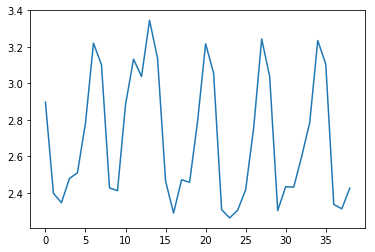

In [29]:
plt.plot(testpreds[129])

In [30]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [31]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.924425   
air_0164b9927d20bcc3_2017-04-23              1.377068   
air_0241aa3964b7f861_2017-04-23              2.333780   
air_0328696196e46f18_2017-04-23              2.163765   
air_034a3d5b40d5b1b1_2017-04-23              3.387645   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.851211  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   2.963265  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.316871  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.703844  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  28.596181

In [32]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [33]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [34]:
submission.to_csv("../submission/3003nb_conv_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')